##   Show mode collapse with temperature == 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torch.nn as nn
from torch import optim
from collections import Counter
from NDiv.ndiv_pytorch import NDiv_loss

tensor([[3, 3],
        [2, 1],
        [2, 1],
        ...,
        [1, 3],
        [1, 1],
        [3, 3]])


([<matplotlib.axis.XTick at 0x7fb19d1e59e8>,
 <a list of 8 Text xticklabel objects>)

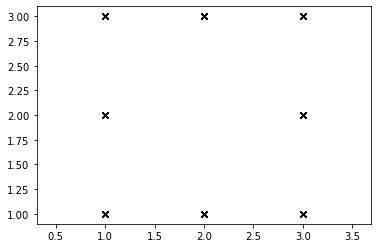

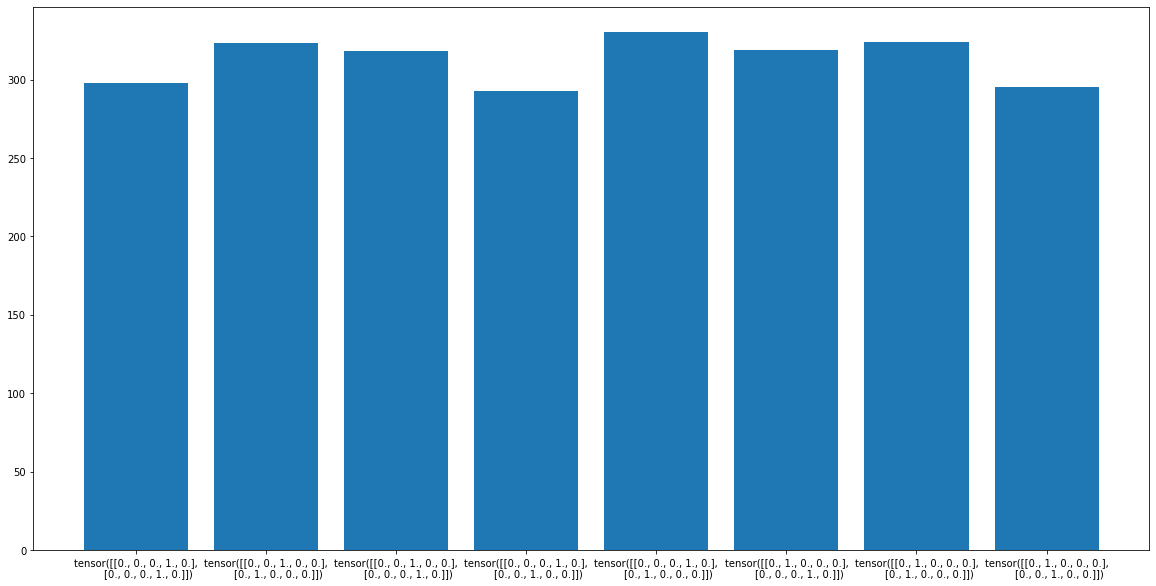

In [2]:
from loadDataset import *
from visualizer import *

data_config = {
    'name' : 'gaussian_grid',
    'n' : 5,
    'n_data' : 100,
    'sig' : 0.01
}

ds = getDataset(data_config)
dl = DataLoader(ds, batch_size=128, shuffle=True)

# gt data func, for train
def gen_real_data_onehot(dl, batch=128):

    real_samples = next(iter(dl))

    ''' delete adjacent modes from dataset '''
    mode_idx = [6,7, 8,11,13, 16, 17, 18]
    real_samples_new = [real_samples[i] for i in mode_idx]
    real_samples = real_samples_new
    
    ''' mix 25 modes '''
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2).long()

    ''' make dataset unbalanced '''
#     real_samples = real_samples[800:]
#     real_samples = real_samples[:-800]
    
    random_choice = torch.randint(0, real_samples.shape[0], (batch, )).long()
    data = real_samples[random_choice]
    data = torch.unsqueeze(data, -1)

    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

# data = gen_real_data_onehot(dl)

# gt data func, for test
def gen_real_data_test(dl, batch=128):

    real_samples = next(iter(dl))

    # mix 25 modes
    real_samples = torch.cat(real_samples, dim=0)
    real_samples = real_samples.view(-1, 2)
    real_samples = torch.unsqueeze(real_samples, -1).long()
    
    # convert to onehot
    data_onehot = torch.FloatTensor(batch, 2, 5)
    data_onehot.zero_()
    data_onehot.scatter_(2, data, 1)

    return data_onehot

def gen_input_data(batch=128):
    # https://pytorch.org/docs/stable/torch.html#torch.randn
    data = torch.zeros(int(batch/2), 2)
    data[:, 0] = 0.5
    data[:, 1] = -0.5
    return torch.cat((data, data), 0)

#     data = torch.randn(int(batch/ 2), 2)
#     return torch.cat((data, data), 0)

def gen_input_data_test(batch=128):
    return torch.randn(batch, 2)

''' Plot Distribution for Unbalanced Dataset '''

data = gen_real_data_onehot(dl, 2500)
print(torch.argmax(data,-1))
data_list = [str(x) for x in data]

# plot grid
plot_outputdata(torch.argmax(data, -1), dim1=0, dim2=1, marker='kx', alpha=0.1)

# plot bar chart
index = range(len(Counter(data_list).keys()))
plt.figure(figsize=(20,10))
plt.bar(index, Counter(data_list).values(), align='center')
plt.xticks(index, Counter(data_list).keys())

In [3]:
### Define Gumbel Function Utility

def sample_gumbel(shape, eps=1e-20):
    unif = torch.rand(*shape)
    g = -torch.log(-torch.log(unif + eps))
    return g

def sample_gumbel_softmax(logits, temperature):
    """
        Input:
        logits: Tensor of log probs, shape = BS x k
        temperature = scalar
        
        Output: Tensor of values sampled from Gumbel softmax.
                These will tend towards a one-hot representation in the limit of temp -> 0
                shape = BS x k
    """
    g = sample_gumbel(logits.shape).cuda()
    h = (g + logits) * temperature
    h_max = h.max(dim=-1, keepdim=True)[0]
    h = h - h_max
    cache = torch.exp(h)
    y = cache / cache.sum(dim=-1, keepdim=True)
    return y

In [4]:
### G Network based on gumbel
class MLPG(nn.Module):
    
    def __init__(self, input_size, hidden_size, noise_size, output_size, temperature=1):
        super(MLPG, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3_1 = nn.Linear(hidden_size + noise_size, output_size) # x-axis
        self.map3_2 = nn.Linear(hidden_size + noise_size, output_size) # y-axis
        
        self.name = 'MLPG'
        self.noise_size = noise_size
        self.temp = temperature
        
    def forward(self, x, temperature=None):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size).cuda()

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # perform gumbel sampling
        if temperature is not None:
            x_coord = sample_gumbel_softmax(x_coord, temperature)
            y_coord = sample_gumbel_softmax(y_coord, temperature)
        else:
            x_coord = sample_gumbel_softmax(x_coord, self.temp)
            y_coord = sample_gumbel_softmax(y_coord, self.temp)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1), noise
    
    def checkLogits(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        x = F.leaky_relu(self.map2(x), 0.1)
        
        """ generate latent sample ~ standard gaussian """
        noise = torch.rand(x.shape[0], self.noise_size)

        """ combine middle feature with latent sample """
        x = torch.cat([x, noise], -1)
        
        x_coord = self.map3_1(x)
        y_coord = self.map3_2(x)
        
        # concate for discriminator
        return torch.cat((x_coord, y_coord), -1)
    
### D Network to produce loss
class MLPD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPD, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, output_size)
        self.name = 'MLPD'
        
    def forward(self, x):
        x = F.leaky_relu(self.map1(x), 0.1)
        return torch.sigmoid(self.map2(x))
    
### Create the overall network
class gumbel_gan(object):
    def __init__(self, temperature=1):
        self.g = MLPG(2, 128, 25, 5, temperature=temperature).cuda()
        self.d = MLPD(10, 128, 1).cuda()
        
        self.g_optim = optim.Adam(self.g.parameters(), lr=1e-4)
        self.d_optim = optim.Adam(self.d.parameters(), lr=1e-4)
        
        self.d_step = 1
#         self.g_step = 10
        self.g_step = 1
        self.g_NDiv = 3
        
        self.criterion = nn.BCELoss()
        
    def train(self, epoch, real_data, g_input):
        print("training start")
        pbar = range(epoch)
        batch = real_data.shape[0]
        
        for ep in pbar:
            for d_index in range(self.d_step):
                
                # Train D
                self.d.zero_grad()
                
                # Train D on real
                d_real_decision = self.d(real_data)
                labels = torch.ones(d_real_decision.shape, dtype=torch.float32).cuda()
                d_real_loss = self.criterion(d_real_decision, labels)
                
                # Train D on fake
                fake_data, latent_samples = self.g(g_input)
                d_fake_decision = self.d(fake_data.view(batch, -1))
                labels = torch.zeros(d_fake_decision.shape, dtype=torch.float32).cuda()
                
                d_fake_loss = self.criterion(d_fake_decision, labels)

                # calc loss for D
                d_loss = 0.5 * (d_real_loss + d_fake_loss)
#                 d_loss = 0.5 * (d_real_loss + d_fake_loss)
                d_loss.backward()
                d_loss_val = d_loss.item()
                
                # update D
                self.d_optim.step()
                
            """ optim NDiv diversity """
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                # print(latent_samples.shape)
                # raise
                div_loss = NDiv_loss(latent_samples, g_fake_data) * 1e2
                div_loss_val = div_loss.item()
                
                # update G w.r.t NDiv
#                 div_loss.backward()
#                 self.g_optim.step()
                
            for g_index in range(self.g_step):
                
                # Train on G
                self.g.zero_grad()
                
                g_fake_data, latent_samples = self.g(g_input)
                batch = g_fake_data.shape[0]
                
                g_fake_decision = self.d(g_fake_data.view(batch, -1))
                
                
                # G loss
                labels = torch.ones(g_fake_decision.shape, dtype=torch.float32).cuda()
                g_loss = -(g_fake_decision.log() * labels + (1-labels)*(1-g_fake_decision.log())).mean()
                
                g_loss_val = g_loss.item()
                
                g_loss.backward()
                
                # update G
                self.g_optim.step()
                
            print("Iteration {}, d real/fake loss {}/{} and g loss is {}, NDiv loss {}".format(ep, d_real_loss.item(), \
                                                                                 d_fake_loss.item(), g_loss, div_loss_val))            

In [5]:
## Init the simple Network
## Define temperature here
net = gumbel_gan(temperature=1)
print(net.g, net.d)

MLPG(
  (map1): Linear(in_features=2, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=128, bias=True)
  (map3_1): Linear(in_features=153, out_features=5, bias=True)
  (map3_2): Linear(in_features=153, out_features=5, bias=True)
) MLPD(
  (map1): Linear(in_features=10, out_features=128, bias=True)
  (map2): Linear(in_features=128, out_features=1, bias=True)
)


Processing Epoch 0
training start
Iteration 0, d real/fake loss 0.7693921327590942/0.625400722026825 and g loss is 0.7674261927604675, NDiv loss 0.028267793357372284
Iteration 1, d real/fake loss 0.7681769728660583/0.6266535520553589 and g loss is 0.7665088772773743, NDiv loss 0.0319993756711483
Iteration 2, d real/fake loss 0.7669805288314819/0.6246231198310852 and g loss is 0.7621496319770813, NDiv loss 0.028711702674627304
Iteration 3, d real/fake loss 0.7657774686813354/0.6264041662216187 and g loss is 0.7647991180419922, NDiv loss 0.02891365997493267
Iteration 4, d real/fake loss 0.764582633972168/0.6288259029388428 and g loss is 0.7623739242553711, NDiv loss 0.030052073299884796


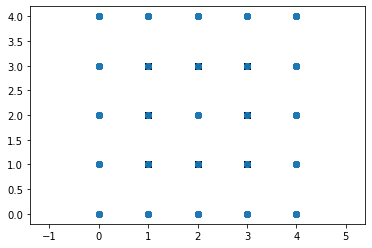

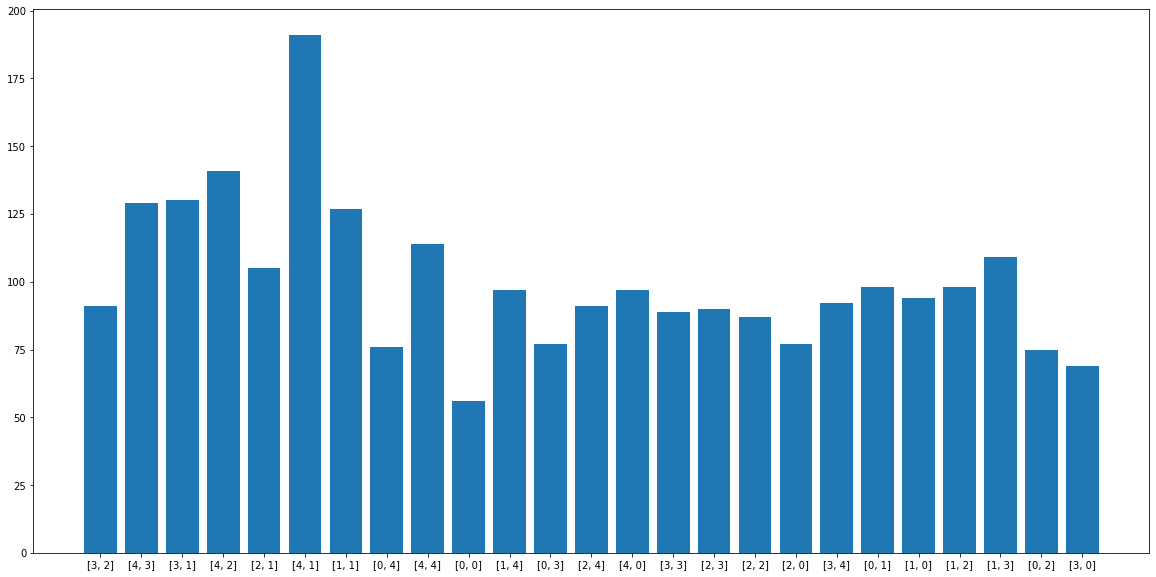

Processing Epoch 1
training start
Iteration 0, d real/fake loss 0.7723129987716675/0.6273971199989319 and g loss is 0.7620015144348145, NDiv loss 0.028871795162558556
Iteration 1, d real/fake loss 0.771152138710022/0.629768431186676 and g loss is 0.7628860473632812, NDiv loss 0.028926914557814598
Iteration 2, d real/fake loss 0.7700005769729614/0.6284342408180237 and g loss is 0.7591719627380371, NDiv loss 0.029663922265172005
Iteration 3, d real/fake loss 0.7688603401184082/0.6306855082511902 and g loss is 0.7610343098640442, NDiv loss 0.02850872091948986
Iteration 4, d real/fake loss 0.7677252888679504/0.629991888999939 and g loss is 0.7640217542648315, NDiv loss 0.028756307438015938


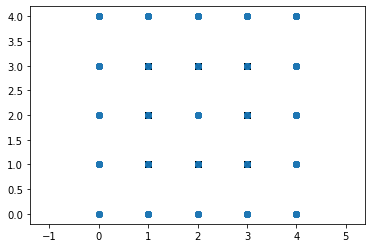

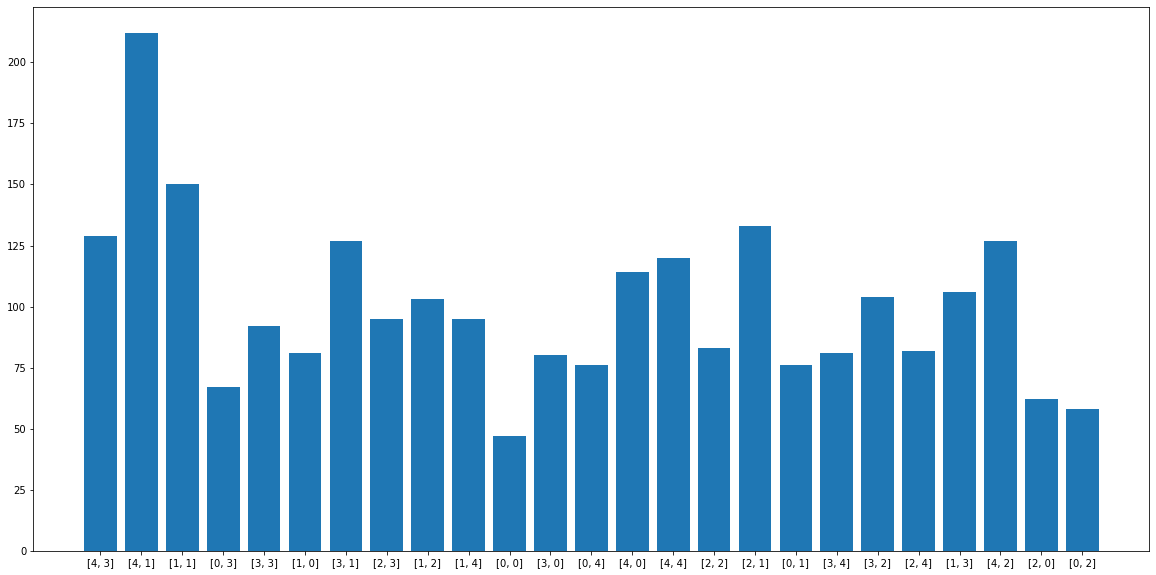

Processing Epoch 2
training start
Iteration 0, d real/fake loss 0.7603363990783691/0.6293659210205078 and g loss is 0.758635401725769, NDiv loss 0.030674252659082413
Iteration 1, d real/fake loss 0.7592217922210693/0.6319275498390198 and g loss is 0.7591069936752319, NDiv loss 0.030210020020604134
Iteration 2, d real/fake loss 0.7581145763397217/0.6310589909553528 and g loss is 0.7566748857498169, NDiv loss 0.030506504699587822
Iteration 3, d real/fake loss 0.7570105791091919/0.6295247673988342 and g loss is 0.7591874599456787, NDiv loss 0.027887502685189247
Iteration 4, d real/fake loss 0.7559083104133606/0.6364185810089111 and g loss is 0.7570555210113525, NDiv loss 0.02789139375090599


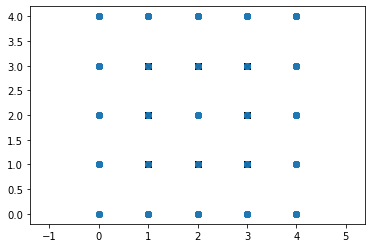

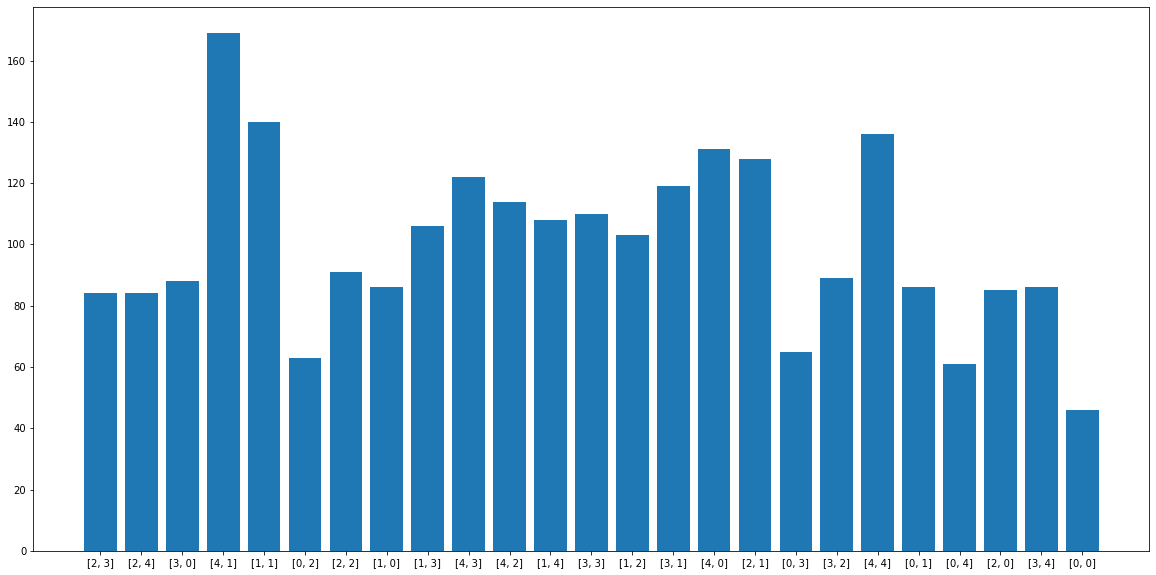

Processing Epoch 3
training start
Iteration 0, d real/fake loss 0.7572140693664551/0.6332603693008423 and g loss is 0.7553352117538452, NDiv loss 0.028232015669345856
Iteration 1, d real/fake loss 0.7561392188072205/0.6335411667823792 and g loss is 0.7567670345306396, NDiv loss 0.028963681310415268
Iteration 2, d real/fake loss 0.7550708055496216/0.6323089003562927 and g loss is 0.7559336423873901, NDiv loss 0.02994084544479847
Iteration 3, d real/fake loss 0.7540154457092285/0.6338624358177185 and g loss is 0.7557694911956787, NDiv loss 0.029796987771987915
Iteration 4, d real/fake loss 0.7529670596122742/0.6338134407997131 and g loss is 0.7544751167297363, NDiv loss 0.026810815557837486


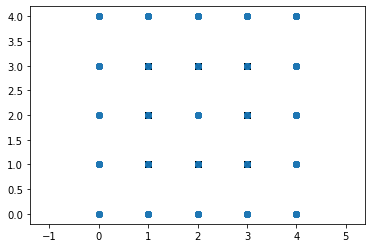

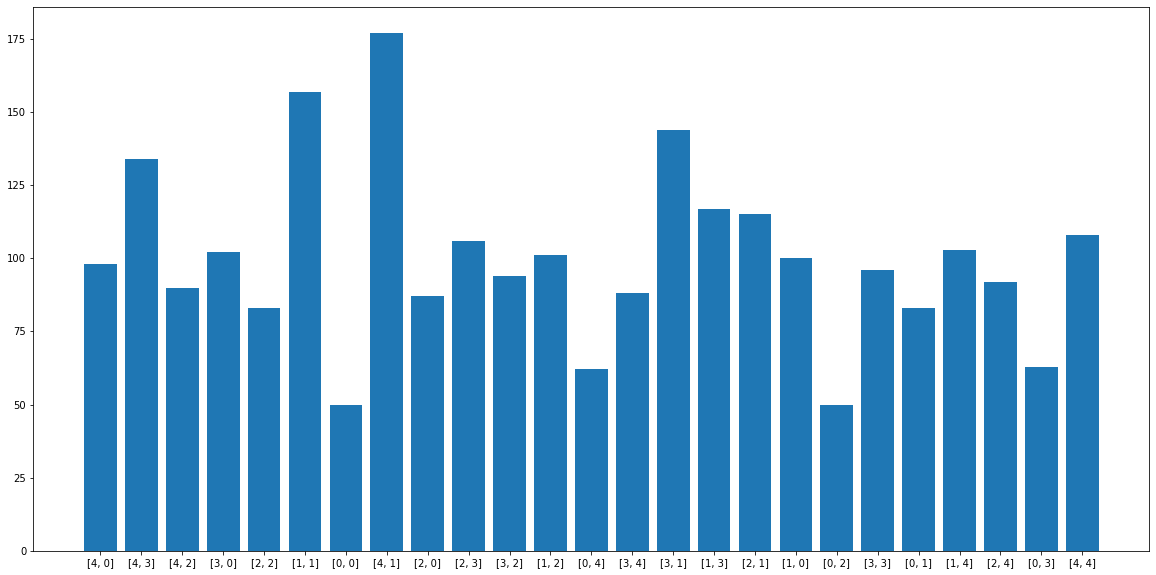

Processing Epoch 4
training start
Iteration 0, d real/fake loss 0.7502294182777405/0.6373147368431091 and g loss is 0.7548788785934448, NDiv loss 0.027752460911870003
Iteration 1, d real/fake loss 0.7491918802261353/0.6338090896606445 and g loss is 0.7557747960090637, NDiv loss 0.02933681011199951
Iteration 2, d real/fake loss 0.7481525540351868/0.636604905128479 and g loss is 0.7526998519897461, NDiv loss 0.02972112037241459
Iteration 3, d real/fake loss 0.747117817401886/0.636530876159668 and g loss is 0.7551994919776917, NDiv loss 0.02789655700325966
Iteration 4, d real/fake loss 0.7460867166519165/0.638731837272644 and g loss is 0.7528278231620789, NDiv loss 0.028991304337978363


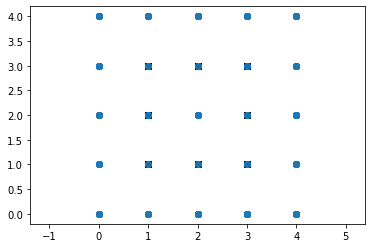

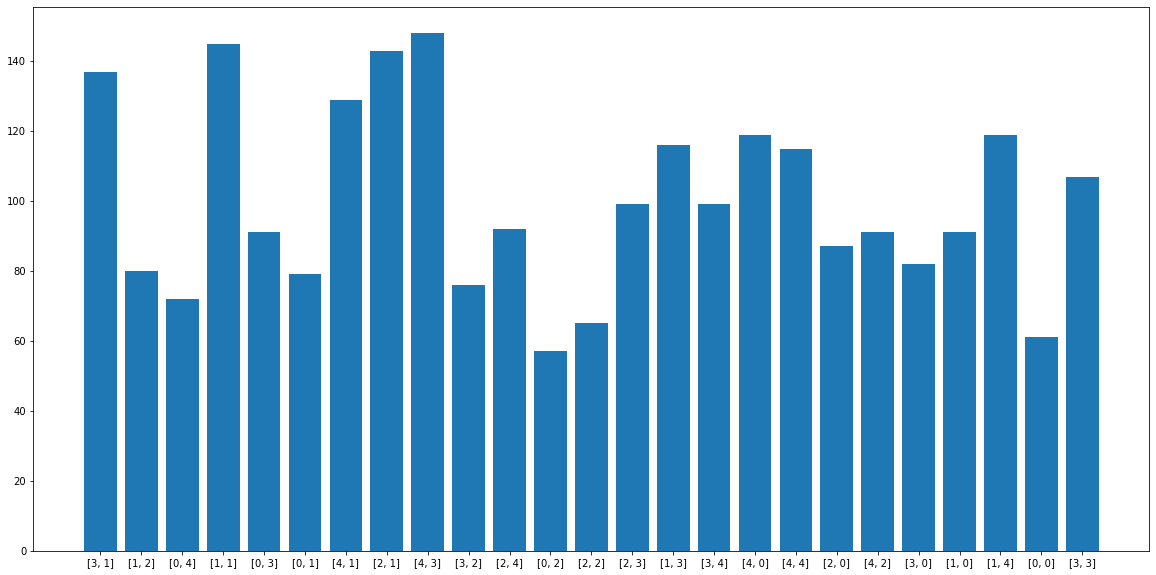

Processing Epoch 5
training start
Iteration 0, d real/fake loss 0.7473012804985046/0.6362602710723877 and g loss is 0.7541558146476746, NDiv loss 0.029384411871433258
Iteration 1, d real/fake loss 0.7462732195854187/0.6355664730072021 and g loss is 0.7498520612716675, NDiv loss 0.02904551289975643
Iteration 2, d real/fake loss 0.745246410369873/0.6396629214286804 and g loss is 0.7507599592208862, NDiv loss 0.02917574532330036
Iteration 3, d real/fake loss 0.7442216873168945/0.6401195526123047 and g loss is 0.7497459650039673, NDiv loss 0.029088055714964867
Iteration 4, d real/fake loss 0.7431986331939697/0.6416724324226379 and g loss is 0.7497766613960266, NDiv loss 0.03023688681423664


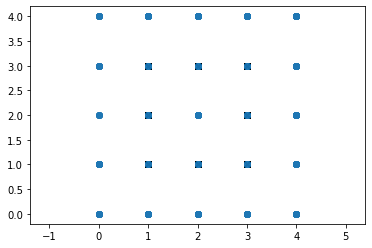

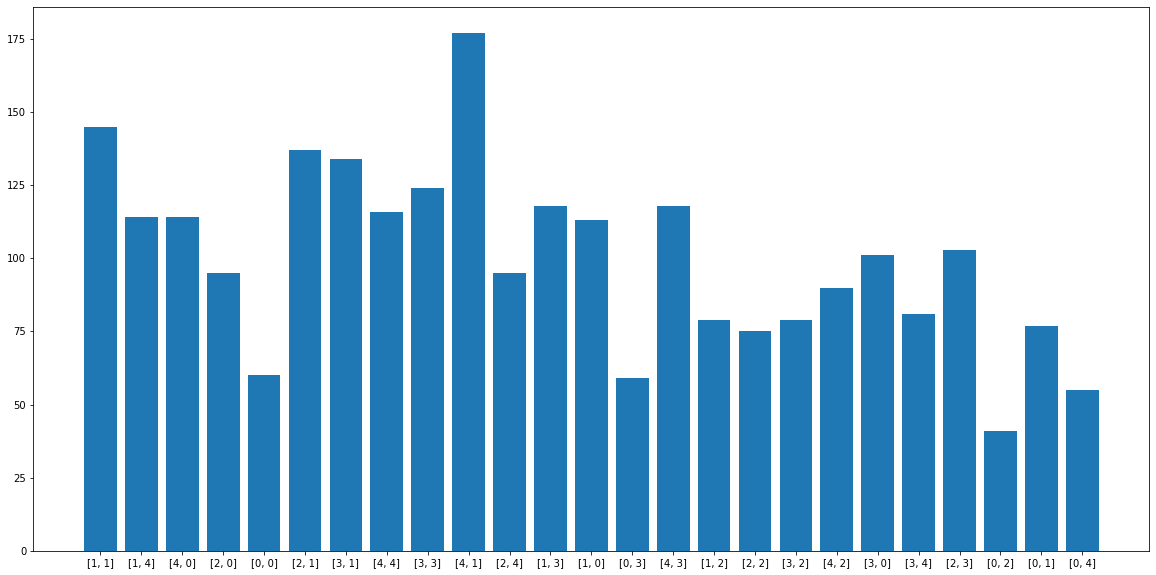

Processing Epoch 6
training start
Iteration 0, d real/fake loss 0.7405309081077576/0.6400871276855469 and g loss is 0.7507959604263306, NDiv loss 0.028449049219489098
Iteration 1, d real/fake loss 0.7395543456077576/0.6434822082519531 and g loss is 0.7481905221939087, NDiv loss 0.028891608119010925
Iteration 2, d real/fake loss 0.7385897636413574/0.6416073441505432 and g loss is 0.7480946779251099, NDiv loss 0.02963106893002987
Iteration 3, d real/fake loss 0.7376342415809631/0.6408576965332031 and g loss is 0.75002121925354, NDiv loss 0.028703760355710983
Iteration 4, d real/fake loss 0.7366806268692017/0.6400996446609497 and g loss is 0.7498309016227722, NDiv loss 0.02951030246913433


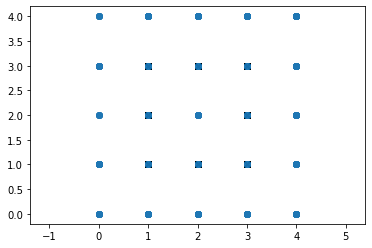

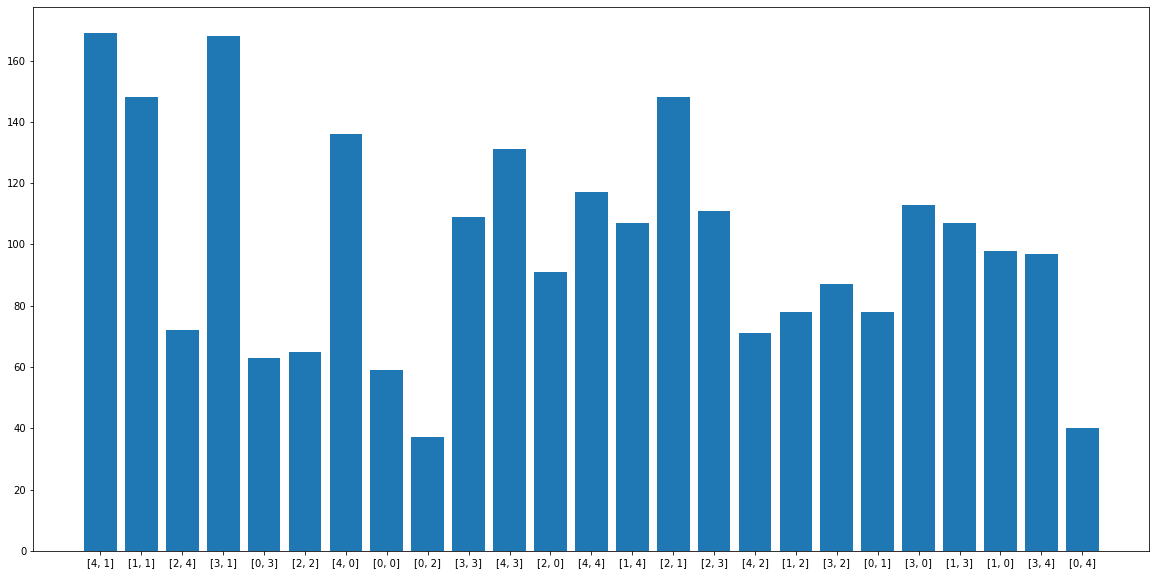

Processing Epoch 7
training start
Iteration 0, d real/fake loss 0.7358372211456299/0.6431095004081726 and g loss is 0.7497204542160034, NDiv loss 0.027722585946321487
Iteration 1, d real/fake loss 0.7348677515983582/0.6417043209075928 and g loss is 0.7470467686653137, NDiv loss 0.032065391540527344
Iteration 2, d real/fake loss 0.7338985204696655/0.6428660154342651 and g loss is 0.7432334423065186, NDiv loss 0.03020475246012211
Iteration 3, d real/fake loss 0.7329277992248535/0.6437490582466125 and g loss is 0.745089590549469, NDiv loss 0.028751639649271965
Iteration 4, d real/fake loss 0.731962263584137/0.6457217335700989 and g loss is 0.746222734451294, NDiv loss 0.031414635479450226


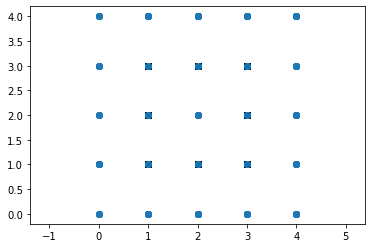

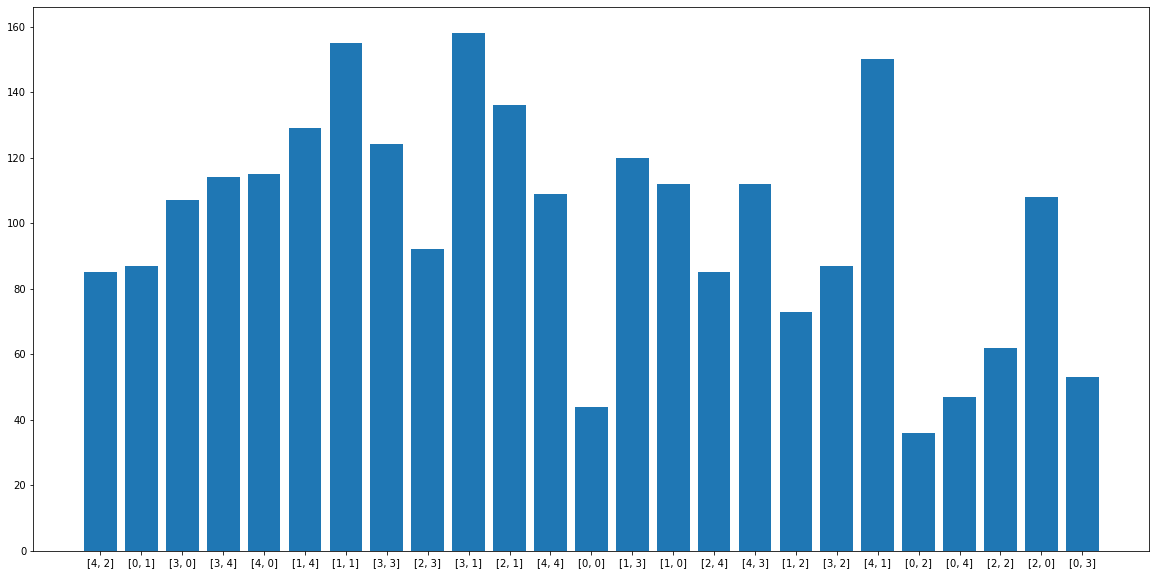

Processing Epoch 8
training start
Iteration 0, d real/fake loss 0.7291049957275391/0.643791913986206 and g loss is 0.7435758113861084, NDiv loss 0.029386403039097786
Iteration 1, d real/fake loss 0.7281748056411743/0.6460411548614502 and g loss is 0.7434589266777039, NDiv loss 0.02969501167535782
Iteration 2, d real/fake loss 0.7272619009017944/0.6445639133453369 and g loss is 0.7453376054763794, NDiv loss 0.029541898518800735
Iteration 3, d real/fake loss 0.7263604402542114/0.644009530544281 and g loss is 0.7437074780464172, NDiv loss 0.02823266014456749
Iteration 4, d real/fake loss 0.7254631519317627/0.6466802358627319 and g loss is 0.74431973695755, NDiv loss 0.03000190481543541


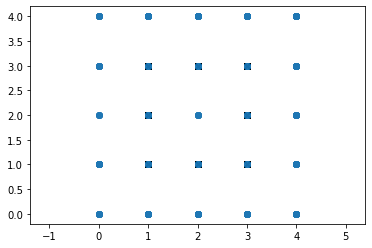

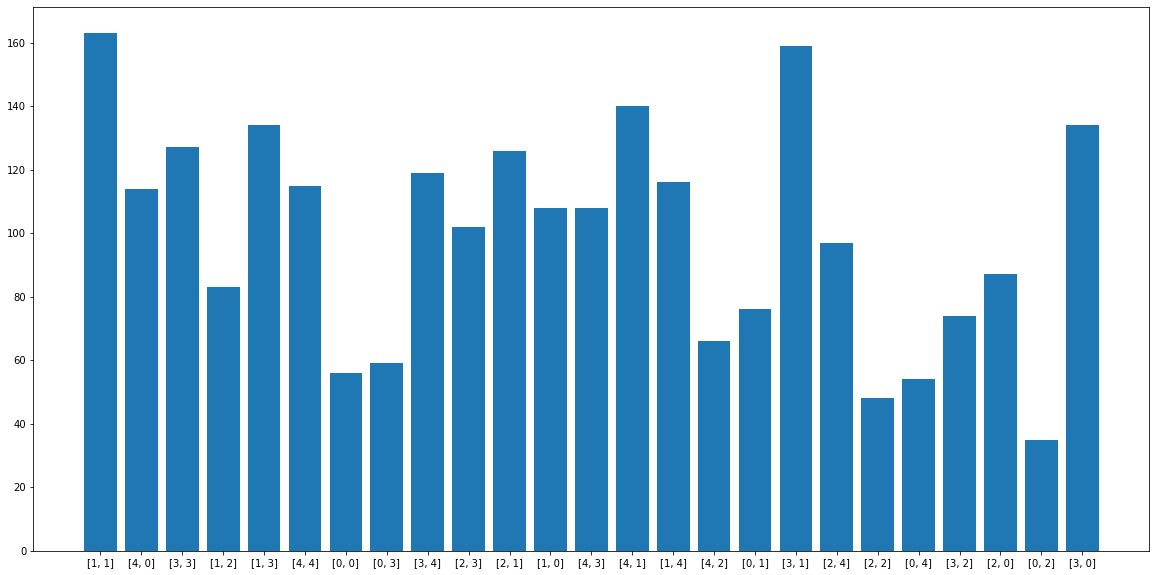

Processing Epoch 9
training start
Iteration 0, d real/fake loss 0.7212015390396118/0.6444060206413269 and g loss is 0.7406823635101318, NDiv loss 0.0298535767942667
Iteration 1, d real/fake loss 0.7203218936920166/0.647176206111908 and g loss is 0.7411360740661621, NDiv loss 0.029451580718159676
Iteration 2, d real/fake loss 0.719450831413269/0.6468937993049622 and g loss is 0.7411510348320007, NDiv loss 0.029043812304735184
Iteration 3, d real/fake loss 0.7185860276222229/0.6483498215675354 and g loss is 0.7419905662536621, NDiv loss 0.02850116230547428
Iteration 4, d real/fake loss 0.7177245616912842/0.6486027240753174 and g loss is 0.7427758574485779, NDiv loss 0.029375772923231125


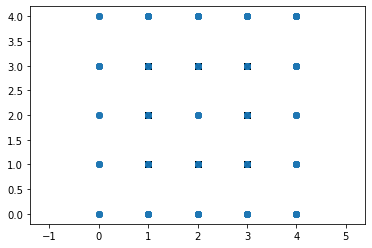

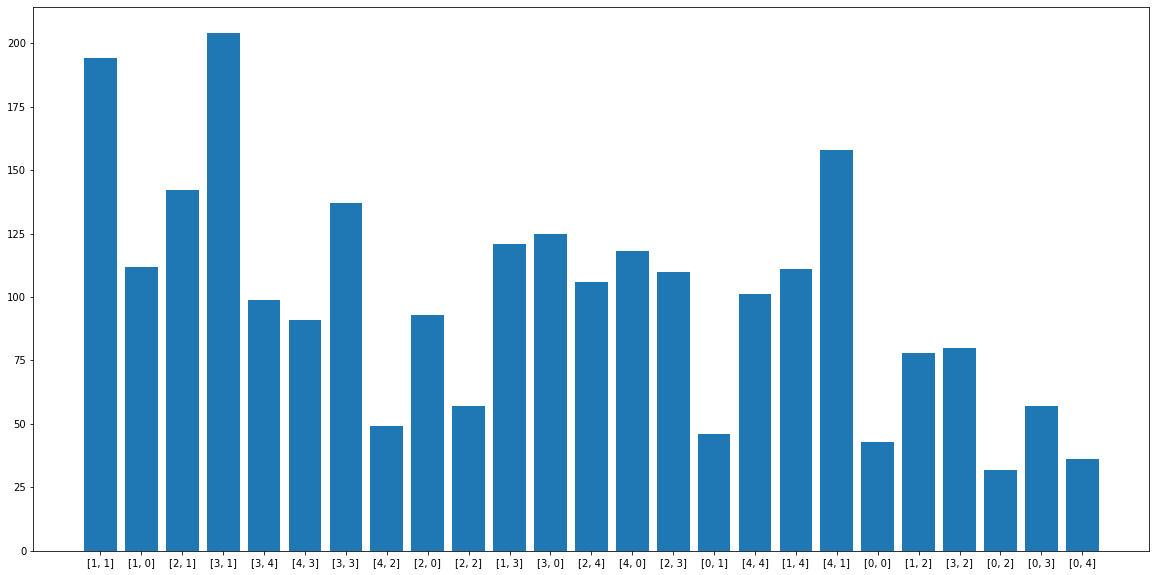

Processing Epoch 10
training start
Iteration 0, d real/fake loss 0.719275176525116/0.6479904651641846 and g loss is 0.7402031421661377, NDiv loss 0.02914116159081459
Iteration 1, d real/fake loss 0.7184314131736755/0.649492084980011 and g loss is 0.7393019199371338, NDiv loss 0.02935422770678997
Iteration 2, d real/fake loss 0.7175867557525635/0.6459165811538696 and g loss is 0.739851176738739, NDiv loss 0.029398562386631966
Iteration 3, d real/fake loss 0.7167345285415649/0.6491122841835022 and g loss is 0.7358728647232056, NDiv loss 0.031610410660505295
Iteration 4, d real/fake loss 0.7158851623535156/0.649187445640564 and g loss is 0.73725426197052, NDiv loss 0.029979998245835304


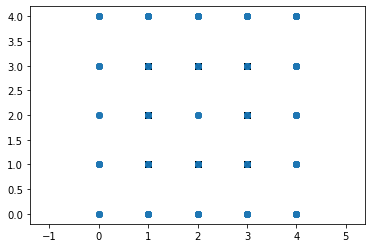

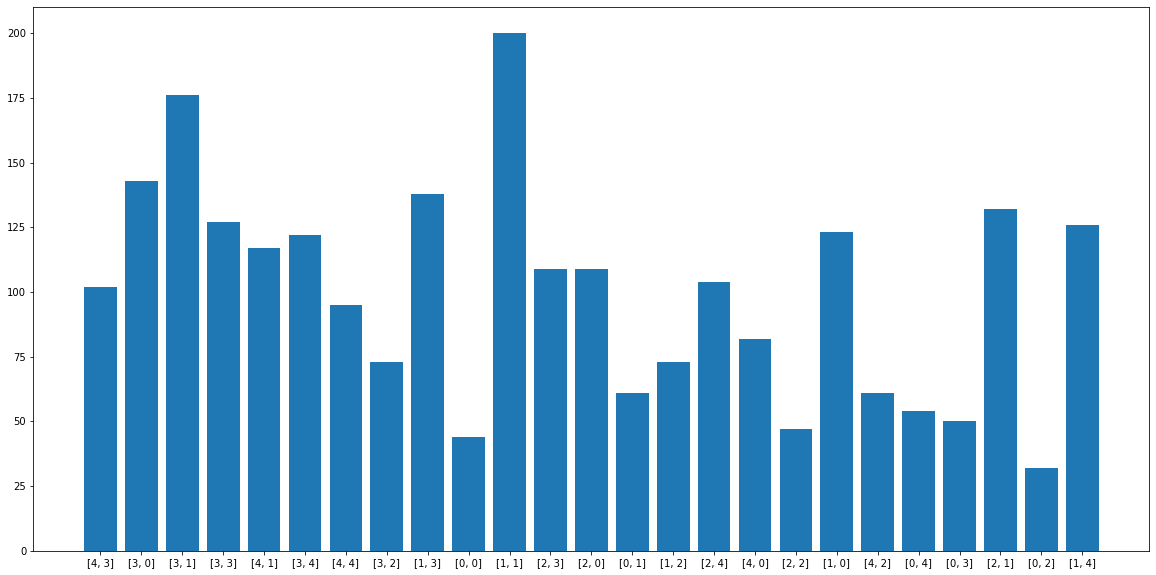

Processing Epoch 11
training start
Iteration 0, d real/fake loss 0.7174438238143921/0.6511081457138062 and g loss is 0.7380080819129944, NDiv loss 0.02907620184123516
Iteration 1, d real/fake loss 0.7166315317153931/0.6516565084457397 and g loss is 0.7395467162132263, NDiv loss 0.0286924559623003
Iteration 2, d real/fake loss 0.7158298492431641/0.651134729385376 and g loss is 0.7389932870864868, NDiv loss 0.028545426204800606
Iteration 3, d real/fake loss 0.7150449156761169/0.6521522998809814 and g loss is 0.7381337881088257, NDiv loss 0.02992655150592327
Iteration 4, d real/fake loss 0.7142757773399353/0.650404155254364 and g loss is 0.7361751198768616, NDiv loss 0.029372770339250565


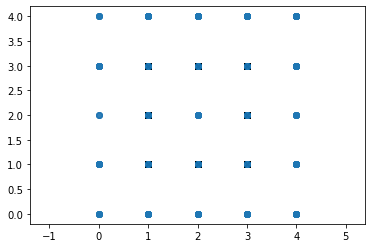

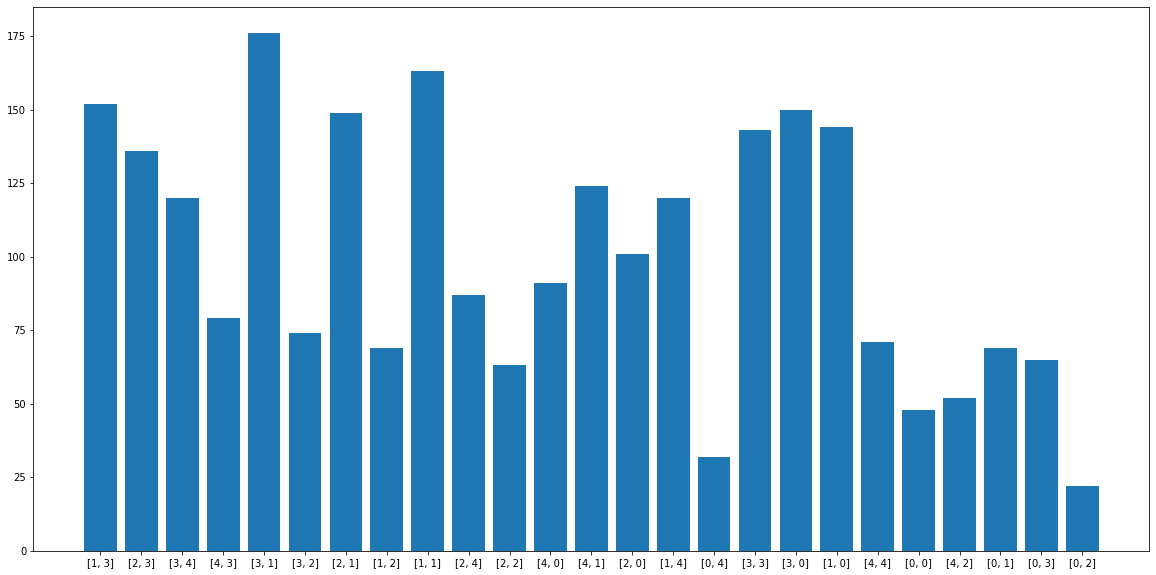

Processing Epoch 12
training start
Iteration 0, d real/fake loss 0.7142685651779175/0.6518381237983704 and g loss is 0.7354520559310913, NDiv loss 0.028599975630640984
Iteration 1, d real/fake loss 0.7135064601898193/0.6543399691581726 and g loss is 0.7344453930854797, NDiv loss 0.02869723178446293
Iteration 2, d real/fake loss 0.7127382159233093/0.6551402807235718 and g loss is 0.7317942976951599, NDiv loss 0.03108976036310196
Iteration 3, d real/fake loss 0.7119676470756531/0.6543845534324646 and g loss is 0.7351124286651611, NDiv loss 0.029788894578814507
Iteration 4, d real/fake loss 0.7111990451812744/0.6543303728103638 and g loss is 0.7337130904197693, NDiv loss 0.02900976687669754


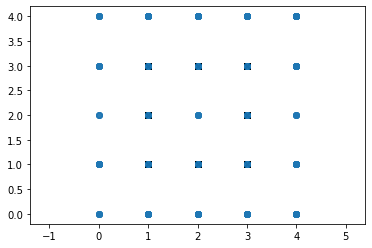

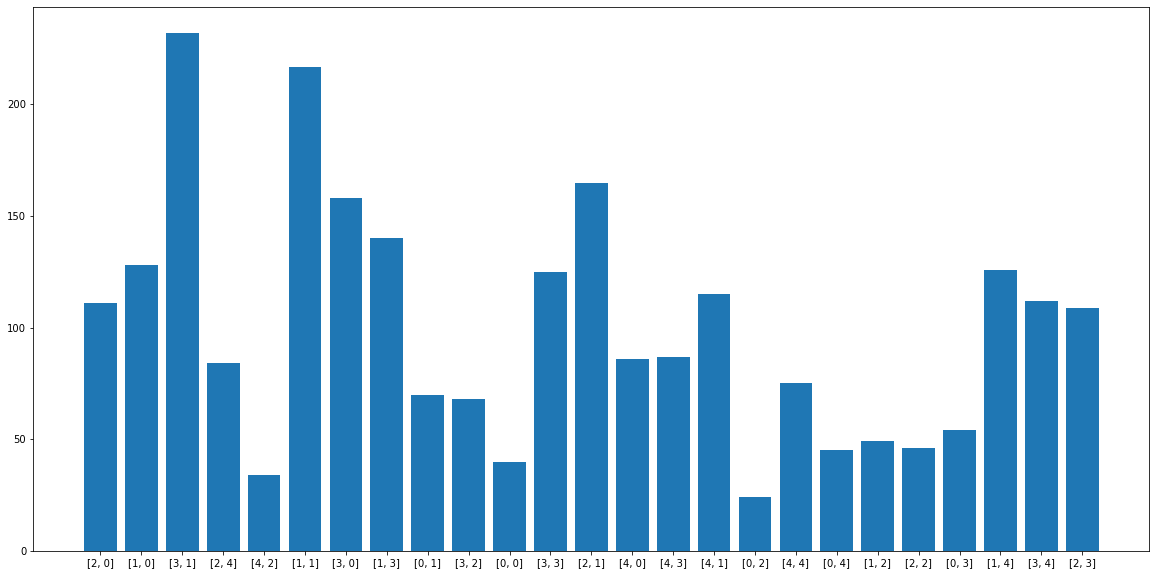

Processing Epoch 13
training start
Iteration 0, d real/fake loss 0.7096611261367798/0.6536471247673035 and g loss is 0.731442928314209, NDiv loss 0.030037449672818184
Iteration 1, d real/fake loss 0.7088968753814697/0.6554350852966309 and g loss is 0.7343210577964783, NDiv loss 0.02959892712533474
Iteration 2, d real/fake loss 0.708132266998291/0.6545637249946594 and g loss is 0.7321431636810303, NDiv loss 0.028687048703432083
Iteration 3, d real/fake loss 0.7073734402656555/0.6559069752693176 and g loss is 0.7293704748153687, NDiv loss 0.02983100712299347
Iteration 4, d real/fake loss 0.7066233158111572/0.6573261618614197 and g loss is 0.7309207916259766, NDiv loss 0.03167422115802765


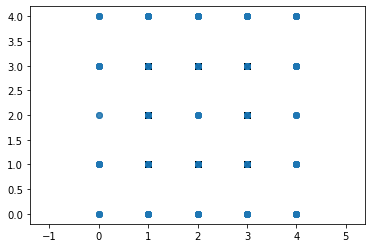

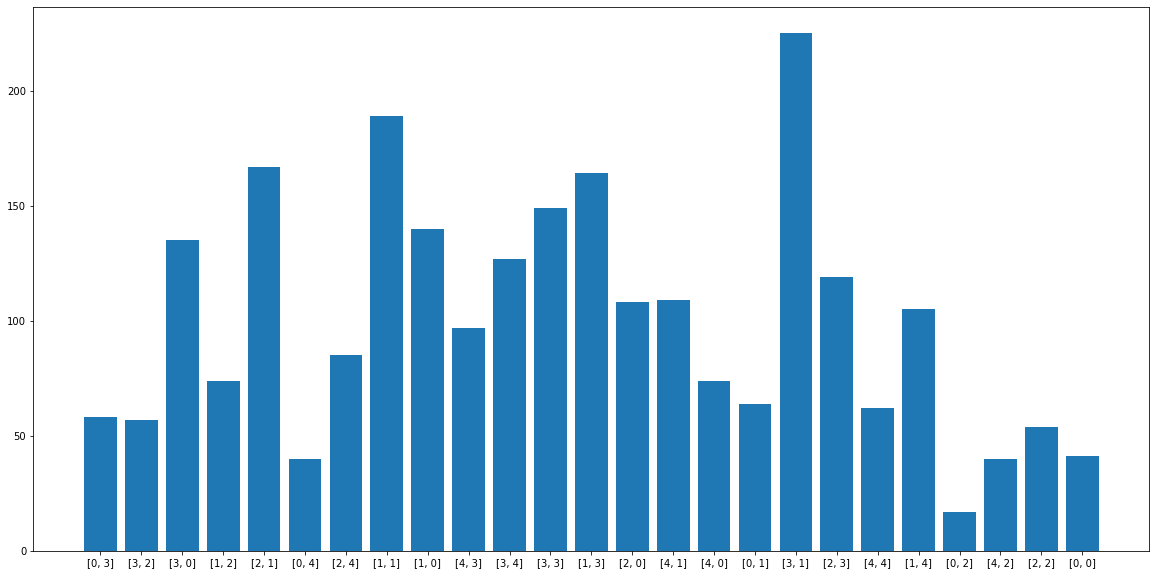

Processing Epoch 14
training start
Iteration 0, d real/fake loss 0.7057410478591919/0.6574294567108154 and g loss is 0.7334660887718201, NDiv loss 0.029819944873452187
Iteration 1, d real/fake loss 0.7050272822380066/0.657204270362854 and g loss is 0.730388879776001, NDiv loss 0.0304880291223526
Iteration 2, d real/fake loss 0.7043188810348511/0.6549646854400635 and g loss is 0.7290216684341431, NDiv loss 0.03027835115790367
Iteration 3, d real/fake loss 0.7036142349243164/0.6589511036872864 and g loss is 0.7301660180091858, NDiv loss 0.030197910964488983
Iteration 4, d real/fake loss 0.7029207348823547/0.6576441526412964 and g loss is 0.7278609275817871, NDiv loss 0.03170837089419365


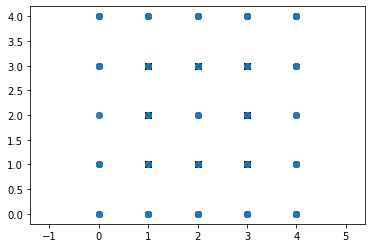

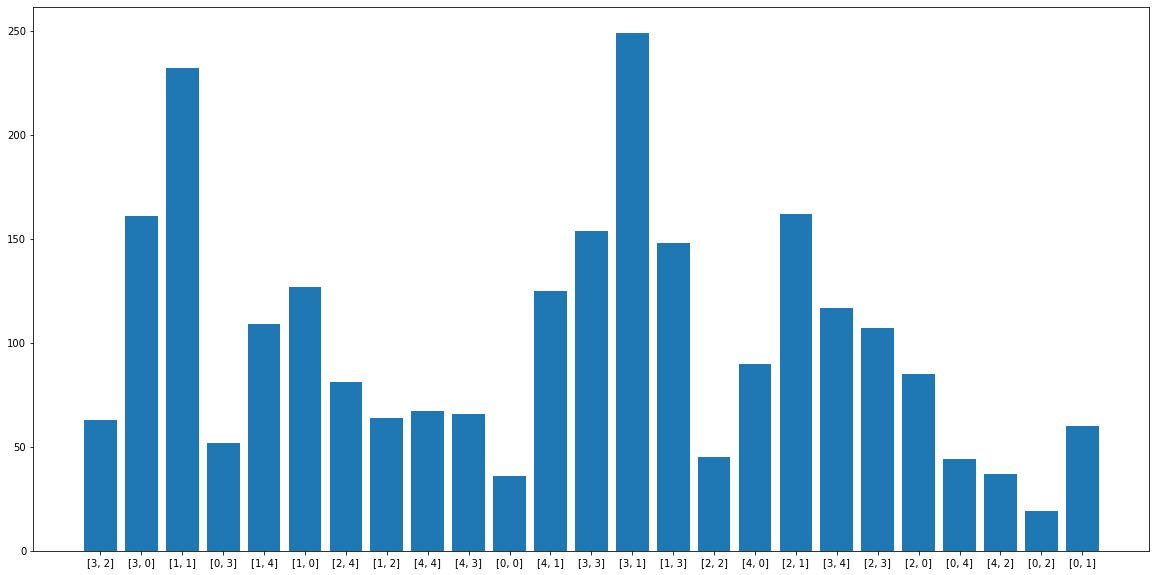

Processing Epoch 15
training start
Iteration 0, d real/fake loss 0.7007788419723511/0.6573323011398315 and g loss is 0.7307592630386353, NDiv loss 0.03178108483552933
Iteration 1, d real/fake loss 0.7000942826271057/0.6589090824127197 and g loss is 0.7270582318305969, NDiv loss 0.03147108480334282
Iteration 2, d real/fake loss 0.6994045376777649/0.6587837934494019 and g loss is 0.7273463010787964, NDiv loss 0.030959486961364746
Iteration 3, d real/fake loss 0.6987165212631226/0.6597862839698792 and g loss is 0.7252869606018066, NDiv loss 0.029754437506198883
Iteration 4, d real/fake loss 0.6980333924293518/0.6622514724731445 and g loss is 0.7266409397125244, NDiv loss 0.03145042434334755


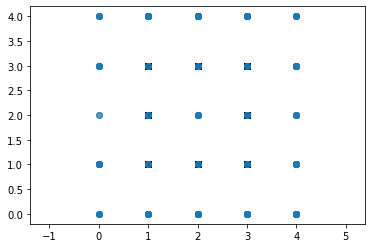

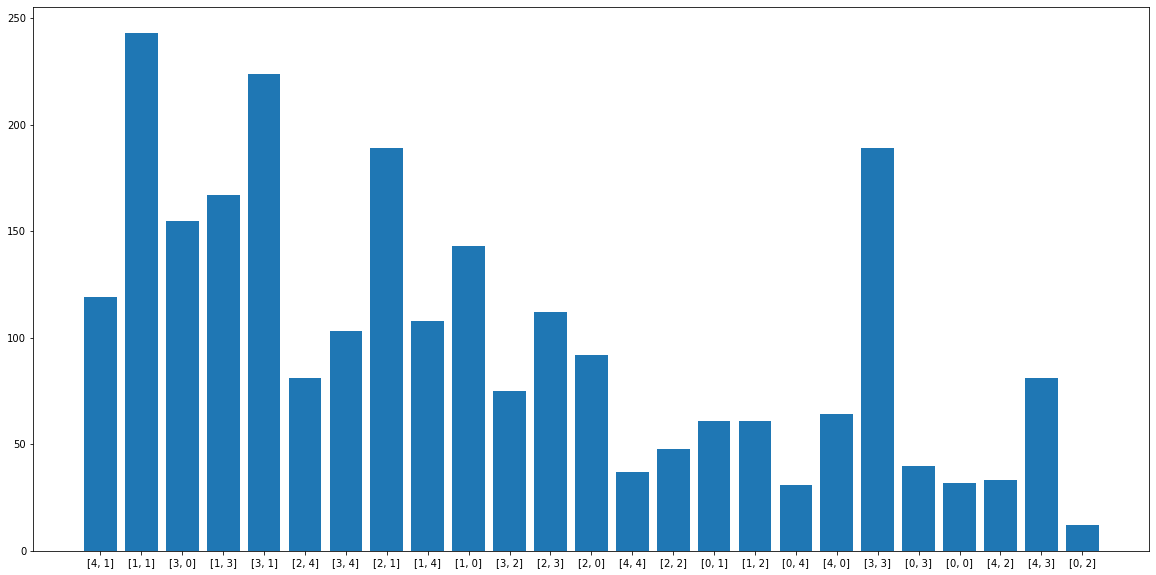

Processing Epoch 16
training start
Iteration 0, d real/fake loss 0.7001953721046448/0.6585103273391724 and g loss is 0.7236799001693726, NDiv loss 0.031698890030384064
Iteration 1, d real/fake loss 0.6995130777359009/0.6603536605834961 and g loss is 0.7238576412200928, NDiv loss 0.03067033179104328
Iteration 2, d real/fake loss 0.6988273859024048/0.6637364625930786 and g loss is 0.7245559692382812, NDiv loss 0.032289665192365646
Iteration 3, d real/fake loss 0.6981391906738281/0.6636744737625122 and g loss is 0.7251893281936646, NDiv loss 0.03284934163093567
Iteration 4, d real/fake loss 0.6974506974220276/0.6636755466461182 and g loss is 0.7266414165496826, NDiv loss 0.030598120763897896


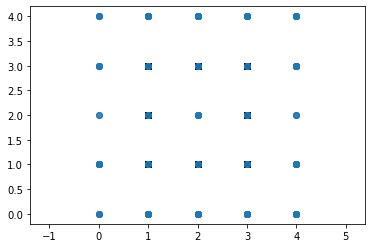

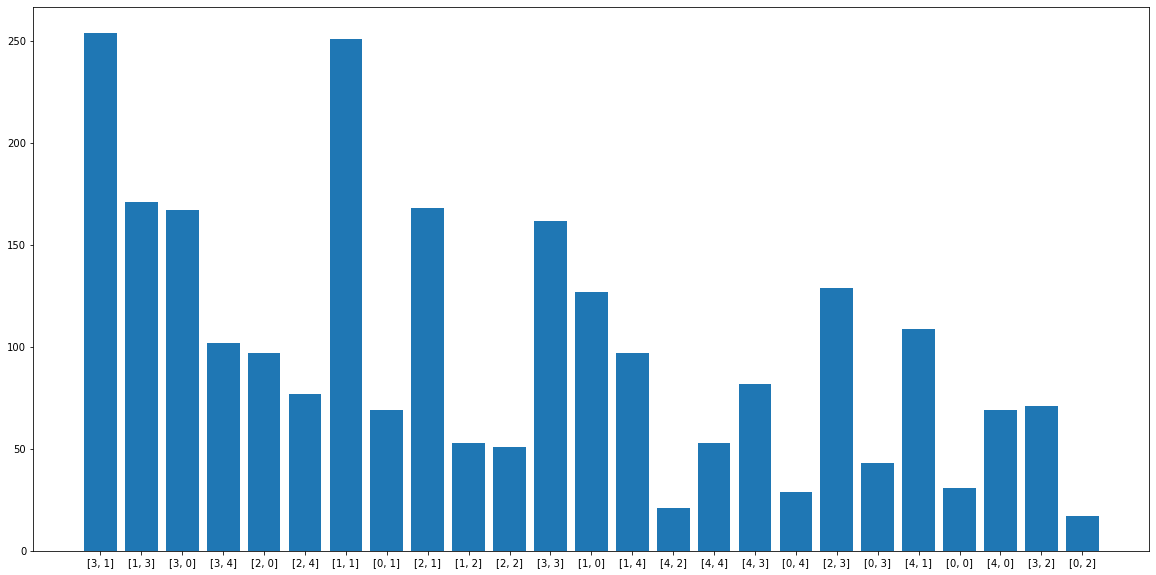

Processing Epoch 17
training start
Iteration 0, d real/fake loss 0.6974838972091675/0.6647621989250183 and g loss is 0.7240115404129028, NDiv loss 0.03073190152645111
Iteration 1, d real/fake loss 0.6968152523040771/0.6652542948722839 and g loss is 0.7230017185211182, NDiv loss 0.033784836530685425
Iteration 2, d real/fake loss 0.6961615085601807/0.6667810678482056 and g loss is 0.7216529846191406, NDiv loss 0.03386455774307251
Iteration 3, d real/fake loss 0.6955193281173706/0.6666010618209839 and g loss is 0.7264729738235474, NDiv loss 0.03387888893485069
Iteration 4, d real/fake loss 0.6948831081390381/0.6659418344497681 and g loss is 0.723158597946167, NDiv loss 0.034390807151794434


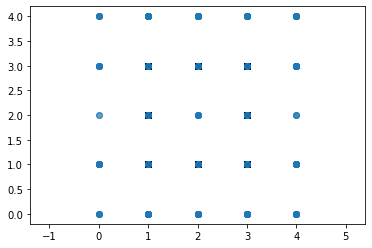

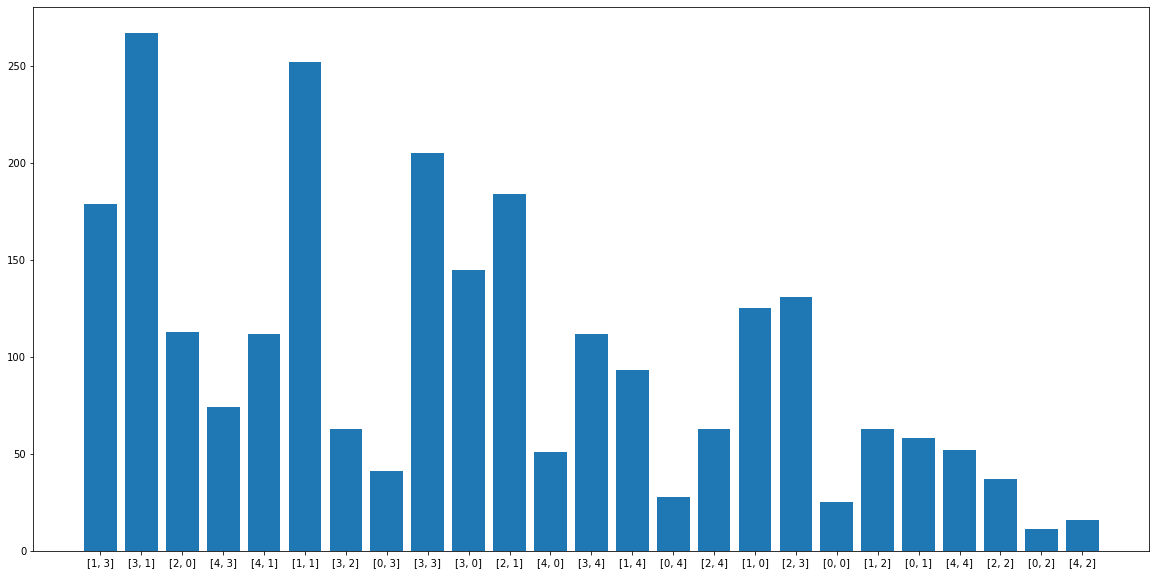

Processing Epoch 18
training start
Iteration 0, d real/fake loss 0.6936710476875305/0.665054440498352 and g loss is 0.7226945757865906, NDiv loss 0.03403562679886818
Iteration 1, d real/fake loss 0.6930510401725769/0.6654337644577026 and g loss is 0.7238853573799133, NDiv loss 0.03158082813024521
Iteration 2, d real/fake loss 0.6924279928207397/0.6662516593933105 and g loss is 0.7204570770263672, NDiv loss 0.03358268737792969
Iteration 3, d real/fake loss 0.6918082237243652/0.6660831570625305 and g loss is 0.7173817157745361, NDiv loss 0.032438524067401886
Iteration 4, d real/fake loss 0.6911789178848267/0.6673346757888794 and g loss is 0.7152414321899414, NDiv loss 0.03479643911123276


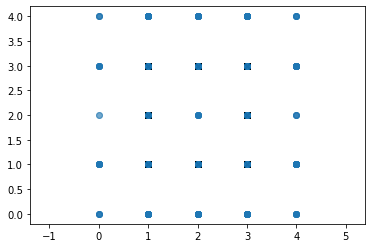

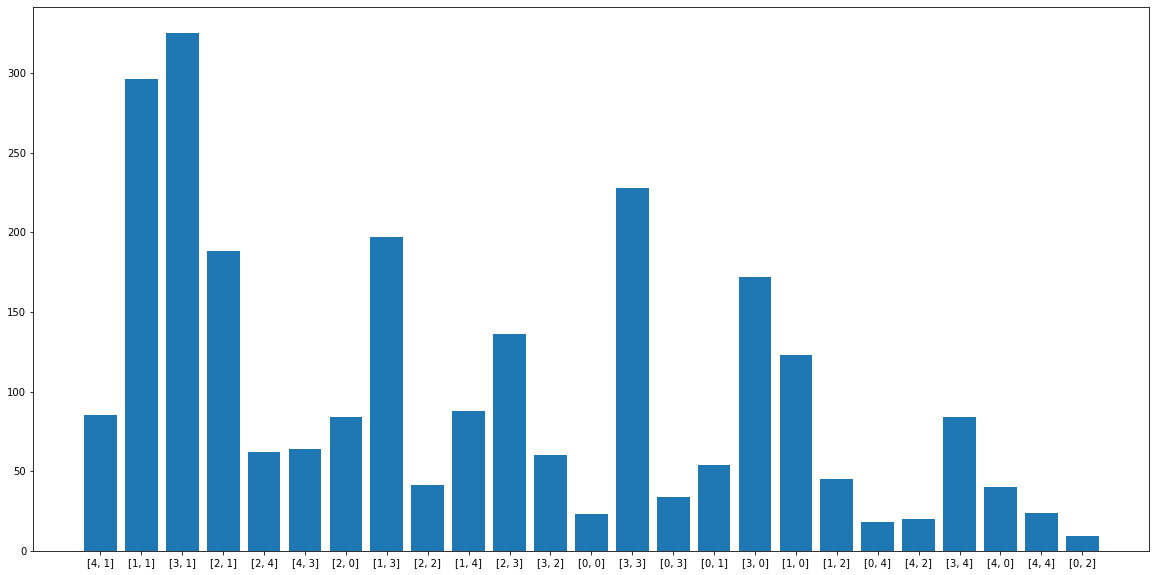

Processing Epoch 19
training start
Iteration 0, d real/fake loss 0.6881043910980225/0.668036699295044 and g loss is 0.717035710811615, NDiv loss 0.03401612490415573
Iteration 1, d real/fake loss 0.6874986886978149/0.6690395474433899 and g loss is 0.7182942032814026, NDiv loss 0.03137410804629326
Iteration 2, d real/fake loss 0.6869103908538818/0.6711571216583252 and g loss is 0.7180514335632324, NDiv loss 0.032390277832746506
Iteration 3, d real/fake loss 0.6863313913345337/0.6705290675163269 and g loss is 0.7168023586273193, NDiv loss 0.03232735022902489
Iteration 4, d real/fake loss 0.6857656240463257/0.67315673828125 and g loss is 0.7159342765808105, NDiv loss 0.03217140585184097


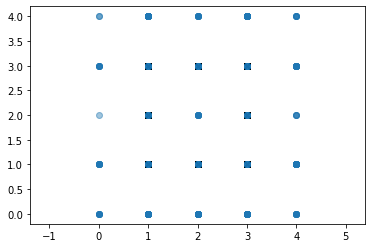

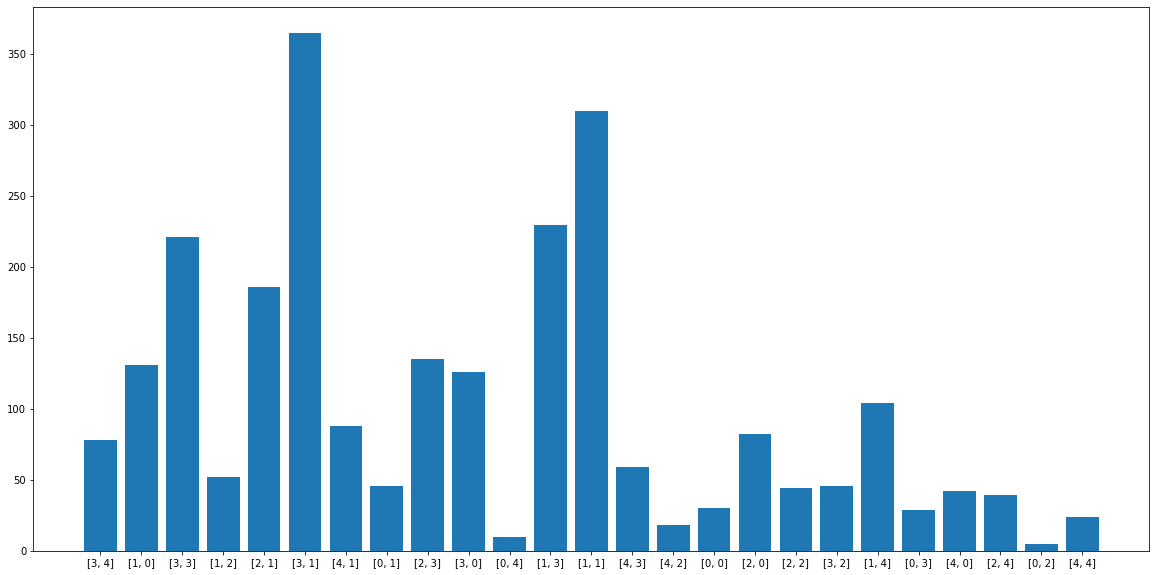

Processing Epoch 20
training start
Iteration 0, d real/fake loss 0.6872965693473816/0.6715648174285889 and g loss is 0.7128158807754517, NDiv loss 0.03449971228837967
Iteration 1, d real/fake loss 0.6867501139640808/0.6729313135147095 and g loss is 0.7122740745544434, NDiv loss 0.03428996354341507
Iteration 2, d real/fake loss 0.6862196922302246/0.6714552044868469 and g loss is 0.7139745950698853, NDiv loss 0.03382157161831856
Iteration 3, d real/fake loss 0.6856978535652161/0.6737563014030457 and g loss is 0.715427815914154, NDiv loss 0.03616701811552048
Iteration 4, d real/fake loss 0.6851837635040283/0.672011137008667 and g loss is 0.7119702696800232, NDiv loss 0.03532455116510391


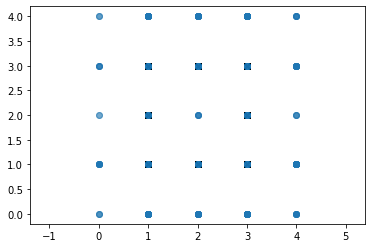

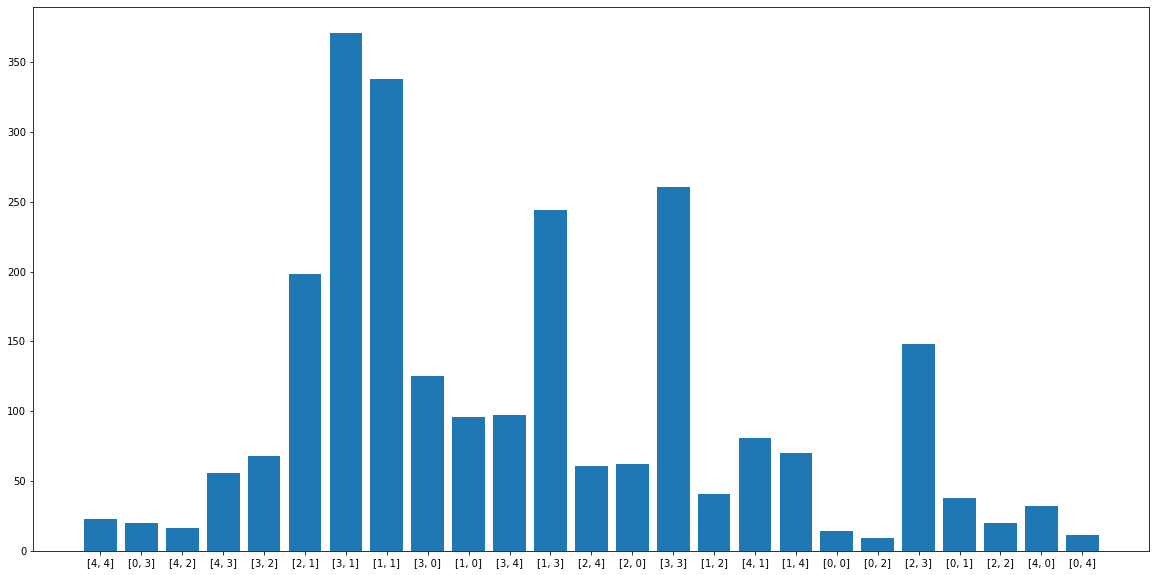

Processing Epoch 21
training start
Iteration 0, d real/fake loss 0.6839117407798767/0.6735163331031799 and g loss is 0.7102974057197571, NDiv loss 0.03499167039990425
Iteration 1, d real/fake loss 0.683445155620575/0.6736963391304016 and g loss is 0.712153434753418, NDiv loss 0.03664205223321915
Iteration 2, d real/fake loss 0.6829944252967834/0.6749746203422546 and g loss is 0.7097421288490295, NDiv loss 0.03580201417207718
Iteration 3, d real/fake loss 0.68255615234375/0.6795727610588074 and g loss is 0.709810733795166, NDiv loss 0.03596675768494606
Iteration 4, d real/fake loss 0.6821359395980835/0.6758204698562622 and g loss is 0.7108162045478821, NDiv loss 0.03649216890335083


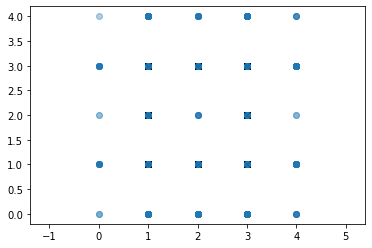

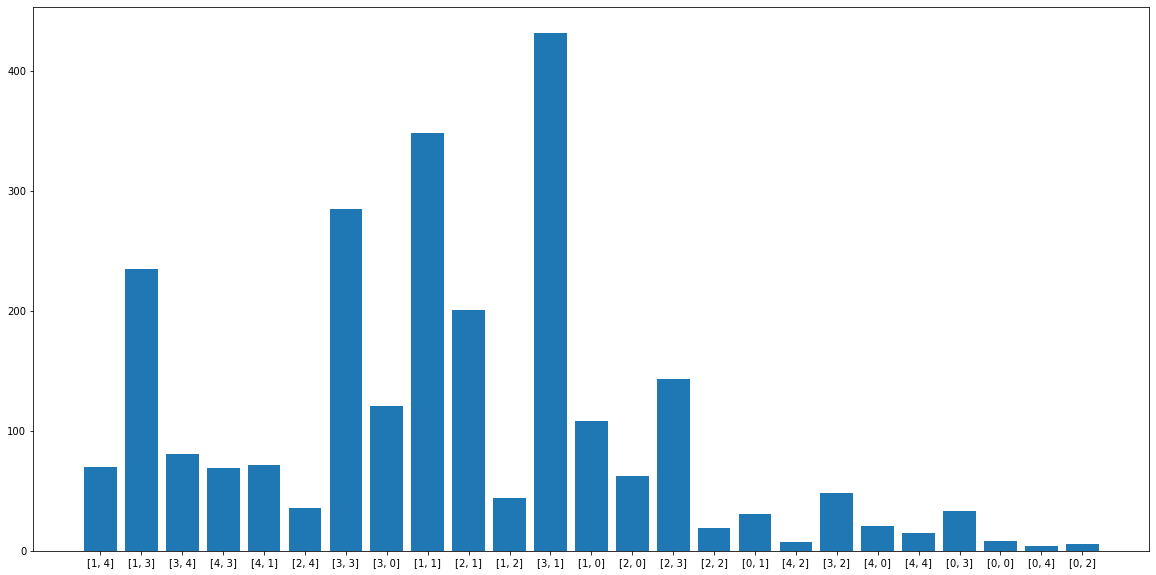

Processing Epoch 22
training start
Iteration 0, d real/fake loss 0.6816238164901733/0.6798456311225891 and g loss is 0.7104786038398743, NDiv loss 0.03931421414017677
Iteration 1, d real/fake loss 0.6812452077865601/0.6744801998138428 and g loss is 0.7093127965927124, NDiv loss 0.03406431898474693
Iteration 2, d real/fake loss 0.6808770895004272/0.676773190498352 and g loss is 0.7105252742767334, NDiv loss 0.03662235289812088
Iteration 3, d real/fake loss 0.6805157661437988/0.6770450472831726 and g loss is 0.7075649499893188, NDiv loss 0.034239210188388824
Iteration 4, d real/fake loss 0.6801709532737732/0.6807529926300049 and g loss is 0.7074113488197327, NDiv loss 0.0336439311504364


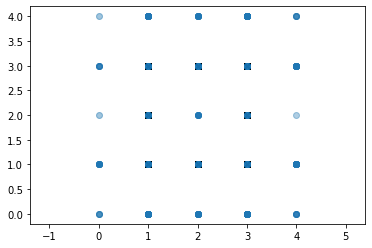

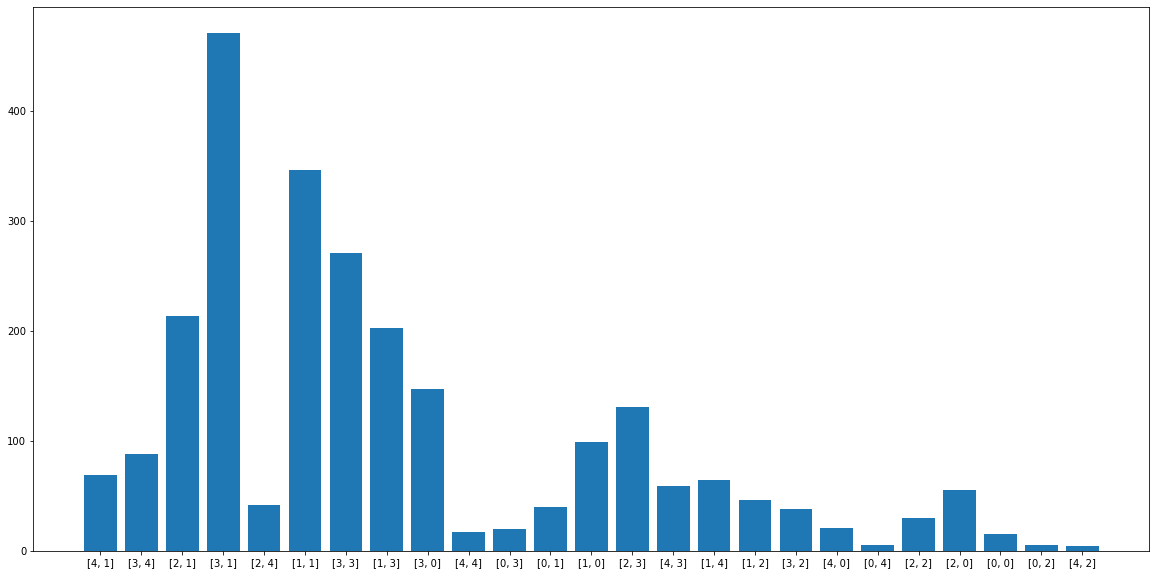

Processing Epoch 23
training start
Iteration 0, d real/fake loss 0.680588960647583/0.6790808439254761 and g loss is 0.7096847295761108, NDiv loss 0.03800404816865921
Iteration 1, d real/fake loss 0.680243730545044/0.6810768842697144 and g loss is 0.7069580554962158, NDiv loss 0.03724948316812515
Iteration 2, d real/fake loss 0.6799028515815735/0.6815425157546997 and g loss is 0.7046544551849365, NDiv loss 0.03827470541000366
Iteration 3, d real/fake loss 0.6795666217803955/0.6803826093673706 and g loss is 0.7097604870796204, NDiv loss 0.036977171897888184
Iteration 4, d real/fake loss 0.6792323589324951/0.6831837296485901 and g loss is 0.7040740251541138, NDiv loss 0.03642353042960167


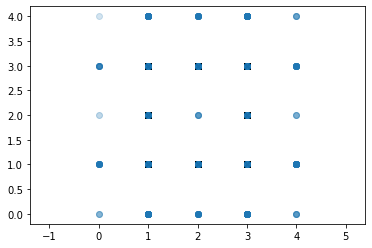

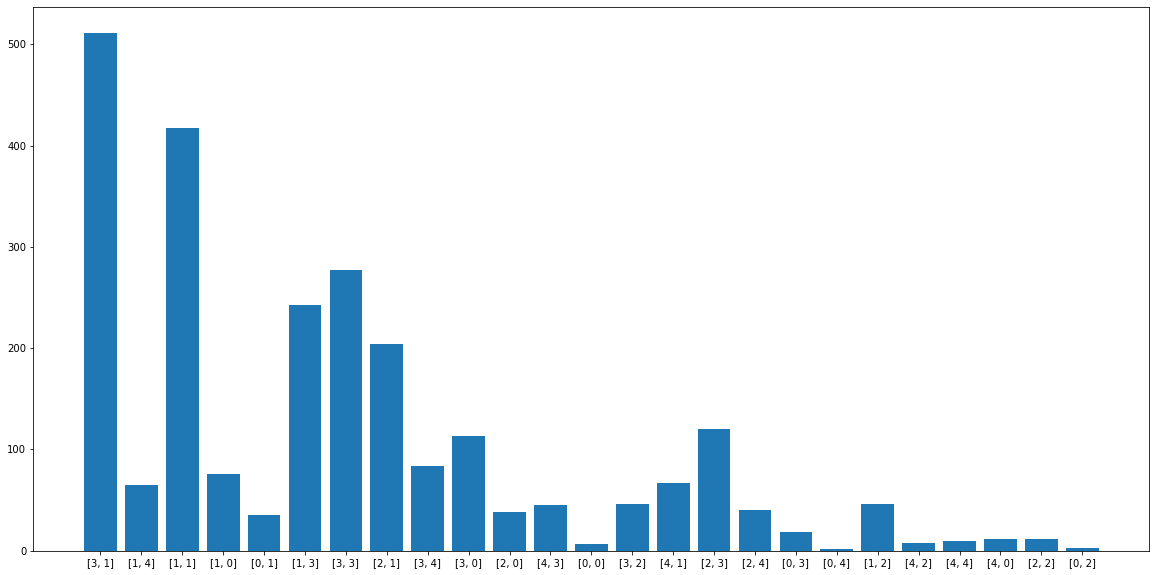

Processing Epoch 24
training start
Iteration 0, d real/fake loss 0.6791377663612366/0.6820449233055115 and g loss is 0.7009760141372681, NDiv loss 0.03690683841705322
Iteration 1, d real/fake loss 0.6788326501846313/0.6820858120918274 and g loss is 0.7032493352890015, NDiv loss 0.036424458026885986
Iteration 2, d real/fake loss 0.6785315275192261/0.6832232475280762 and g loss is 0.7054116725921631, NDiv loss 0.041666071861982346
Iteration 3, d real/fake loss 0.678231418132782/0.6875050067901611 and g loss is 0.7034961581230164, NDiv loss 0.040329400449991226
Iteration 4, d real/fake loss 0.6779419183731079/0.6830441951751709 and g loss is 0.7048467397689819, NDiv loss 0.039507701992988586


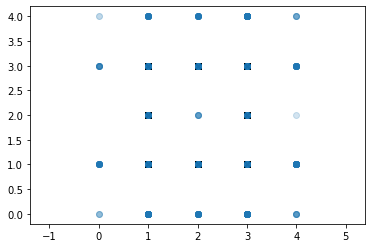

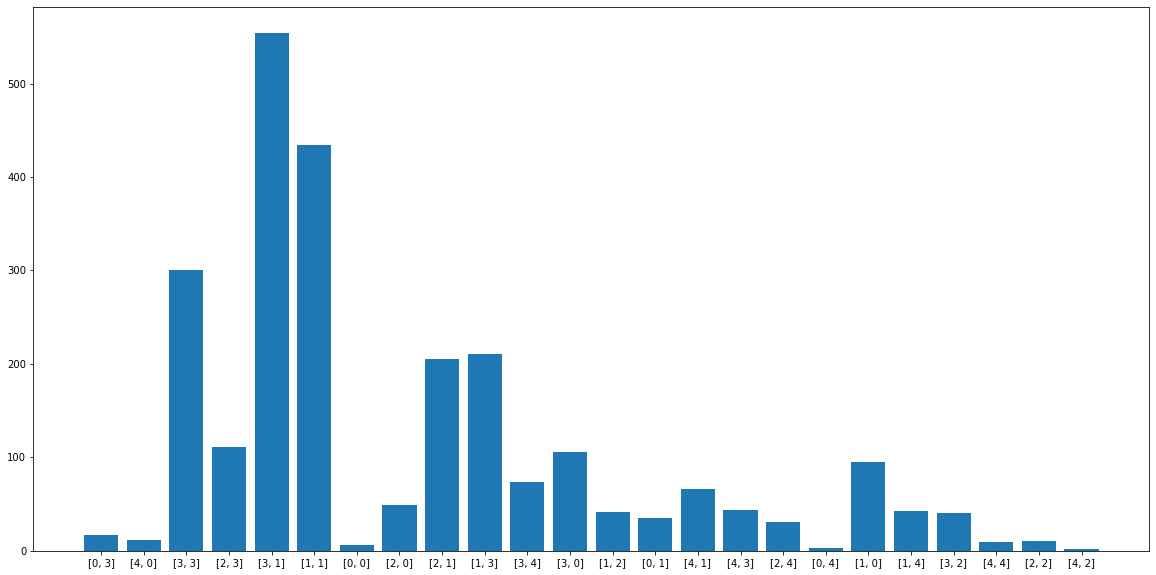

Processing Epoch 25
training start
Iteration 0, d real/fake loss 0.6764091849327087/0.6792728900909424 and g loss is 0.7033678889274597, NDiv loss 0.039172857999801636
Iteration 1, d real/fake loss 0.6761438846588135/0.6825579404830933 and g loss is 0.7013101577758789, NDiv loss 0.039800919592380524
Iteration 2, d real/fake loss 0.6758743524551392/0.6837061643600464 and g loss is 0.7025241851806641, NDiv loss 0.038242120295763016
Iteration 3, d real/fake loss 0.6756170988082886/0.683300256729126 and g loss is 0.7008489966392517, NDiv loss 0.0448308065533638
Iteration 4, d real/fake loss 0.6753665208816528/0.6845360994338989 and g loss is 0.7015303373336792, NDiv loss 0.041892390698194504


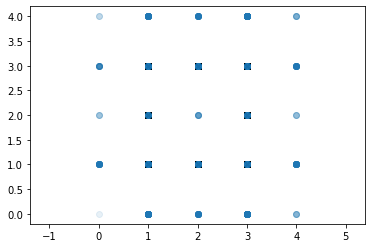

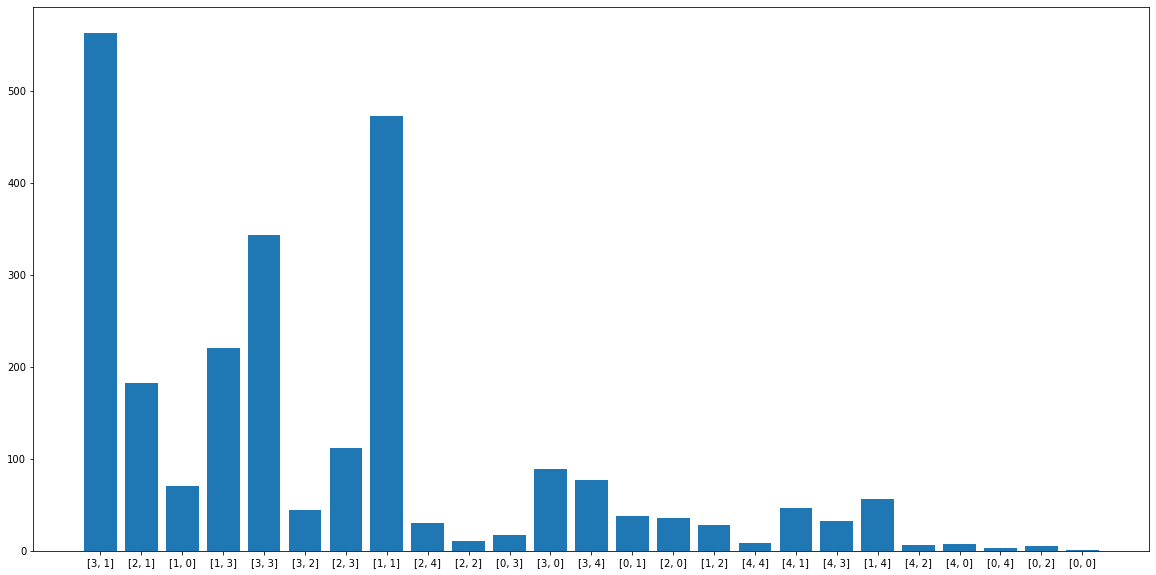

Processing Epoch 26
training start
Iteration 0, d real/fake loss 0.6734530925750732/0.6858474016189575 and g loss is 0.7032662630081177, NDiv loss 0.04199793562293053
Iteration 1, d real/fake loss 0.6732450723648071/0.6847003698348999 and g loss is 0.698987603187561, NDiv loss 0.04085760936141014
Iteration 2, d real/fake loss 0.6730338335037231/0.6875970959663391 and g loss is 0.7014529705047607, NDiv loss 0.04182259738445282
Iteration 3, d real/fake loss 0.6728318333625793/0.6861538887023926 and g loss is 0.7006409168243408, NDiv loss 0.042257316410541534
Iteration 4, d real/fake loss 0.6726241111755371/0.68936687707901 and g loss is 0.7005395889282227, NDiv loss 0.04411974549293518


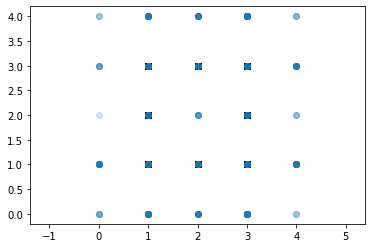

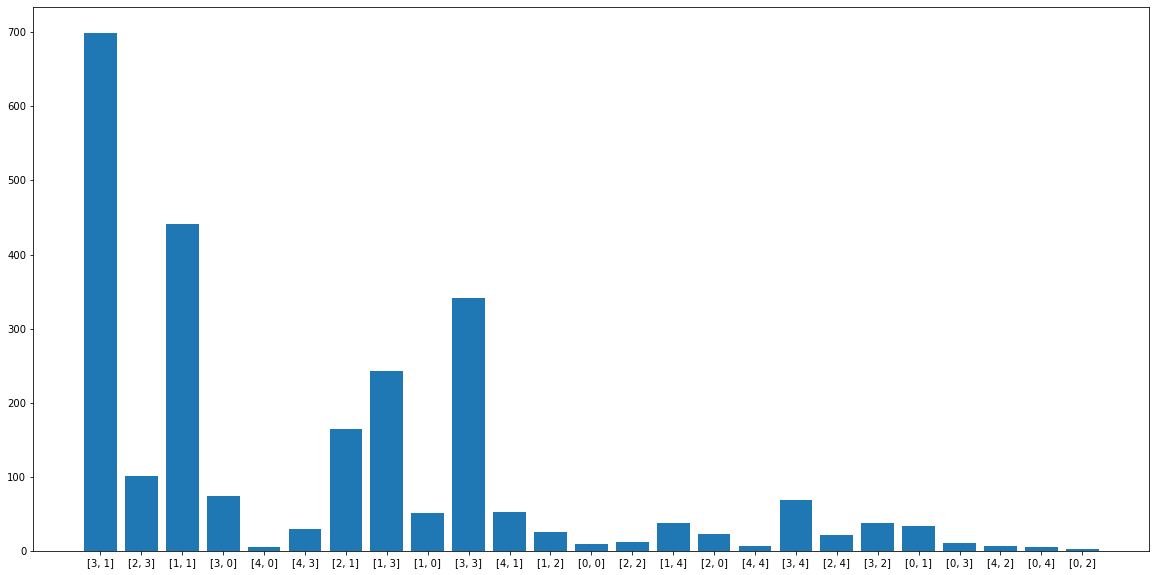

Processing Epoch 27
training start
Iteration 0, d real/fake loss 0.6731361150741577/0.6893088817596436 and g loss is 0.6983428597450256, NDiv loss 0.0432889349758625
Iteration 1, d real/fake loss 0.6729187369346619/0.6915239691734314 and g loss is 0.7003769874572754, NDiv loss 0.04315546900033951
Iteration 2, d real/fake loss 0.6727121472358704/0.6909505128860474 and g loss is 0.6986368298530579, NDiv loss 0.04265055060386658
Iteration 3, d real/fake loss 0.6725130081176758/0.6869263648986816 and g loss is 0.7039530277252197, NDiv loss 0.0456693097949028
Iteration 4, d real/fake loss 0.6723193526268005/0.6890486478805542 and g loss is 0.7010602951049805, NDiv loss 0.047744739800691605


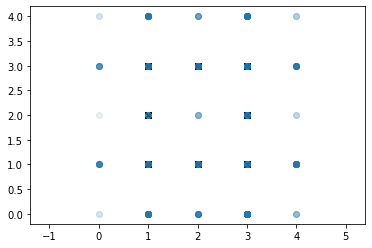

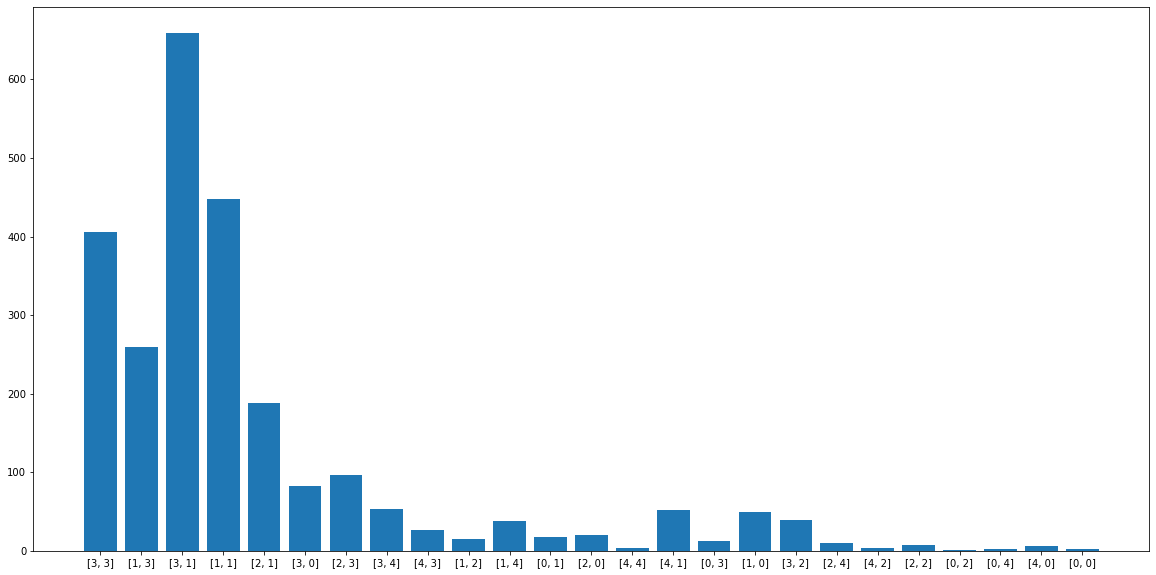

Processing Epoch 28
training start
Iteration 0, d real/fake loss 0.6747807860374451/0.6900417804718018 and g loss is 0.7002783417701721, NDiv loss 0.047626934945583344
Iteration 1, d real/fake loss 0.6746170520782471/0.6876657009124756 and g loss is 0.6944129467010498, NDiv loss 0.045606307685375214
Iteration 2, d real/fake loss 0.674445390701294/0.6905169486999512 and g loss is 0.6958460807800293, NDiv loss 0.04816208779811859
Iteration 3, d real/fake loss 0.6742762923240662/0.688259482383728 and g loss is 0.6963794231414795, NDiv loss 0.05140223726630211
Iteration 4, d real/fake loss 0.6741039156913757/0.6908433437347412 and g loss is 0.6966837048530579, NDiv loss 0.043308913707733154


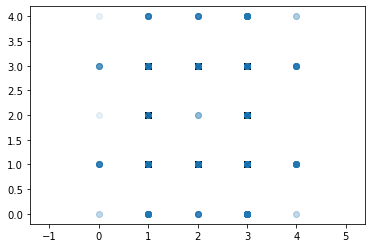

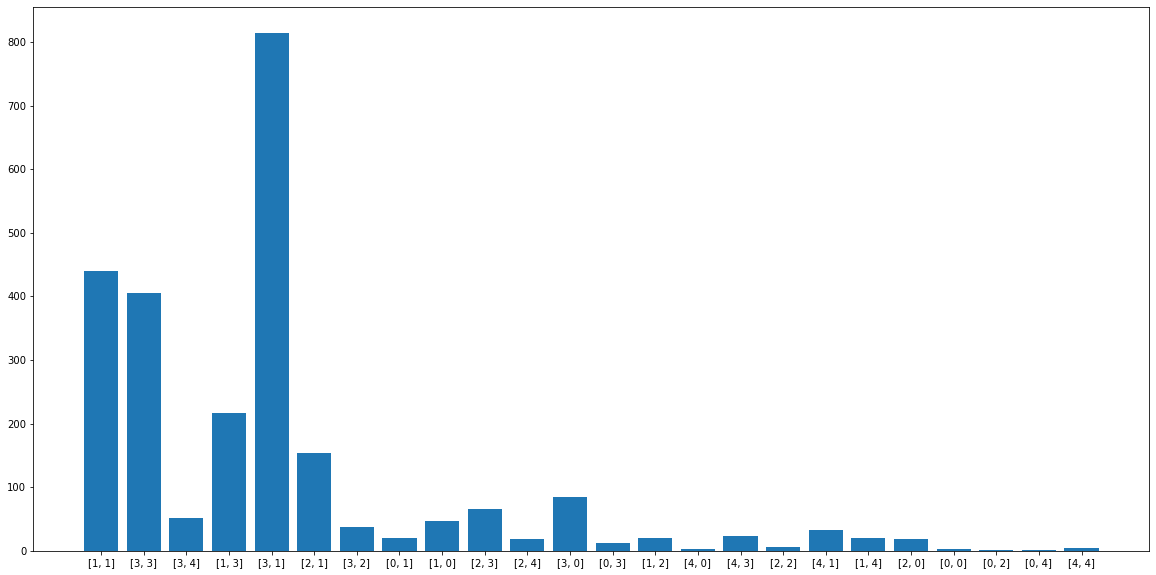

Processing Epoch 29
training start
Iteration 0, d real/fake loss 0.6726825833320618/0.6896094083786011 and g loss is 0.6948293447494507, NDiv loss 0.04621843248605728
Iteration 1, d real/fake loss 0.6725445985794067/0.6921967267990112 and g loss is 0.6949490308761597, NDiv loss 0.04848335310816765
Iteration 2, d real/fake loss 0.6724244952201843/0.692253589630127 and g loss is 0.6928544044494629, NDiv loss 0.045290056616067886
Iteration 3, d real/fake loss 0.6723161339759827/0.6912957429885864 and g loss is 0.6945523023605347, NDiv loss 0.05334007367491722
Iteration 4, d real/fake loss 0.672225832939148/0.6906697154045105 and g loss is 0.6969345808029175, NDiv loss 0.052154239267110825


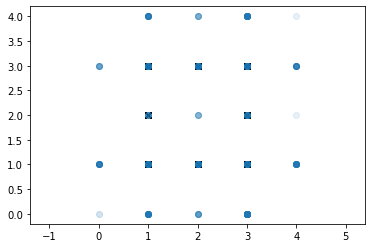

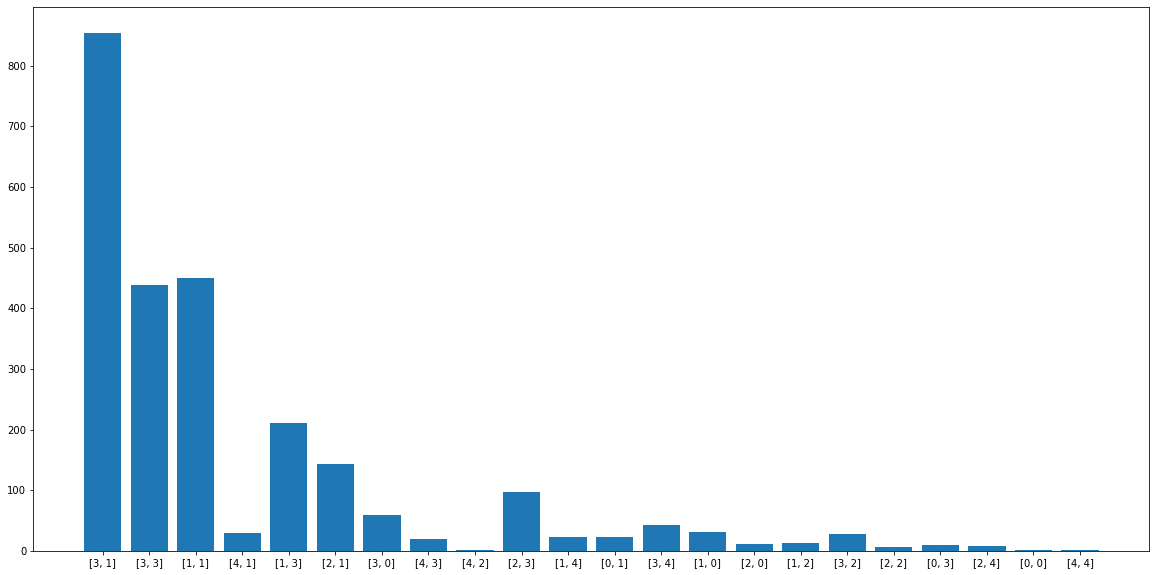

Processing Epoch 30
training start
Iteration 0, d real/fake loss 0.670232892036438/0.6907007098197937 and g loss is 0.6937351226806641, NDiv loss 0.0473267063498497
Iteration 1, d real/fake loss 0.6701737642288208/0.692384660243988 and g loss is 0.6936688423156738, NDiv loss 0.04862486571073532
Iteration 2, d real/fake loss 0.6701070070266724/0.6917126178741455 and g loss is 0.6931082010269165, NDiv loss 0.05266100540757179
Iteration 3, d real/fake loss 0.6700425744056702/0.6929631233215332 and g loss is 0.6949183940887451, NDiv loss 0.051287487149238586
Iteration 4, d real/fake loss 0.6699839234352112/0.693498969078064 and g loss is 0.6953603029251099, NDiv loss 0.051898423582315445


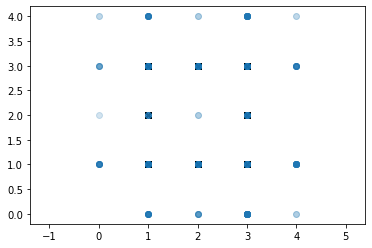

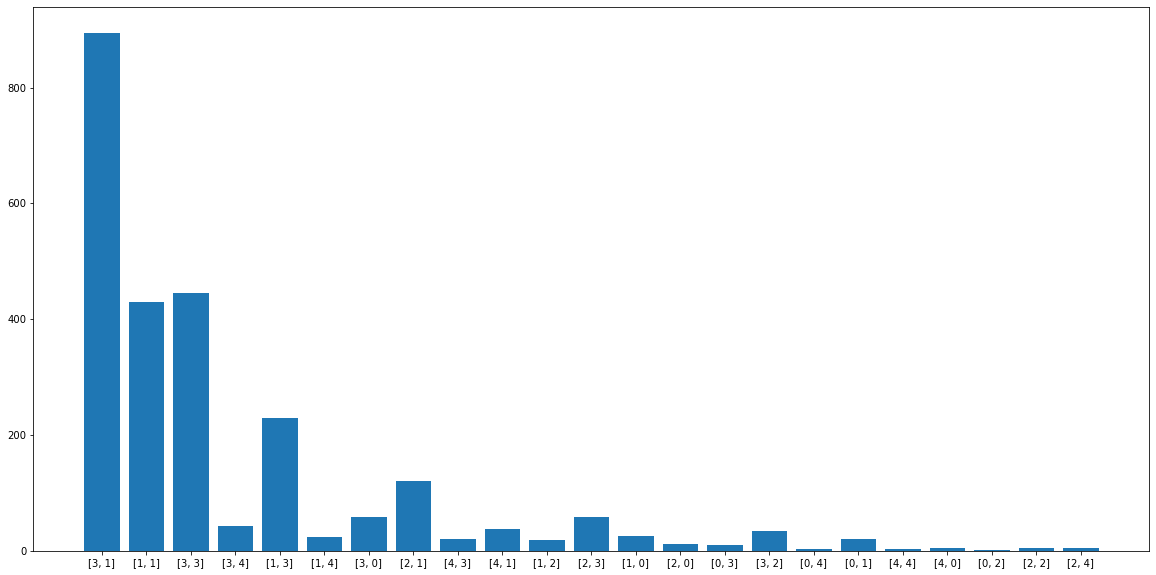

Processing Epoch 31
training start
Iteration 0, d real/fake loss 0.6710111498832703/0.6937465667724609 and g loss is 0.6946853399276733, NDiv loss 0.046464577317237854
Iteration 1, d real/fake loss 0.6709185242652893/0.6933245658874512 and g loss is 0.6943994164466858, NDiv loss 0.04844684898853302
Iteration 2, d real/fake loss 0.6708387136459351/0.6926443576812744 and g loss is 0.6934618949890137, NDiv loss 0.057928286492824554
Iteration 3, d real/fake loss 0.6707648038864136/0.6926277875900269 and g loss is 0.6946328282356262, NDiv loss 0.050544265657663345
Iteration 4, d real/fake loss 0.6706945300102234/0.693145751953125 and g loss is 0.6939651370048523, NDiv loss 0.05300343036651611


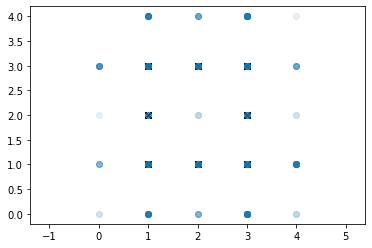

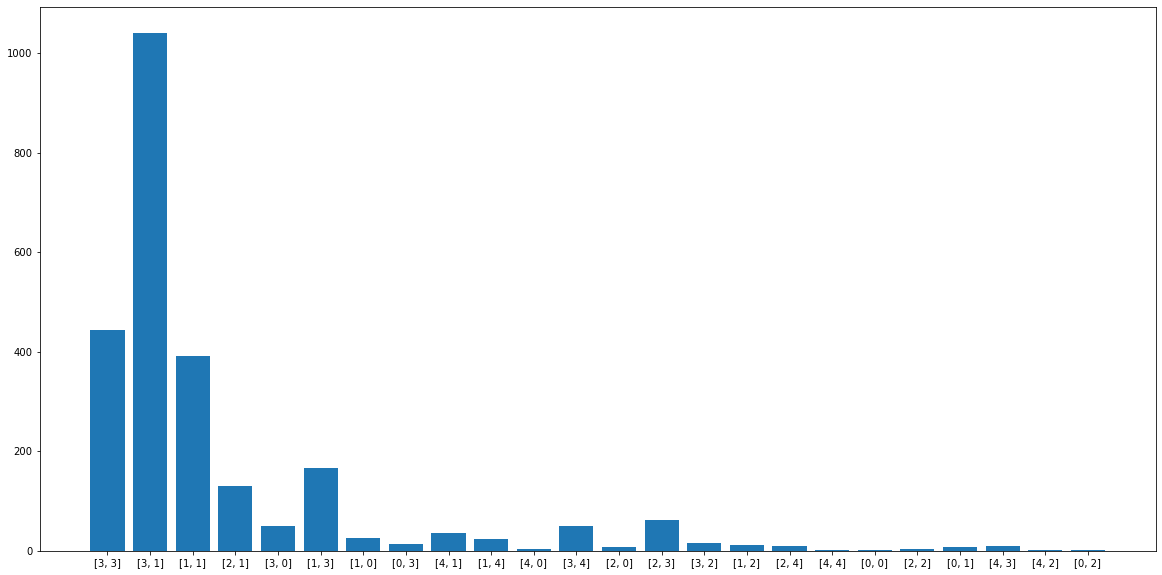

Processing Epoch 32
training start
Iteration 0, d real/fake loss 0.6720571517944336/0.6935511827468872 and g loss is 0.69211745262146, NDiv loss 0.05862574279308319
Iteration 1, d real/fake loss 0.6720019578933716/0.6920416355133057 and g loss is 0.6936942338943481, NDiv loss 0.06439825892448425
Iteration 2, d real/fake loss 0.6719321012496948/0.6928796768188477 and g loss is 0.6908878087997437, NDiv loss 0.053505752235651016
Iteration 3, d real/fake loss 0.6718652248382568/0.690714418888092 and g loss is 0.6947154998779297, NDiv loss 0.05086126551032066
Iteration 4, d real/fake loss 0.6717881560325623/0.6945188641548157 and g loss is 0.694953203201294, NDiv loss 0.05721427872776985


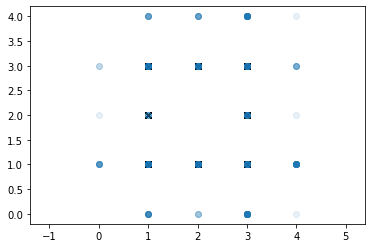

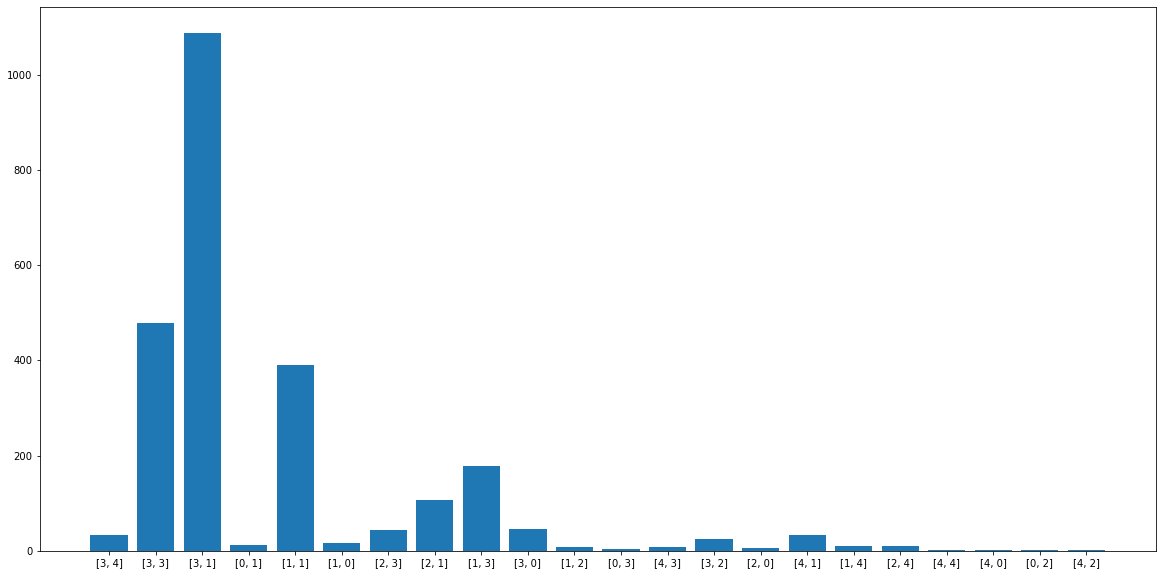

Processing Epoch 33
training start
Iteration 0, d real/fake loss 0.6708869934082031/0.6925971508026123 and g loss is 0.6939327716827393, NDiv loss 0.0594867467880249
Iteration 1, d real/fake loss 0.6708896160125732/0.6951428055763245 and g loss is 0.6926813125610352, NDiv loss 0.05122600868344307
Iteration 2, d real/fake loss 0.6708962917327881/0.696190595626831 and g loss is 0.6921660900115967, NDiv loss 0.05839834362268448
Iteration 3, d real/fake loss 0.6709139943122864/0.6936451196670532 and g loss is 0.6936905384063721, NDiv loss 0.058774590492248535
Iteration 4, d real/fake loss 0.6709417104721069/0.6930267810821533 and g loss is 0.6945719122886658, NDiv loss 0.05912387743592262


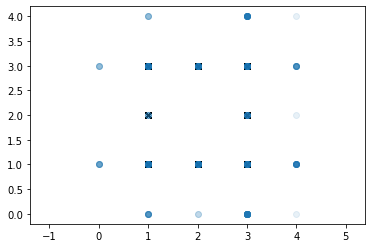

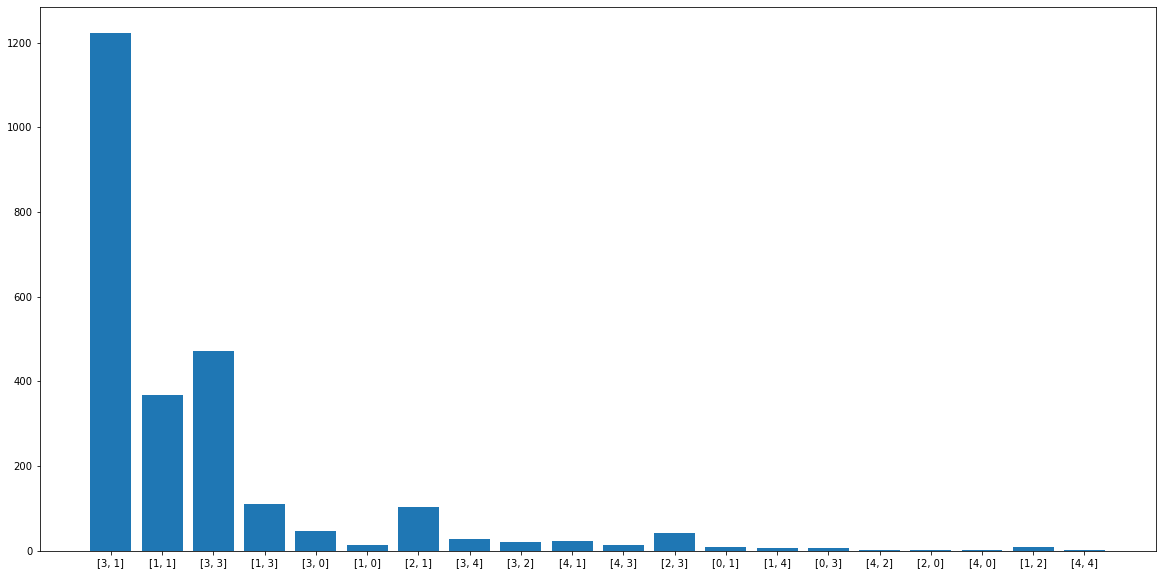

Processing Epoch 34
training start
Iteration 0, d real/fake loss 0.6714599132537842/0.6923043727874756 and g loss is 0.695423424243927, NDiv loss 0.06652738898992538
Iteration 1, d real/fake loss 0.6715151071548462/0.6923654079437256 and g loss is 0.6946322917938232, NDiv loss 0.06269272416830063
Iteration 2, d real/fake loss 0.6715768575668335/0.6920765042304993 and g loss is 0.6957617998123169, NDiv loss 0.059812068939208984
Iteration 3, d real/fake loss 0.6716480255126953/0.6886940002441406 and g loss is 0.6956992149353027, NDiv loss 0.06621024012565613
Iteration 4, d real/fake loss 0.6717174649238586/0.6927616000175476 and g loss is 0.6946921348571777, NDiv loss 0.06568531692028046


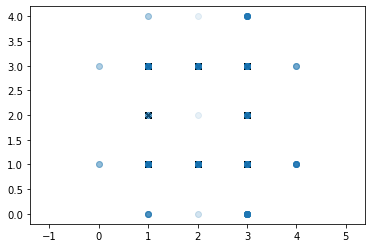

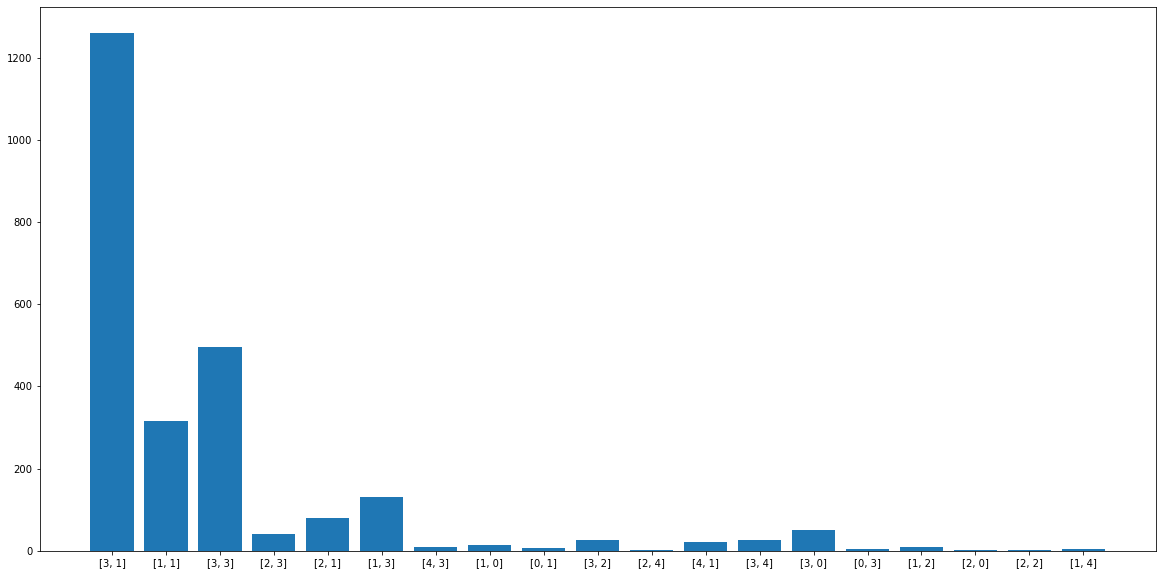

Processing Epoch 35
training start
Iteration 0, d real/fake loss 0.6709733009338379/0.6897172331809998 and g loss is 0.6956514120101929, NDiv loss 0.06366976350545883
Iteration 1, d real/fake loss 0.6709917187690735/0.6886202692985535 and g loss is 0.6966599822044373, NDiv loss 0.06253978610038757
Iteration 2, d real/fake loss 0.6710072755813599/0.6911154985427856 and g loss is 0.6966642141342163, NDiv loss 0.0603175088763237
Iteration 3, d real/fake loss 0.6710219979286194/0.6884021162986755 and g loss is 0.697932243347168, NDiv loss 0.06061200797557831
Iteration 4, d real/fake loss 0.671034574508667/0.6883227229118347 and g loss is 0.6985212564468384, NDiv loss 0.06067001819610596


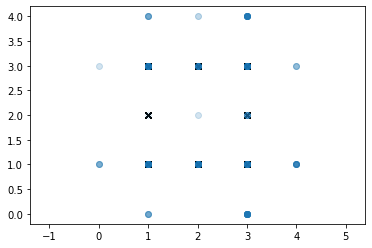

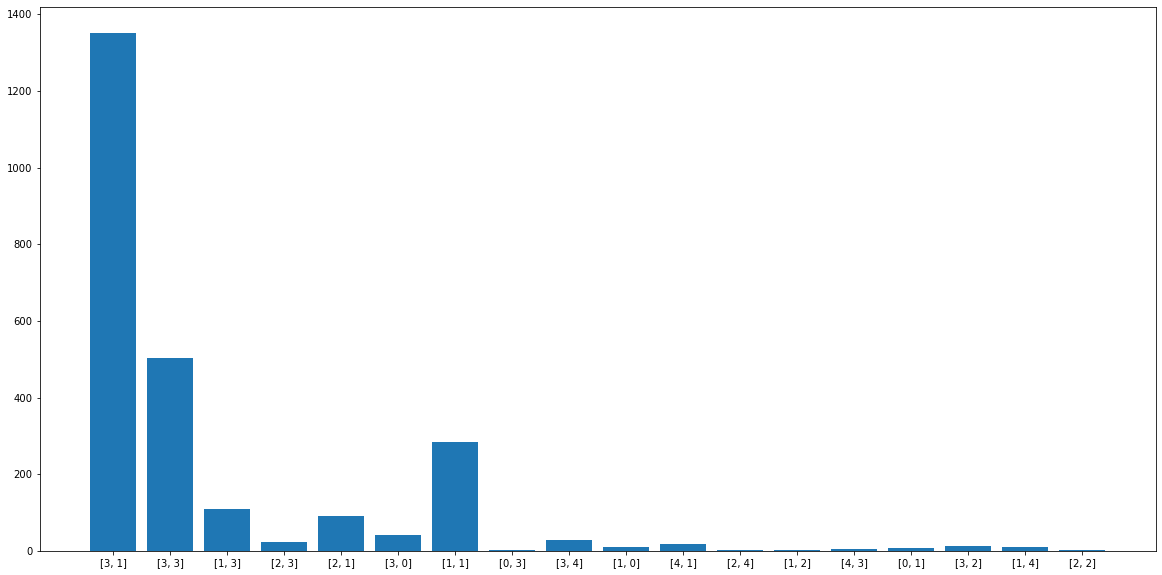

Processing Epoch 36
training start
Iteration 0, d real/fake loss 0.6723260283470154/0.6879032850265503 and g loss is 0.696967601776123, NDiv loss 0.06912704557180405
Iteration 1, d real/fake loss 0.6723916530609131/0.6891487836837769 and g loss is 0.697236180305481, NDiv loss 0.06779156625270844
Iteration 2, d real/fake loss 0.6724635362625122/0.6872056126594543 and g loss is 0.6987003087997437, NDiv loss 0.0669124647974968
Iteration 3, d real/fake loss 0.6725358963012695/0.687462568283081 and g loss is 0.6980702877044678, NDiv loss 0.06787334382534027
Iteration 4, d real/fake loss 0.6726075410842896/0.6864771842956543 and g loss is 0.6997050046920776, NDiv loss 0.07048349827528


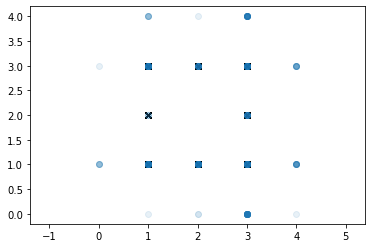

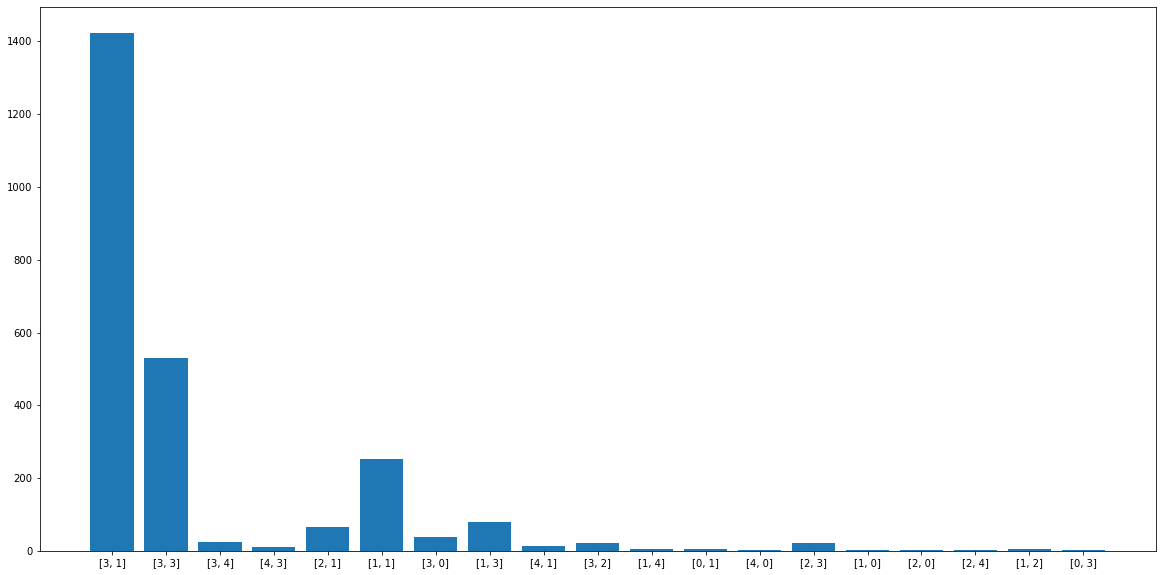

Processing Epoch 37
training start
Iteration 0, d real/fake loss 0.6724072694778442/0.6852861642837524 and g loss is 0.7008000612258911, NDiv loss 0.0642593652009964
Iteration 1, d real/fake loss 0.6724645495414734/0.6848876476287842 and g loss is 0.7017385363578796, NDiv loss 0.06897474080324173
Iteration 2, d real/fake loss 0.6725157499313354/0.685029923915863 and g loss is 0.7013932466506958, NDiv loss 0.07099542766809464
Iteration 3, d real/fake loss 0.6725599765777588/0.6866518259048462 and g loss is 0.7012947797775269, NDiv loss 0.07545141130685806
Iteration 4, d real/fake loss 0.6726014018058777/0.6851763725280762 and g loss is 0.7014678120613098, NDiv loss 0.07365632802248001


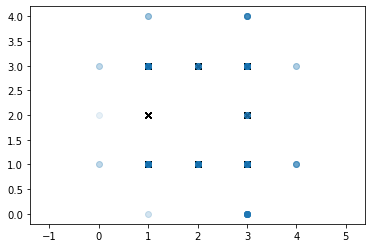

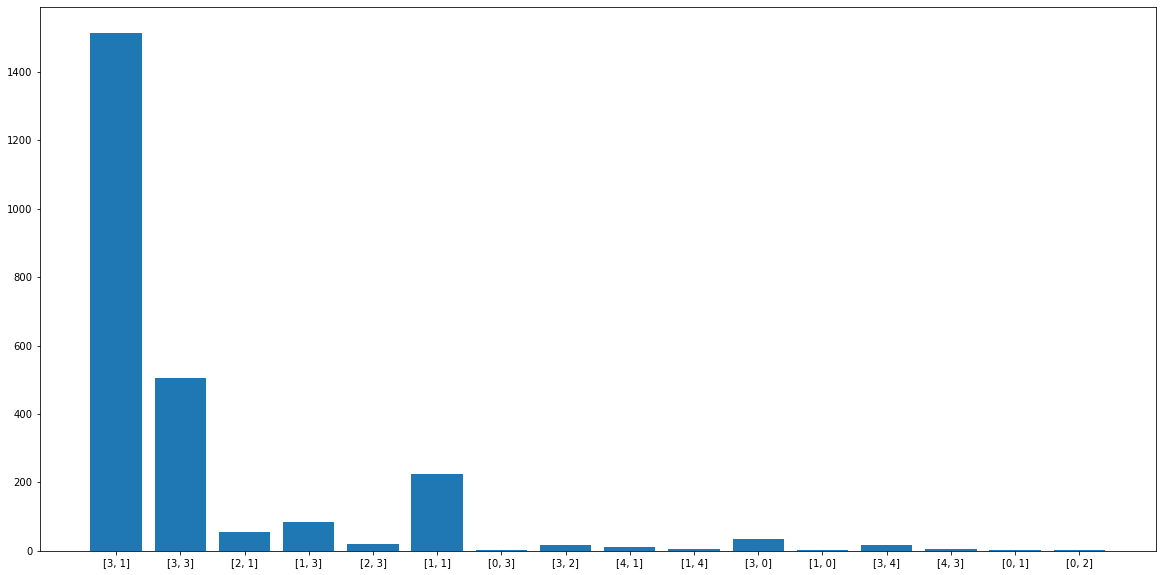

Processing Epoch 38
training start
Iteration 0, d real/fake loss 0.6709075570106506/0.6841877698898315 and g loss is 0.7031210660934448, NDiv loss 0.0711628794670105
Iteration 1, d real/fake loss 0.6709595918655396/0.6844891309738159 and g loss is 0.7043969035148621, NDiv loss 0.06904037296772003
Iteration 2, d real/fake loss 0.671012818813324/0.6833814382553101 and g loss is 0.7030406594276428, NDiv loss 0.07189717888832092
Iteration 3, d real/fake loss 0.6710642576217651/0.6844131350517273 and g loss is 0.7064806222915649, NDiv loss 0.07606741040945053
Iteration 4, d real/fake loss 0.6711087822914124/0.6833224296569824 and g loss is 0.7044289112091064, NDiv loss 0.07245214283466339


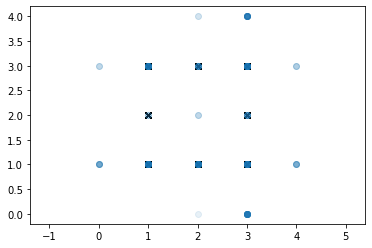

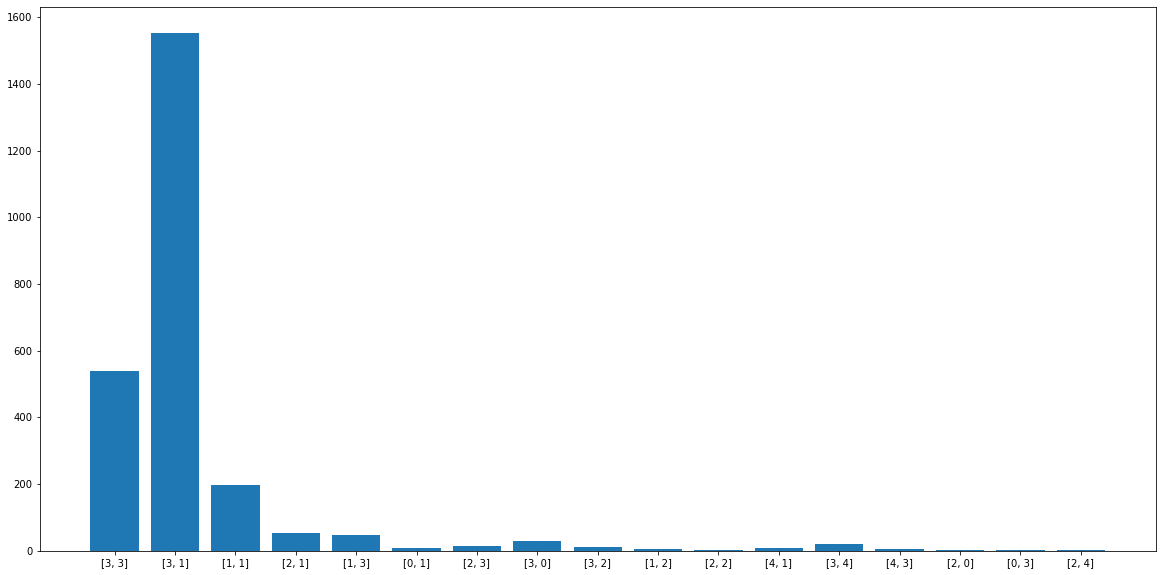

Processing Epoch 39
training start
Iteration 0, d real/fake loss 0.6734931468963623/0.680233359336853 and g loss is 0.7060155868530273, NDiv loss 0.07852986454963684
Iteration 1, d real/fake loss 0.6735889911651611/0.6814670562744141 and g loss is 0.7051970958709717, NDiv loss 0.08118729293346405
Iteration 2, d real/fake loss 0.6736847162246704/0.6799333691596985 and g loss is 0.7066037058830261, NDiv loss 0.07362906634807587
Iteration 3, d real/fake loss 0.6737818717956543/0.6798056364059448 and g loss is 0.7056781053543091, NDiv loss 0.07627743482589722
Iteration 4, d real/fake loss 0.6738734841346741/0.6812416315078735 and g loss is 0.7088173627853394, NDiv loss 0.07636342942714691


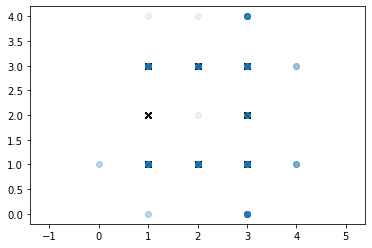

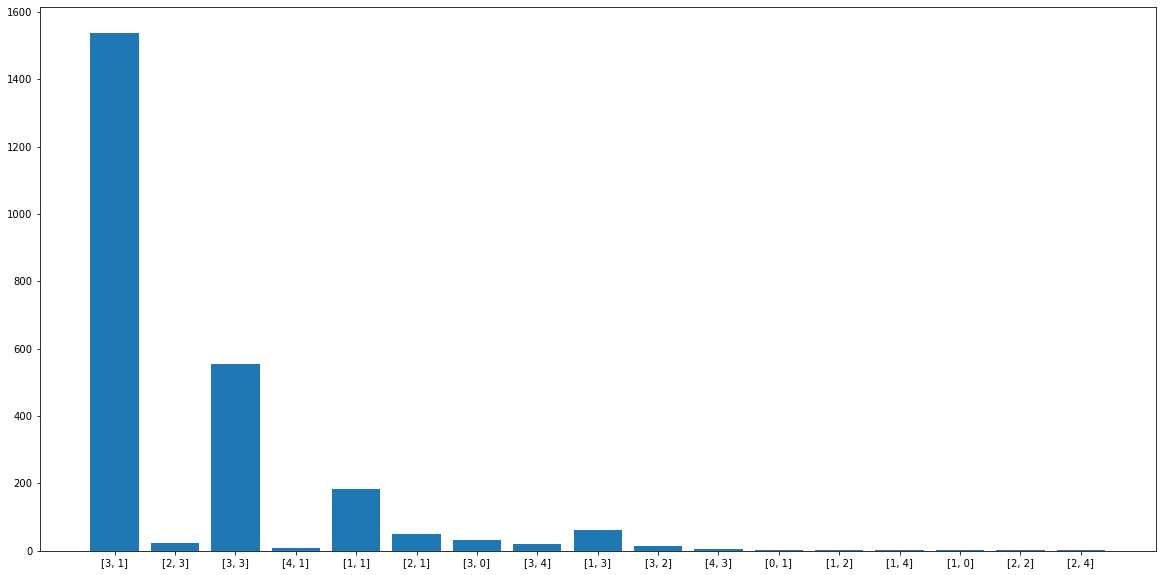

Processing Epoch 40
training start
Iteration 0, d real/fake loss 0.6755896806716919/0.6779531240463257 and g loss is 0.7088319659233093, NDiv loss 0.0803682804107666
Iteration 1, d real/fake loss 0.6756939888000488/0.6784784197807312 and g loss is 0.709537148475647, NDiv loss 0.0724758729338646
Iteration 2, d real/fake loss 0.675789475440979/0.6783307790756226 and g loss is 0.7094863653182983, NDiv loss 0.07683795690536499
Iteration 3, d real/fake loss 0.6758714914321899/0.6770654320716858 and g loss is 0.7099952101707458, NDiv loss 0.07895161211490631
Iteration 4, d real/fake loss 0.6759399771690369/0.6758807301521301 and g loss is 0.7122408747673035, NDiv loss 0.08423550426959991


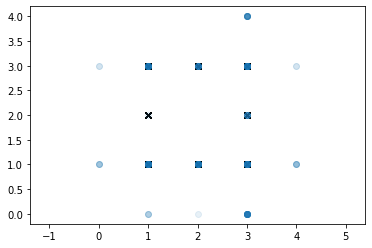

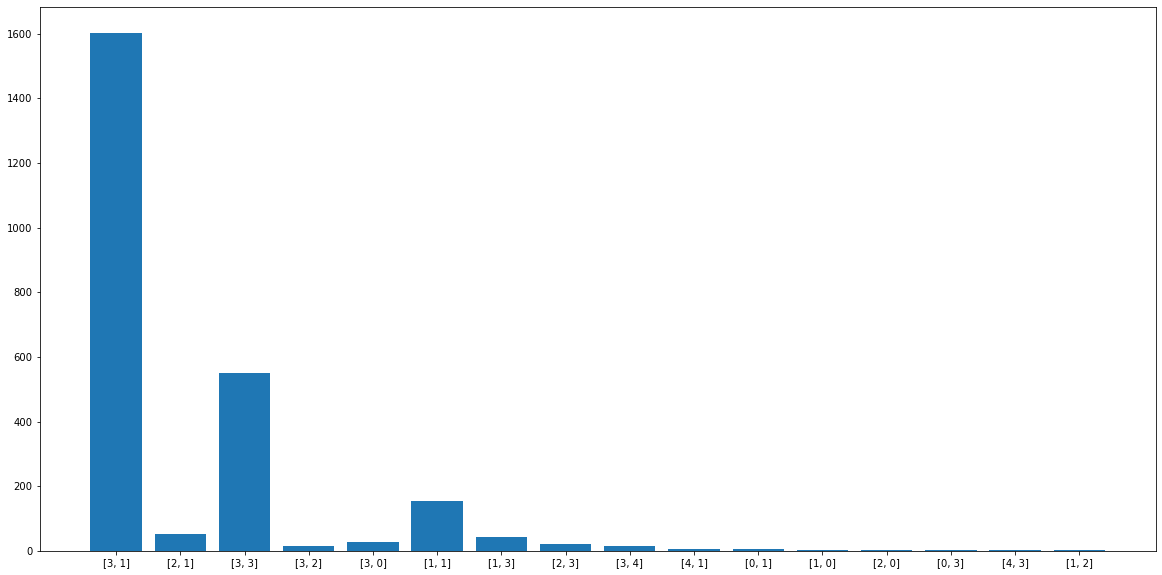

Processing Epoch 41
training start
Iteration 0, d real/fake loss 0.6737841367721558/0.6759572625160217 and g loss is 0.7122278213500977, NDiv loss 0.09370817989110947
Iteration 1, d real/fake loss 0.6737203598022461/0.6758994460105896 and g loss is 0.7119088172912598, NDiv loss 0.07878207415342331
Iteration 2, d real/fake loss 0.6736572980880737/0.6741433143615723 and g loss is 0.715356707572937, NDiv loss 0.0858086496591568
Iteration 3, d real/fake loss 0.673586368560791/0.6739846467971802 and g loss is 0.716457724571228, NDiv loss 0.09666106104850769
Iteration 4, d real/fake loss 0.6735063195228577/0.6729381680488586 and g loss is 0.7152383327484131, NDiv loss 0.08306539803743362


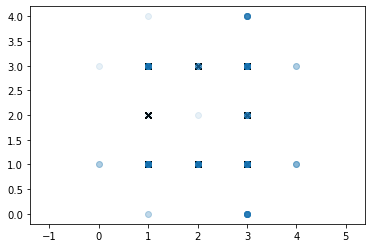

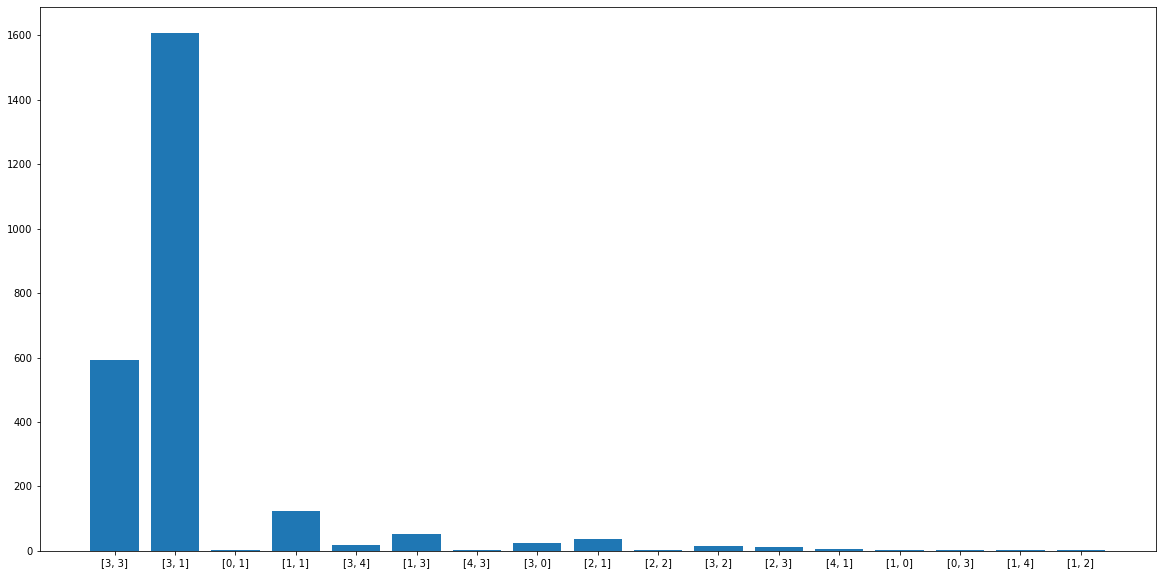

Processing Epoch 42
training start
Iteration 0, d real/fake loss 0.6730213165283203/0.6735447645187378 and g loss is 0.7152390480041504, NDiv loss 0.08893835544586182
Iteration 1, d real/fake loss 0.6729710102081299/0.6720215678215027 and g loss is 0.7159754037857056, NDiv loss 0.08027517795562744
Iteration 2, d real/fake loss 0.6729006767272949/0.6692688465118408 and g loss is 0.717643678188324, NDiv loss 0.08673573285341263
Iteration 3, d real/fake loss 0.6728156805038452/0.6699525117874146 and g loss is 0.7176311612129211, NDiv loss 0.08276048302650452
Iteration 4, d real/fake loss 0.6727218627929688/0.6685757040977478 and g loss is 0.7177500128746033, NDiv loss 0.08651889860630035


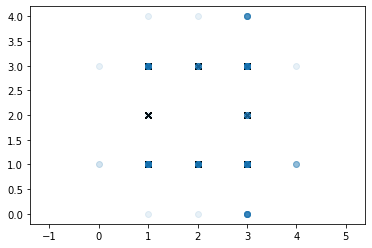

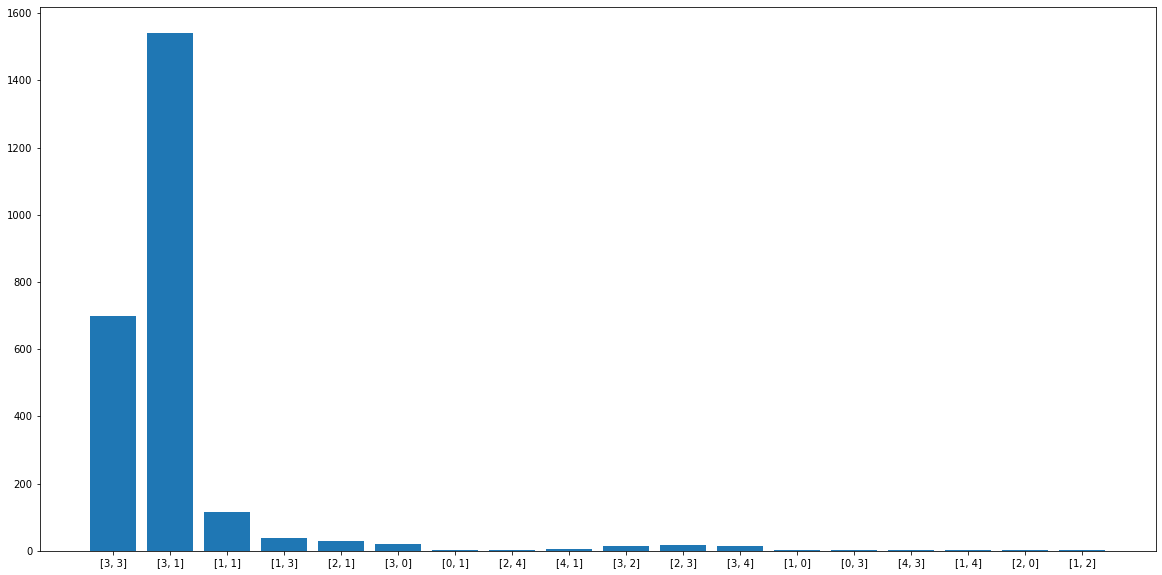

Processing Epoch 43
training start
Iteration 0, d real/fake loss 0.6749675273895264/0.6691545248031616 and g loss is 0.7197781801223755, NDiv loss 0.09794386476278305
Iteration 1, d real/fake loss 0.6749039888381958/0.6685402393341064 and g loss is 0.7214130163192749, NDiv loss 0.08582980185747147
Iteration 2, d real/fake loss 0.6748315095901489/0.6671010255813599 and g loss is 0.720736026763916, NDiv loss 0.08635955303907394
Iteration 3, d real/fake loss 0.674747109413147/0.666057825088501 and g loss is 0.7195450663566589, NDiv loss 0.08151768893003464
Iteration 4, d real/fake loss 0.6746505498886108/0.6679068803787231 and g loss is 0.722318172454834, NDiv loss 0.08778119087219238


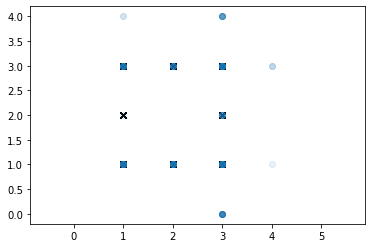

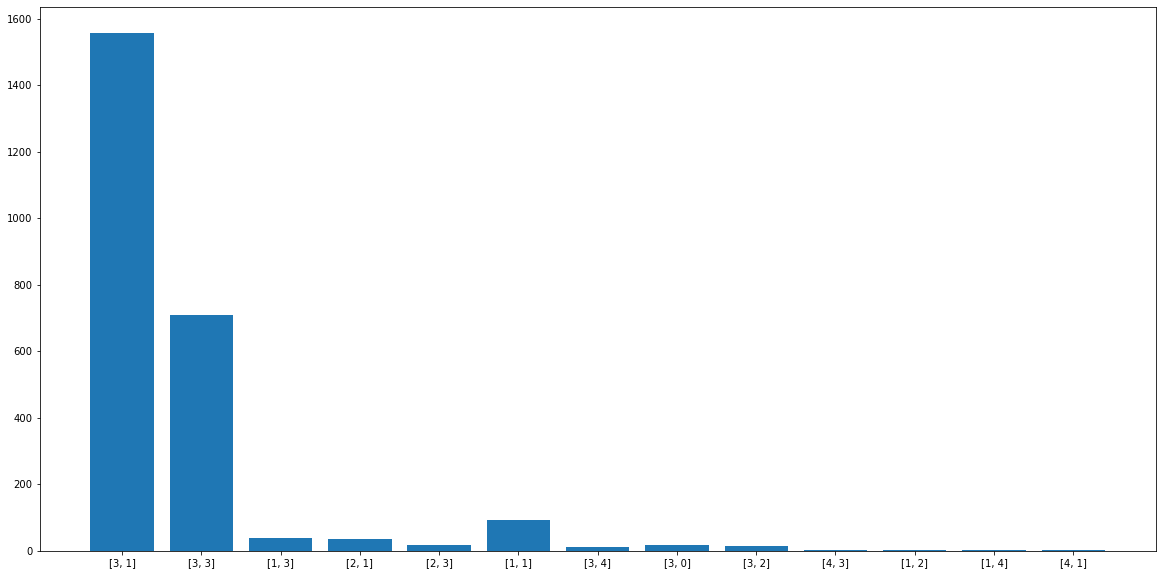

Processing Epoch 44
training start
Iteration 0, d real/fake loss 0.6744611263275146/0.6674866676330566 and g loss is 0.7231775522232056, NDiv loss 0.08605882525444031
Iteration 1, d real/fake loss 0.6743524074554443/0.664314866065979 and g loss is 0.7222901582717896, NDiv loss 0.08441299945116043
Iteration 2, d real/fake loss 0.6742336750030518/0.6654635071754456 and g loss is 0.7231102585792542, NDiv loss 0.08853252232074738
Iteration 3, d real/fake loss 0.6741031408309937/0.6643198728561401 and g loss is 0.7281484007835388, NDiv loss 0.08566518872976303
Iteration 4, d real/fake loss 0.6739633083343506/0.6623026132583618 and g loss is 0.7270388007164001, NDiv loss 0.09034693986177444


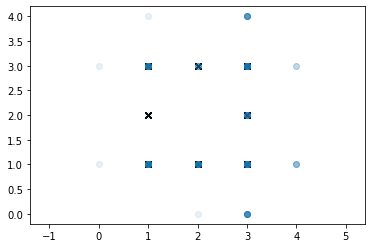

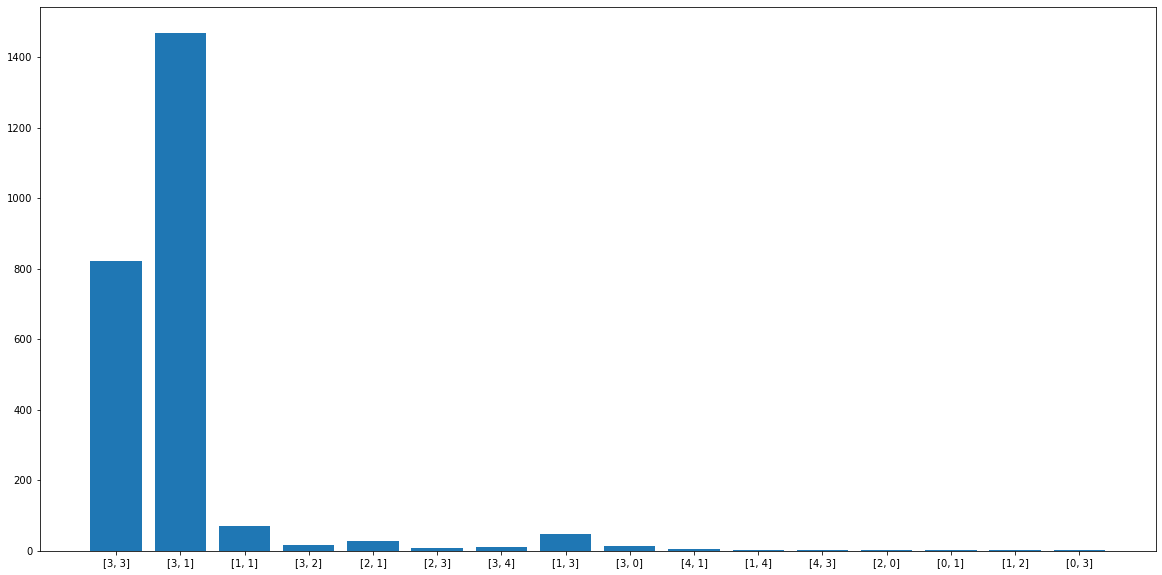

Processing Epoch 45
training start
Iteration 0, d real/fake loss 0.675006628036499/0.6620426774024963 and g loss is 0.7255337834358215, NDiv loss 0.08373913913965225
Iteration 1, d real/fake loss 0.6749234795570374/0.6631717681884766 and g loss is 0.7247980833053589, NDiv loss 0.09658434242010117
Iteration 2, d real/fake loss 0.6748319864273071/0.6607409715652466 and g loss is 0.7243459224700928, NDiv loss 0.09076052159070969
Iteration 3, d real/fake loss 0.6747378706932068/0.6607698202133179 and g loss is 0.7263609170913696, NDiv loss 0.0871606096625328
Iteration 4, d real/fake loss 0.6746317744255066/0.6603201627731323 and g loss is 0.7287074327468872, NDiv loss 0.0836508646607399


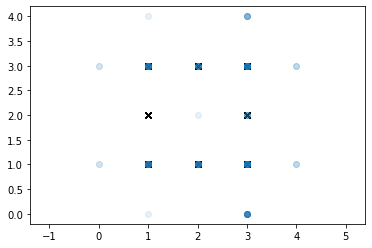

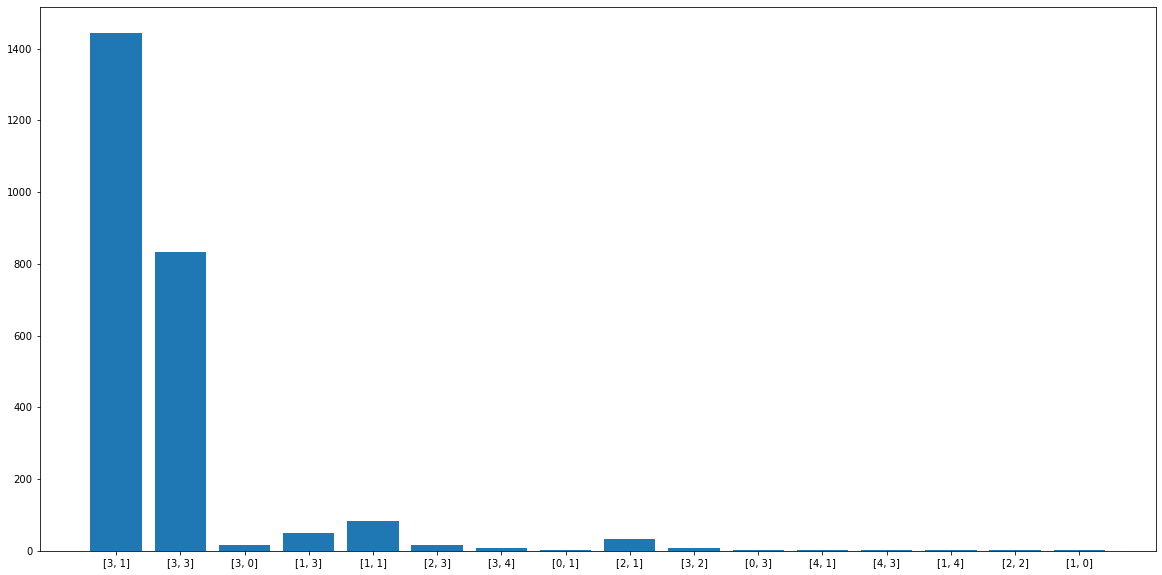

Processing Epoch 46
training start
Iteration 0, d real/fake loss 0.6725950241088867/0.6587314605712891 and g loss is 0.727042555809021, NDiv loss 0.09152941405773163
Iteration 1, d real/fake loss 0.6724022626876831/0.6592024564743042 and g loss is 0.7283598184585571, NDiv loss 0.09081999212503433
Iteration 2, d real/fake loss 0.6721915006637573/0.6589936017990112 and g loss is 0.730109453201294, NDiv loss 0.08702611178159714
Iteration 3, d real/fake loss 0.6719681024551392/0.6599896550178528 and g loss is 0.7301729917526245, NDiv loss 0.089042067527771
Iteration 4, d real/fake loss 0.6717342734336853/0.6574894785881042 and g loss is 0.7283927202224731, NDiv loss 0.09104523807764053


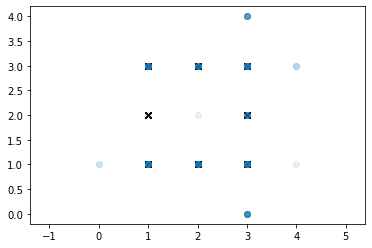

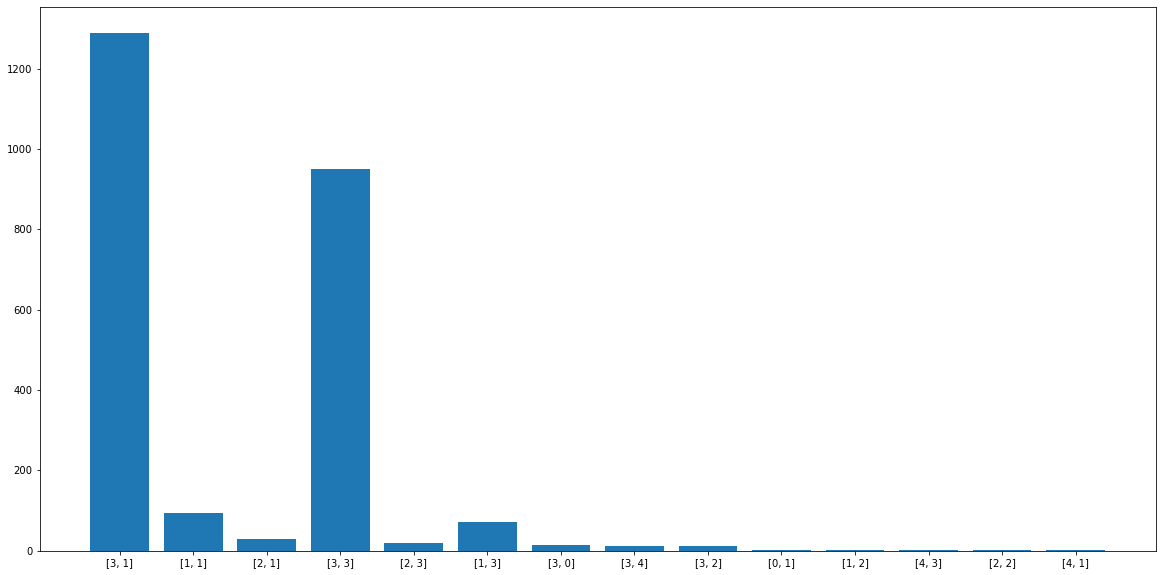

Processing Epoch 47
training start
Iteration 0, d real/fake loss 0.6720873713493347/0.6586849093437195 and g loss is 0.7310371994972229, NDiv loss 0.08252859860658646
Iteration 1, d real/fake loss 0.6718311309814453/0.6580638289451599 and g loss is 0.7319557666778564, NDiv loss 0.08296813815832138
Iteration 2, d real/fake loss 0.6715545654296875/0.6565566062927246 and g loss is 0.7310094833374023, NDiv loss 0.0861978530883789
Iteration 3, d real/fake loss 0.6712619066238403/0.6557555794715881 and g loss is 0.7323381900787354, NDiv loss 0.08117537945508957
Iteration 4, d real/fake loss 0.6709604859352112/0.655229926109314 and g loss is 0.734285831451416, NDiv loss 0.08337342739105225


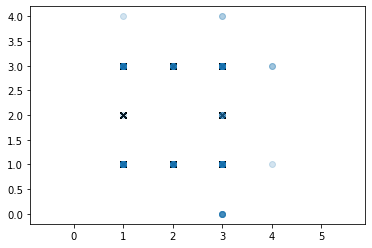

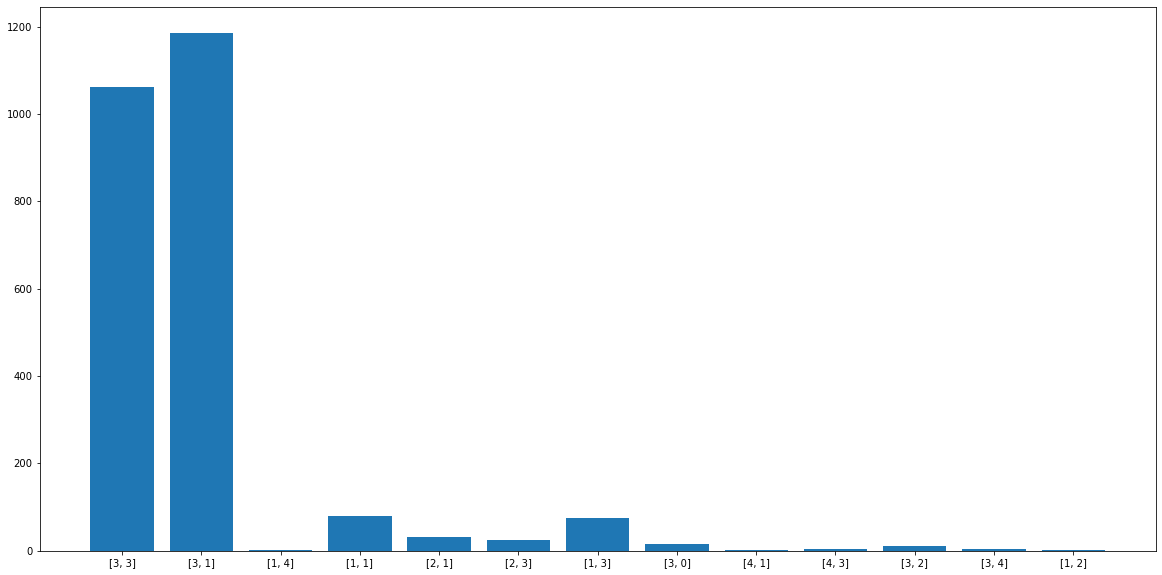

Processing Epoch 48
training start
Iteration 0, d real/fake loss 0.6761852502822876/0.6567977070808411 and g loss is 0.7320765256881714, NDiv loss 0.08426524698734283
Iteration 1, d real/fake loss 0.6760989427566528/0.6577208638191223 and g loss is 0.7321428060531616, NDiv loss 0.08618567138910294
Iteration 2, d real/fake loss 0.6760119795799255/0.6545181274414062 and g loss is 0.7342225313186646, NDiv loss 0.088505819439888
Iteration 3, d real/fake loss 0.675921618938446/0.6554582118988037 and g loss is 0.7339676022529602, NDiv loss 0.08566103875637054
Iteration 4, d real/fake loss 0.6758280396461487/0.6566175818443298 and g loss is 0.7336351871490479, NDiv loss 0.08363185077905655


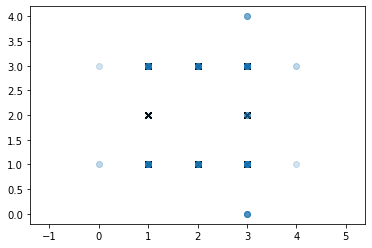

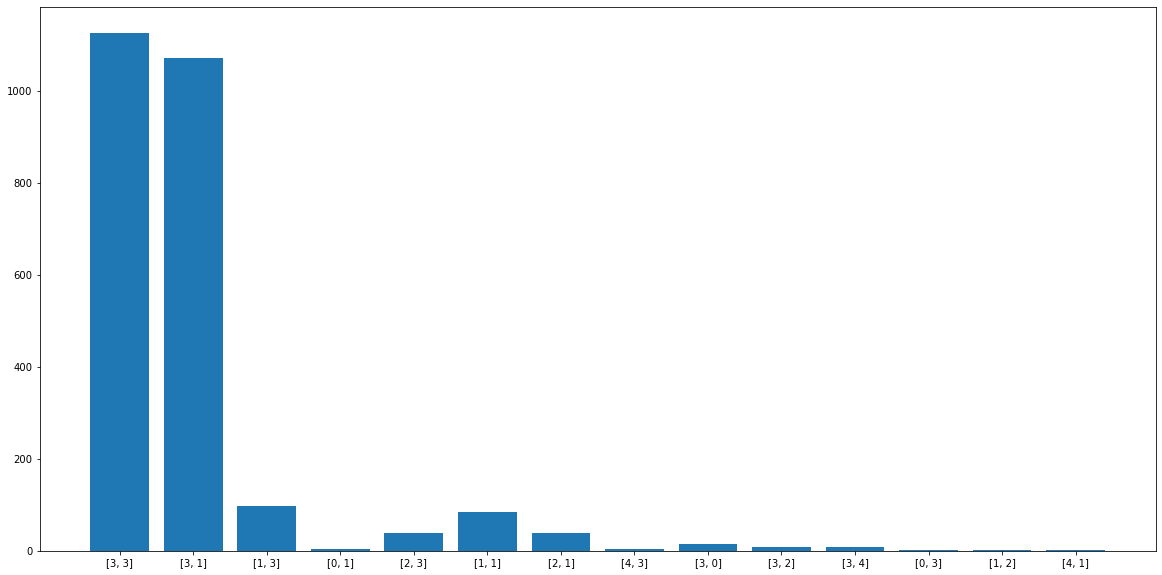

Processing Epoch 49
training start
Iteration 0, d real/fake loss 0.673750102519989/0.6554992198944092 and g loss is 0.7335920333862305, NDiv loss 0.0901927798986435
Iteration 1, d real/fake loss 0.6735798716545105/0.6548992991447449 and g loss is 0.7331475615501404, NDiv loss 0.08111853897571564
Iteration 2, d real/fake loss 0.6733922362327576/0.656291127204895 and g loss is 0.7337737083435059, NDiv loss 0.07770290970802307
Iteration 3, d real/fake loss 0.673189640045166/0.653917670249939 and g loss is 0.7321292161941528, NDiv loss 0.08032799512147903
Iteration 4, d real/fake loss 0.6729702949523926/0.6583154201507568 and g loss is 0.731787383556366, NDiv loss 0.08050418645143509


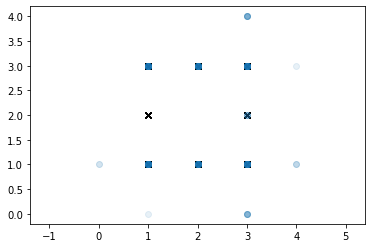

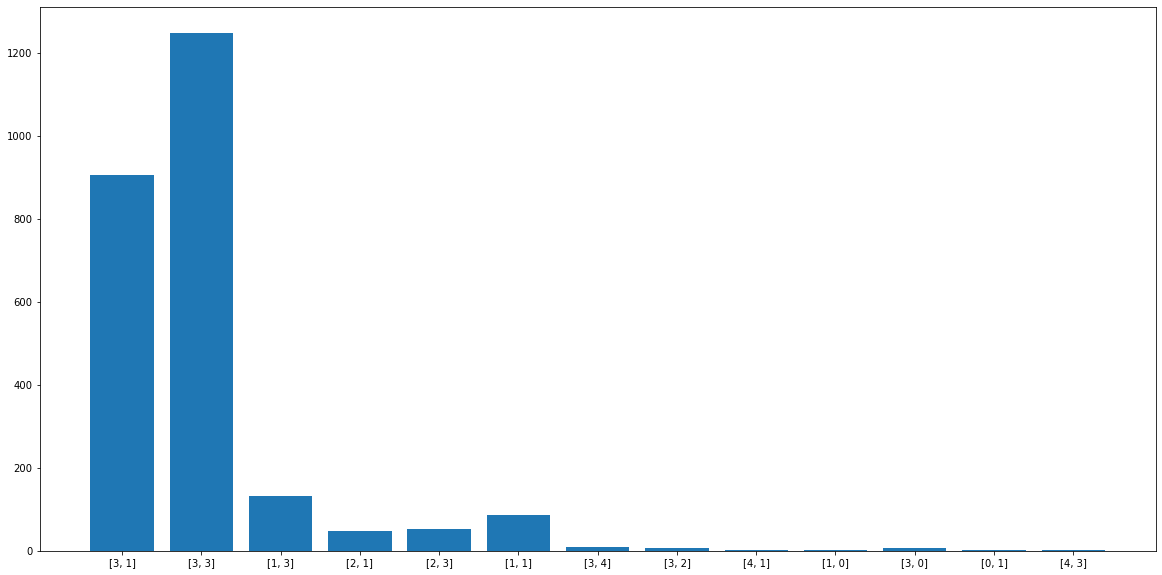

Processing Epoch 50
training start
Iteration 0, d real/fake loss 0.6717485189437866/0.6573235988616943 and g loss is 0.7340759038925171, NDiv loss 0.08937867730855942
Iteration 1, d real/fake loss 0.6715065240859985/0.6564124226570129 and g loss is 0.7296894788742065, NDiv loss 0.08425521105527878
Iteration 2, d real/fake loss 0.671256422996521/0.6579965353012085 and g loss is 0.7329668998718262, NDiv loss 0.08421910554170609
Iteration 3, d real/fake loss 0.6710024476051331/0.6538754105567932 and g loss is 0.7319641709327698, NDiv loss 0.08310291171073914
Iteration 4, d real/fake loss 0.6707407236099243/0.6568257808685303 and g loss is 0.7339117527008057, NDiv loss 0.07579604536294937


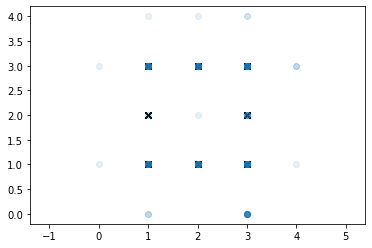

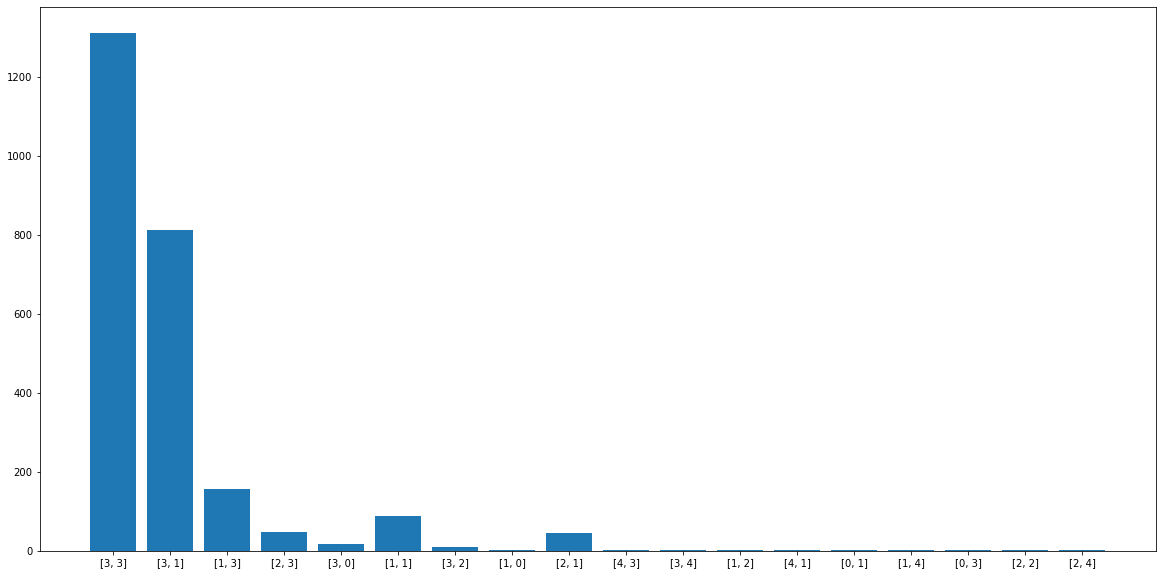

Processing Epoch 51
training start
Iteration 0, d real/fake loss 0.6606727838516235/0.6564314365386963 and g loss is 0.7323697209358215, NDiv loss 0.0764274075627327
Iteration 1, d real/fake loss 0.660330057144165/0.6560208797454834 and g loss is 0.7264772057533264, NDiv loss 0.08104357868432999
Iteration 2, d real/fake loss 0.6599887013435364/0.6550046801567078 and g loss is 0.7308388948440552, NDiv loss 0.0839967429637909
Iteration 3, d real/fake loss 0.6596406698226929/0.6602578163146973 and g loss is 0.7298449277877808, NDiv loss 0.08073742687702179
Iteration 4, d real/fake loss 0.6592947840690613/0.6568688154220581 and g loss is 0.728590726852417, NDiv loss 0.07798933982849121


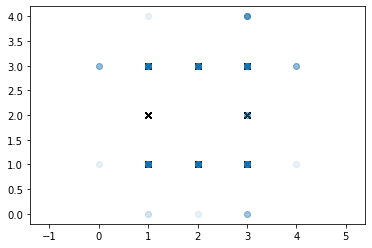

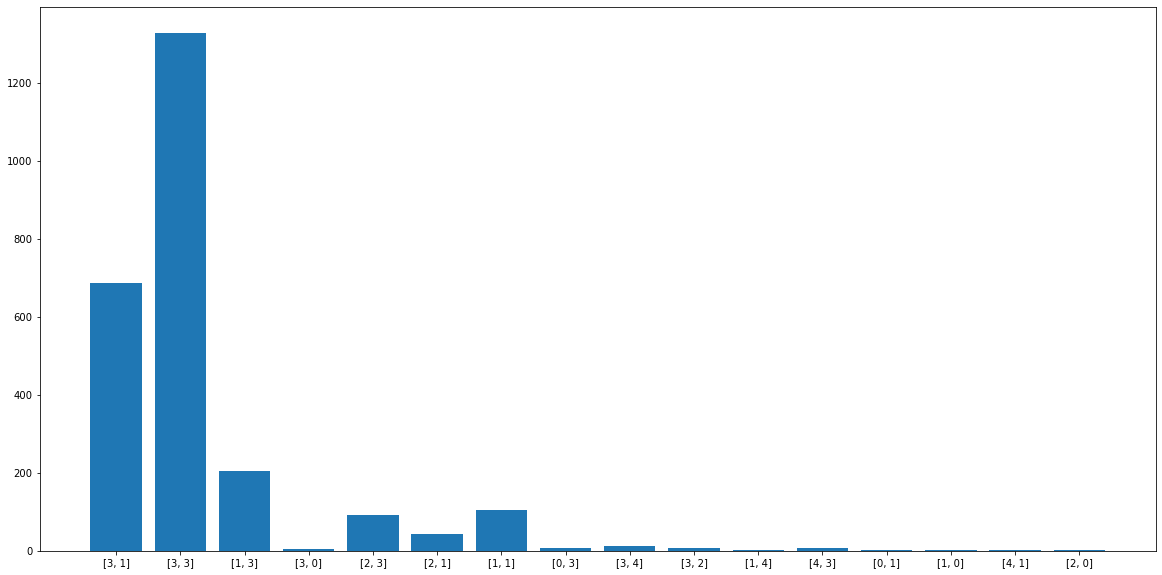

Processing Epoch 52
training start
Iteration 0, d real/fake loss 0.6597456336021423/0.6622030735015869 and g loss is 0.7277746200561523, NDiv loss 0.07673530280590057
Iteration 1, d real/fake loss 0.6593992710113525/0.6601442098617554 and g loss is 0.7286213040351868, NDiv loss 0.07432672381401062
Iteration 2, d real/fake loss 0.6590513586997986/0.6629756689071655 and g loss is 0.7293382287025452, NDiv loss 0.08592112362384796
Iteration 3, d real/fake loss 0.6587015390396118/0.6609014272689819 and g loss is 0.7258045673370361, NDiv loss 0.07142066955566406
Iteration 4, d real/fake loss 0.6583546996116638/0.6624239087104797 and g loss is 0.7280908823013306, NDiv loss 0.07244667410850525


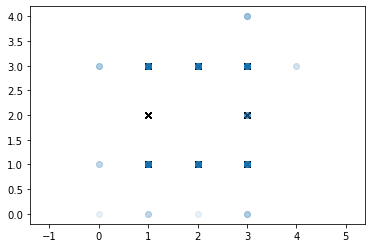

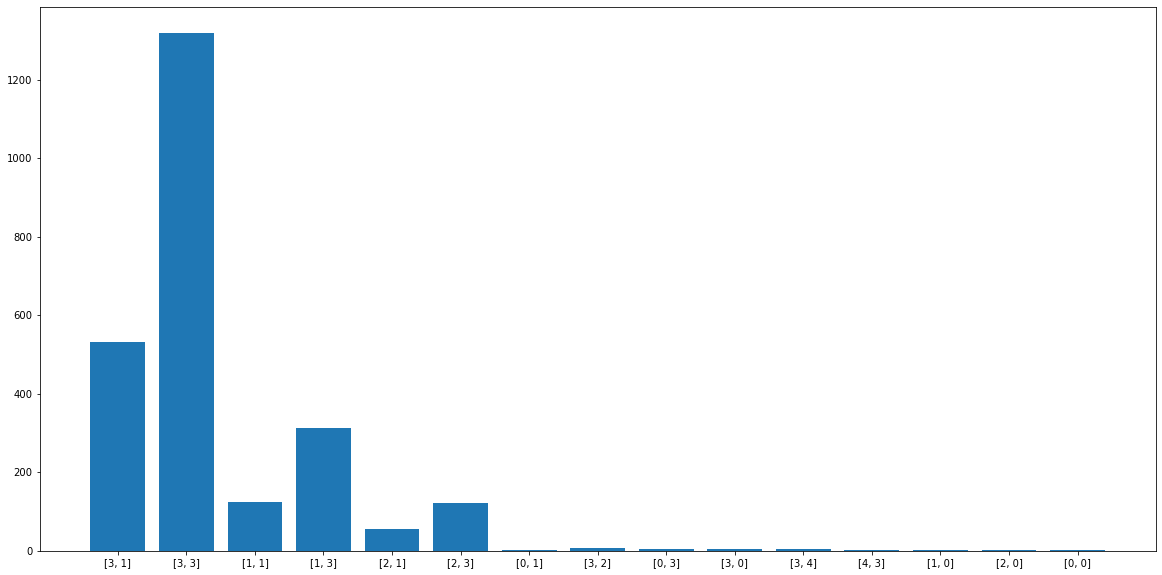

Processing Epoch 53
training start
Iteration 0, d real/fake loss 0.6632678508758545/0.6645512580871582 and g loss is 0.724606454372406, NDiv loss 0.07088828086853027
Iteration 1, d real/fake loss 0.6629606485366821/0.661393404006958 and g loss is 0.7276378273963928, NDiv loss 0.06809844076633453
Iteration 2, d real/fake loss 0.6626415848731995/0.6626461744308472 and g loss is 0.7239259481430054, NDiv loss 0.07433650642633438
Iteration 3, d real/fake loss 0.662319540977478/0.6682912707328796 and g loss is 0.7239758372306824, NDiv loss 0.07292792201042175
Iteration 4, d real/fake loss 0.6619940400123596/0.6694451570510864 and g loss is 0.7245427370071411, NDiv loss 0.07661470770835876


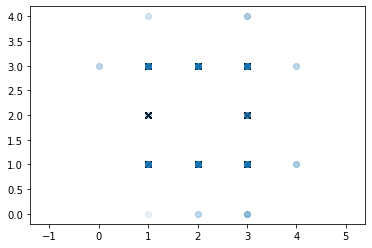

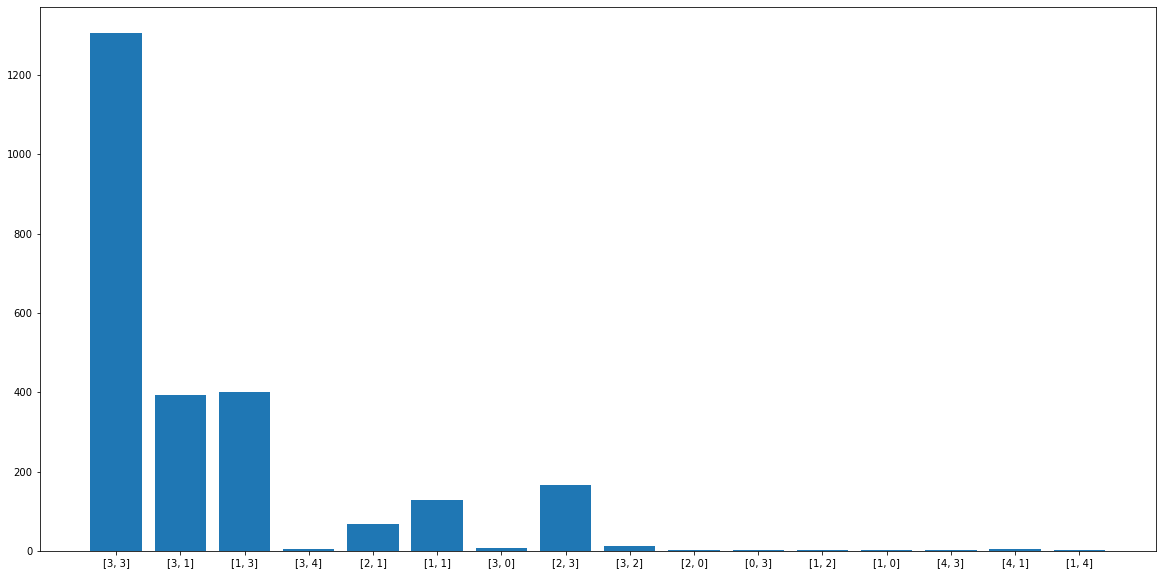

Processing Epoch 54
training start
Iteration 0, d real/fake loss 0.6588539481163025/0.6647266745567322 and g loss is 0.7239219546318054, NDiv loss 0.06710229814052582
Iteration 1, d real/fake loss 0.6585690379142761/0.6696596145629883 and g loss is 0.7193535566329956, NDiv loss 0.07519447058439255
Iteration 2, d real/fake loss 0.6582921743392944/0.667910635471344 and g loss is 0.7217361330986023, NDiv loss 0.06521082669496536
Iteration 3, d real/fake loss 0.6580246686935425/0.6695201396942139 and g loss is 0.7177219390869141, NDiv loss 0.06737538427114487
Iteration 4, d real/fake loss 0.6577662229537964/0.6698147654533386 and g loss is 0.7158973813056946, NDiv loss 0.07232335209846497


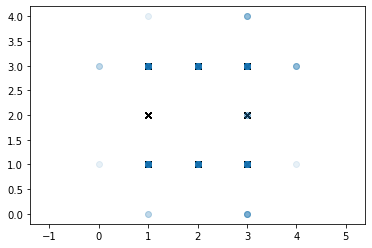

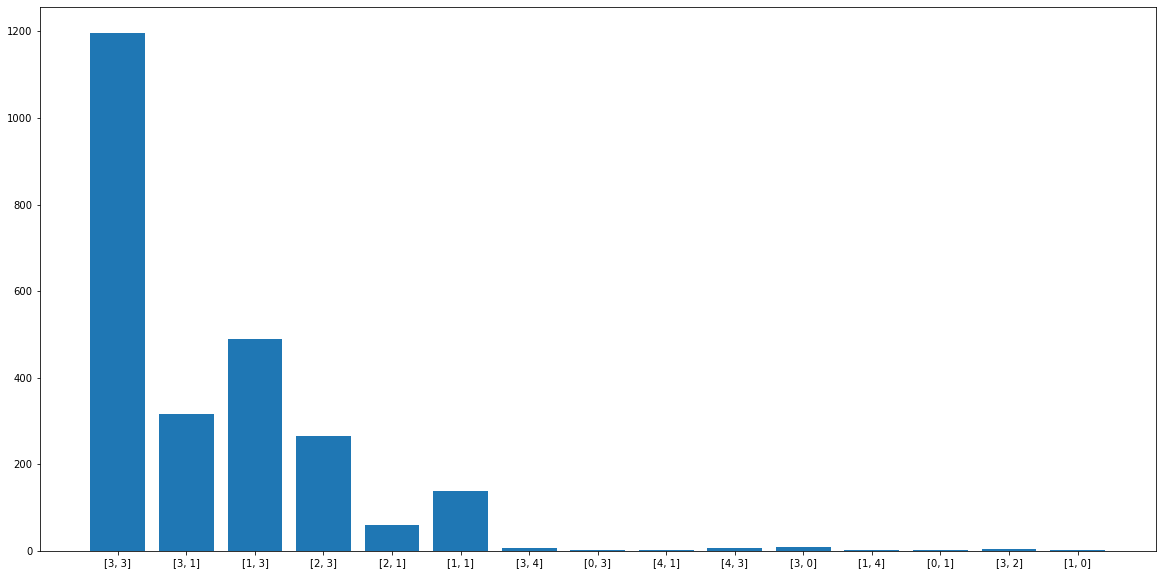

Processing Epoch 55
training start
Iteration 0, d real/fake loss 0.6524481177330017/0.6705096960067749 and g loss is 0.7200517654418945, NDiv loss 0.06715582311153412
Iteration 1, d real/fake loss 0.6521393060684204/0.6781537532806396 and g loss is 0.714799165725708, NDiv loss 0.06704962998628616
Iteration 2, d real/fake loss 0.6518397331237793/0.6773711442947388 and g loss is 0.7162750959396362, NDiv loss 0.06522850692272186
Iteration 3, d real/fake loss 0.6515443921089172/0.6731144189834595 and g loss is 0.7163865566253662, NDiv loss 0.06506063789129257
Iteration 4, d real/fake loss 0.6512519121170044/0.6736868023872375 and g loss is 0.7125205993652344, NDiv loss 0.06549444794654846


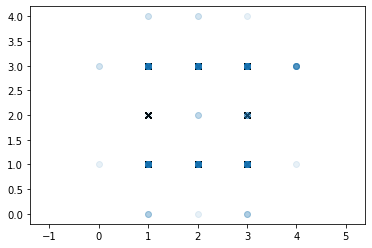

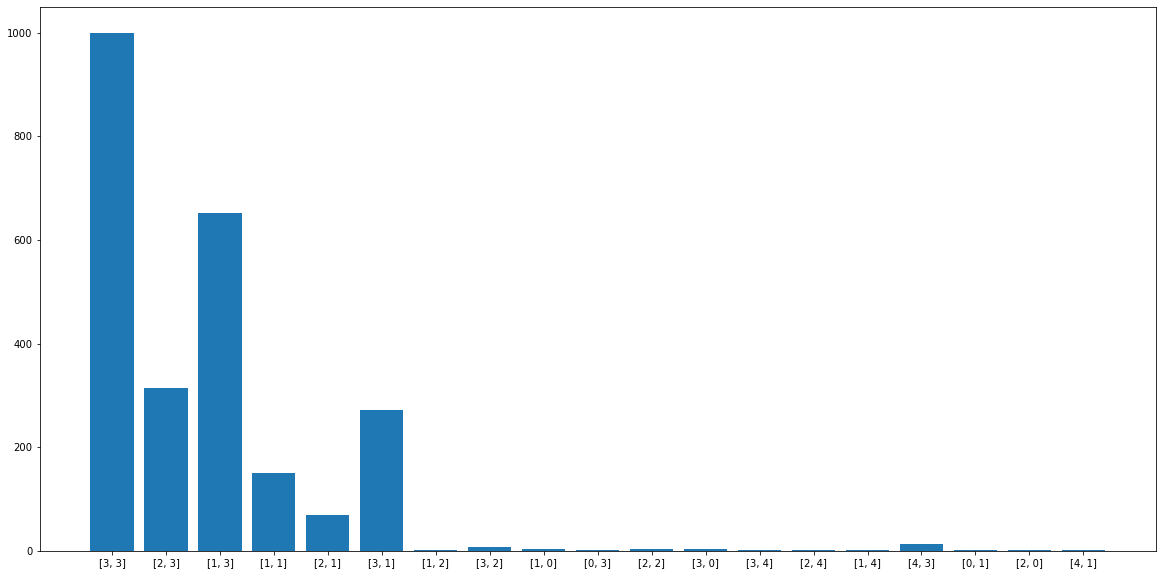

Processing Epoch 56
training start
Iteration 0, d real/fake loss 0.6593148708343506/0.6771962642669678 and g loss is 0.7078075408935547, NDiv loss 0.060943495482206345
Iteration 1, d real/fake loss 0.6590319275856018/0.6763759851455688 and g loss is 0.7084270715713501, NDiv loss 0.06319141387939453
Iteration 2, d real/fake loss 0.6587375998497009/0.6891095042228699 and g loss is 0.7107231020927429, NDiv loss 0.06730344146490097
Iteration 3, d real/fake loss 0.6584420204162598/0.682033896446228 and g loss is 0.7049729824066162, NDiv loss 0.06308986246585846
Iteration 4, d real/fake loss 0.6581478714942932/0.6788349151611328 and g loss is 0.7037643194198608, NDiv loss 0.06663958728313446


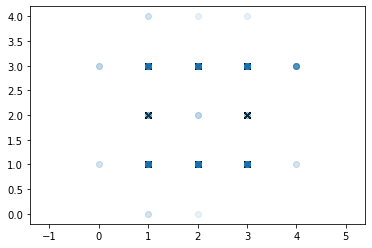

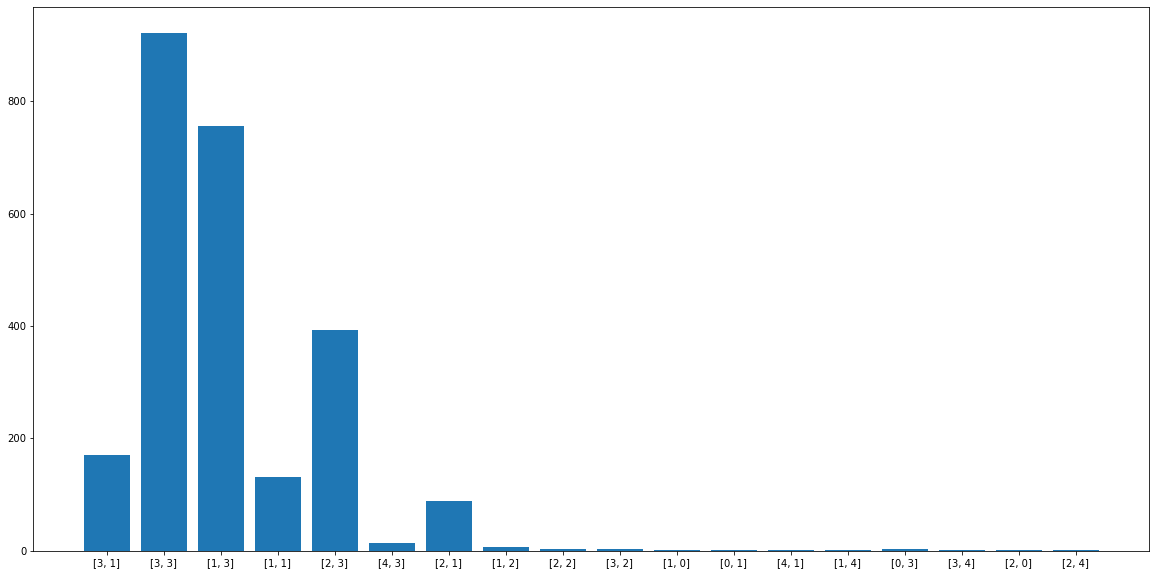

Processing Epoch 57
training start
Iteration 0, d real/fake loss 0.6485921144485474/0.6839890480041504 and g loss is 0.7027392387390137, NDiv loss 0.06322625279426575
Iteration 1, d real/fake loss 0.6481545567512512/0.6853455305099487 and g loss is 0.6970986127853394, NDiv loss 0.06360381096601486
Iteration 2, d real/fake loss 0.647705614566803/0.6829934120178223 and g loss is 0.7010262608528137, NDiv loss 0.0631764754652977
Iteration 3, d real/fake loss 0.6472510099411011/0.6887649893760681 and g loss is 0.7005727887153625, NDiv loss 0.06470383703708649
Iteration 4, d real/fake loss 0.6467867493629456/0.6897777318954468 and g loss is 0.6991521120071411, NDiv loss 0.06257132440805435


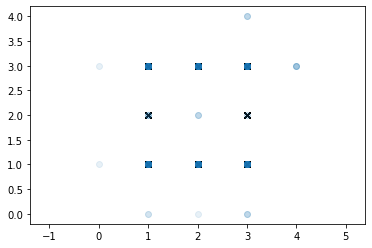

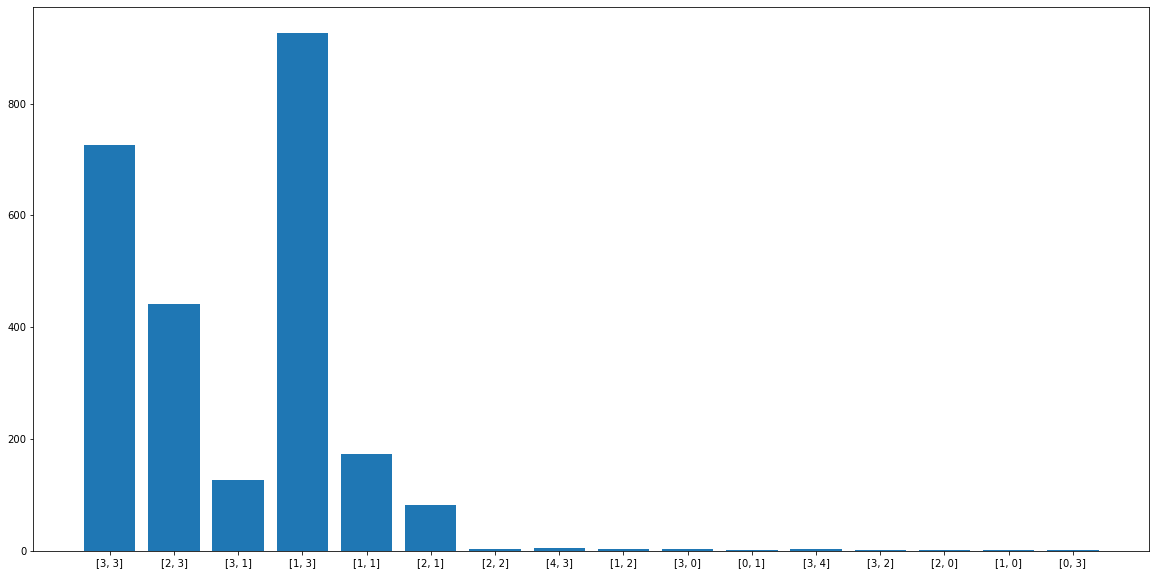

Processing Epoch 58
training start
Iteration 0, d real/fake loss 0.6574816107749939/0.6844528913497925 and g loss is 0.6956251859664917, NDiv loss 0.06638573110103607
Iteration 1, d real/fake loss 0.657286524772644/0.6933901906013489 and g loss is 0.6962190270423889, NDiv loss 0.06514467298984528
Iteration 2, d real/fake loss 0.6570999622344971/0.6891458034515381 and g loss is 0.69191974401474, NDiv loss 0.06399227678775787
Iteration 3, d real/fake loss 0.656920313835144/0.6917029619216919 and g loss is 0.6933046579360962, NDiv loss 0.07147344201803207
Iteration 4, d real/fake loss 0.6567486524581909/0.690494954586029 and g loss is 0.6919678449630737, NDiv loss 0.07072986662387848


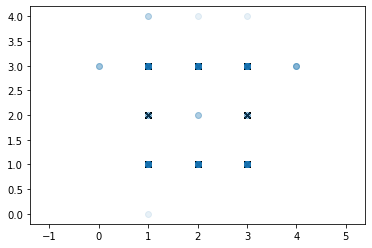

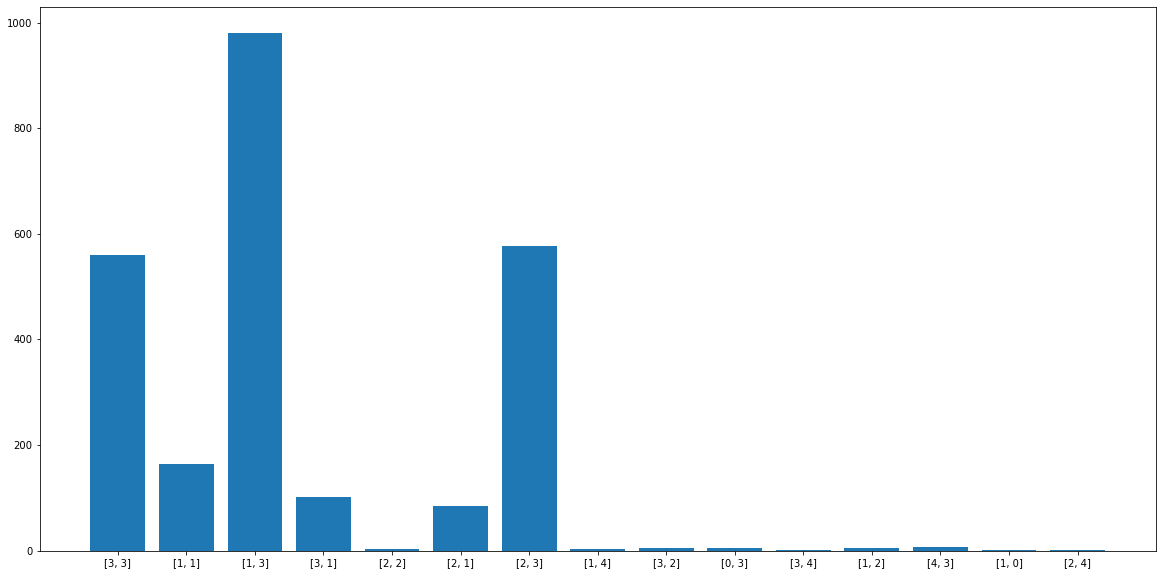

Processing Epoch 59
training start
Iteration 0, d real/fake loss 0.6620125770568848/0.6944550275802612 and g loss is 0.6923930048942566, NDiv loss 0.06879817694425583
Iteration 1, d real/fake loss 0.6618523597717285/0.6936396956443787 and g loss is 0.6985141038894653, NDiv loss 0.06610064953565598
Iteration 2, d real/fake loss 0.6616937518119812/0.6922058463096619 and g loss is 0.6902095675468445, NDiv loss 0.06379488855600357
Iteration 3, d real/fake loss 0.6615386009216309/0.6961942315101624 and g loss is 0.6922883987426758, NDiv loss 0.0666482001543045
Iteration 4, d real/fake loss 0.6613826155662537/0.6970381736755371 and g loss is 0.6957370638847351, NDiv loss 0.06460485607385635


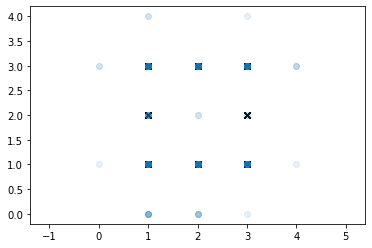

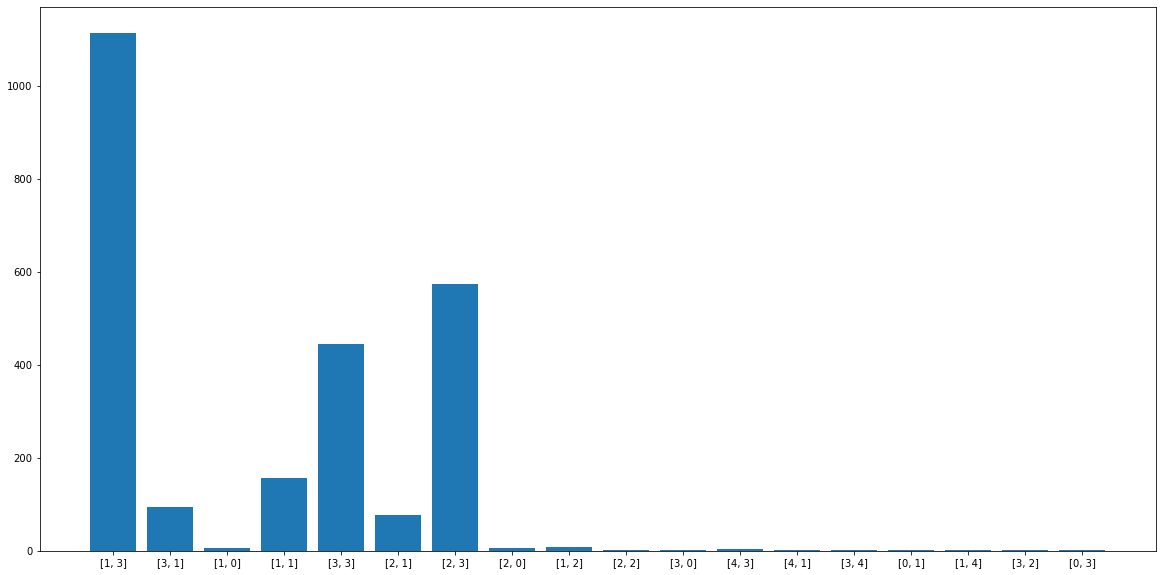

Processing Epoch 60
training start
Iteration 0, d real/fake loss 0.6638963222503662/0.6953319907188416 and g loss is 0.690071702003479, NDiv loss 0.06789885461330414
Iteration 1, d real/fake loss 0.6636414527893066/0.6976362466812134 and g loss is 0.6888970136642456, NDiv loss 0.0696420967578888
Iteration 2, d real/fake loss 0.6633791327476501/0.703118085861206 and g loss is 0.6906371712684631, NDiv loss 0.06789940595626831
Iteration 3, d real/fake loss 0.6631085872650146/0.6934829354286194 and g loss is 0.6876614689826965, NDiv loss 0.07078410685062408
Iteration 4, d real/fake loss 0.6628284454345703/0.6977220177650452 and g loss is 0.6871843934059143, NDiv loss 0.06361504644155502


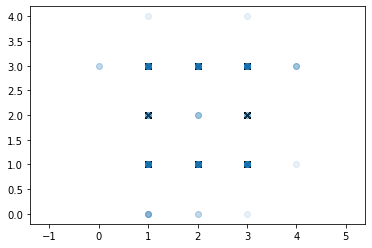

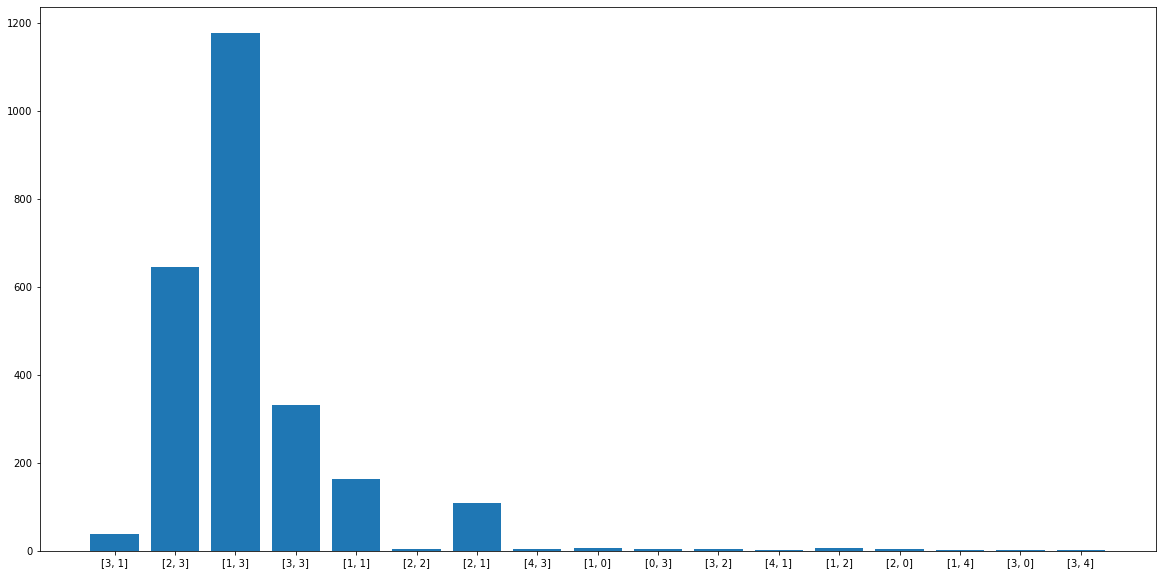

Processing Epoch 61
training start
Iteration 0, d real/fake loss 0.655731201171875/0.6964651942253113 and g loss is 0.6924235820770264, NDiv loss 0.07278511673212051
Iteration 1, d real/fake loss 0.6554782390594482/0.6962058544158936 and g loss is 0.6921470165252686, NDiv loss 0.06970131397247314
Iteration 2, d real/fake loss 0.6552278995513916/0.6994109749794006 and g loss is 0.6871569156646729, NDiv loss 0.06935317069292068
Iteration 3, d real/fake loss 0.6549862623214722/0.7058246731758118 and g loss is 0.6854207515716553, NDiv loss 0.07090994715690613
Iteration 4, d real/fake loss 0.654753565788269/0.6997073292732239 and g loss is 0.6883821487426758, NDiv loss 0.07508736103773117


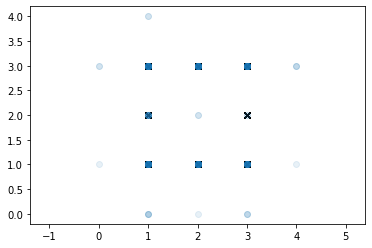

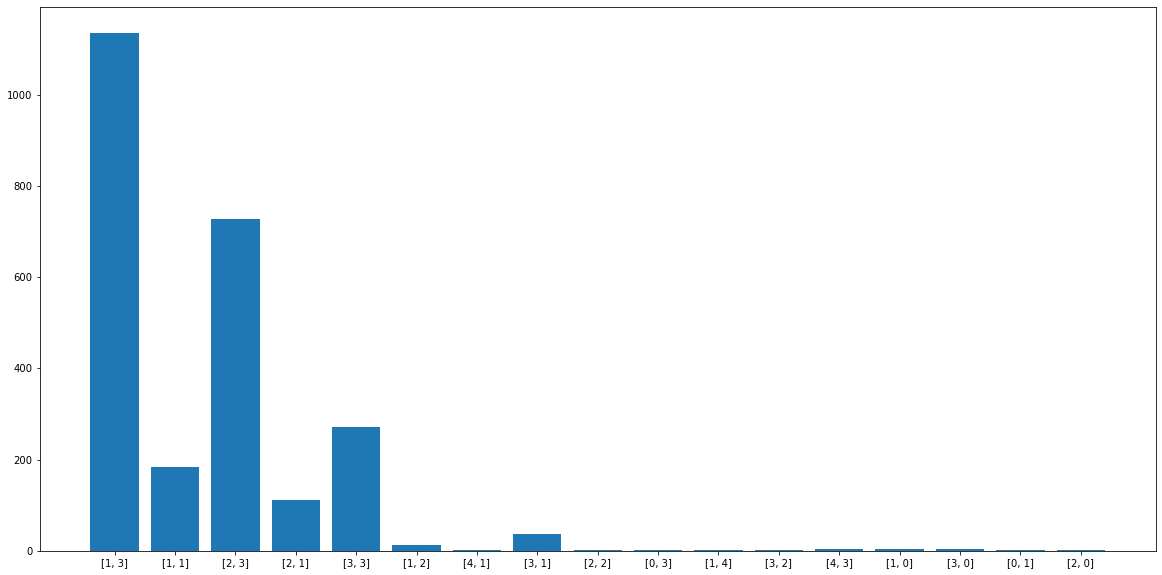

Processing Epoch 62
training start
Iteration 0, d real/fake loss 0.6553699970245361/0.6994129419326782 and g loss is 0.6904911398887634, NDiv loss 0.06857561320066452
Iteration 1, d real/fake loss 0.6552001237869263/0.7005630135536194 and g loss is 0.6850485801696777, NDiv loss 0.07699556648731232
Iteration 2, d real/fake loss 0.6550266742706299/0.6958784461021423 and g loss is 0.6862415075302124, NDiv loss 0.07306059449911118
Iteration 3, d real/fake loss 0.6548516154289246/0.7026992440223694 and g loss is 0.6839401721954346, NDiv loss 0.0690360814332962
Iteration 4, d real/fake loss 0.6546785235404968/0.7018061280250549 and g loss is 0.6831629276275635, NDiv loss 0.07664056122303009


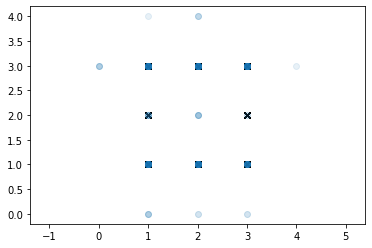

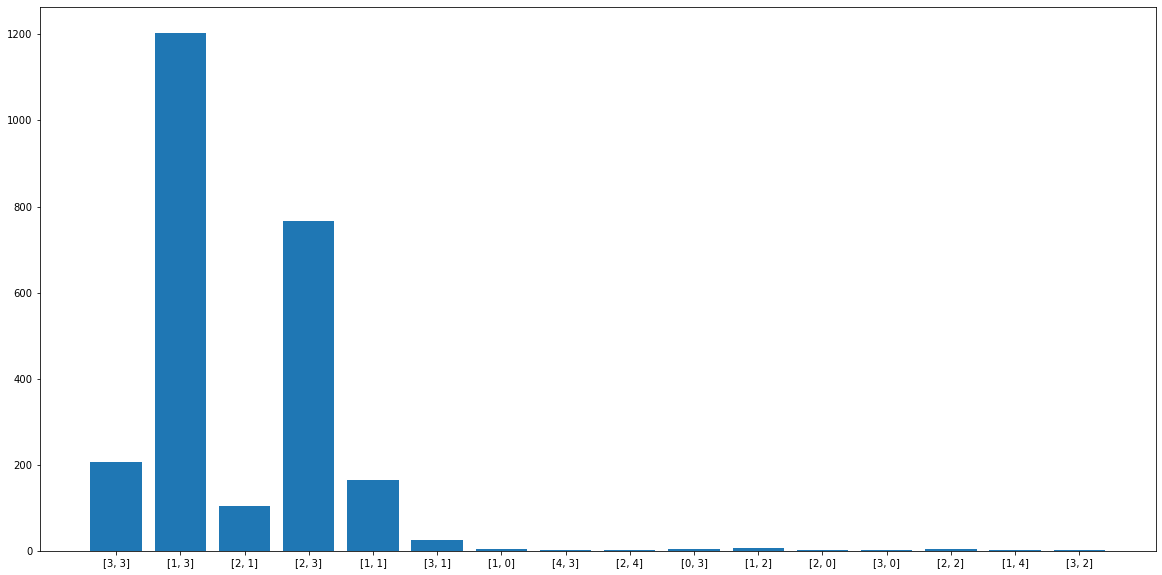

Processing Epoch 63
training start
Iteration 0, d real/fake loss 0.6520780324935913/0.70363450050354 and g loss is 0.6835972666740417, NDiv loss 0.07598714530467987
Iteration 1, d real/fake loss 0.6518067121505737/0.7048287391662598 and g loss is 0.6880542039871216, NDiv loss 0.07677611708641052
Iteration 2, d real/fake loss 0.6515398621559143/0.701977014541626 and g loss is 0.6857154965400696, NDiv loss 0.07322533428668976
Iteration 3, d real/fake loss 0.6512717604637146/0.7038894891738892 and g loss is 0.6852693557739258, NDiv loss 0.07331731915473938
Iteration 4, d real/fake loss 0.6510051488876343/0.7026426792144775 and g loss is 0.6903974413871765, NDiv loss 0.07012732326984406


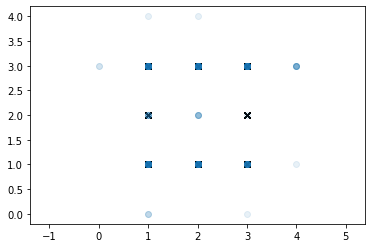

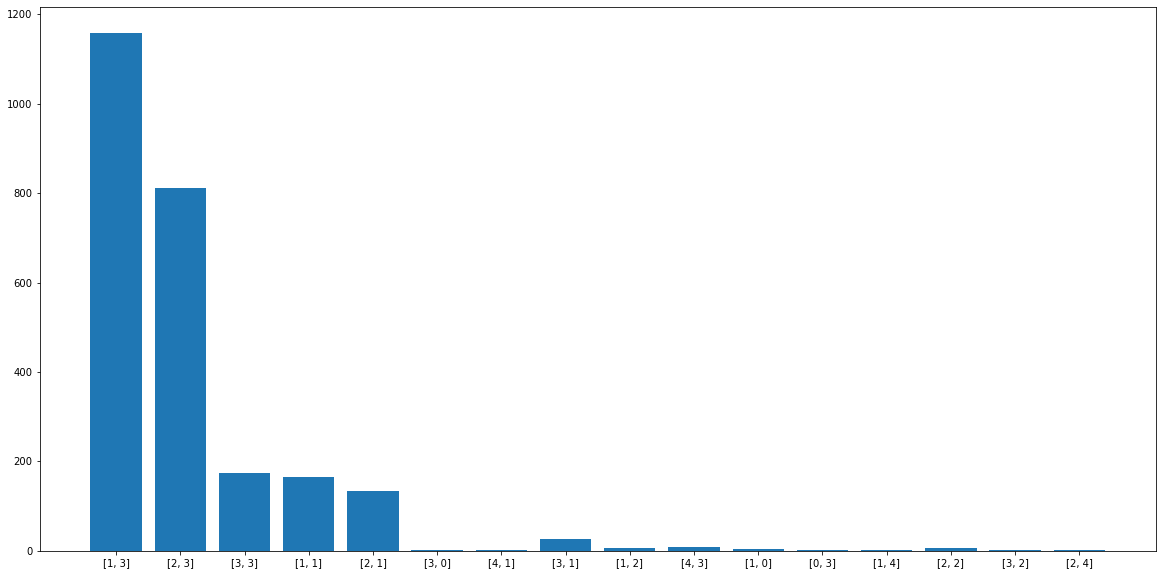

Processing Epoch 64
training start
Iteration 0, d real/fake loss 0.6560467481613159/0.6969056725502014 and g loss is 0.6874001026153564, NDiv loss 0.0801033303141594
Iteration 1, d real/fake loss 0.6559765338897705/0.7039216160774231 and g loss is 0.6882324814796448, NDiv loss 0.07292621582746506
Iteration 2, d real/fake loss 0.6559151411056519/0.7010096907615662 and g loss is 0.6875429153442383, NDiv loss 0.07585429400205612
Iteration 3, d real/fake loss 0.6558576822280884/0.6998131275177002 and g loss is 0.6863455176353455, NDiv loss 0.07155992090702057
Iteration 4, d real/fake loss 0.6558031439781189/0.7012478113174438 and g loss is 0.6859852075576782, NDiv loss 0.07759879529476166


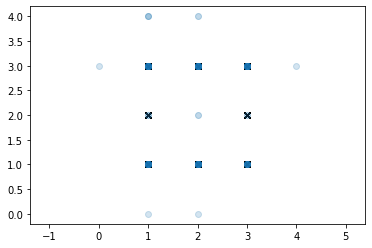

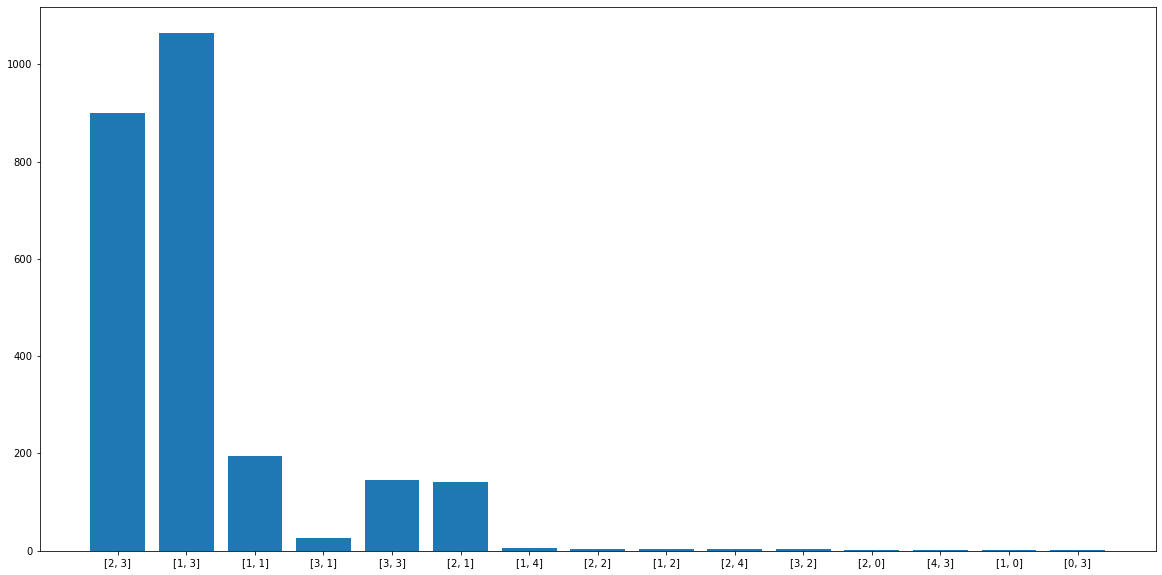

Processing Epoch 65
training start
Iteration 0, d real/fake loss 0.6451502442359924/0.7004489898681641 and g loss is 0.6870080232620239, NDiv loss 0.0756937637925148
Iteration 1, d real/fake loss 0.6449403166770935/0.7030752301216125 and g loss is 0.6883066892623901, NDiv loss 0.07859974354505539
Iteration 2, d real/fake loss 0.6447361707687378/0.7024387121200562 and g loss is 0.6888638734817505, NDiv loss 0.07337813079357147
Iteration 3, d real/fake loss 0.6445423364639282/0.699461042881012 and g loss is 0.6879673600196838, NDiv loss 0.07065436989068985
Iteration 4, d real/fake loss 0.6443572044372559/0.7021838426589966 and g loss is 0.6880654692649841, NDiv loss 0.07325337827205658


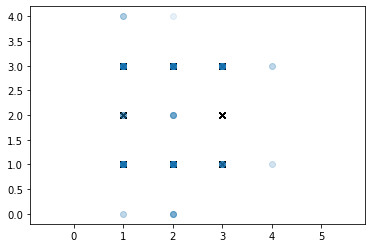

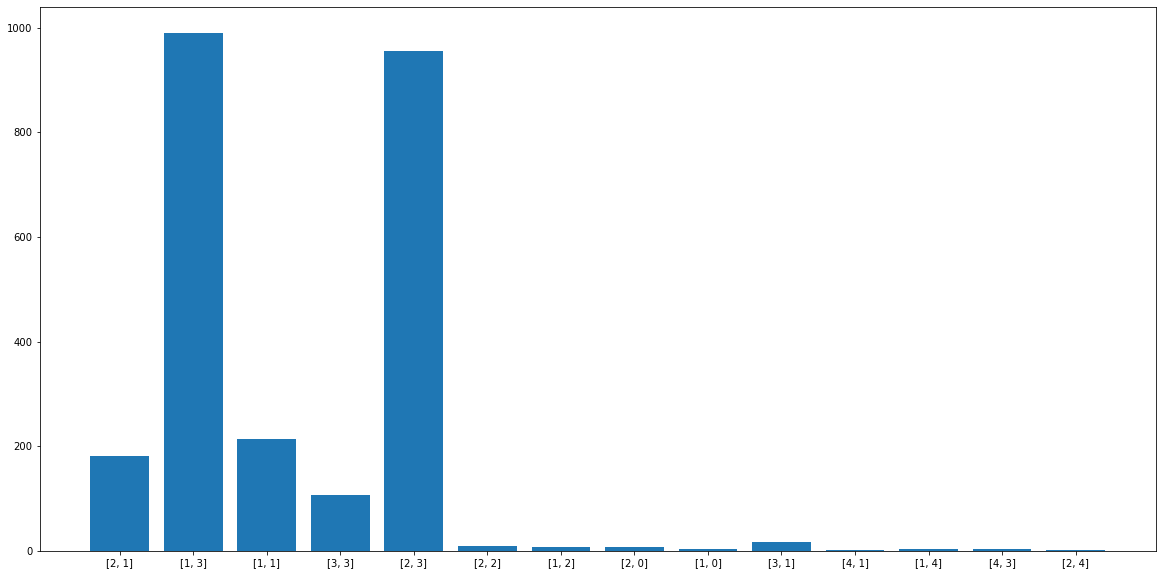

Processing Epoch 66
training start
Iteration 0, d real/fake loss 0.6490320563316345/0.6965348720550537 and g loss is 0.6859279870986938, NDiv loss 0.07819832861423492
Iteration 1, d real/fake loss 0.6489458084106445/0.6984586715698242 and g loss is 0.6896188259124756, NDiv loss 0.07562050968408585
Iteration 2, d real/fake loss 0.6488659977912903/0.7025196552276611 and g loss is 0.6818126440048218, NDiv loss 0.07645571231842041
Iteration 3, d real/fake loss 0.6487971544265747/0.702386736869812 and g loss is 0.6870578527450562, NDiv loss 0.07393381744623184
Iteration 4, d real/fake loss 0.648730993270874/0.7008247375488281 and g loss is 0.6908524036407471, NDiv loss 0.07664951682090759


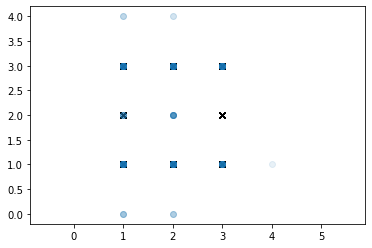

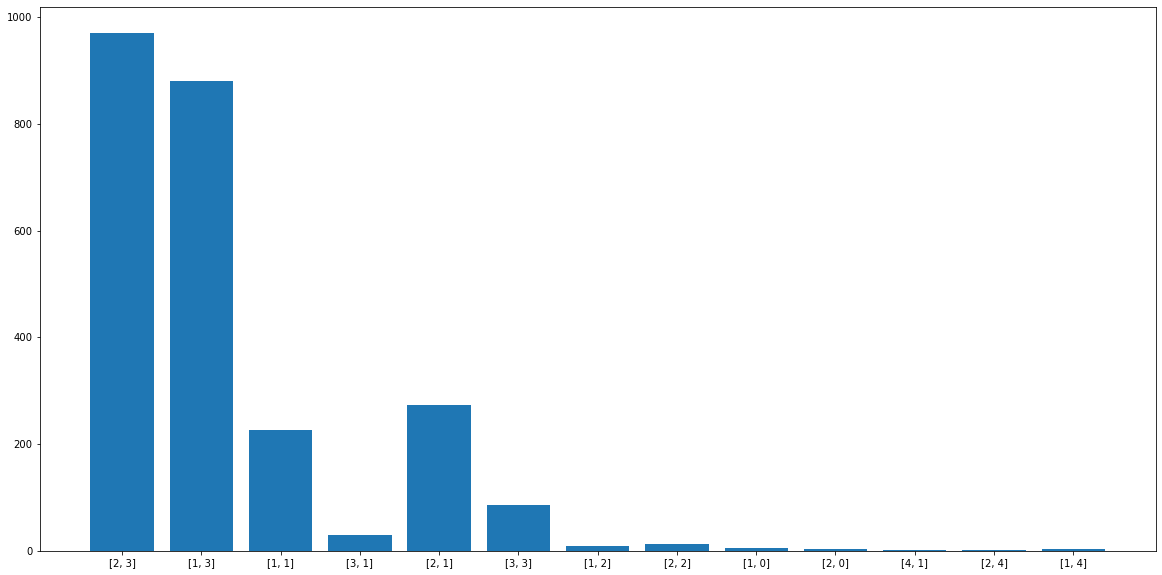

Processing Epoch 67
training start
Iteration 0, d real/fake loss 0.64243483543396/0.7007070779800415 and g loss is 0.6845245957374573, NDiv loss 0.07108302414417267
Iteration 1, d real/fake loss 0.6423404216766357/0.7009924650192261 and g loss is 0.6866813898086548, NDiv loss 0.07318338006734848
Iteration 2, d real/fake loss 0.6422587037086487/0.7036718726158142 and g loss is 0.6863079071044922, NDiv loss 0.07870402932167053
Iteration 3, d real/fake loss 0.6421903371810913/0.7014726400375366 and g loss is 0.6834976673126221, NDiv loss 0.06867000460624695
Iteration 4, d real/fake loss 0.642131507396698/0.7045753002166748 and g loss is 0.6909537315368652, NDiv loss 0.07272472977638245


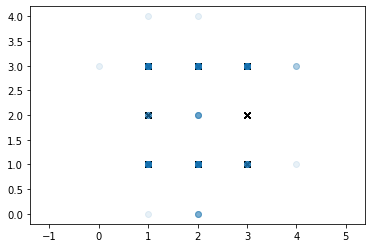

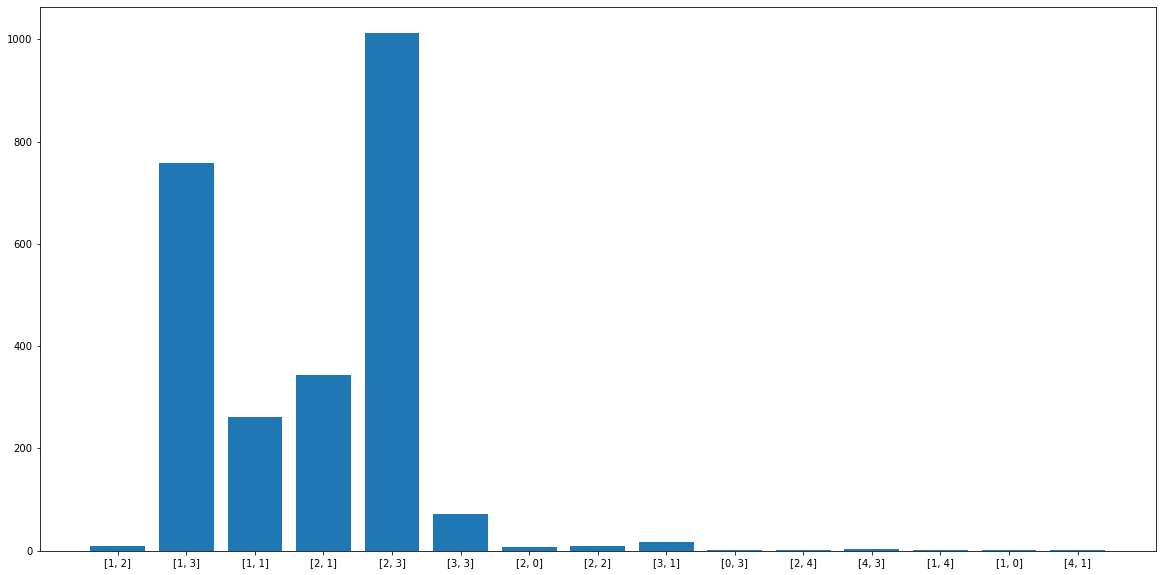

Processing Epoch 68
training start
Iteration 0, d real/fake loss 0.6474761962890625/0.7038835287094116 and g loss is 0.6896785497665405, NDiv loss 0.07179179787635803
Iteration 1, d real/fake loss 0.6475999355316162/0.7036442756652832 and g loss is 0.6827821731567383, NDiv loss 0.0738058090209961
Iteration 2, d real/fake loss 0.6477250456809998/0.6981068849563599 and g loss is 0.6848589181900024, NDiv loss 0.07078919559717178
Iteration 3, d real/fake loss 0.647850513458252/0.6997880935668945 and g loss is 0.6865845322608948, NDiv loss 0.07477764040231705
Iteration 4, d real/fake loss 0.647973895072937/0.7074069976806641 and g loss is 0.6819126009941101, NDiv loss 0.07304355502128601


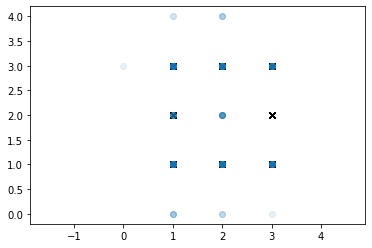

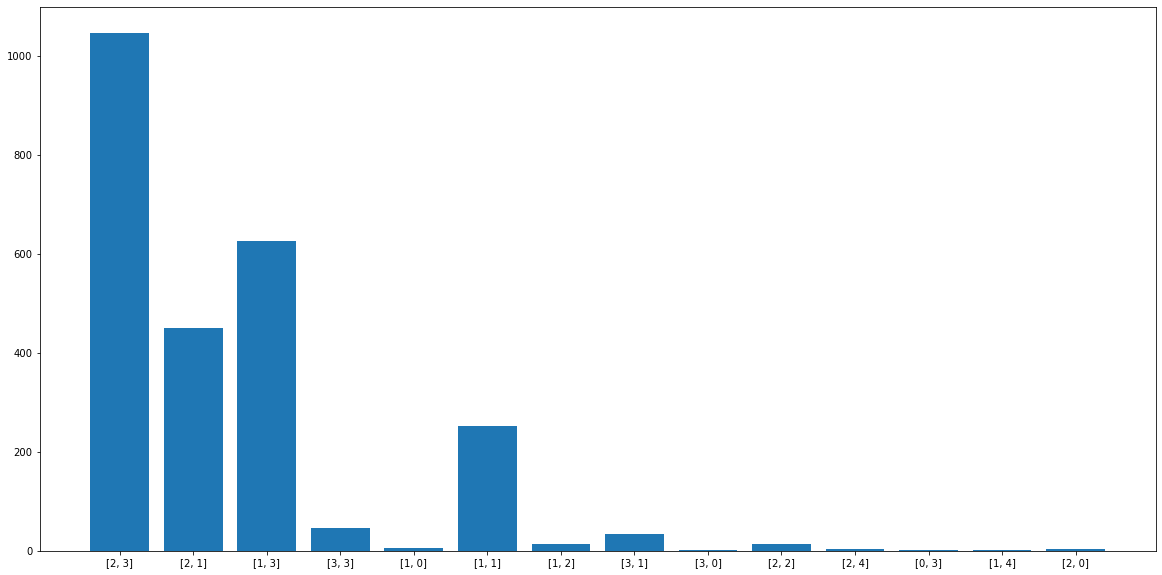

Processing Epoch 69
training start
Iteration 0, d real/fake loss 0.6462210416793823/0.7033001184463501 and g loss is 0.686707615852356, NDiv loss 0.06970073282718658
Iteration 1, d real/fake loss 0.646328330039978/0.7018362283706665 and g loss is 0.6855287551879883, NDiv loss 0.0762331634759903
Iteration 2, d real/fake loss 0.6464346051216125/0.7047115564346313 and g loss is 0.6836496591567993, NDiv loss 0.07448079437017441
Iteration 3, d real/fake loss 0.6465450525283813/0.7020056247711182 and g loss is 0.6803175210952759, NDiv loss 0.0727350115776062
Iteration 4, d real/fake loss 0.6466542482376099/0.7048585414886475 and g loss is 0.6715542674064636, NDiv loss 0.07099321484565735


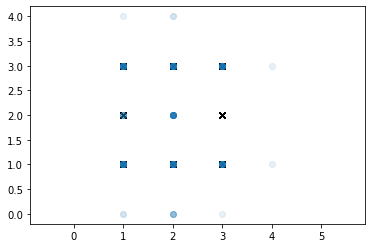

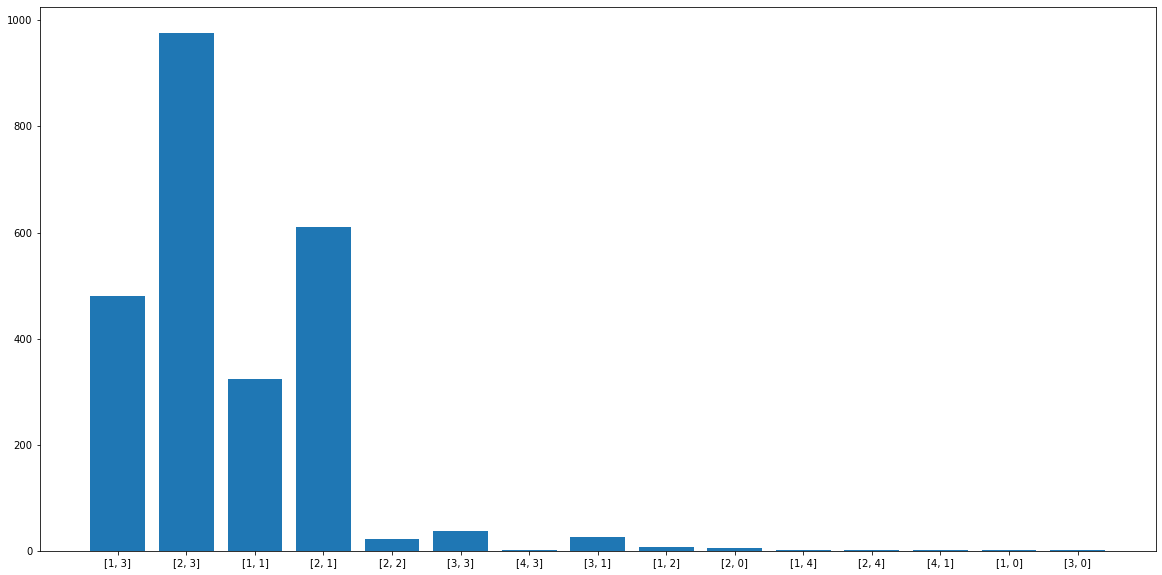

Processing Epoch 70
training start
Iteration 0, d real/fake loss 0.650015115737915/0.7038652896881104 and g loss is 0.6844696998596191, NDiv loss 0.0694054439663887
Iteration 1, d real/fake loss 0.6500452160835266/0.7054623961448669 and g loss is 0.6800416707992554, NDiv loss 0.07529202848672867
Iteration 2, d real/fake loss 0.6500861048698425/0.7057153582572937 and g loss is 0.6763136386871338, NDiv loss 0.07130825519561768
Iteration 3, d real/fake loss 0.6501328945159912/0.7072612047195435 and g loss is 0.674879789352417, NDiv loss 0.07482419908046722
Iteration 4, d real/fake loss 0.6501920223236084/0.7113202214241028 and g loss is 0.6823055148124695, NDiv loss 0.07368530333042145


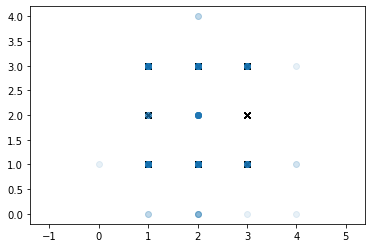

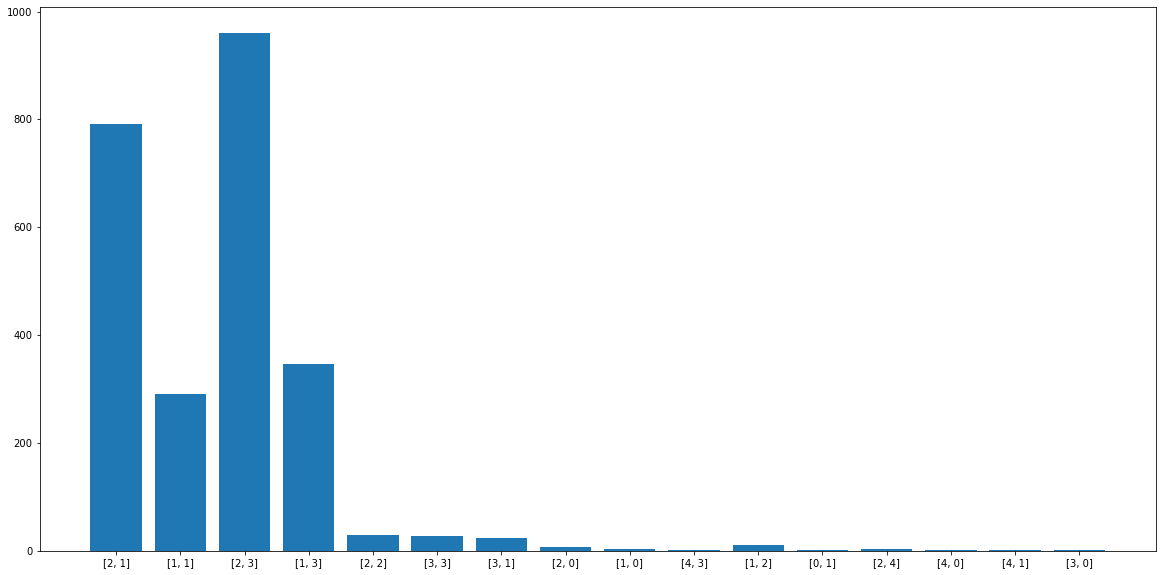

Processing Epoch 71
training start
Iteration 0, d real/fake loss 0.6327111721038818/0.7083884477615356 and g loss is 0.6813904047012329, NDiv loss 0.07853037118911743
Iteration 1, d real/fake loss 0.6326601505279541/0.7058404684066772 and g loss is 0.6732064485549927, NDiv loss 0.07310513406991959
Iteration 2, d real/fake loss 0.6326137781143188/0.7064953446388245 and g loss is 0.6766533255577087, NDiv loss 0.07033362984657288
Iteration 3, d real/fake loss 0.6325744390487671/0.7043983936309814 and g loss is 0.6777998208999634, NDiv loss 0.07633192837238312
Iteration 4, d real/fake loss 0.6325391530990601/0.7107811570167542 and g loss is 0.6774787902832031, NDiv loss 0.07287012785673141


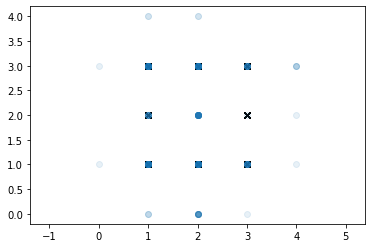

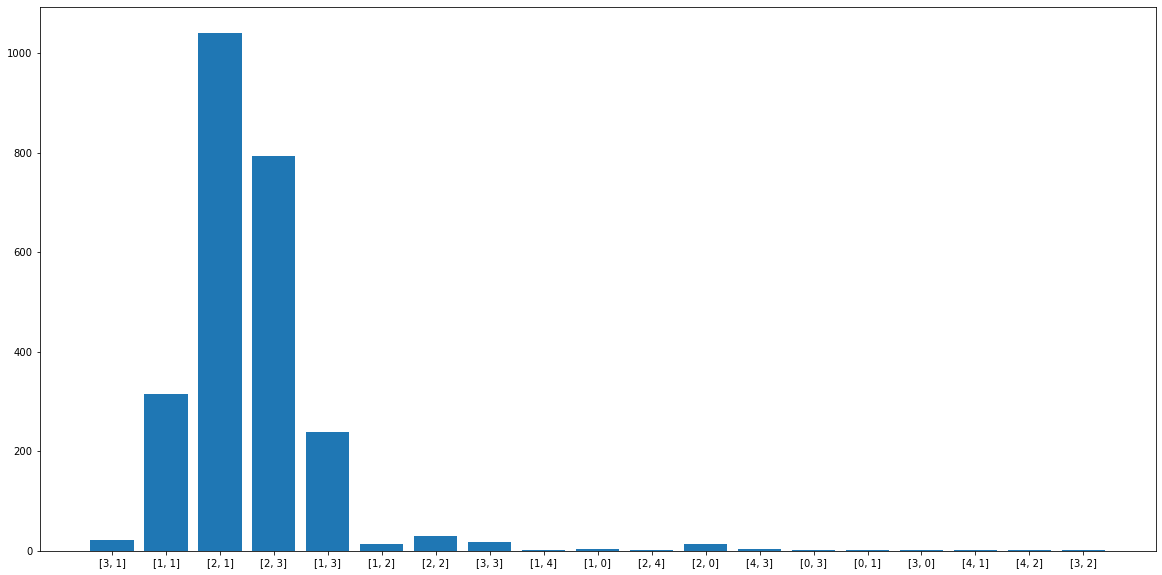

Processing Epoch 72
training start
Iteration 0, d real/fake loss 0.6518230438232422/0.7103464603424072 and g loss is 0.6766974925994873, NDiv loss 0.07715573161840439
Iteration 1, d real/fake loss 0.6519079804420471/0.7119768857955933 and g loss is 0.677189826965332, NDiv loss 0.08112918585538864
Iteration 2, d real/fake loss 0.6519979238510132/0.713530421257019 and g loss is 0.6765285134315491, NDiv loss 0.0775630846619606
Iteration 3, d real/fake loss 0.6520892381668091/0.7160494923591614 and g loss is 0.6749281883239746, NDiv loss 0.07667799293994904
Iteration 4, d real/fake loss 0.6521949172019958/0.7165279388427734 and g loss is 0.6758543848991394, NDiv loss 0.08041504770517349


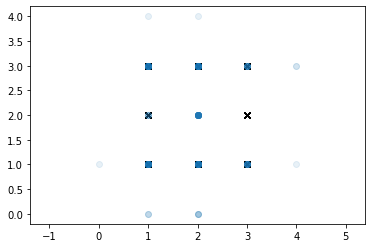

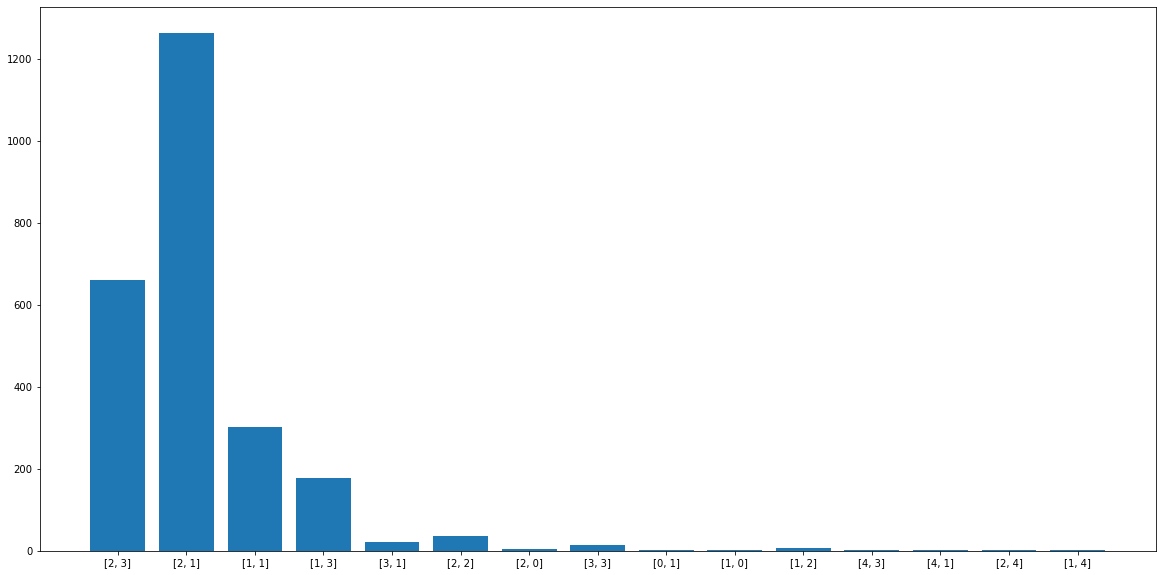

Processing Epoch 73
training start
Iteration 0, d real/fake loss 0.6406129598617554/0.7134668827056885 and g loss is 0.6762108206748962, NDiv loss 0.07327346503734589
Iteration 1, d real/fake loss 0.6407060623168945/0.7085089087486267 and g loss is 0.6768452525138855, NDiv loss 0.0746527686715126
Iteration 2, d real/fake loss 0.6408089399337769/0.7157872915267944 and g loss is 0.6749622821807861, NDiv loss 0.07508152723312378
Iteration 3, d real/fake loss 0.640928328037262/0.7173687219619751 and g loss is 0.674824059009552, NDiv loss 0.07673905044794083
Iteration 4, d real/fake loss 0.6410667300224304/0.7138746380805969 and g loss is 0.6746901273727417, NDiv loss 0.08195967972278595


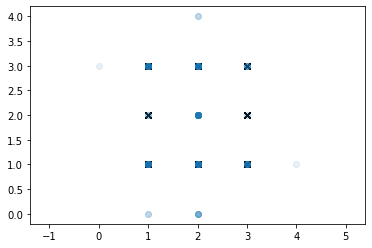

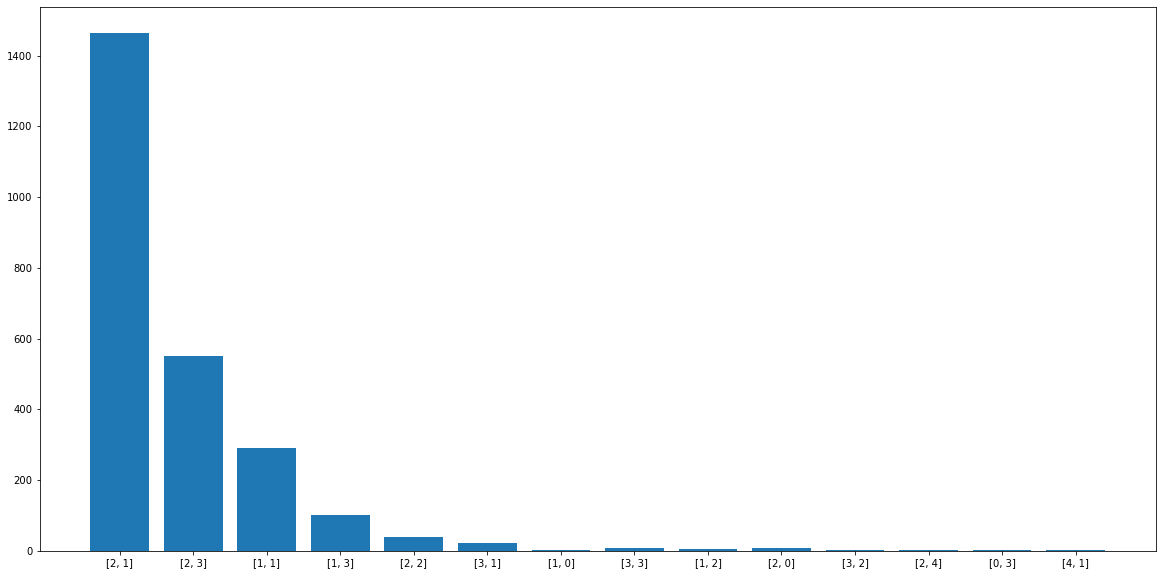

Processing Epoch 74
training start
Iteration 0, d real/fake loss 0.6445622444152832/0.7164636850357056 and g loss is 0.675559401512146, NDiv loss 0.08399450778961182
Iteration 1, d real/fake loss 0.644779622554779/0.7163645029067993 and g loss is 0.6761837005615234, NDiv loss 0.08272939920425415
Iteration 2, d real/fake loss 0.6450037360191345/0.7151150703430176 and g loss is 0.6769046783447266, NDiv loss 0.08187081664800644
Iteration 3, d real/fake loss 0.6452343463897705/0.7136589288711548 and g loss is 0.6735777854919434, NDiv loss 0.08583859354257584
Iteration 4, d real/fake loss 0.6454681158065796/0.7136197686195374 and g loss is 0.6798095107078552, NDiv loss 0.0849854052066803


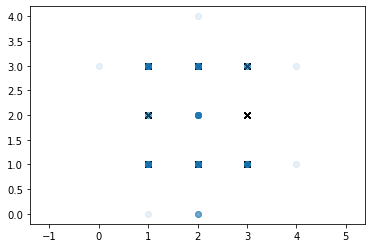

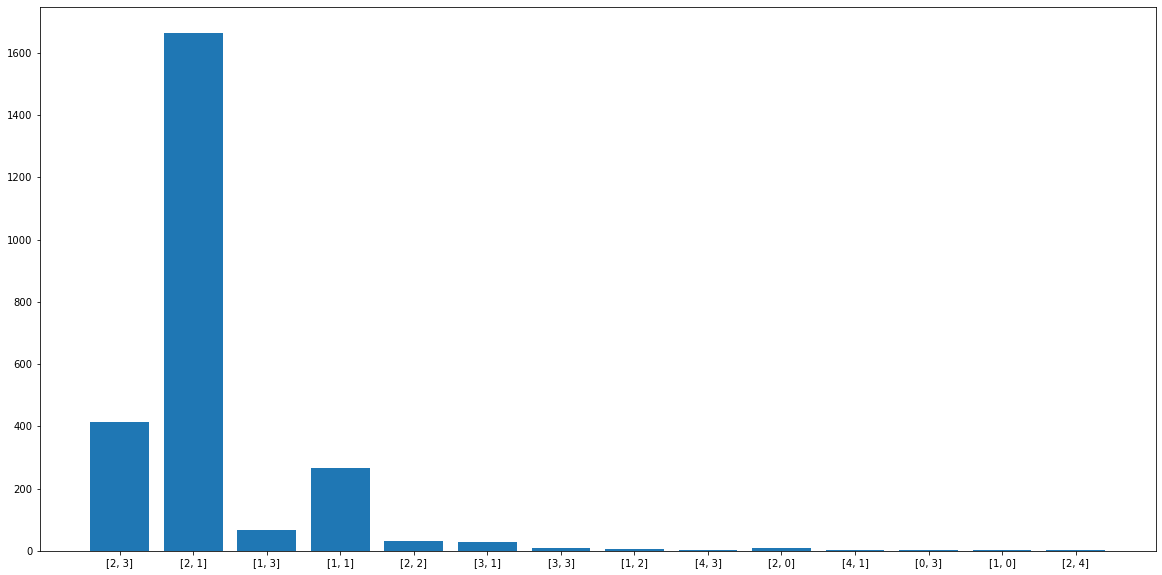

Processing Epoch 75
training start
Iteration 0, d real/fake loss 0.6525853276252747/0.7136814594268799 and g loss is 0.675176739692688, NDiv loss 0.08237427473068237
Iteration 1, d real/fake loss 0.6528387069702148/0.709970235824585 and g loss is 0.6774497032165527, NDiv loss 0.08957179635763168
Iteration 2, d real/fake loss 0.6530942916870117/0.7082357406616211 and g loss is 0.6800345182418823, NDiv loss 0.08386270701885223
Iteration 3, d real/fake loss 0.6533474922180176/0.7082484364509583 and g loss is 0.6761307716369629, NDiv loss 0.09384742379188538
Iteration 4, d real/fake loss 0.6535993814468384/0.7077416181564331 and g loss is 0.6808560490608215, NDiv loss 0.0880330428481102


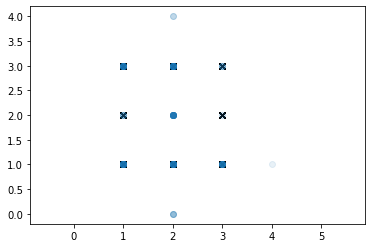

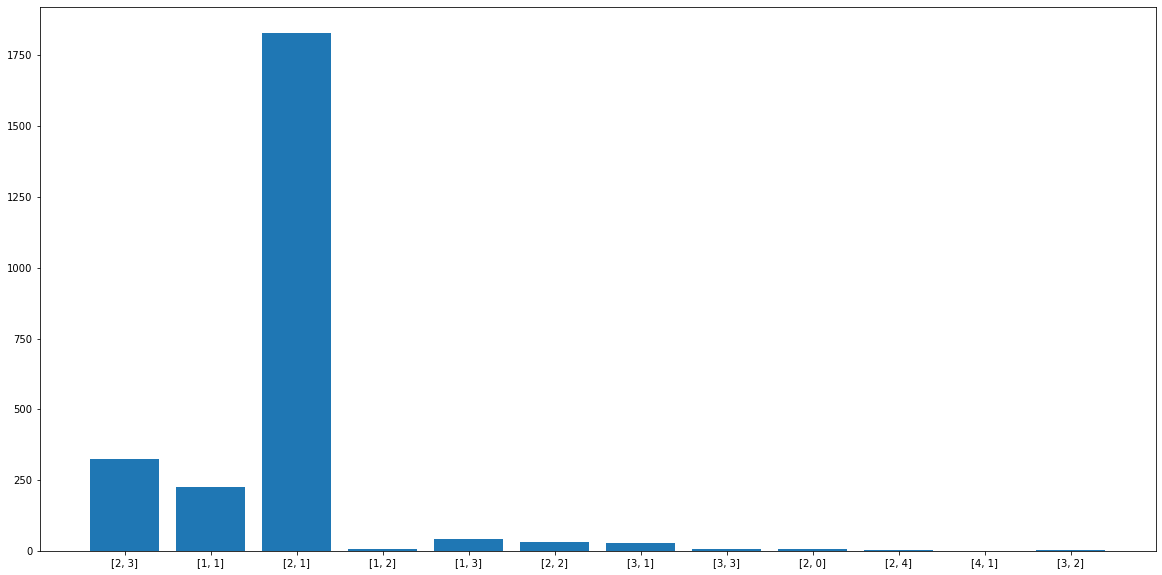

Processing Epoch 76
training start
Iteration 0, d real/fake loss 0.6548603177070618/0.7076953053474426 and g loss is 0.6824308633804321, NDiv loss 0.10169801861047745
Iteration 1, d real/fake loss 0.6552494168281555/0.7078145742416382 and g loss is 0.6822245121002197, NDiv loss 0.0967859998345375
Iteration 2, d real/fake loss 0.655642032623291/0.7035102248191833 and g loss is 0.6847466826438904, NDiv loss 0.10371027886867523
Iteration 3, d real/fake loss 0.6560288667678833/0.7019491195678711 and g loss is 0.6830155849456787, NDiv loss 0.10325467586517334
Iteration 4, d real/fake loss 0.6564079523086548/0.7004507780075073 and g loss is 0.6851194500923157, NDiv loss 0.09446447342634201


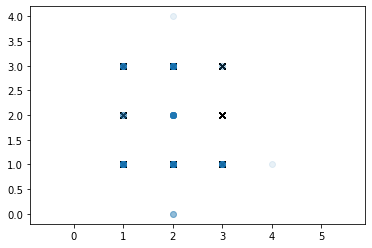

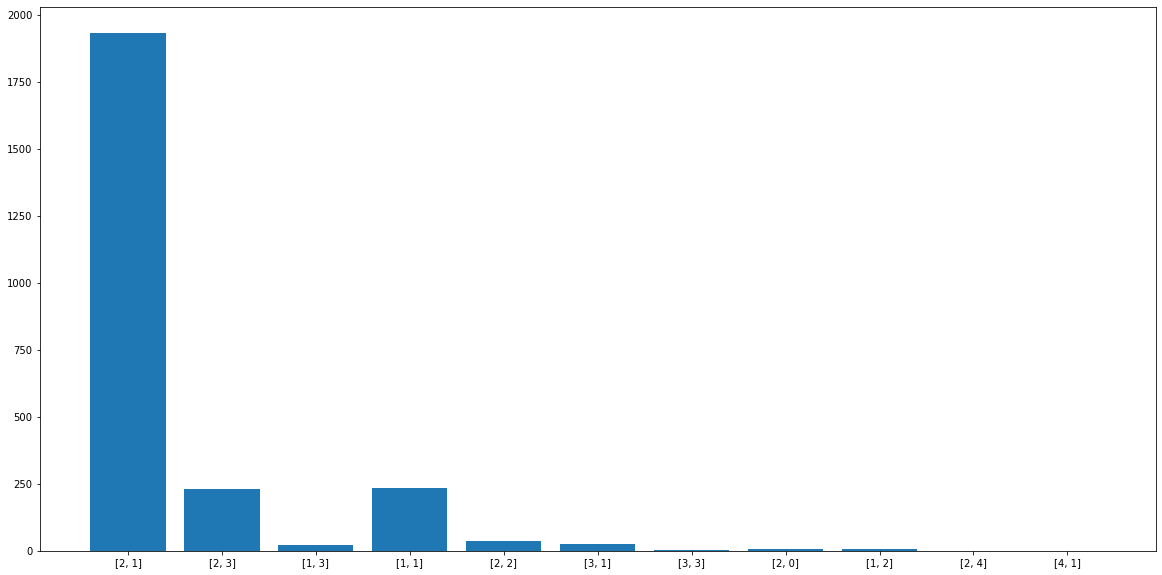

Processing Epoch 77
training start
Iteration 0, d real/fake loss 0.6453274488449097/0.7036463022232056 and g loss is 0.6847732663154602, NDiv loss 0.09346229583024979
Iteration 1, d real/fake loss 0.6457071304321289/0.7020009756088257 and g loss is 0.6845404505729675, NDiv loss 0.0992613360285759
Iteration 2, d real/fake loss 0.6460906267166138/0.7030225992202759 and g loss is 0.684780478477478, NDiv loss 0.10215060412883759
Iteration 3, d real/fake loss 0.6464830636978149/0.6997747421264648 and g loss is 0.6878534555435181, NDiv loss 0.09986741095781326
Iteration 4, d real/fake loss 0.6468772292137146/0.6955403089523315 and g loss is 0.6851472854614258, NDiv loss 0.1052812784910202


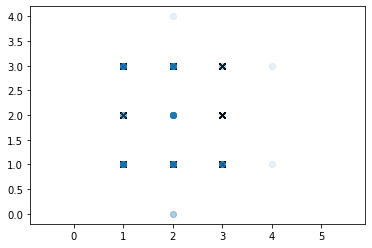

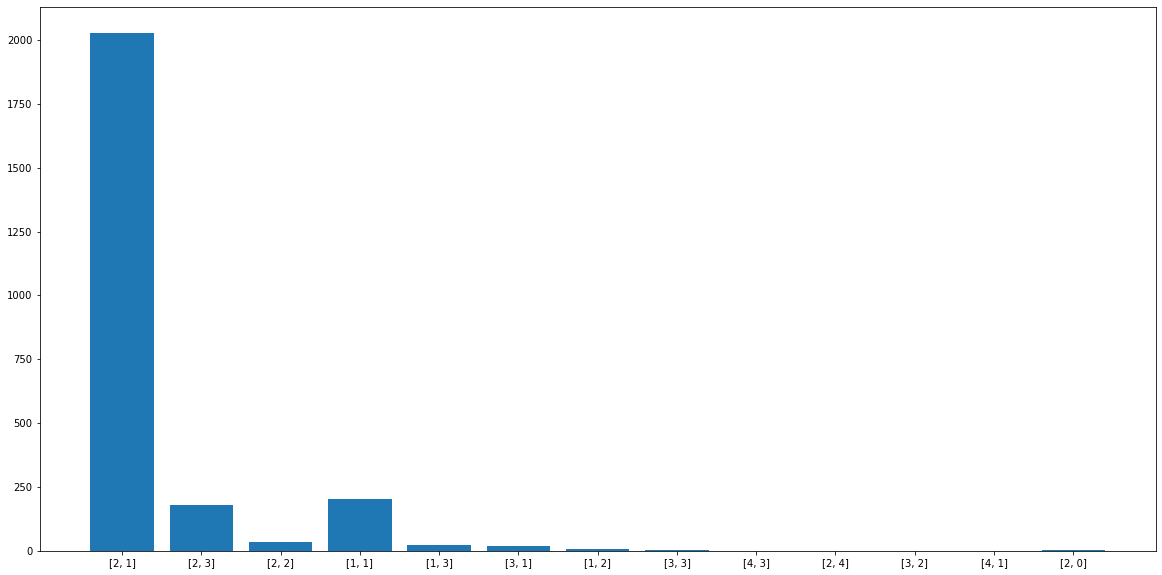

Processing Epoch 78
training start
Iteration 0, d real/fake loss 0.6499350070953369/0.698513925075531 and g loss is 0.6911721229553223, NDiv loss 0.10419918596744537
Iteration 1, d real/fake loss 0.6501972675323486/0.697437047958374 and g loss is 0.69085693359375, NDiv loss 0.08908869326114655
Iteration 2, d real/fake loss 0.6504572629928589/0.6943978071212769 and g loss is 0.6927182674407959, NDiv loss 0.11024085432291031
Iteration 3, d real/fake loss 0.6507146954536438/0.6949437856674194 and g loss is 0.6964564919471741, NDiv loss 0.10400379449129105
Iteration 4, d real/fake loss 0.6509740352630615/0.6951751112937927 and g loss is 0.6973960399627686, NDiv loss 0.10650061070919037


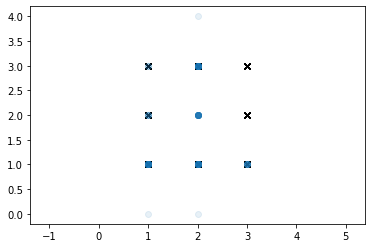

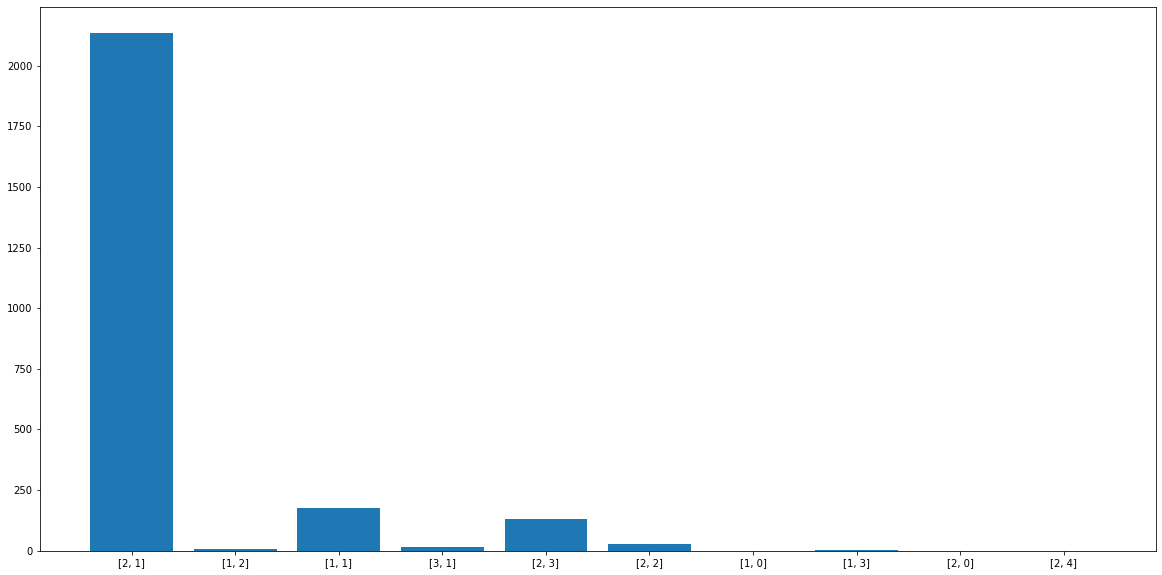

Processing Epoch 79
training start
Iteration 0, d real/fake loss 0.6523120403289795/0.6894316077232361 and g loss is 0.6971084475517273, NDiv loss 0.10440034419298172
Iteration 1, d real/fake loss 0.6525009870529175/0.6889038681983948 and g loss is 0.7035564184188843, NDiv loss 0.10421039909124374
Iteration 2, d real/fake loss 0.6526854038238525/0.6896414160728455 and g loss is 0.7024549245834351, NDiv loss 0.11150721460580826
Iteration 3, d real/fake loss 0.6528664827346802/0.686667799949646 and g loss is 0.7033292055130005, NDiv loss 0.11512824892997742
Iteration 4, d real/fake loss 0.6530429124832153/0.6839748620986938 and g loss is 0.704626739025116, NDiv loss 0.11628590524196625


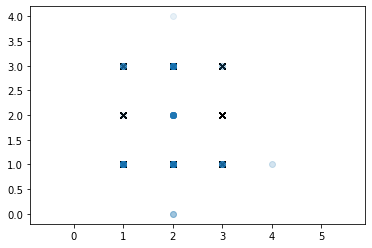

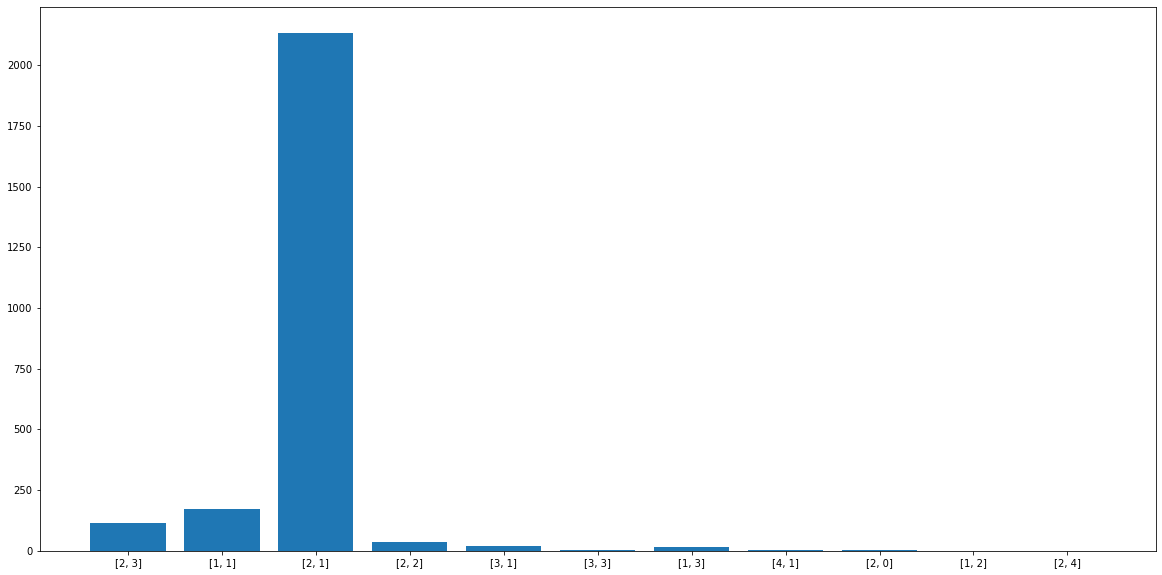

Processing Epoch 80
training start
Iteration 0, d real/fake loss 0.6557700634002686/0.6820511817932129 and g loss is 0.7053700089454651, NDiv loss 0.11414101719856262
Iteration 1, d real/fake loss 0.6561099290847778/0.6779837608337402 and g loss is 0.7068918347358704, NDiv loss 0.11611102521419525
Iteration 2, d real/fake loss 0.656432569026947/0.6791101694107056 and g loss is 0.7095987796783447, NDiv loss 0.12101814150810242
Iteration 3, d real/fake loss 0.656741201877594/0.6756904125213623 and g loss is 0.7145525217056274, NDiv loss 0.11195380985736847
Iteration 4, d real/fake loss 0.6570340394973755/0.6738925576210022 and g loss is 0.7149748802185059, NDiv loss 0.1255219280719757


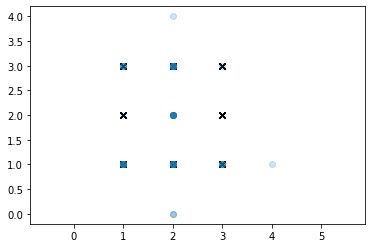

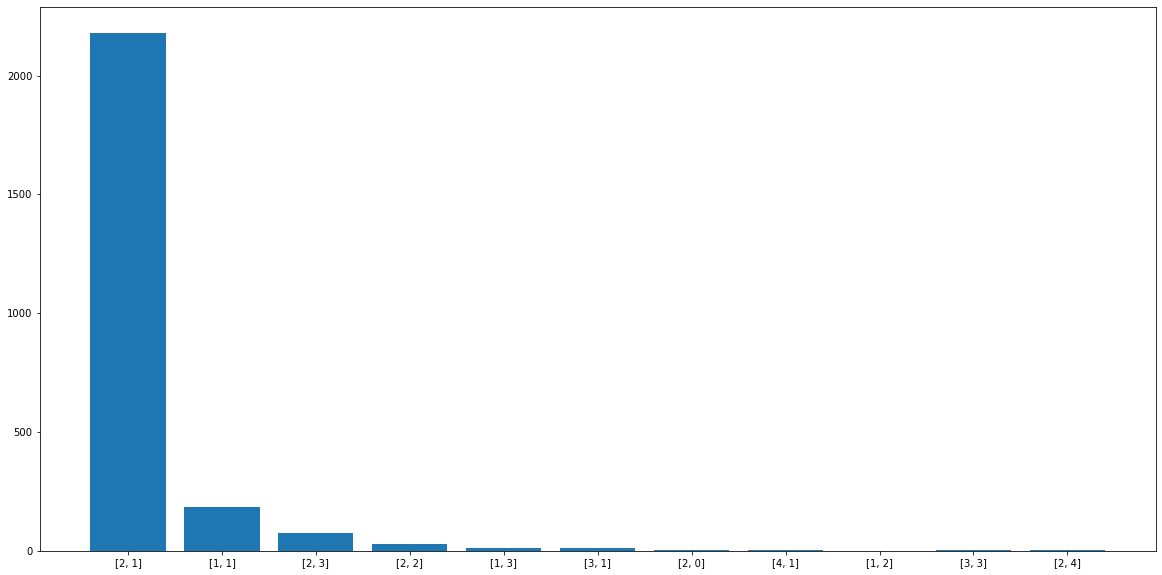

Processing Epoch 81
training start
Iteration 0, d real/fake loss 0.6675413846969604/0.6724591255187988 and g loss is 0.7150834202766418, NDiv loss 0.1073419600725174
Iteration 1, d real/fake loss 0.6680964231491089/0.6682661175727844 and g loss is 0.7184866070747375, NDiv loss 0.12684684991836548
Iteration 2, d real/fake loss 0.6686307787895203/0.6682498455047607 and g loss is 0.720116138458252, NDiv loss 0.13726723194122314
Iteration 3, d real/fake loss 0.6691445708274841/0.6677483320236206 and g loss is 0.7230464220046997, NDiv loss 0.11503402888774872
Iteration 4, d real/fake loss 0.6696394681930542/0.6657192707061768 and g loss is 0.7254936695098877, NDiv loss 0.11502546072006226


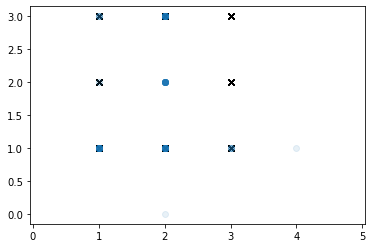

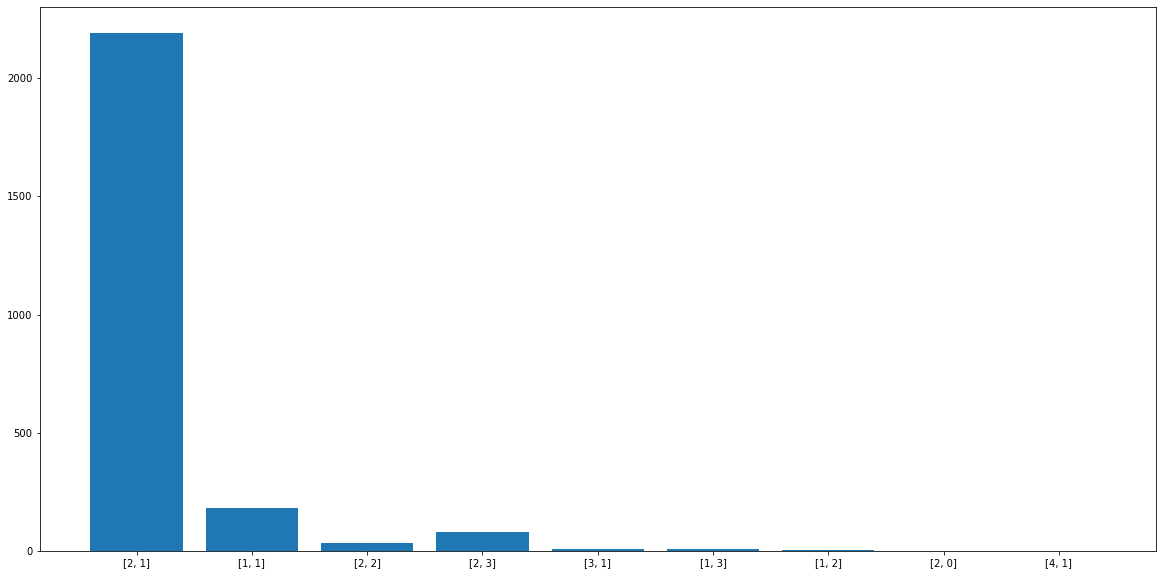

Processing Epoch 82
training start
Iteration 0, d real/fake loss 0.6613733768463135/0.6621602773666382 and g loss is 0.7262203097343445, NDiv loss 0.11675215512514114
Iteration 1, d real/fake loss 0.661404550075531/0.6620081067085266 and g loss is 0.7284989953041077, NDiv loss 0.137142151594162
Iteration 2, d real/fake loss 0.6614266633987427/0.6613779067993164 and g loss is 0.7275282144546509, NDiv loss 0.12038010358810425
Iteration 3, d real/fake loss 0.6614395976066589/0.6572120785713196 and g loss is 0.7310200929641724, NDiv loss 0.12960410118103027
Iteration 4, d real/fake loss 0.6614405512809753/0.6597278118133545 and g loss is 0.7329050898551941, NDiv loss 0.11257107555866241


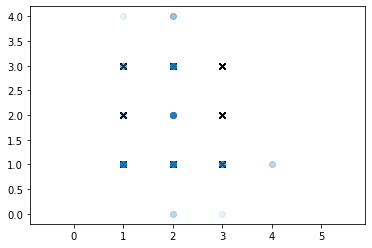

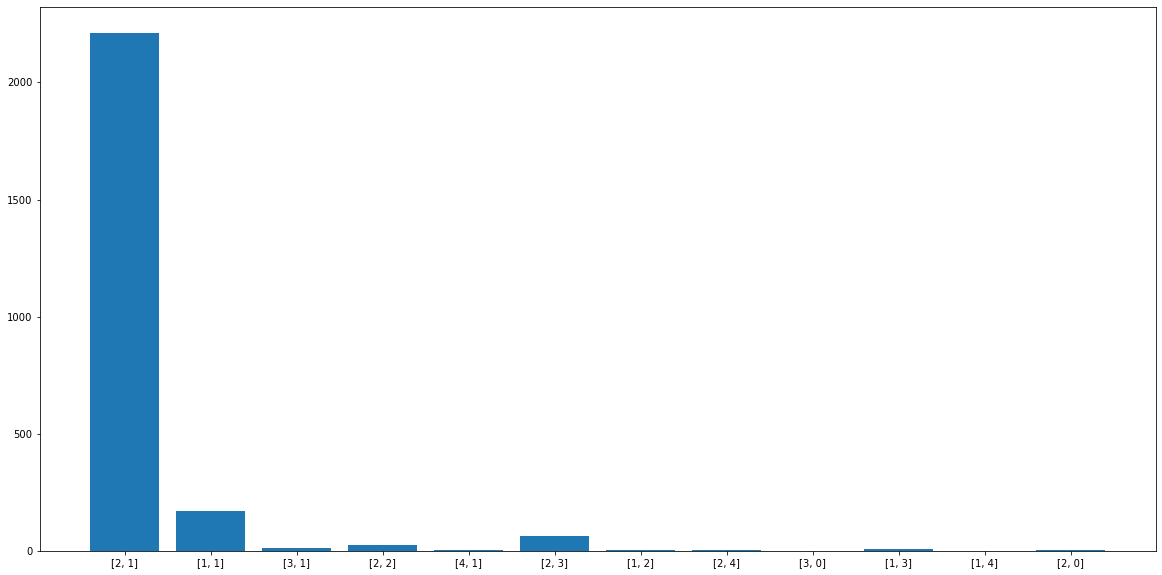

Processing Epoch 83
training start
Iteration 0, d real/fake loss 0.6659595966339111/0.6552045345306396 and g loss is 0.7335720062255859, NDiv loss 0.1392698734998703
Iteration 1, d real/fake loss 0.6660974025726318/0.6530426740646362 and g loss is 0.7373395562171936, NDiv loss 0.12810975313186646
Iteration 2, d real/fake loss 0.6662186980247498/0.6491468548774719 and g loss is 0.7404402494430542, NDiv loss 0.14345329999923706
Iteration 3, d real/fake loss 0.6663241386413574/0.6511729955673218 and g loss is 0.7409387826919556, NDiv loss 0.11979066580533981
Iteration 4, d real/fake loss 0.6664178967475891/0.6471601128578186 and g loss is 0.7421901226043701, NDiv loss 0.13123184442520142


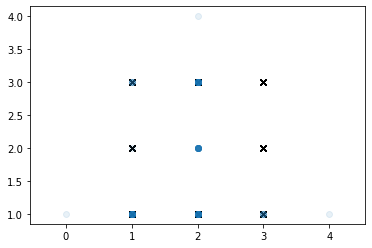

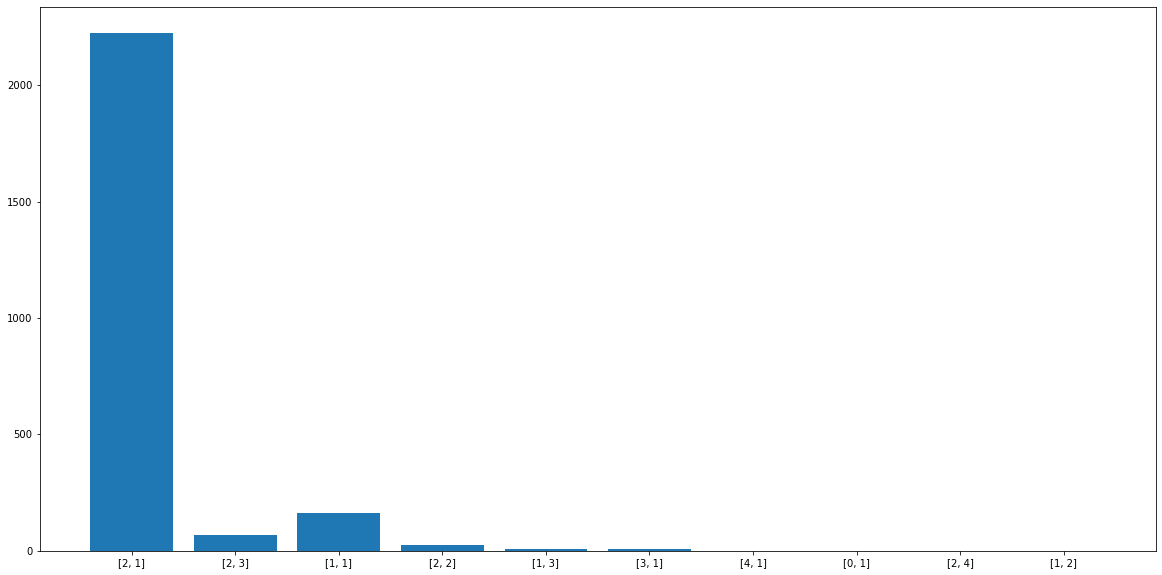

Processing Epoch 84
training start
Iteration 0, d real/fake loss 0.6572166681289673/0.6475045680999756 and g loss is 0.7438821196556091, NDiv loss 0.13167881965637207
Iteration 1, d real/fake loss 0.657282829284668/0.6434783935546875 and g loss is 0.7463424205780029, NDiv loss 0.12420336902141571
Iteration 2, d real/fake loss 0.6573389768600464/0.6437314748764038 and g loss is 0.7478923201560974, NDiv loss 0.1387149691581726
Iteration 3, d real/fake loss 0.6573883295059204/0.6398313045501709 and g loss is 0.74900221824646, NDiv loss 0.11285709589719772
Iteration 4, d real/fake loss 0.6574304699897766/0.6415480375289917 and g loss is 0.7525354027748108, NDiv loss 0.10898301750421524


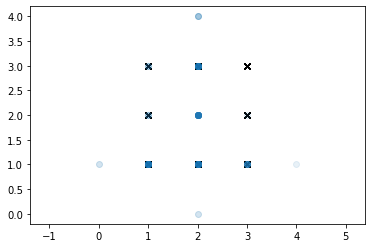

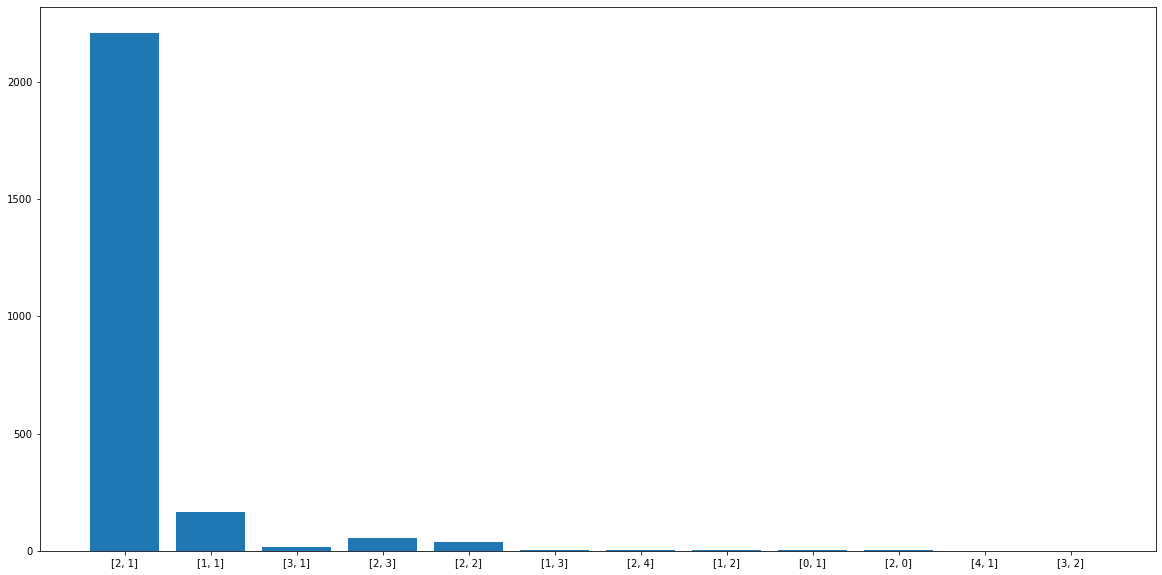

Processing Epoch 85
training start
Iteration 0, d real/fake loss 0.6656949520111084/0.6402369141578674 and g loss is 0.75435870885849, NDiv loss 0.12471156567335129
Iteration 1, d real/fake loss 0.6657163500785828/0.637262225151062 and g loss is 0.755893349647522, NDiv loss 0.1309358924627304
Iteration 2, d real/fake loss 0.6657281517982483/0.6358085870742798 and g loss is 0.7552390694618225, NDiv loss 0.1239270567893982
Iteration 3, d real/fake loss 0.6657329201698303/0.632105827331543 and g loss is 0.7594113349914551, NDiv loss 0.13274231553077698
Iteration 4, d real/fake loss 0.665725827217102/0.632387101650238 and g loss is 0.7599108219146729, NDiv loss 0.12567450106143951


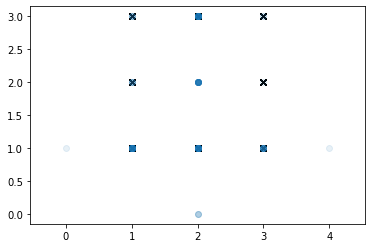

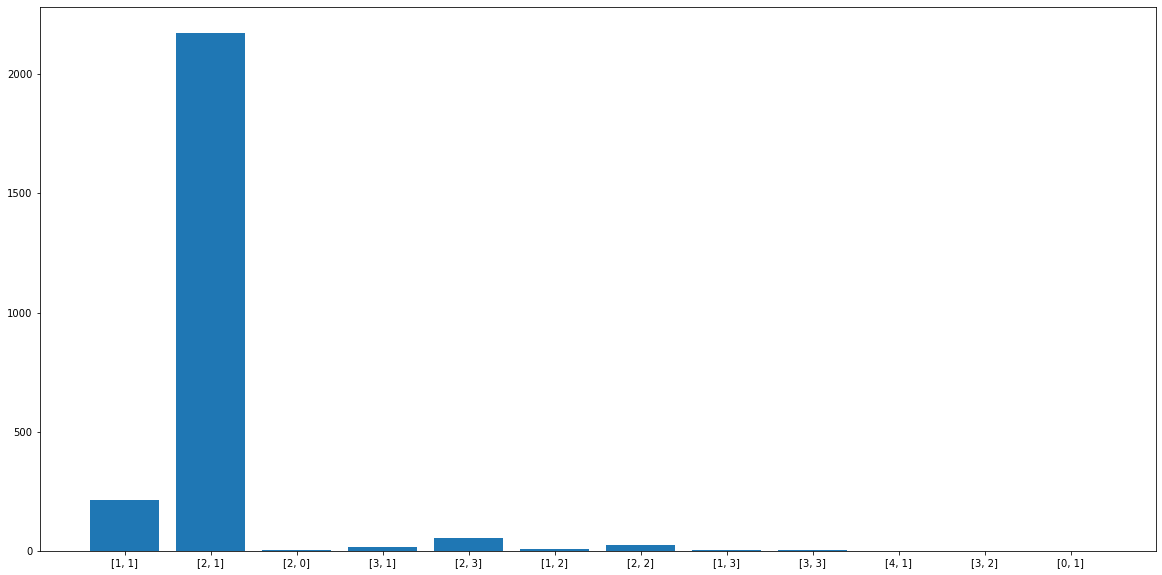

Processing Epoch 86
training start
Iteration 0, d real/fake loss 0.6750092506408691/0.6305321455001831 and g loss is 0.7652537822723389, NDiv loss 0.12636877596378326
Iteration 1, d real/fake loss 0.674943745136261/0.6310619711875916 and g loss is 0.7611727714538574, NDiv loss 0.10990932583808899
Iteration 2, d real/fake loss 0.674868106842041/0.6290654540061951 and g loss is 0.7622959017753601, NDiv loss 0.12055563181638718
Iteration 3, d real/fake loss 0.6747834086418152/0.6281791925430298 and g loss is 0.7618815898895264, NDiv loss 0.13798104226589203
Iteration 4, d real/fake loss 0.6746904850006104/0.6284893751144409 and g loss is 0.7694212198257446, NDiv loss 0.13540376722812653


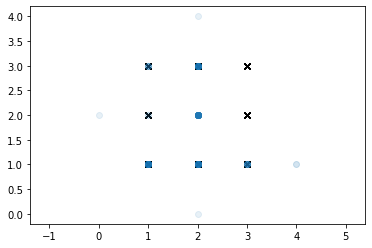

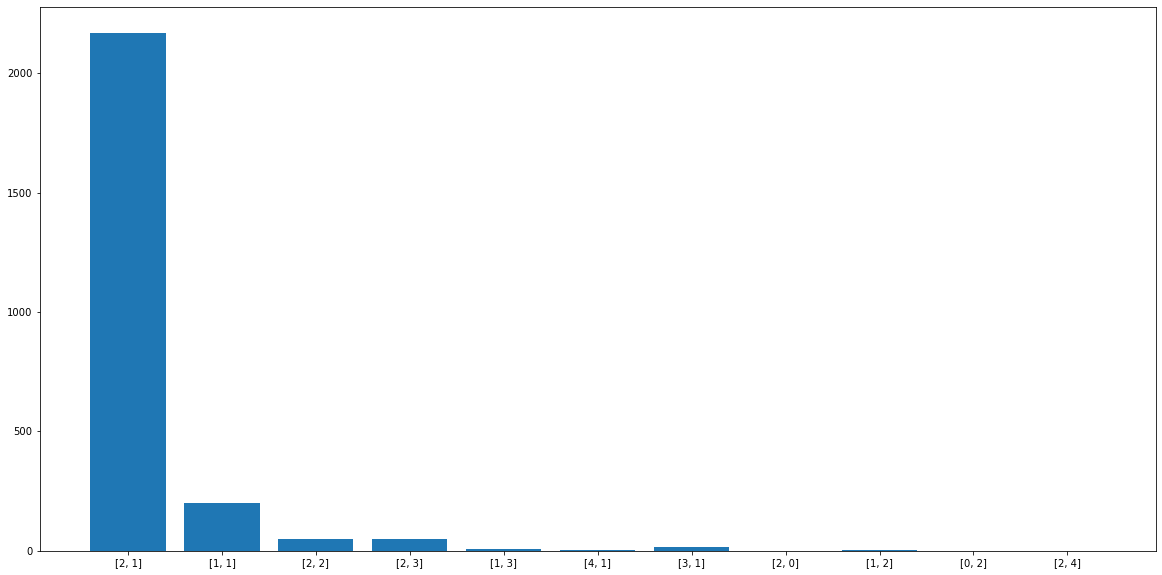

Processing Epoch 87
training start
Iteration 0, d real/fake loss 0.660765528678894/0.6251530647277832 and g loss is 0.772067666053772, NDiv loss 0.1273767203092575
Iteration 1, d real/fake loss 0.660790205001831/0.6235557794570923 and g loss is 0.7724157571792603, NDiv loss 0.1173487976193428
Iteration 2, d real/fake loss 0.660793662071228/0.61985182762146 and g loss is 0.7710886001586914, NDiv loss 0.10375720262527466
Iteration 3, d real/fake loss 0.660774827003479/0.6158450245857239 and g loss is 0.7671123743057251, NDiv loss 0.11400305479764938
Iteration 4, d real/fake loss 0.660733699798584/0.6219666004180908 and g loss is 0.7691440582275391, NDiv loss 0.12162858247756958


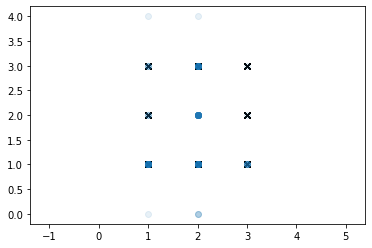

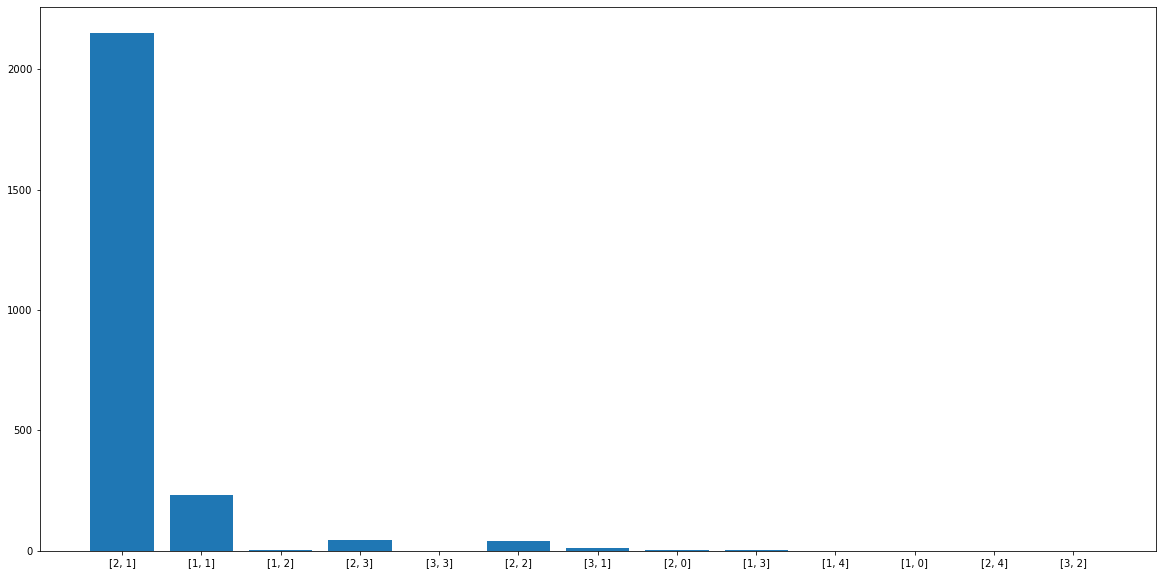

Processing Epoch 88
training start
Iteration 0, d real/fake loss 0.6668741703033447/0.6170920133590698 and g loss is 0.772594153881073, NDiv loss 0.11327794939279556
Iteration 1, d real/fake loss 0.6668421030044556/0.6184863448143005 and g loss is 0.780410885810852, NDiv loss 0.11876004189252853
Iteration 2, d real/fake loss 0.6667987108230591/0.6168366074562073 and g loss is 0.7717682123184204, NDiv loss 0.1145700141787529
Iteration 3, d real/fake loss 0.6667441129684448/0.6161823272705078 and g loss is 0.7753243446350098, NDiv loss 0.11600669473409653
Iteration 4, d real/fake loss 0.6666805148124695/0.6167890429496765 and g loss is 0.7795385122299194, NDiv loss 0.10423582047224045


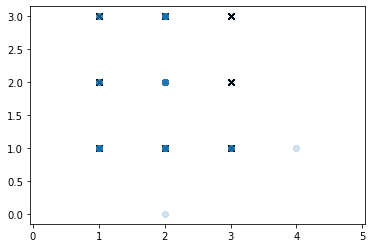

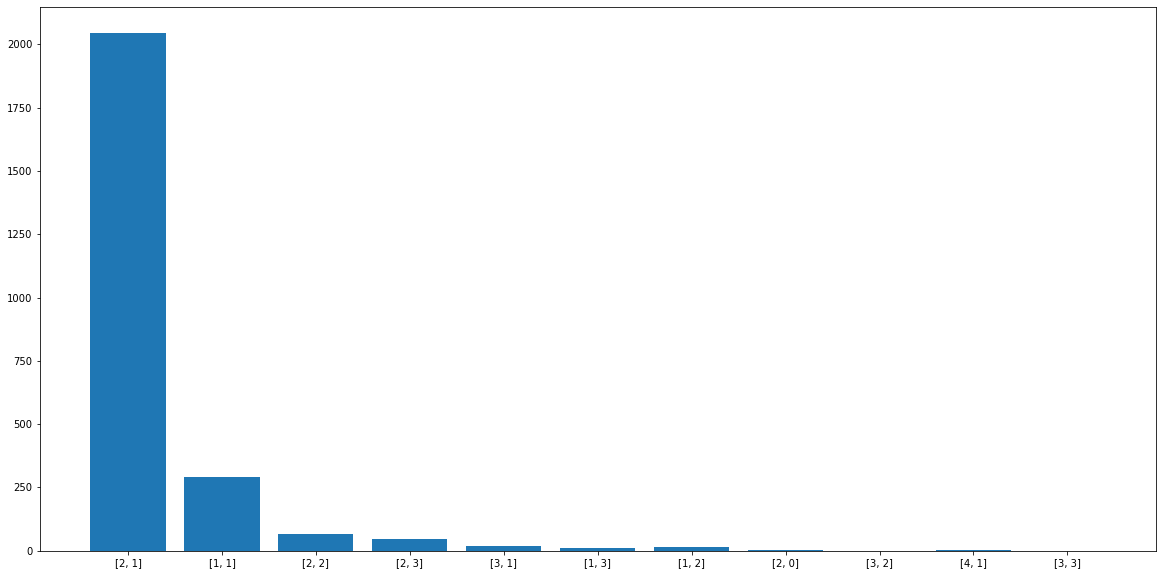

Processing Epoch 89
training start
Iteration 0, d real/fake loss 0.6726779937744141/0.6185708045959473 and g loss is 0.7805976271629333, NDiv loss 0.12882310152053833
Iteration 1, d real/fake loss 0.6725183725357056/0.6134043335914612 and g loss is 0.7800880670547485, NDiv loss 0.11778949946165085
Iteration 2, d real/fake loss 0.6723487377166748/0.6164282560348511 and g loss is 0.7771834135055542, NDiv loss 0.1122790053486824
Iteration 3, d real/fake loss 0.672170877456665/0.6153438091278076 and g loss is 0.7771774530410767, NDiv loss 0.10152728110551834
Iteration 4, d real/fake loss 0.6719889640808105/0.6151289343833923 and g loss is 0.779604434967041, NDiv loss 0.10414782166481018


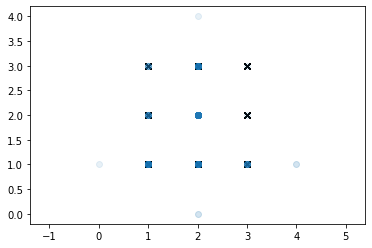

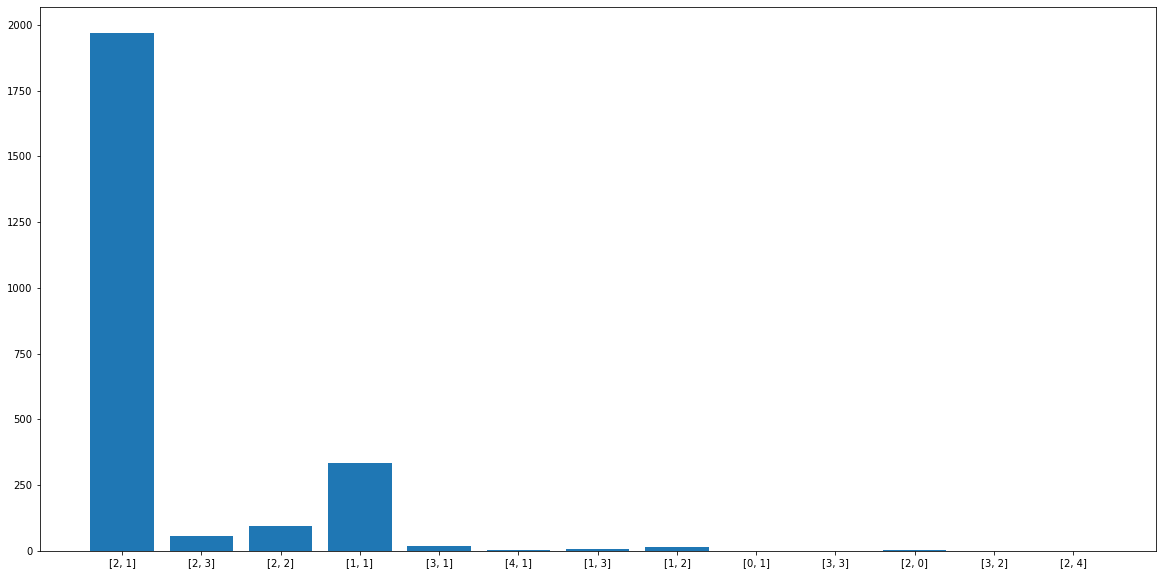

Processing Epoch 90
training start
Iteration 0, d real/fake loss 0.6563109755516052/0.6146551370620728 and g loss is 0.780941903591156, NDiv loss 0.10036337375640869
Iteration 1, d real/fake loss 0.656132698059082/0.614926815032959 and g loss is 0.7769505977630615, NDiv loss 0.0923922136425972
Iteration 2, d real/fake loss 0.6559532880783081/0.6132084131240845 and g loss is 0.7783206701278687, NDiv loss 0.09242376685142517
Iteration 3, d real/fake loss 0.6557730436325073/0.6166777610778809 and g loss is 0.7801277041435242, NDiv loss 0.1013856753706932
Iteration 4, d real/fake loss 0.6555948257446289/0.6225907206535339 and g loss is 0.7713408470153809, NDiv loss 0.10553635656833649


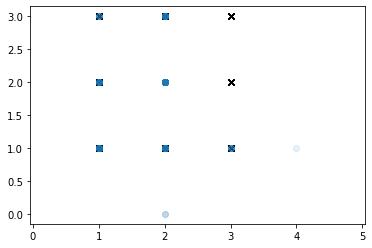

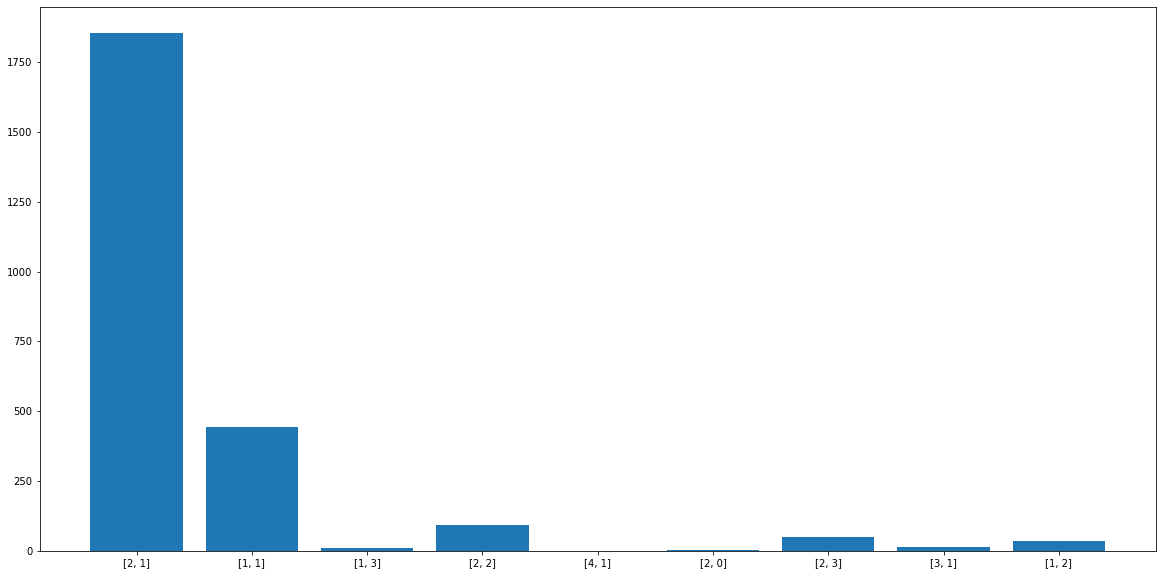

Processing Epoch 91
training start
Iteration 0, d real/fake loss 0.6513069272041321/0.6111084222793579 and g loss is 0.7809554934501648, NDiv loss 0.09860511869192123
Iteration 1, d real/fake loss 0.6511439085006714/0.6168406009674072 and g loss is 0.770840048789978, NDiv loss 0.0948125347495079
Iteration 2, d real/fake loss 0.650977373123169/0.618366003036499 and g loss is 0.7782437801361084, NDiv loss 0.09177330136299133
Iteration 3, d real/fake loss 0.6508082151412964/0.6203441619873047 and g loss is 0.7787572145462036, NDiv loss 0.09641633182764053
Iteration 4, d real/fake loss 0.6506407856941223/0.619086742401123 and g loss is 0.771345853805542, NDiv loss 0.09494832903146744


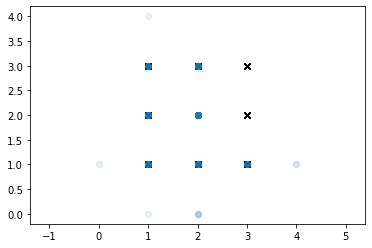

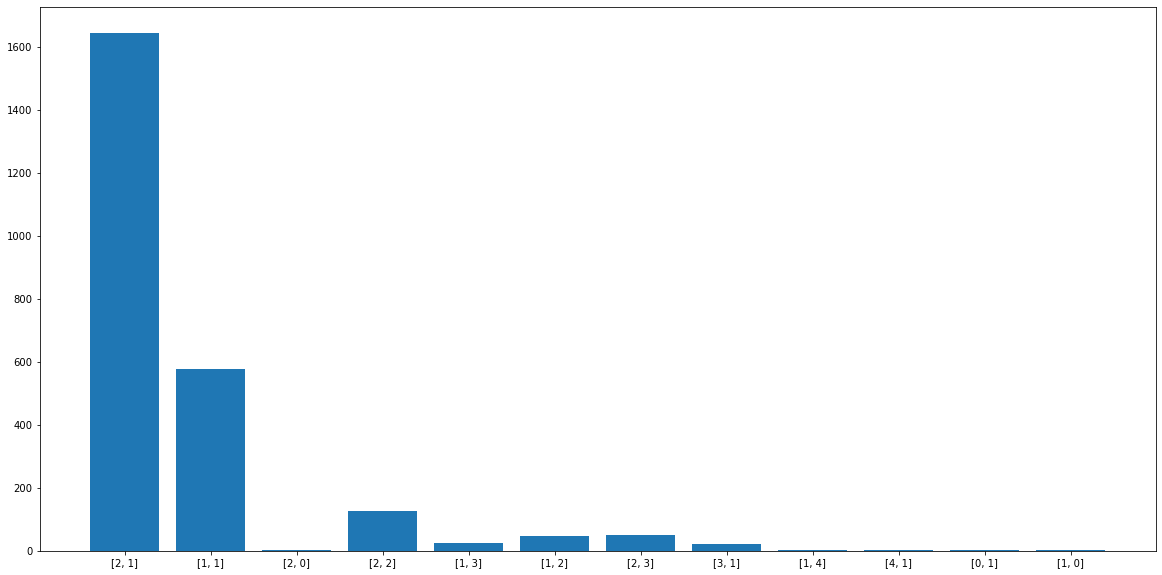

Processing Epoch 92
training start
Iteration 0, d real/fake loss 0.66066575050354/0.6241991519927979 and g loss is 0.7731227278709412, NDiv loss 0.08484555035829544
Iteration 1, d real/fake loss 0.6604465246200562/0.6241908073425293 and g loss is 0.7725458145141602, NDiv loss 0.09488646686077118
Iteration 2, d real/fake loss 0.6602357029914856/0.6207230687141418 and g loss is 0.7688397169113159, NDiv loss 0.09201809763908386
Iteration 3, d real/fake loss 0.6600341200828552/0.6292657852172852 and g loss is 0.7679630517959595, NDiv loss 0.087802954018116
Iteration 4, d real/fake loss 0.659842848777771/0.6197212338447571 and g loss is 0.7666420936584473, NDiv loss 0.08300188183784485


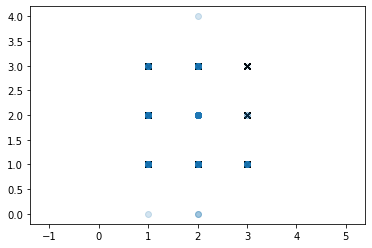

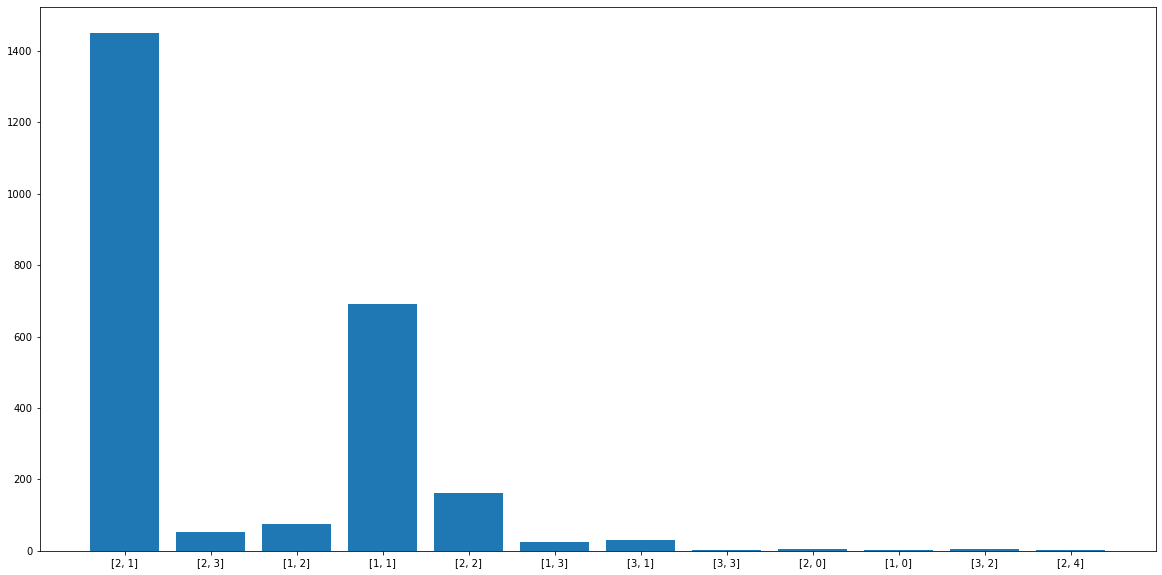

Processing Epoch 93
training start
Iteration 0, d real/fake loss 0.6548712253570557/0.6243975162506104 and g loss is 0.7659492492675781, NDiv loss 0.09828051924705505
Iteration 1, d real/fake loss 0.6547876596450806/0.625708818435669 and g loss is 0.7682307958602905, NDiv loss 0.08558288961648941
Iteration 2, d real/fake loss 0.6547075510025024/0.6247262954711914 and g loss is 0.7750914096832275, NDiv loss 0.08190765976905823
Iteration 3, d real/fake loss 0.6546351909637451/0.6306900382041931 and g loss is 0.7683290839195251, NDiv loss 0.07954350113868713
Iteration 4, d real/fake loss 0.6545720100402832/0.6289381980895996 and g loss is 0.7578724026679993, NDiv loss 0.08289781957864761


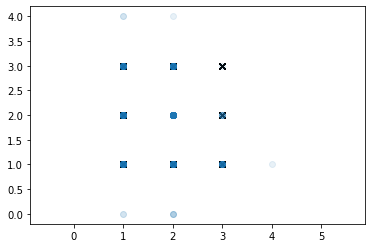

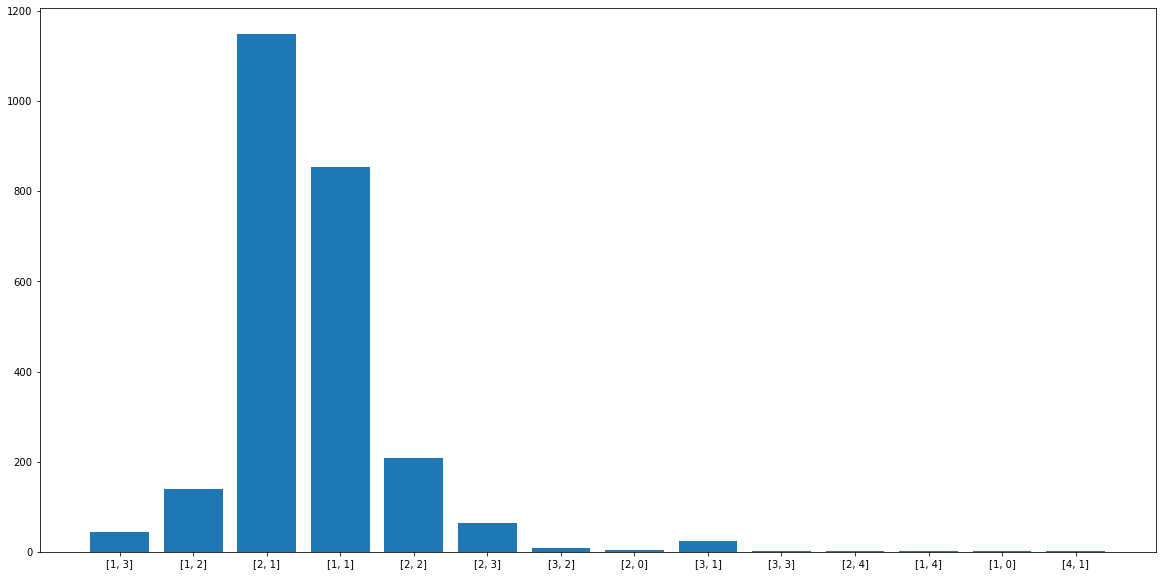

Processing Epoch 94
training start
Iteration 0, d real/fake loss 0.6631134152412415/0.6363279819488525 and g loss is 0.7635568380355835, NDiv loss 0.07741145044565201
Iteration 1, d real/fake loss 0.6630358099937439/0.6354653835296631 and g loss is 0.7558559775352478, NDiv loss 0.08339158445596695
Iteration 2, d real/fake loss 0.662958562374115/0.6432561278343201 and g loss is 0.7433499097824097, NDiv loss 0.08107177913188934
Iteration 3, d real/fake loss 0.6628909111022949/0.6501527428627014 and g loss is 0.758674144744873, NDiv loss 0.07959562540054321
Iteration 4, d real/fake loss 0.6628351211547852/0.6452212333679199 and g loss is 0.7384182214736938, NDiv loss 0.07063449174165726


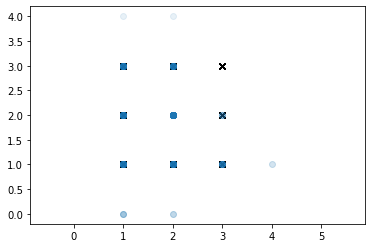

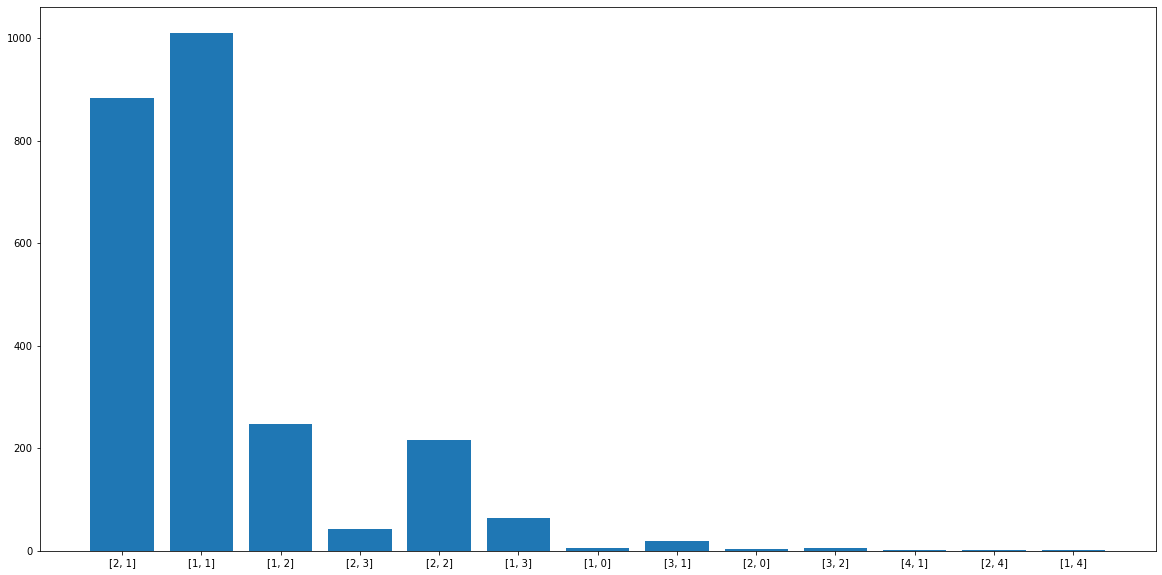

Processing Epoch 95
training start
Iteration 0, d real/fake loss 0.6523686051368713/0.6623274087905884 and g loss is 0.7428678274154663, NDiv loss 0.07384036481380463
Iteration 1, d real/fake loss 0.6523348093032837/0.6764975190162659 and g loss is 0.7492515444755554, NDiv loss 0.07349801063537598
Iteration 2, d real/fake loss 0.6523356437683105/0.6574802994728088 and g loss is 0.7289067506790161, NDiv loss 0.07802488654851913
Iteration 3, d real/fake loss 0.652349591255188/0.6614147424697876 and g loss is 0.7300599217414856, NDiv loss 0.07707513868808746
Iteration 4, d real/fake loss 0.6523803472518921/0.6612227559089661 and g loss is 0.7234565019607544, NDiv loss 0.07416283339262009


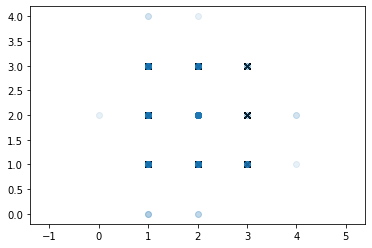

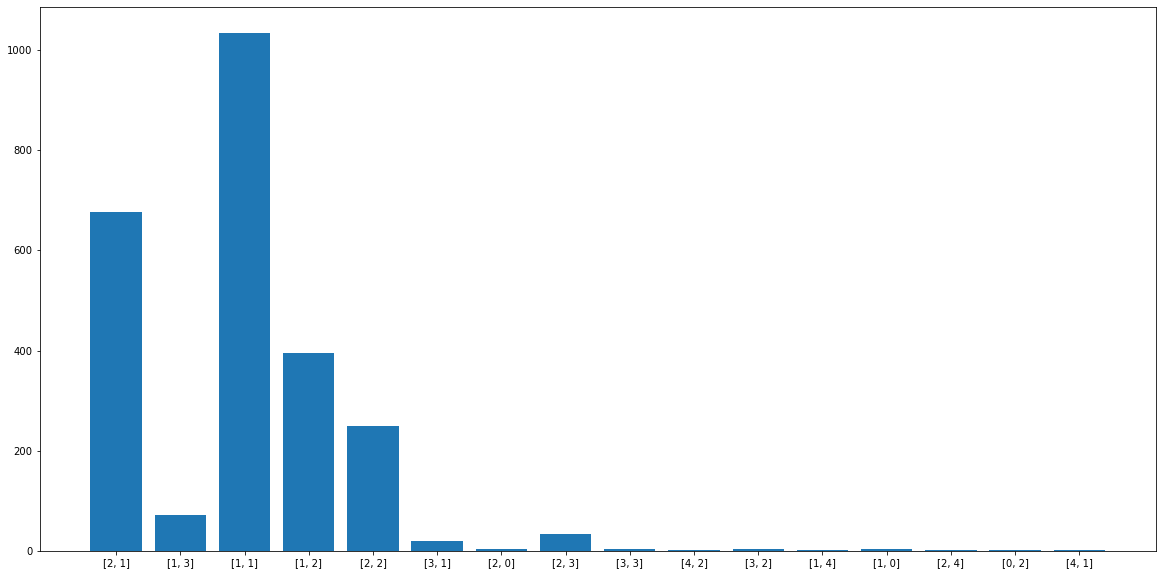

Processing Epoch 96
training start
Iteration 0, d real/fake loss 0.6601971387863159/0.6615703105926514 and g loss is 0.7204489707946777, NDiv loss 0.07348138839006424
Iteration 1, d real/fake loss 0.6602582335472107/0.6730985045433044 and g loss is 0.7293611764907837, NDiv loss 0.07405662536621094
Iteration 2, d real/fake loss 0.6603353023529053/0.6757262349128723 and g loss is 0.7172507047653198, NDiv loss 0.0722522884607315
Iteration 3, d real/fake loss 0.6604286432266235/0.6909723281860352 and g loss is 0.7186188101768494, NDiv loss 0.07310215383768082
Iteration 4, d real/fake loss 0.6605494022369385/0.6921107769012451 and g loss is 0.6967786550521851, NDiv loss 0.07640691101551056


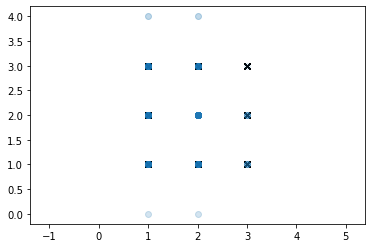

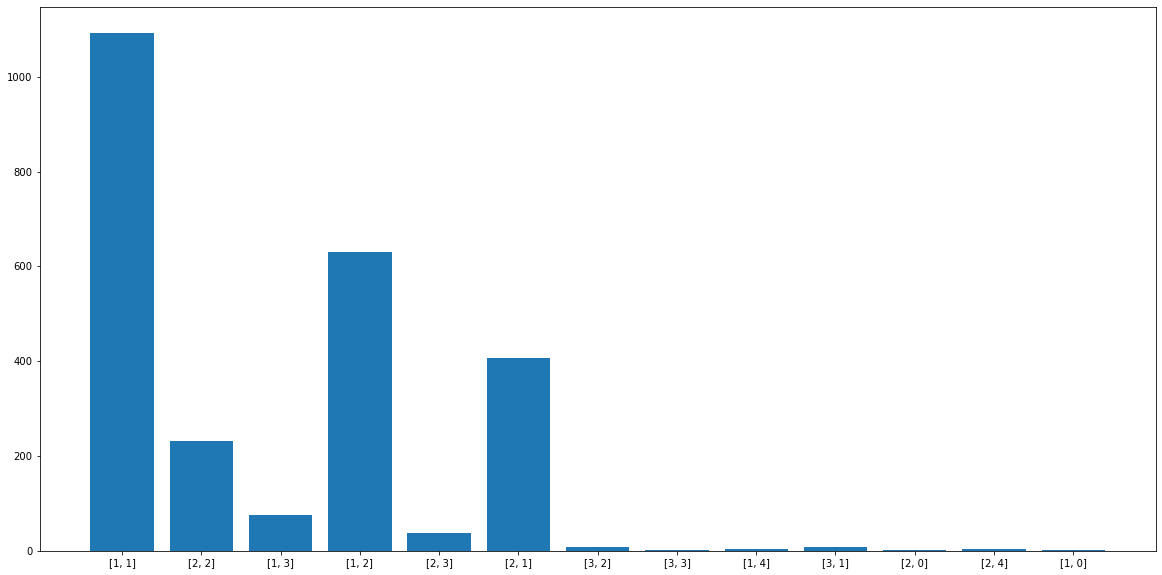

Processing Epoch 97
training start
Iteration 0, d real/fake loss 0.658031165599823/0.6923814415931702 and g loss is 0.7067696452140808, NDiv loss 0.07273457199335098
Iteration 1, d real/fake loss 0.6582238078117371/0.6951987147331238 and g loss is 0.6935415267944336, NDiv loss 0.06790836900472641
Iteration 2, d real/fake loss 0.6584388017654419/0.7099010944366455 and g loss is 0.6822672486305237, NDiv loss 0.07569735497236252
Iteration 3, d real/fake loss 0.6586823463439941/0.7080649137496948 and g loss is 0.6915830373764038, NDiv loss 0.07036992162466049
Iteration 4, d real/fake loss 0.6589503288269043/0.701263964176178 and g loss is 0.6811990737915039, NDiv loss 0.07110942900180817


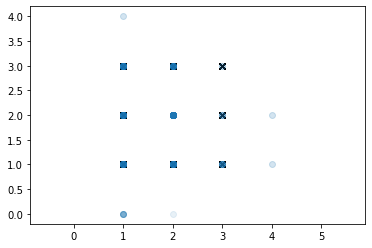

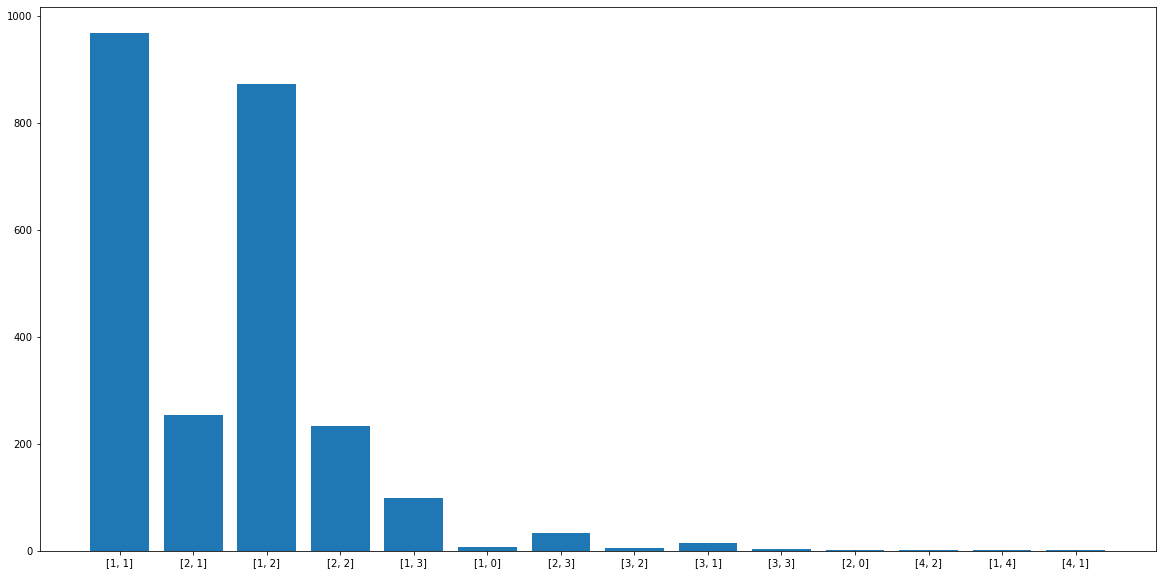

Processing Epoch 98
training start
Iteration 0, d real/fake loss 0.6725282669067383/0.7241731882095337 and g loss is 0.6731089949607849, NDiv loss 0.06948130577802658
Iteration 1, d real/fake loss 0.6729329228401184/0.7119971513748169 and g loss is 0.6706856489181519, NDiv loss 0.07116280496120453
Iteration 2, d real/fake loss 0.6733391284942627/0.7187891006469727 and g loss is 0.6734533309936523, NDiv loss 0.07752303779125214
Iteration 3, d real/fake loss 0.6737498044967651/0.7307602763175964 and g loss is 0.6657618284225464, NDiv loss 0.0766429677605629
Iteration 4, d real/fake loss 0.6741690039634705/0.7207508087158203 and g loss is 0.6619998216629028, NDiv loss 0.0834115743637085


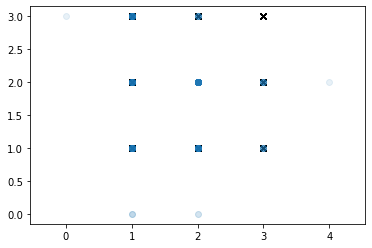

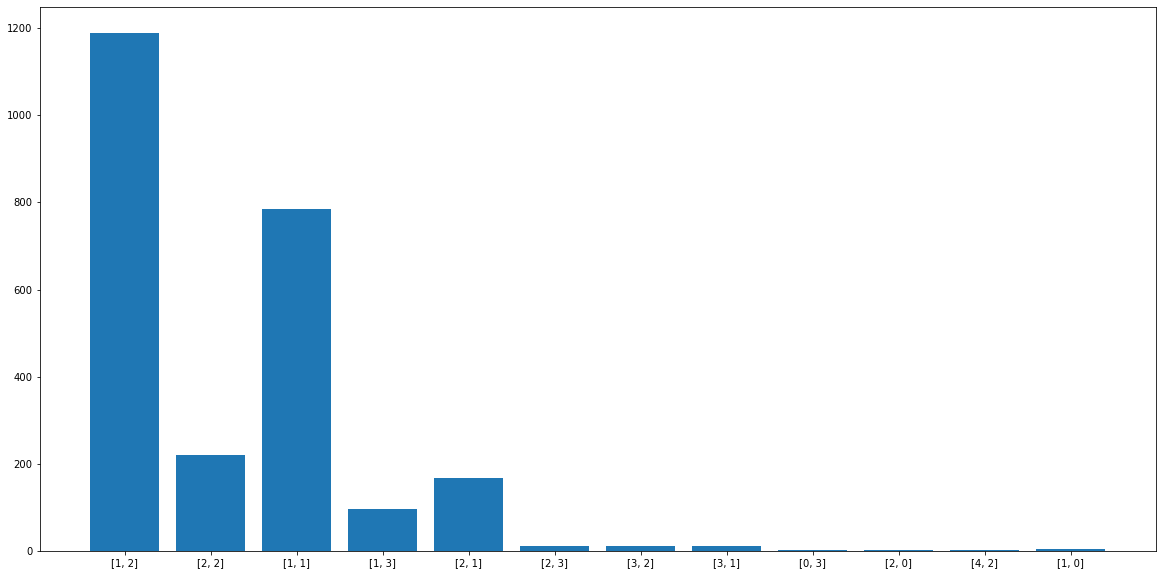

Processing Epoch 99
training start
Iteration 0, d real/fake loss 0.6517101526260376/0.7451842427253723 and g loss is 0.652812123298645, NDiv loss 0.08005458861589432
Iteration 1, d real/fake loss 0.6518903970718384/0.741233229637146 and g loss is 0.660138726234436, NDiv loss 0.08161695301532745
Iteration 2, d real/fake loss 0.6521035432815552/0.7507808208465576 and g loss is 0.6327859163284302, NDiv loss 0.08772527426481247
Iteration 3, d real/fake loss 0.6523505449295044/0.754265308380127 and g loss is 0.6361877918243408, NDiv loss 0.08055692166090012
Iteration 4, d real/fake loss 0.6526303291320801/0.7595771551132202 and g loss is 0.652019202709198, NDiv loss 0.07665612548589706


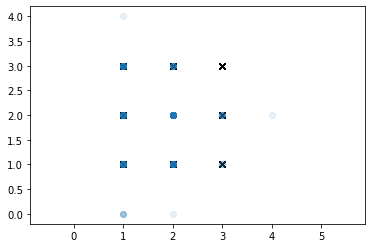

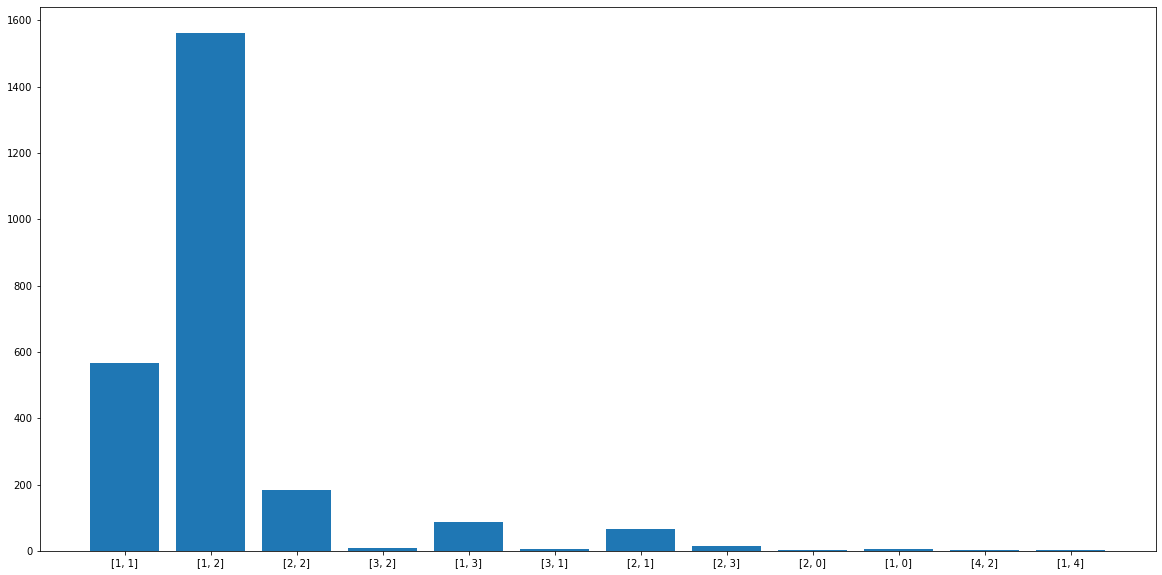

Processing Epoch 100
training start
Iteration 0, d real/fake loss 0.6578172445297241/0.7544043660163879 and g loss is 0.6390145421028137, NDiv loss 0.07940765470266342
Iteration 1, d real/fake loss 0.658431351184845/0.7620970010757446 and g loss is 0.6259520649909973, NDiv loss 0.08718413859605789
Iteration 2, d real/fake loss 0.6590598821640015/0.7807241678237915 and g loss is 0.6248460412025452, NDiv loss 0.090152308344841
Iteration 3, d real/fake loss 0.6597115397453308/0.785731315612793 and g loss is 0.6153780221939087, NDiv loss 0.08647032827138901
Iteration 4, d real/fake loss 0.6603838801383972/0.7756962776184082 and g loss is 0.6185075044631958, NDiv loss 0.09040109068155289


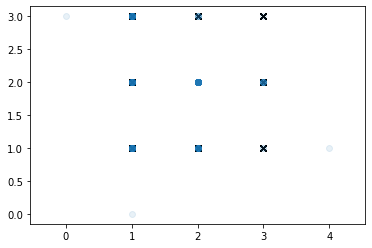

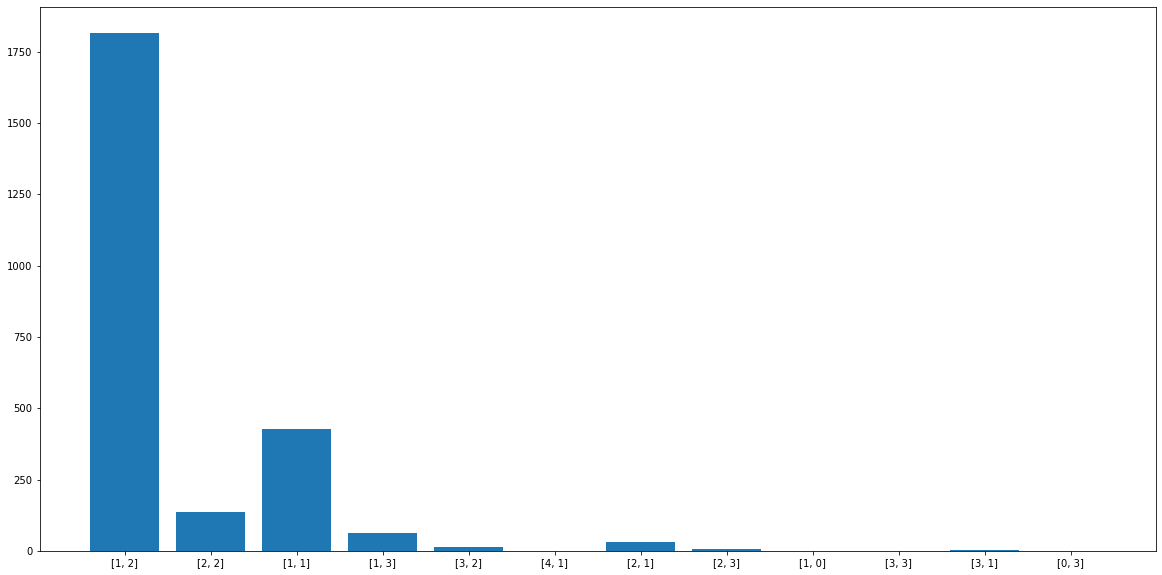

Processing Epoch 101
training start
Iteration 0, d real/fake loss 0.6428583264350891/0.7861839532852173 and g loss is 0.625690221786499, NDiv loss 0.1065652146935463
Iteration 1, d real/fake loss 0.6435471773147583/0.7935497164726257 and g loss is 0.614314079284668, NDiv loss 0.08549069613218307
Iteration 2, d real/fake loss 0.6442641615867615/0.7784321308135986 and g loss is 0.6079232692718506, NDiv loss 0.09644734859466553
Iteration 3, d real/fake loss 0.6449956893920898/0.8029118776321411 and g loss is 0.6044008135795593, NDiv loss 0.10283169150352478
Iteration 4, d real/fake loss 0.6457527875900269/0.7879574298858643 and g loss is 0.5972305536270142, NDiv loss 0.09600073099136353


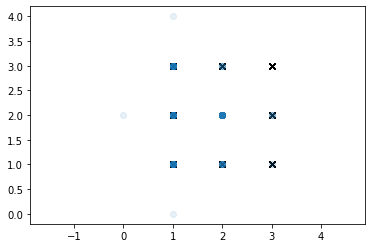

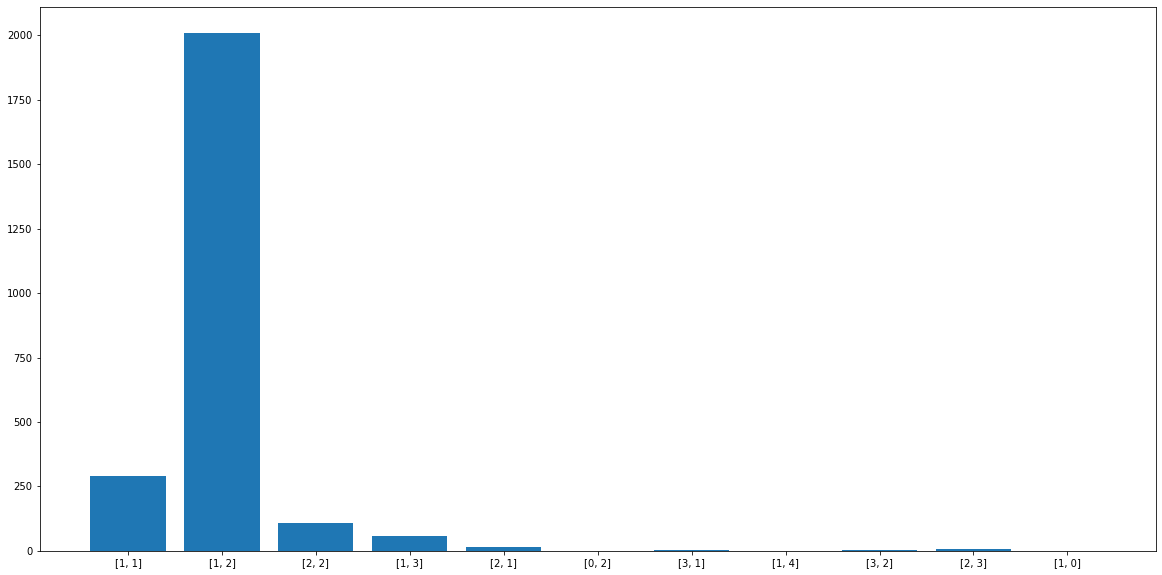

Processing Epoch 102
training start
Iteration 0, d real/fake loss 0.6682127714157104/0.7994814515113831 and g loss is 0.5935194492340088, NDiv loss 0.11008508503437042
Iteration 1, d real/fake loss 0.669075071811676/0.8016952276229858 and g loss is 0.600080132484436, NDiv loss 0.10018127411603928
Iteration 2, d real/fake loss 0.6699389219284058/0.8127723932266235 and g loss is 0.591161847114563, NDiv loss 0.1061517745256424
Iteration 3, d real/fake loss 0.6708081960678101/0.7999598979949951 and g loss is 0.6062734127044678, NDiv loss 0.10544142127037048
Iteration 4, d real/fake loss 0.6716762781143188/0.8096607327461243 and g loss is 0.5921590328216553, NDiv loss 0.11572142690420151


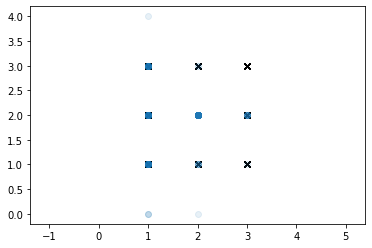

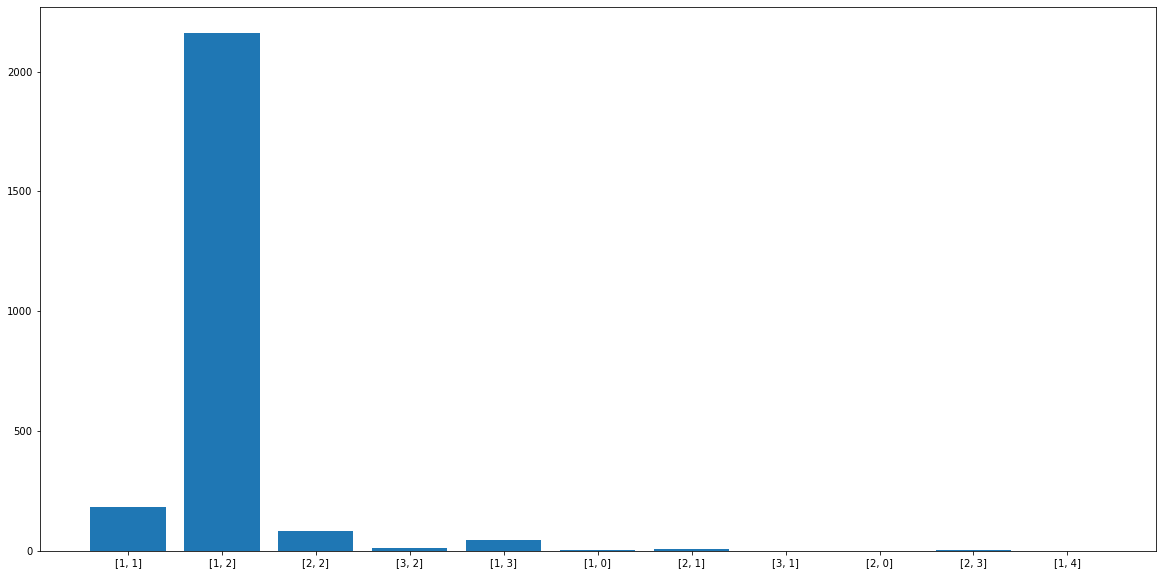

Processing Epoch 103
training start
Iteration 0, d real/fake loss 0.6890321969985962/0.8126310110092163 and g loss is 0.5971641540527344, NDiv loss 0.12097679823637009
Iteration 1, d real/fake loss 0.6896517276763916/0.8141723275184631 and g loss is 0.5919772386550903, NDiv loss 0.12635160982608795
Iteration 2, d real/fake loss 0.6902574896812439/0.8082938194274902 and g loss is 0.5945360660552979, NDiv loss 0.11414752900600433
Iteration 3, d real/fake loss 0.690849244594574/0.8137791156768799 and g loss is 0.5973811149597168, NDiv loss 0.13204099237918854
Iteration 4, d real/fake loss 0.6914293169975281/0.8203088641166687 and g loss is 0.5986008644104004, NDiv loss 0.13257980346679688


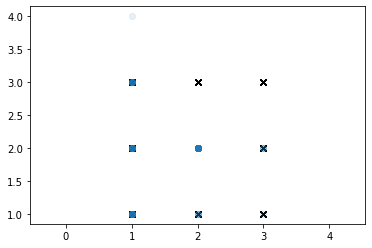

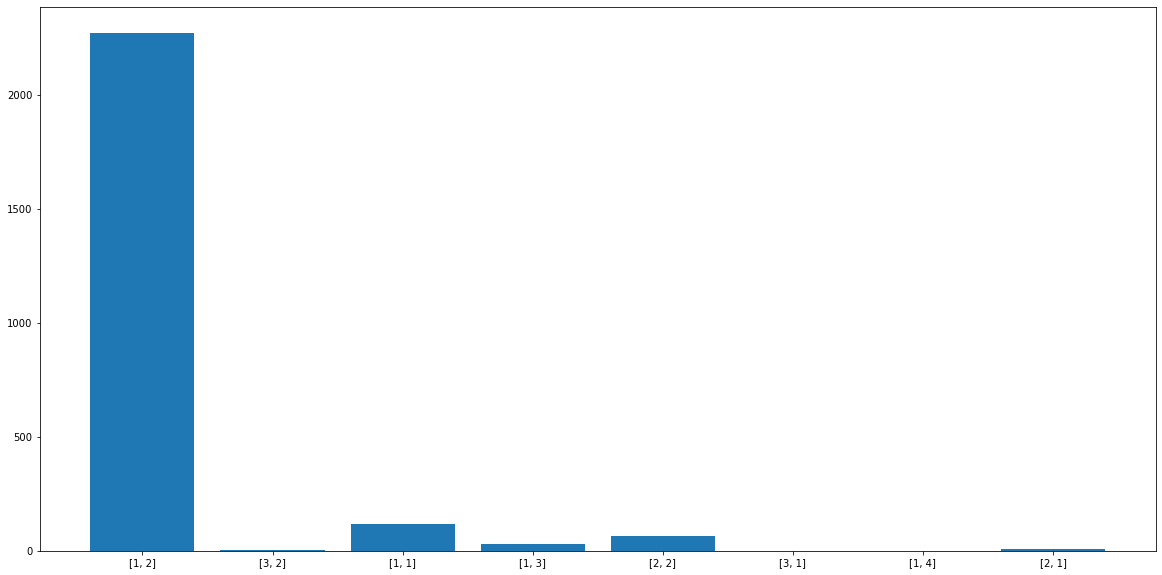

Processing Epoch 104
training start
Iteration 0, d real/fake loss 0.6807196140289307/0.8072834014892578 and g loss is 0.589684247970581, NDiv loss 0.13888035714626312
Iteration 1, d real/fake loss 0.6814520955085754/0.8040772080421448 and g loss is 0.5811235308647156, NDiv loss 0.12756891548633575
Iteration 2, d real/fake loss 0.6821740865707397/0.8044993877410889 and g loss is 0.5953843593597412, NDiv loss 0.13633054494857788
Iteration 3, d real/fake loss 0.6828842163085938/0.813285768032074 and g loss is 0.6008309125900269, NDiv loss 0.12472126632928848
Iteration 4, d real/fake loss 0.6835863590240479/0.8088175058364868 and g loss is 0.5987626314163208, NDiv loss 0.16234338283538818


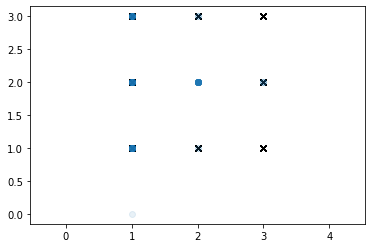

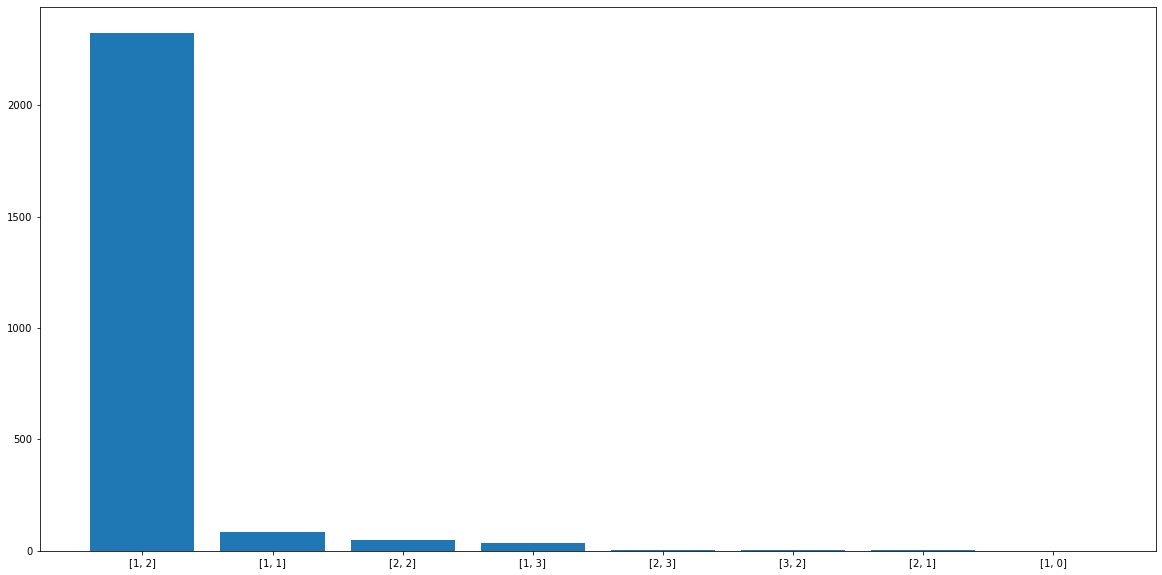

Processing Epoch 105
training start
Iteration 0, d real/fake loss 0.6949849128723145/0.8043632507324219 and g loss is 0.5965906381607056, NDiv loss 0.1462152600288391
Iteration 1, d real/fake loss 0.6955902576446533/0.8114554286003113 and g loss is 0.5985718965530396, NDiv loss 0.14495256543159485
Iteration 2, d real/fake loss 0.6961760520935059/0.8085491061210632 and g loss is 0.5966684818267822, NDiv loss 0.14573024213314056
Iteration 3, d real/fake loss 0.6967434883117676/0.8055716753005981 and g loss is 0.5994089841842651, NDiv loss 0.1463058590888977
Iteration 4, d real/fake loss 0.6972906589508057/0.8044223785400391 and g loss is 0.6048712134361267, NDiv loss 0.15838156640529633


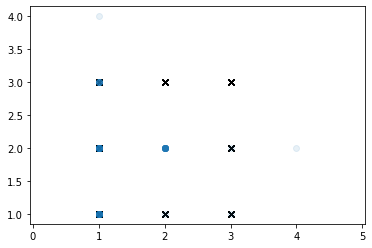

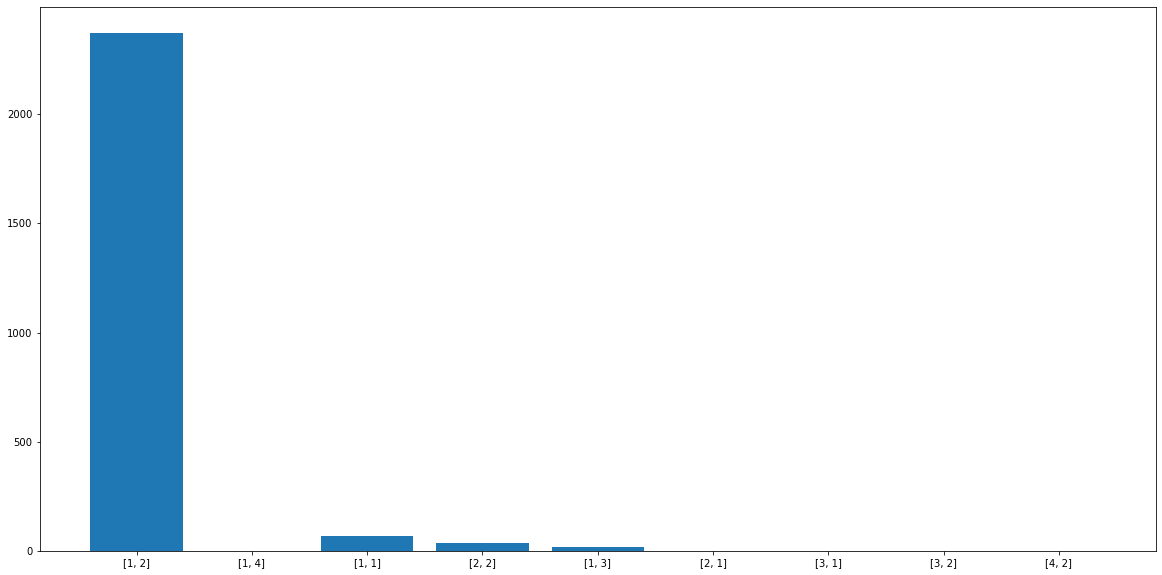

Processing Epoch 106
training start
Iteration 0, d real/fake loss 0.6648125648498535/0.7961347103118896 and g loss is 0.5978505611419678, NDiv loss 0.1517588198184967
Iteration 1, d real/fake loss 0.6654864549636841/0.7996094226837158 and g loss is 0.6071853637695312, NDiv loss 0.16144660115242004
Iteration 2, d real/fake loss 0.6661582589149475/0.7976237535476685 and g loss is 0.604867696762085, NDiv loss 0.16787655651569366
Iteration 3, d real/fake loss 0.6668261885643005/0.7904288172721863 and g loss is 0.6059069633483887, NDiv loss 0.15328529477119446
Iteration 4, d real/fake loss 0.6674878001213074/0.7892314791679382 and g loss is 0.6049962639808655, NDiv loss 0.16220970451831818


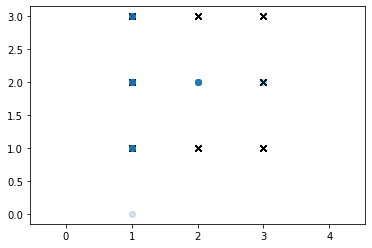

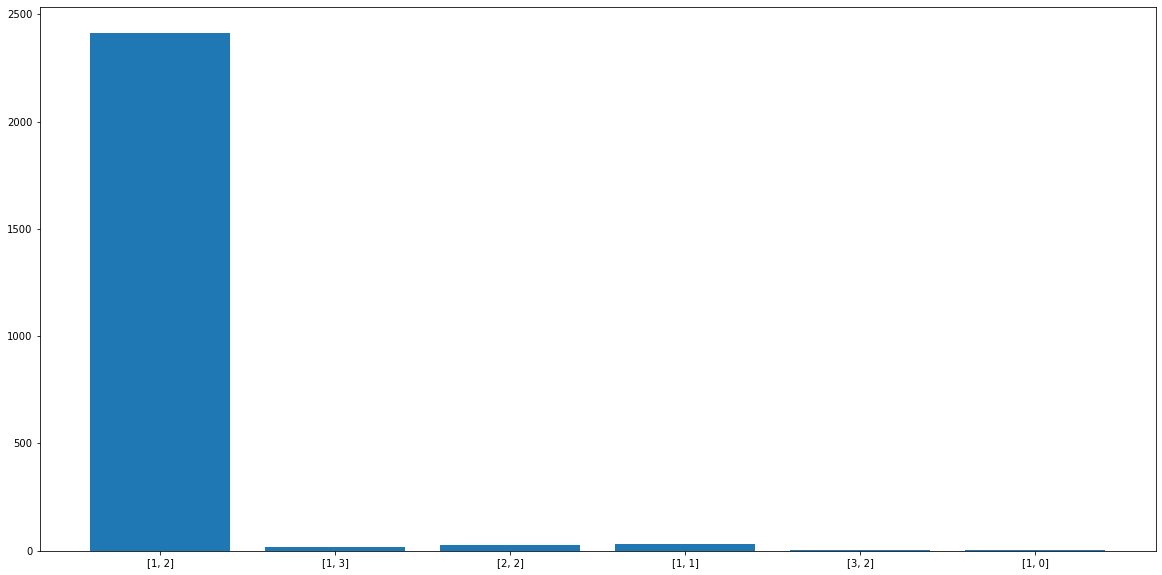

Processing Epoch 107
training start
Iteration 0, d real/fake loss 0.701431393623352/0.793636679649353 and g loss is 0.6057028770446777, NDiv loss 0.1887487769126892
Iteration 1, d real/fake loss 0.7017550468444824/0.7883449196815491 and g loss is 0.6084661483764648, NDiv loss 0.174601212143898
Iteration 2, d real/fake loss 0.7020543813705444/0.7875197529792786 and g loss is 0.61600261926651, NDiv loss 0.18459013104438782
Iteration 3, d real/fake loss 0.702331006526947/0.7837858200073242 and g loss is 0.6208284497261047, NDiv loss 0.17337706685066223
Iteration 4, d real/fake loss 0.7025865316390991/0.7847903966903687 and g loss is 0.6190568804740906, NDiv loss 0.18353234231472015


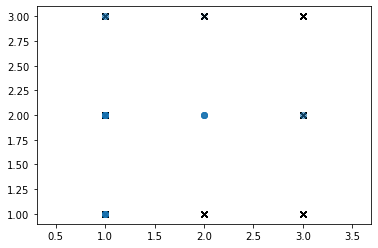

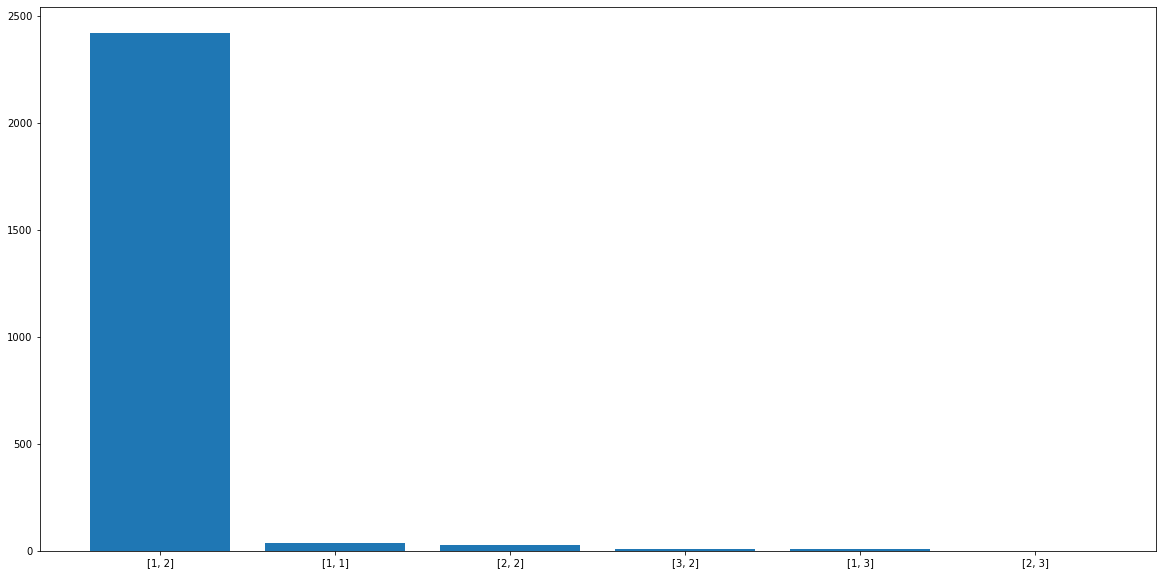

Processing Epoch 108
training start
Iteration 0, d real/fake loss 0.6996942758560181/0.7763364315032959 and g loss is 0.6205834150314331, NDiv loss 0.20218168199062347
Iteration 1, d real/fake loss 0.7000545263290405/0.7790693044662476 and g loss is 0.6201388239860535, NDiv loss 0.16396957635879517
Iteration 2, d real/fake loss 0.7003947496414185/0.7739608287811279 and g loss is 0.6205106973648071, NDiv loss 0.17057187855243683
Iteration 3, d real/fake loss 0.7007154226303101/0.7716876268386841 and g loss is 0.6231892108917236, NDiv loss 0.1713106334209442
Iteration 4, d real/fake loss 0.7010155916213989/0.7673094868659973 and g loss is 0.6234501600265503, NDiv loss 0.17492669820785522


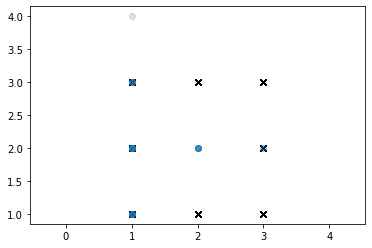

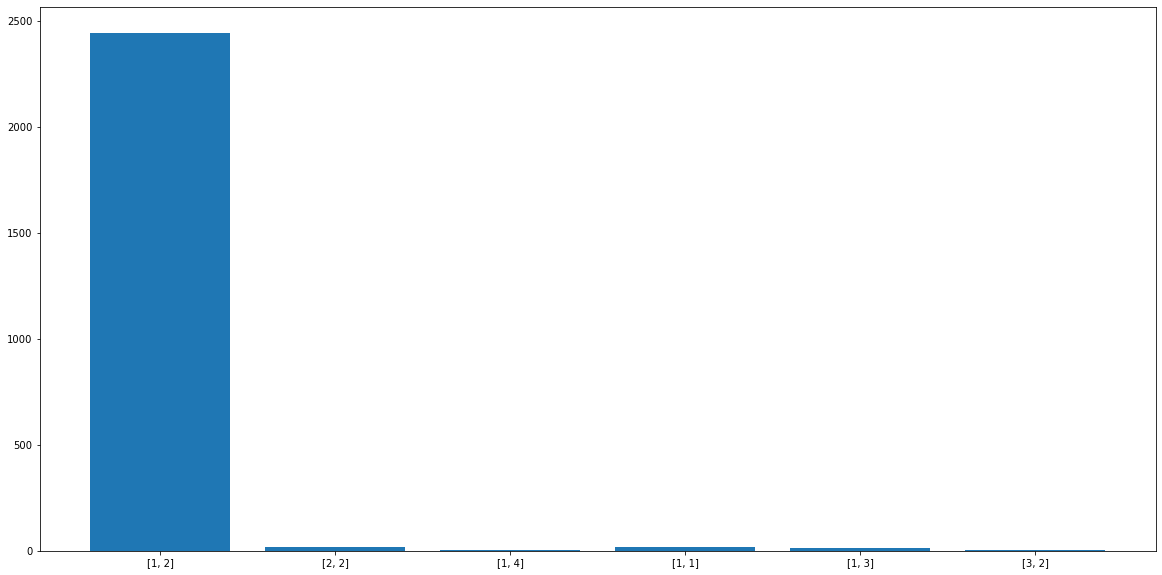

Processing Epoch 109
training start
Iteration 0, d real/fake loss 0.6933716535568237/0.7655760049819946 and g loss is 0.6250170469284058, NDiv loss 0.23407597839832306
Iteration 1, d real/fake loss 0.6938198804855347/0.7664026618003845 and g loss is 0.6287526488304138, NDiv loss 0.18052837252616882
Iteration 2, d real/fake loss 0.69425368309021/0.7589577436447144 and g loss is 0.6308464407920837, NDiv loss 0.18662519752979279
Iteration 3, d real/fake loss 0.6946710348129272/0.7603079676628113 and g loss is 0.6342381238937378, NDiv loss 0.1841268390417099
Iteration 4, d real/fake loss 0.6950758099555969/0.7565305829048157 and g loss is 0.6363316774368286, NDiv loss 0.22496341168880463


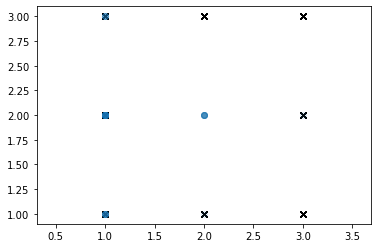

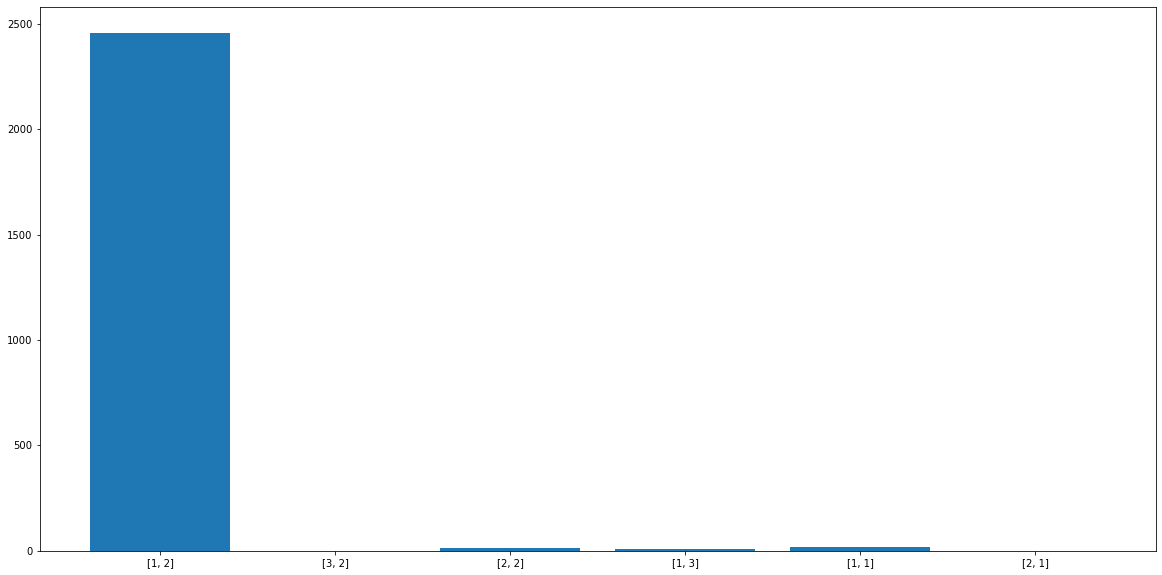

Processing Epoch 110
training start
Iteration 0, d real/fake loss 0.7032185792922974/0.7526041269302368 and g loss is 0.6380164623260498, NDiv loss 0.16667219996452332
Iteration 1, d real/fake loss 0.7035191059112549/0.7504756450653076 and g loss is 0.6389034986495972, NDiv loss 0.17164410650730133
Iteration 2, d real/fake loss 0.7037857174873352/0.7508599758148193 and g loss is 0.6447576880455017, NDiv loss 0.21294358372688293
Iteration 3, d real/fake loss 0.7040232419967651/0.7509503364562988 and g loss is 0.6403191089630127, NDiv loss 0.1781177520751953
Iteration 4, d real/fake loss 0.7042328715324402/0.744121789932251 and g loss is 0.6472657322883606, NDiv loss 0.20891723036766052


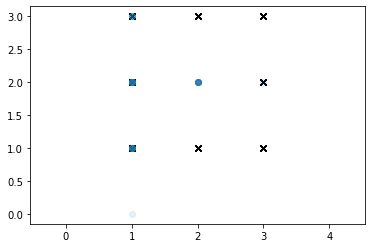

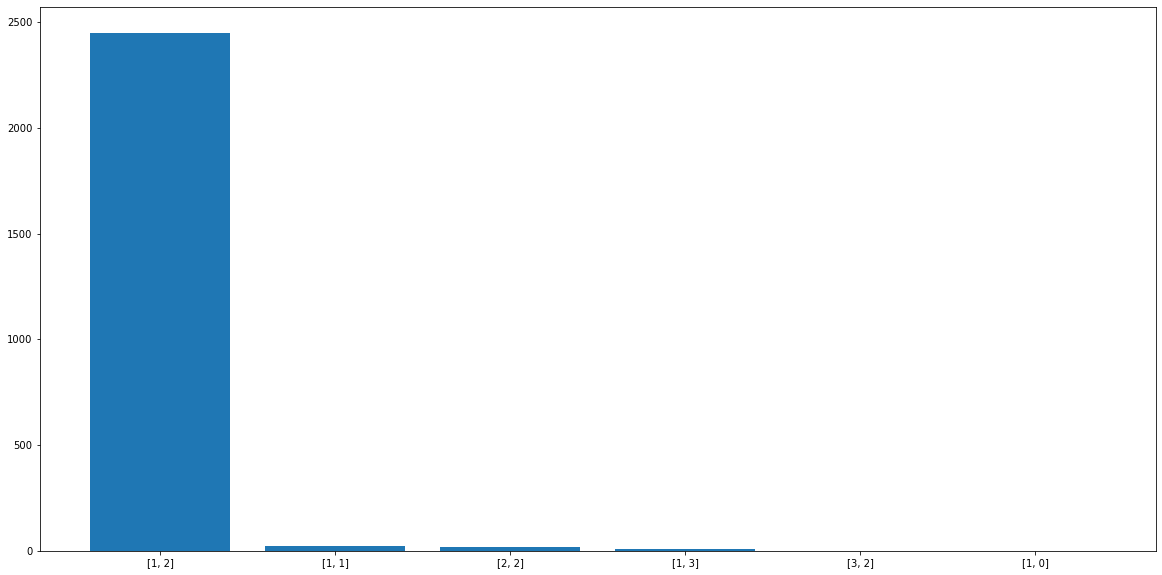

Processing Epoch 111
training start
Iteration 0, d real/fake loss 0.6998629570007324/0.7407212257385254 and g loss is 0.6501564383506775, NDiv loss 0.1998196840286255
Iteration 1, d real/fake loss 0.6999523639678955/0.7372919917106628 and g loss is 0.6509513258934021, NDiv loss 0.22000263631343842
Iteration 2, d real/fake loss 0.7000274658203125/0.7377405166625977 and g loss is 0.6537256240844727, NDiv loss 0.2278607040643692
Iteration 3, d real/fake loss 0.7000895738601685/0.7318401336669922 and g loss is 0.6546332836151123, NDiv loss 0.19132006168365479
Iteration 4, d real/fake loss 0.700136125087738/0.7331112623214722 and g loss is 0.6592683792114258, NDiv loss 0.23261162638664246


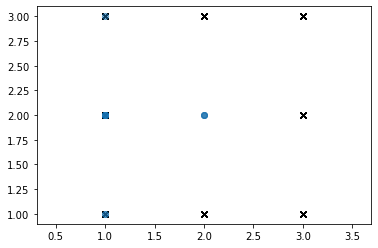

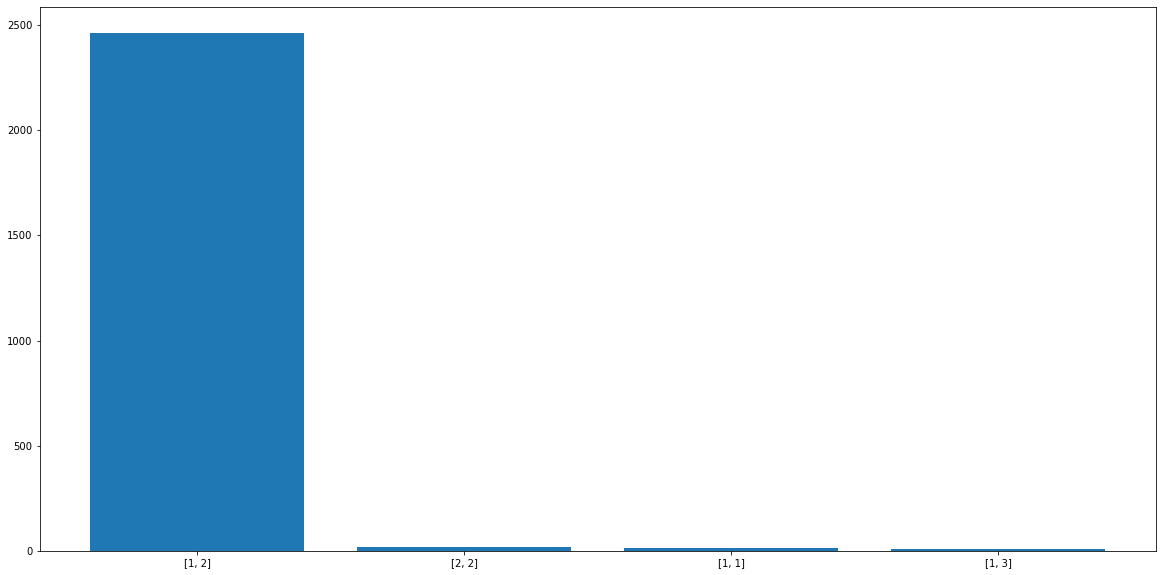

Processing Epoch 112
training start
Iteration 0, d real/fake loss 0.7037287950515747/0.7317039966583252 and g loss is 0.6608973741531372, NDiv loss 0.15356671810150146
Iteration 1, d real/fake loss 0.7038305997848511/0.7281370162963867 and g loss is 0.6614466905593872, NDiv loss 0.23902584612369537
Iteration 2, d real/fake loss 0.7039247751235962/0.7253562211990356 and g loss is 0.6626895666122437, NDiv loss 0.20157362520694733
Iteration 3, d real/fake loss 0.7040104269981384/0.7220092415809631 and g loss is 0.6654911041259766, NDiv loss 0.17948073148727417
Iteration 4, d real/fake loss 0.7040859460830688/0.7234371900558472 and g loss is 0.6674838066101074, NDiv loss 0.20619551837444305


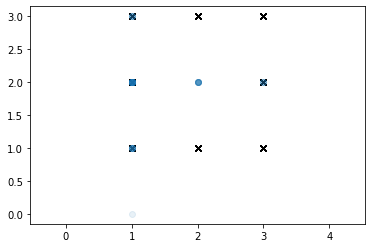

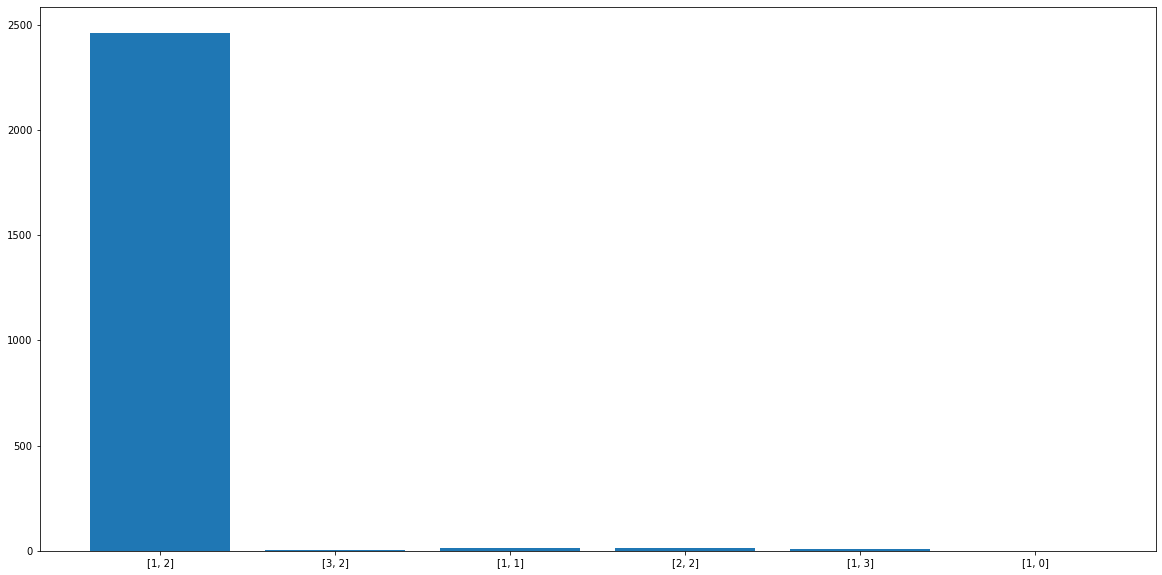

Processing Epoch 113
training start
Iteration 0, d real/fake loss 0.69065260887146/0.7205082178115845 and g loss is 0.6681876182556152, NDiv loss 0.21623526513576508
Iteration 1, d real/fake loss 0.6908642053604126/0.7155756950378418 and g loss is 0.6742069721221924, NDiv loss 0.17642857134342194
Iteration 2, d real/fake loss 0.6910725831985474/0.7114877700805664 and g loss is 0.6722735166549683, NDiv loss 0.22060292959213257
Iteration 3, d real/fake loss 0.6912752389907837/0.7130679488182068 and g loss is 0.6769625544548035, NDiv loss 0.24992504715919495
Iteration 4, d real/fake loss 0.6914706230163574/0.7114079594612122 and g loss is 0.6783705353736877, NDiv loss 0.21055950224399567


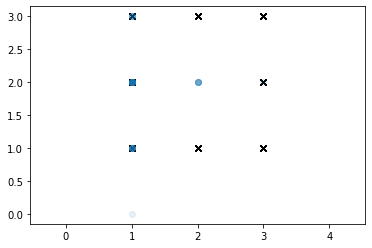

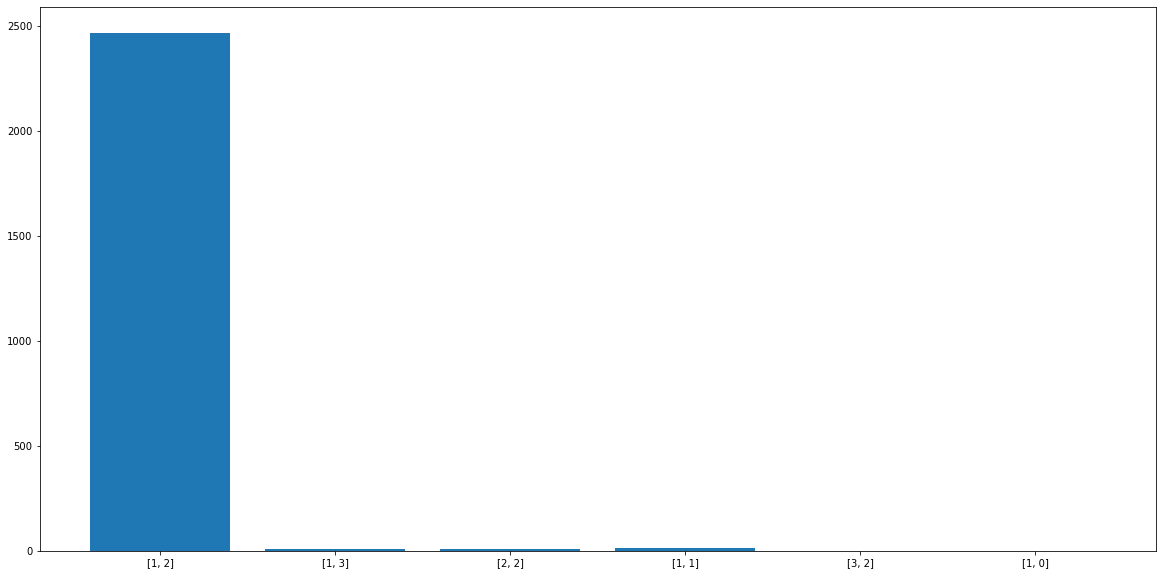

Processing Epoch 114
training start
Iteration 0, d real/fake loss 0.6942014694213867/0.706902265548706 and g loss is 0.6812247037887573, NDiv loss 0.2092970311641693
Iteration 1, d real/fake loss 0.694146990776062/0.7032735347747803 and g loss is 0.684361457824707, NDiv loss 0.20113766193389893
Iteration 2, d real/fake loss 0.6940795183181763/0.7051247954368591 and g loss is 0.683714747428894, NDiv loss 0.2319812774658203
Iteration 3, d real/fake loss 0.6939995288848877/0.7024585008621216 and g loss is 0.6883338689804077, NDiv loss 0.19757325947284698
Iteration 4, d real/fake loss 0.6939075589179993/0.7001755237579346 and g loss is 0.6874458193778992, NDiv loss 0.2245190143585205


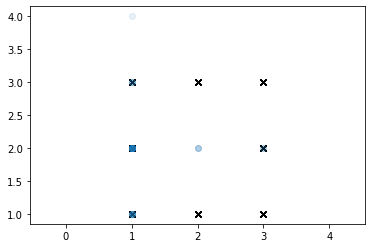

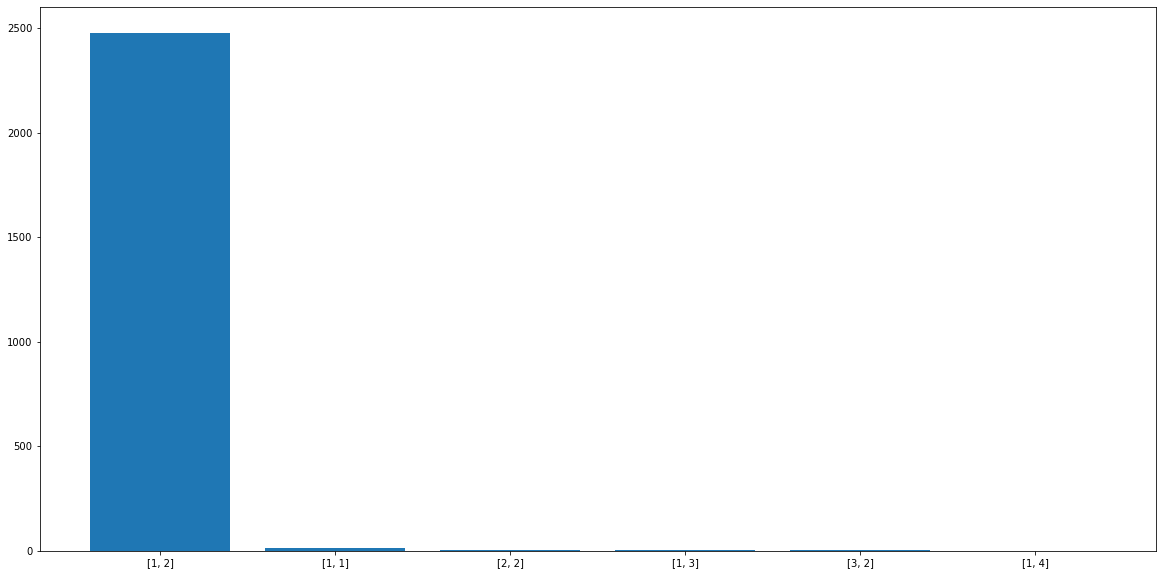

Processing Epoch 115
training start
Iteration 0, d real/fake loss 0.6798123717308044/0.6971024870872498 and g loss is 0.6901302933692932, NDiv loss 0.24992001056671143
Iteration 1, d real/fake loss 0.6797751784324646/0.6968228816986084 and g loss is 0.6914422512054443, NDiv loss 0.19378213584423065
Iteration 2, d real/fake loss 0.6797219514846802/0.6931294202804565 and g loss is 0.6949341297149658, NDiv loss 0.2365417331457138
Iteration 3, d real/fake loss 0.6796529293060303/0.6925569772720337 and g loss is 0.696029007434845, NDiv loss 0.2500182092189789
Iteration 4, d real/fake loss 0.6795690655708313/0.6900287866592407 and g loss is 0.6980386972427368, NDiv loss 0.2213936597108841


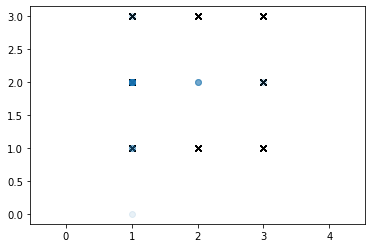

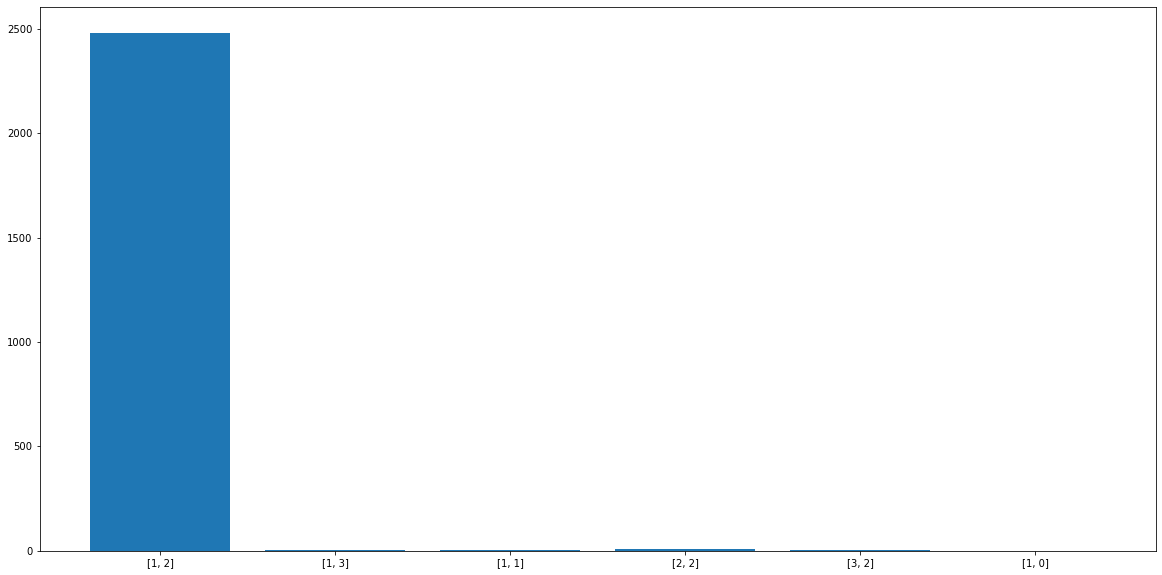

Processing Epoch 116
training start
Iteration 0, d real/fake loss 0.6881415843963623/0.6859691143035889 and g loss is 0.699988603591919, NDiv loss 0.21677252650260925
Iteration 1, d real/fake loss 0.6879583597183228/0.6823949217796326 and g loss is 0.7031958103179932, NDiv loss 0.24379196763038635
Iteration 2, d real/fake loss 0.6877614855766296/0.68424391746521 and g loss is 0.7065591812133789, NDiv loss 0.22703874111175537
Iteration 3, d real/fake loss 0.687551736831665/0.6825018525123596 and g loss is 0.707538366317749, NDiv loss 0.25331512093544006
Iteration 4, d real/fake loss 0.6873300671577454/0.6794322729110718 and g loss is 0.7089475989341736, NDiv loss 0.2336098849773407


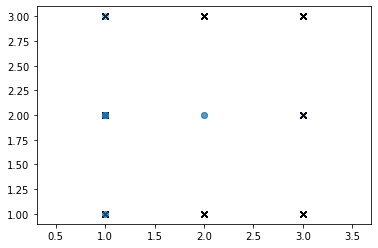

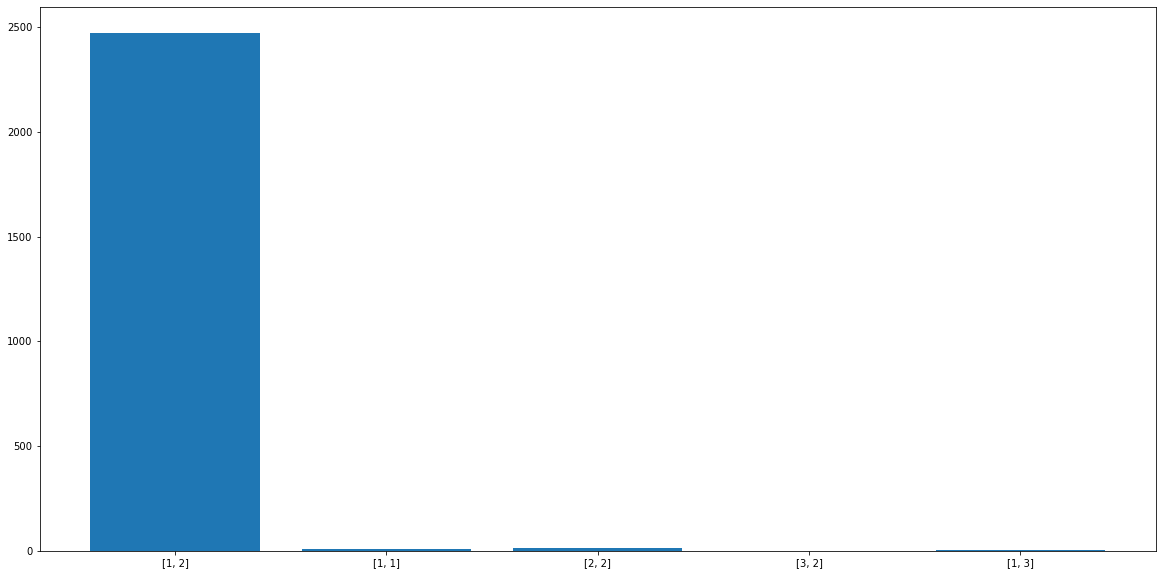

Processing Epoch 117
training start
Iteration 0, d real/fake loss 0.691590428352356/0.6775028109550476 and g loss is 0.7111505270004272, NDiv loss 0.2709815800189972
Iteration 1, d real/fake loss 0.6915341019630432/0.6750885248184204 and g loss is 0.7127242088317871, NDiv loss 0.22643287479877472
Iteration 2, d real/fake loss 0.6914687156677246/0.6739491820335388 and g loss is 0.7155998945236206, NDiv loss 0.2155156135559082
Iteration 3, d real/fake loss 0.6913950443267822/0.6722013354301453 and g loss is 0.7190126180648804, NDiv loss 0.22212567925453186
Iteration 4, d real/fake loss 0.6913129091262817/0.6702049374580383 and g loss is 0.7182230949401855, NDiv loss 0.22834664583206177


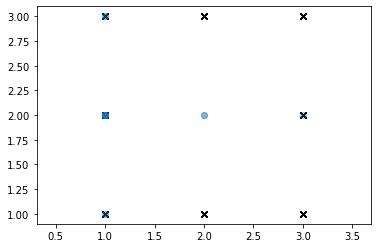

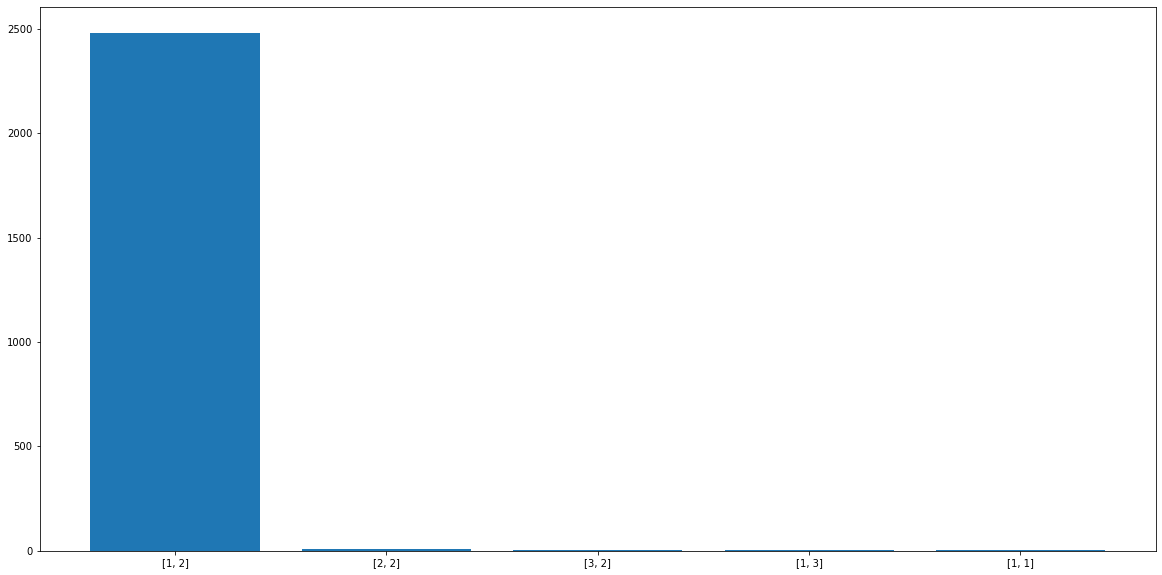

Processing Epoch 118
training start
Iteration 0, d real/fake loss 0.6807752847671509/0.6675211191177368 and g loss is 0.7233027219772339, NDiv loss 0.22701048851013184
Iteration 1, d real/fake loss 0.6805987358093262/0.6664601564407349 and g loss is 0.7225881814956665, NDiv loss 0.2491934895515442
Iteration 2, d real/fake loss 0.6804131269454956/0.6641576886177063 and g loss is 0.7263083457946777, NDiv loss 0.2128084897994995
Iteration 3, d real/fake loss 0.6802197098731995/0.6616604328155518 and g loss is 0.7272589206695557, NDiv loss 0.25417232513427734
Iteration 4, d real/fake loss 0.6800181865692139/0.6615143418312073 and g loss is 0.7304134368896484, NDiv loss 0.2121301144361496


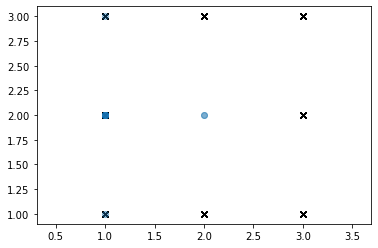

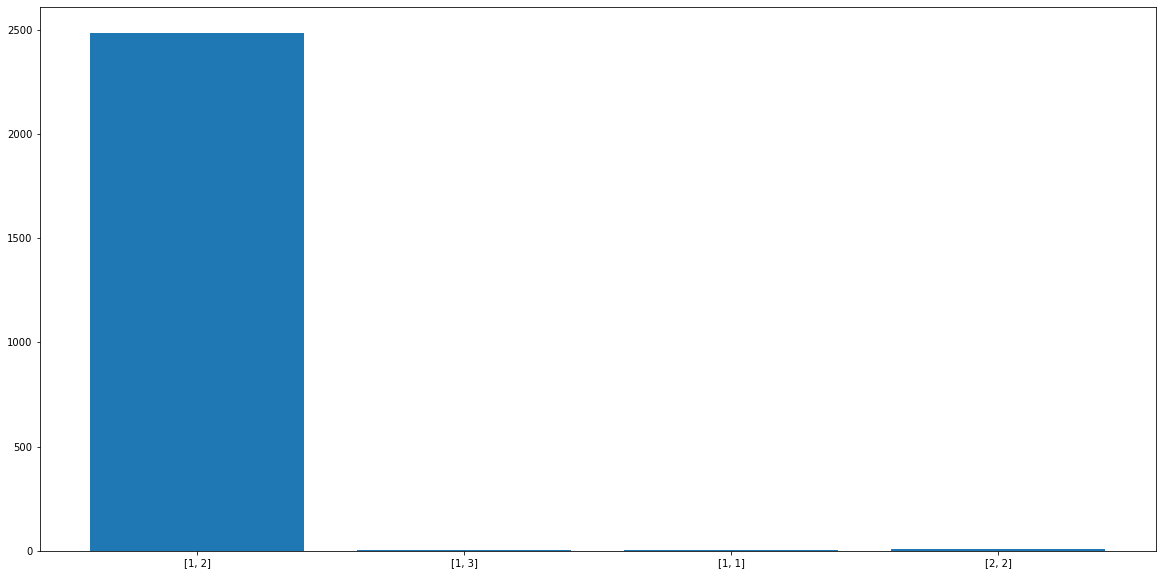

Processing Epoch 119
training start
Iteration 0, d real/fake loss 0.7019854784011841/0.6594887971878052 and g loss is 0.7309485673904419, NDiv loss 0.2802692949771881
Iteration 1, d real/fake loss 0.7019796371459961/0.6578671932220459 and g loss is 0.7317253947257996, NDiv loss 0.23714092373847961
Iteration 2, d real/fake loss 0.7019542455673218/0.6547027826309204 and g loss is 0.7346748113632202, NDiv loss 0.24952474236488342
Iteration 3, d real/fake loss 0.7019093036651611/0.6536778211593628 and g loss is 0.736631453037262, NDiv loss 0.2052459418773651
Iteration 4, d real/fake loss 0.701846182346344/0.6538506150245667 and g loss is 0.7377253770828247, NDiv loss 0.19549375772476196


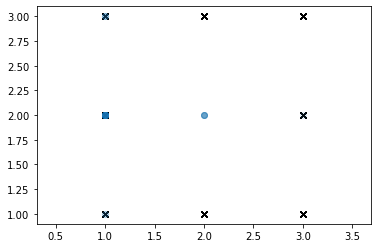

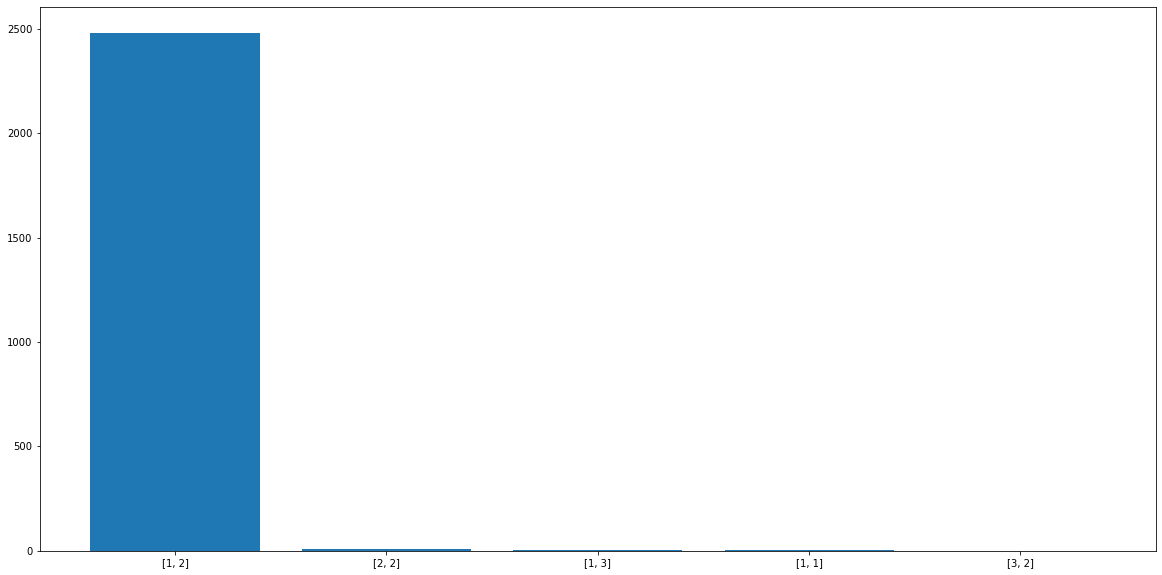

Processing Epoch 120
training start
Iteration 0, d real/fake loss 0.7013519406318665/0.6496829986572266 and g loss is 0.7416103482246399, NDiv loss 0.22865284979343414
Iteration 1, d real/fake loss 0.7011452317237854/0.6495438814163208 and g loss is 0.7409529685974121, NDiv loss 0.2449921816587448
Iteration 2, d real/fake loss 0.7009204030036926/0.6475850343704224 and g loss is 0.742885947227478, NDiv loss 0.2362784892320633
Iteration 3, d real/fake loss 0.7006781101226807/0.6458514928817749 and g loss is 0.7449245452880859, NDiv loss 0.19093701243400574
Iteration 4, d real/fake loss 0.7004200220108032/0.6439105868339539 and g loss is 0.7481947541236877, NDiv loss 0.26195523142814636


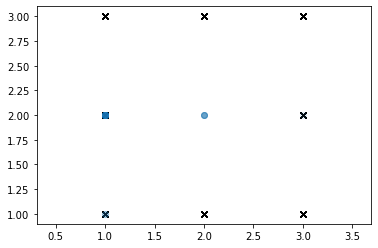

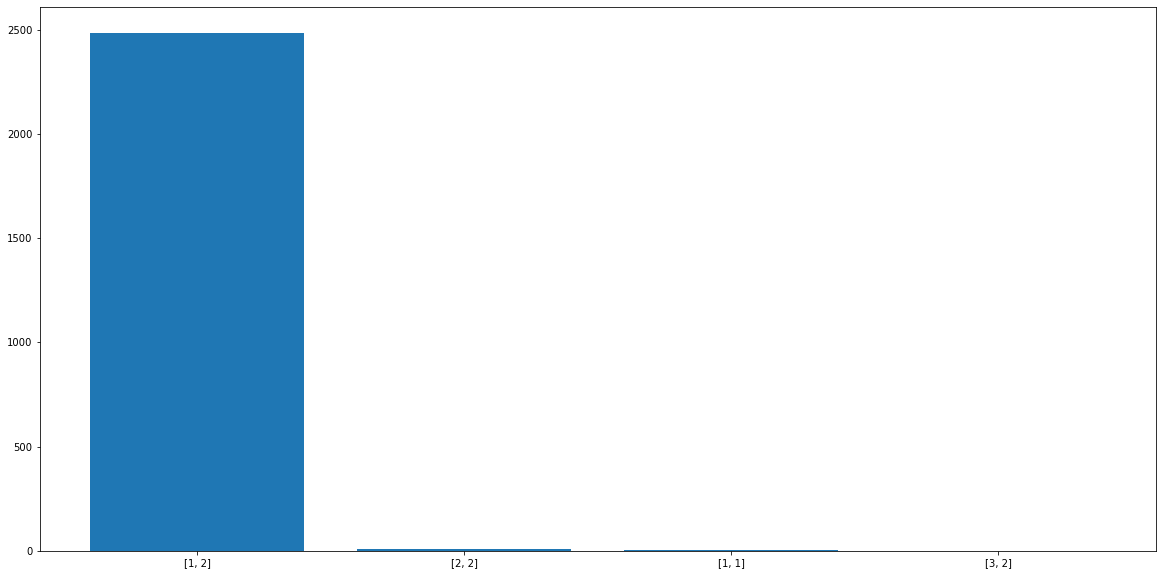

Processing Epoch 121
training start
Iteration 0, d real/fake loss 0.701740026473999/0.642524242401123 and g loss is 0.7485029697418213, NDiv loss 0.235504612326622
Iteration 1, d real/fake loss 0.7013912796974182/0.6404283046722412 and g loss is 0.7499369382858276, NDiv loss 0.261922687292099
Iteration 2, d real/fake loss 0.7010310888290405/0.6386121511459351 and g loss is 0.7495152950286865, NDiv loss 0.22221969068050385
Iteration 3, d real/fake loss 0.7006595134735107/0.638555645942688 and g loss is 0.7534371614456177, NDiv loss 0.2351275384426117
Iteration 4, d real/fake loss 0.7002780437469482/0.6363927125930786 and g loss is 0.7538110017776489, NDiv loss 0.2637505829334259


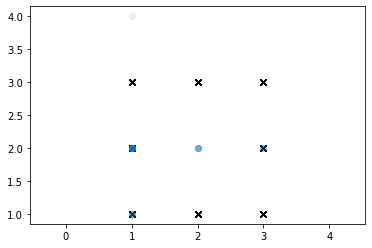

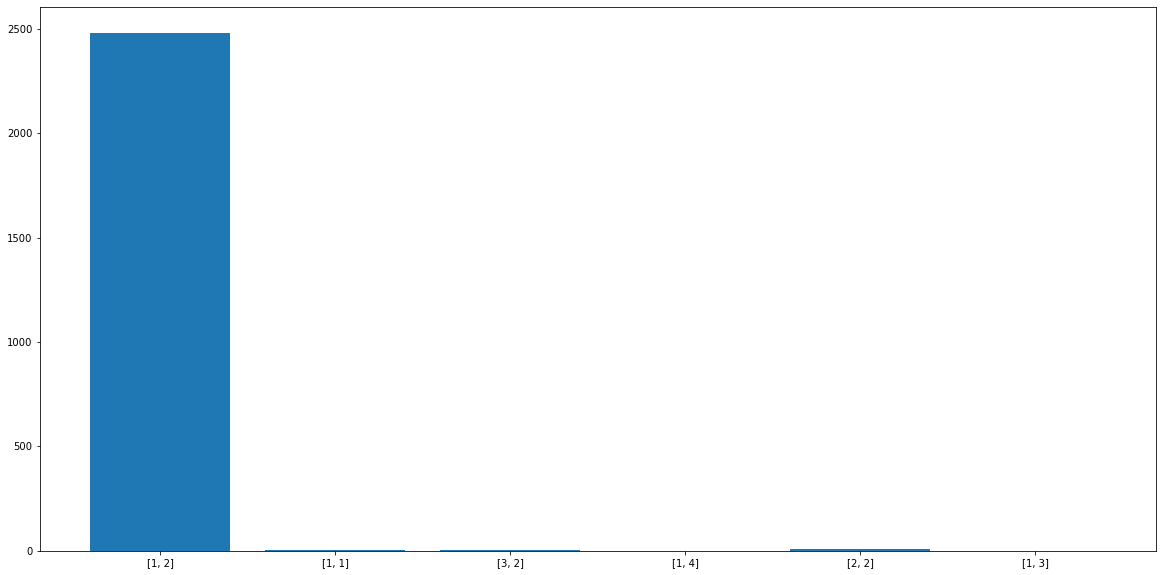

Processing Epoch 122
training start
Iteration 0, d real/fake loss 0.6941202878952026/0.6346793174743652 and g loss is 0.7570791840553284, NDiv loss 0.17135290801525116
Iteration 1, d real/fake loss 0.6937340497970581/0.6337752342224121 and g loss is 0.7568599581718445, NDiv loss 0.25960880517959595
Iteration 2, d real/fake loss 0.6933428645133972/0.6322606801986694 and g loss is 0.760374903678894, NDiv loss 0.1897016018629074
Iteration 3, d real/fake loss 0.6929473876953125/0.6311066150665283 and g loss is 0.7606431245803833, NDiv loss 0.2122659981250763
Iteration 4, d real/fake loss 0.6925462484359741/0.6293631792068481 and g loss is 0.7626074552536011, NDiv loss 0.19390058517456055


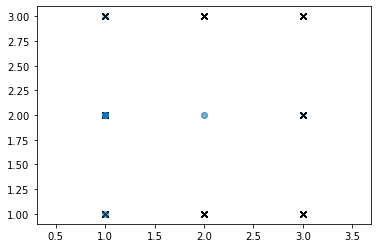

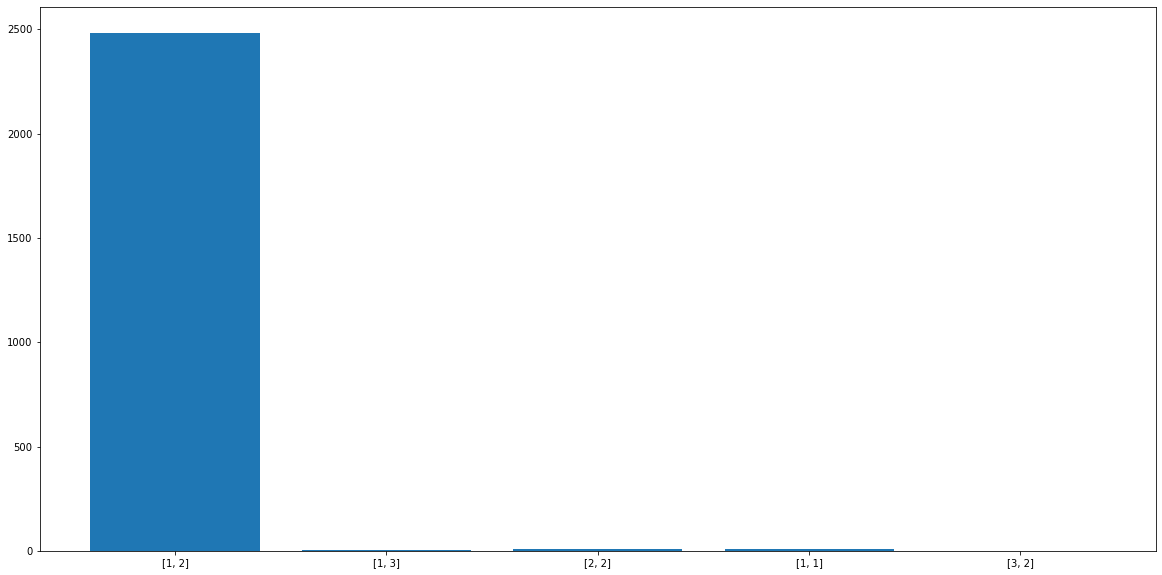

Processing Epoch 123
training start
Iteration 0, d real/fake loss 0.6948315501213074/0.6276593208312988 and g loss is 0.7637251019477844, NDiv loss 0.23082466423511505
Iteration 1, d real/fake loss 0.6944783926010132/0.6278302669525146 and g loss is 0.7660913467407227, NDiv loss 0.19440177083015442
Iteration 2, d real/fake loss 0.694115161895752/0.6250186562538147 and g loss is 0.7680737972259521, NDiv loss 0.25735676288604736
Iteration 3, d real/fake loss 0.6937431693077087/0.6243576407432556 and g loss is 0.7677692770957947, NDiv loss 0.2039843648672104
Iteration 4, d real/fake loss 0.6933621764183044/0.6229828596115112 and g loss is 0.7699375152587891, NDiv loss 0.2541697025299072


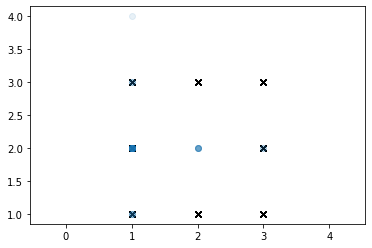

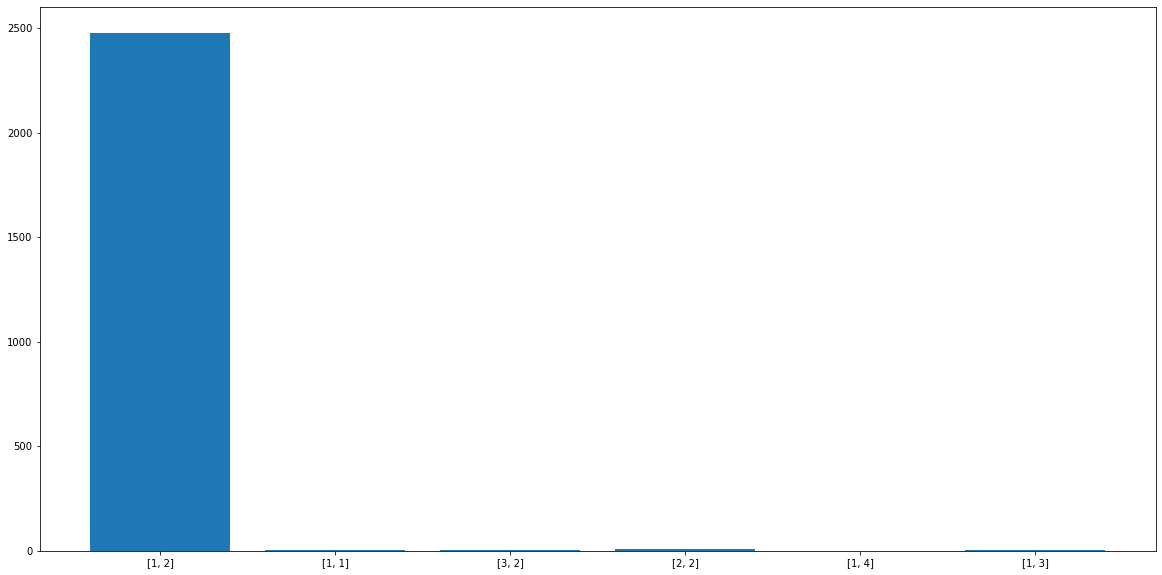

Processing Epoch 124
training start
Iteration 0, d real/fake loss 0.6974014043807983/0.6208982467651367 and g loss is 0.7702796459197998, NDiv loss 0.1995762586593628
Iteration 1, d real/fake loss 0.6969070434570312/0.6200563311576843 and g loss is 0.7728323936462402, NDiv loss 0.21098260581493378
Iteration 2, d real/fake loss 0.6963992714881897/0.6199579834938049 and g loss is 0.7744097113609314, NDiv loss 0.2014237642288208
Iteration 3, d real/fake loss 0.6958800554275513/0.6181238889694214 and g loss is 0.7765375971794128, NDiv loss 0.26277631521224976
Iteration 4, d real/fake loss 0.6953496336936951/0.6170191764831543 and g loss is 0.7773314714431763, NDiv loss 0.21679657697677612


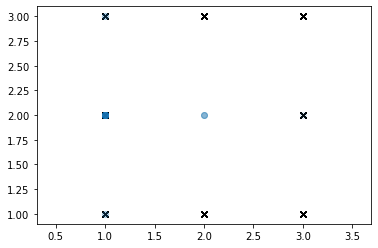

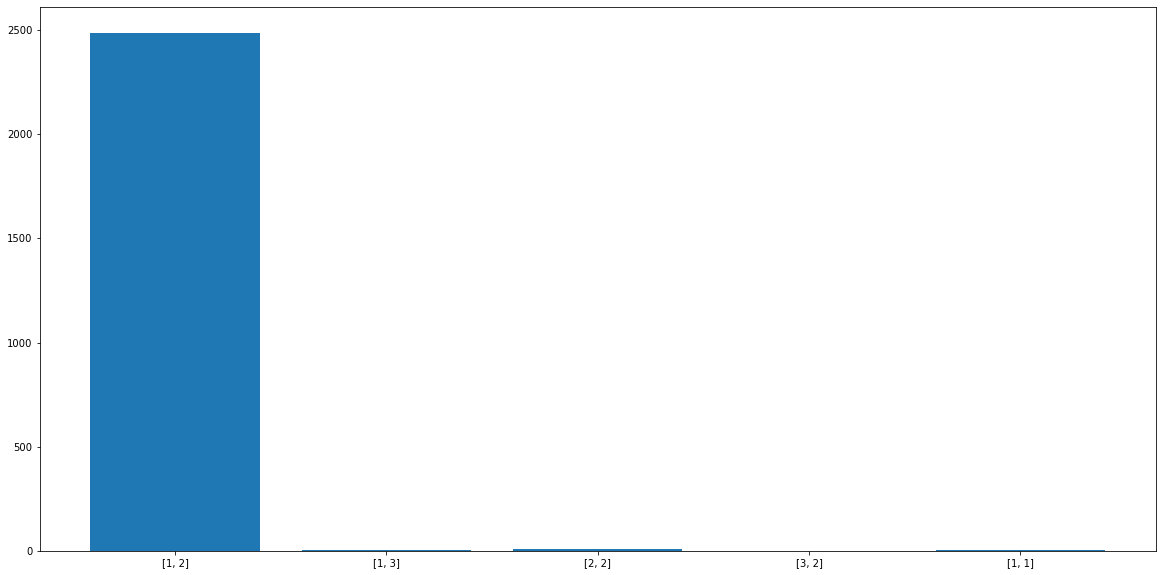

Processing Epoch 125
training start
Iteration 0, d real/fake loss 0.6910315752029419/0.6154460310935974 and g loss is 0.778513491153717, NDiv loss 0.23526069521903992
Iteration 1, d real/fake loss 0.6906003952026367/0.6137750148773193 and g loss is 0.7807985544204712, NDiv loss 0.31257981061935425
Iteration 2, d real/fake loss 0.6901639699935913/0.6134066581726074 and g loss is 0.7808739542961121, NDiv loss 0.23325306177139282
Iteration 3, d real/fake loss 0.689723014831543/0.6108054518699646 and g loss is 0.7842601537704468, NDiv loss 0.22256498038768768
Iteration 4, d real/fake loss 0.6892774105072021/0.6104100942611694 and g loss is 0.7808799147605896, NDiv loss 0.24406354129314423


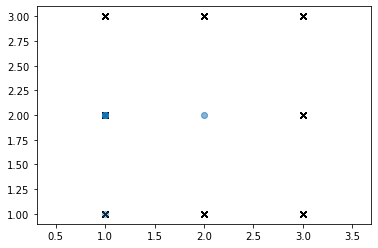

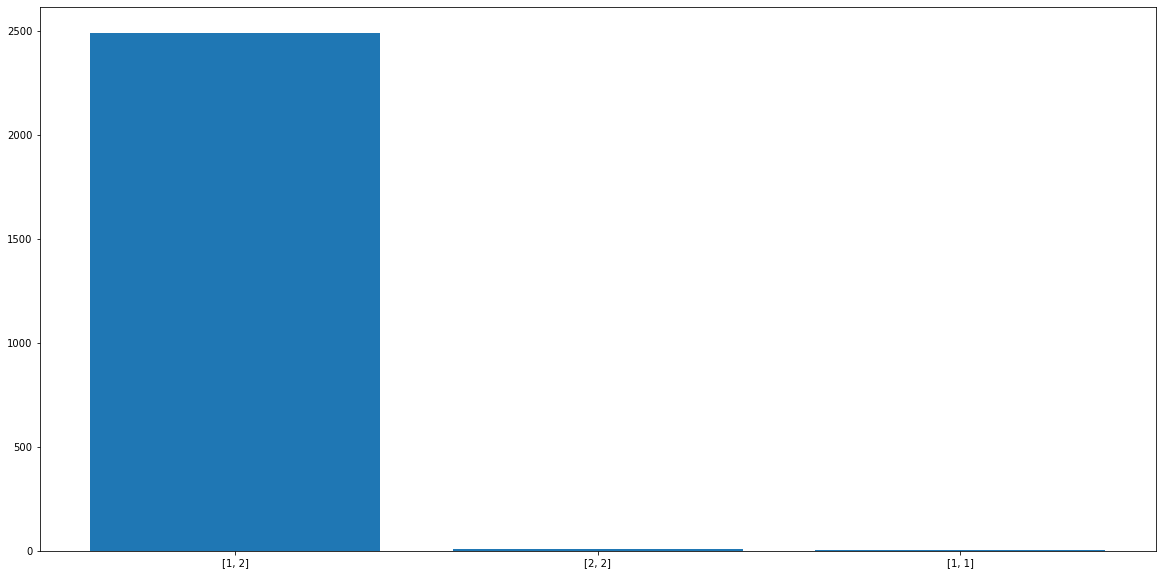

Processing Epoch 126
training start
Iteration 0, d real/fake loss 0.6870665550231934/0.6094744801521301 and g loss is 0.7864145636558533, NDiv loss 0.28460603952407837
Iteration 1, d real/fake loss 0.686611533164978/0.6083385944366455 and g loss is 0.7869702577590942, NDiv loss 0.217044860124588
Iteration 2, d real/fake loss 0.6861540675163269/0.6074749231338501 and g loss is 0.7882109880447388, NDiv loss 0.21481113135814667
Iteration 3, d real/fake loss 0.6856951713562012/0.6056791543960571 and g loss is 0.7896373271942139, NDiv loss 0.25093838572502136
Iteration 4, d real/fake loss 0.685234010219574/0.6046134829521179 and g loss is 0.7911983728408813, NDiv loss 0.24474796652793884


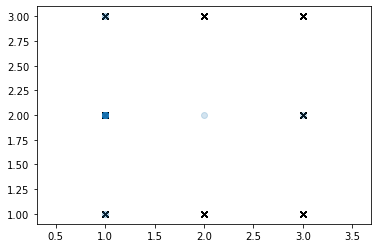

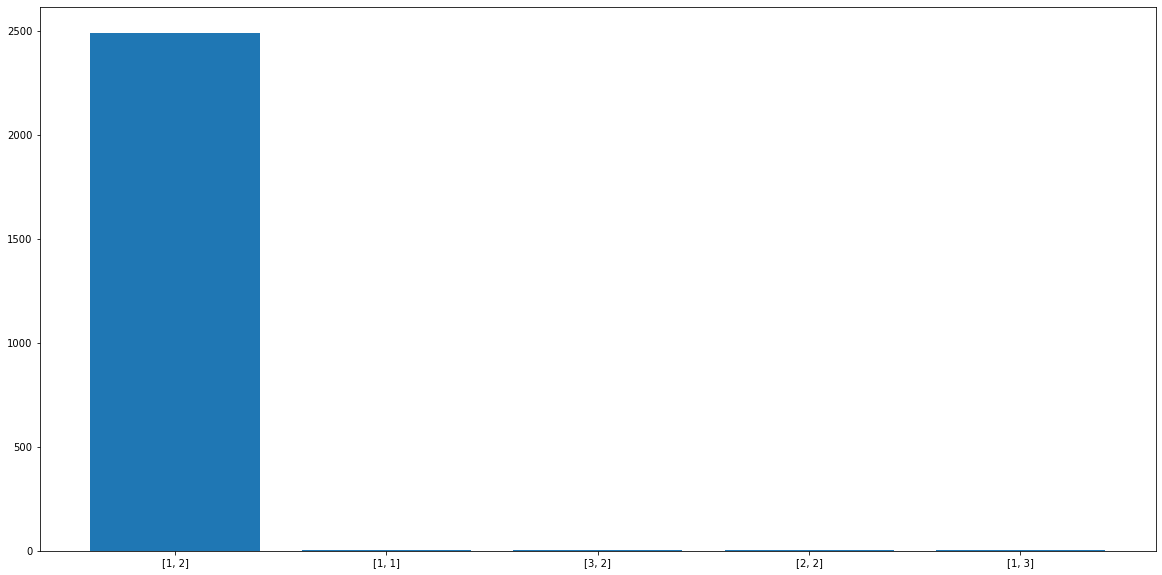

Processing Epoch 127
training start
Iteration 0, d real/fake loss 0.6911630034446716/0.6042076349258423 and g loss is 0.7929355502128601, NDiv loss 0.2610156834125519
Iteration 1, d real/fake loss 0.6906941533088684/0.6019530296325684 and g loss is 0.7941243052482605, NDiv loss 0.30188658833503723
Iteration 2, d real/fake loss 0.6902196407318115/0.6017971038818359 and g loss is 0.7957794666290283, NDiv loss 0.2327110320329666
Iteration 3, d real/fake loss 0.6897395849227905/0.6006597280502319 and g loss is 0.7965879440307617, NDiv loss 0.2880829870700836
Iteration 4, d real/fake loss 0.6892544031143188/0.5992604494094849 and g loss is 0.7974647879600525, NDiv loss 0.22848474979400635


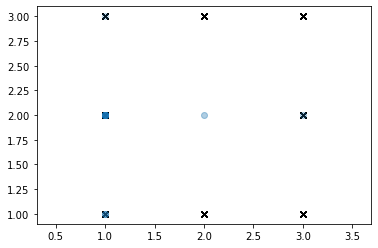

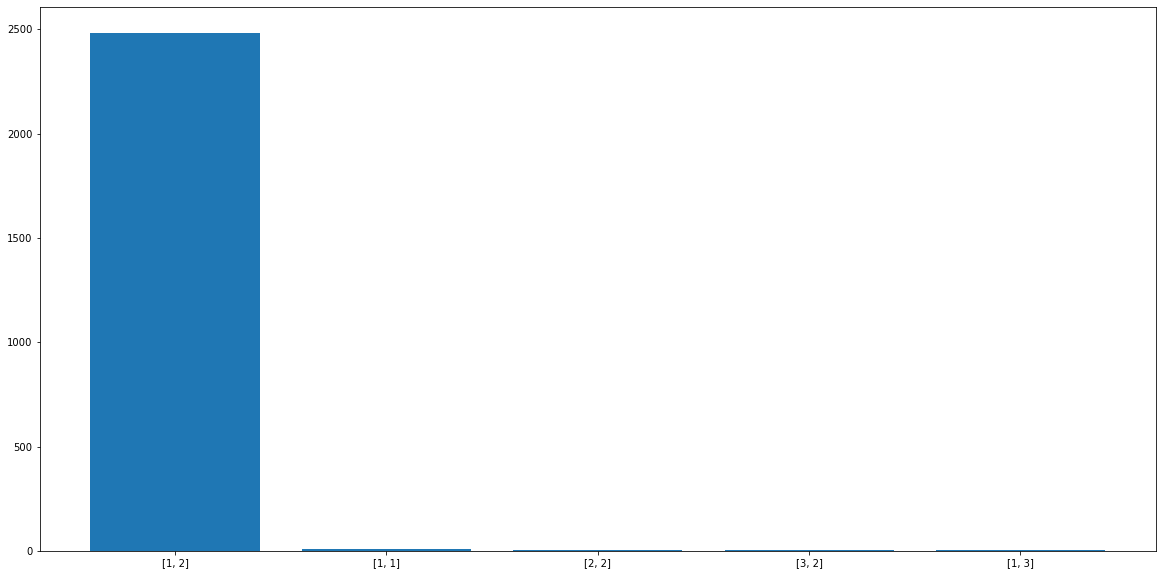

Processing Epoch 128
training start
Iteration 0, d real/fake loss 0.6594510674476624/0.5987579822540283 and g loss is 0.7989579439163208, NDiv loss 0.21096646785736084
Iteration 1, d real/fake loss 0.6589266657829285/0.5991131663322449 and g loss is 0.8004003763198853, NDiv loss 0.2322031706571579
Iteration 2, d real/fake loss 0.6584177613258362/0.5970244407653809 and g loss is 0.802244246006012, NDiv loss 0.178128182888031
Iteration 3, d real/fake loss 0.6579217910766602/0.5953065752983093 and g loss is 0.8037819266319275, NDiv loss 0.2465239316225052
Iteration 4, d real/fake loss 0.657437264919281/0.5939710140228271 and g loss is 0.8054859638214111, NDiv loss 0.25792813301086426


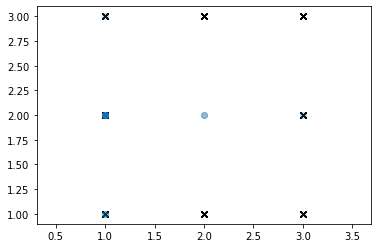

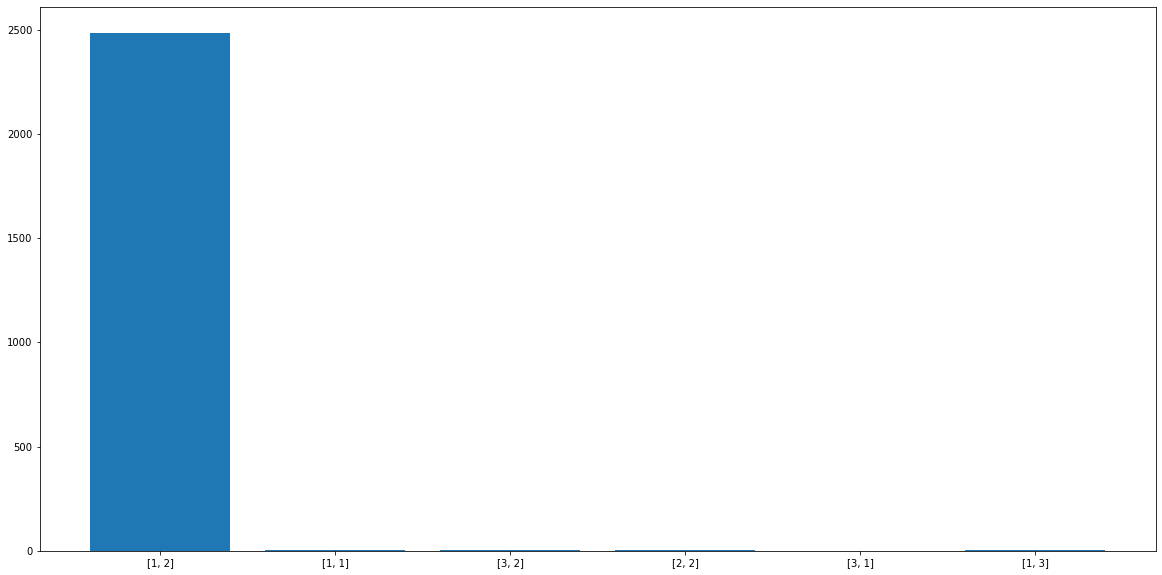

Processing Epoch 129
training start
Iteration 0, d real/fake loss 0.6615728139877319/0.5925217270851135 and g loss is 0.8069002628326416, NDiv loss 0.28313905000686646
Iteration 1, d real/fake loss 0.6610163450241089/0.5922529101371765 and g loss is 0.8077276945114136, NDiv loss 0.2648109197616577
Iteration 2, d real/fake loss 0.6604596376419067/0.5908381342887878 and g loss is 0.8096634149551392, NDiv loss 0.1938994973897934
Iteration 3, d real/fake loss 0.6599018573760986/0.5898053646087646 and g loss is 0.8084856867790222, NDiv loss 0.20349591970443726
Iteration 4, d real/fake loss 0.6593419909477234/0.5886096954345703 and g loss is 0.812246561050415, NDiv loss 0.25448283553123474


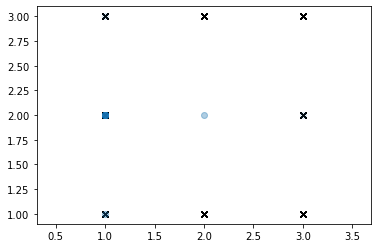

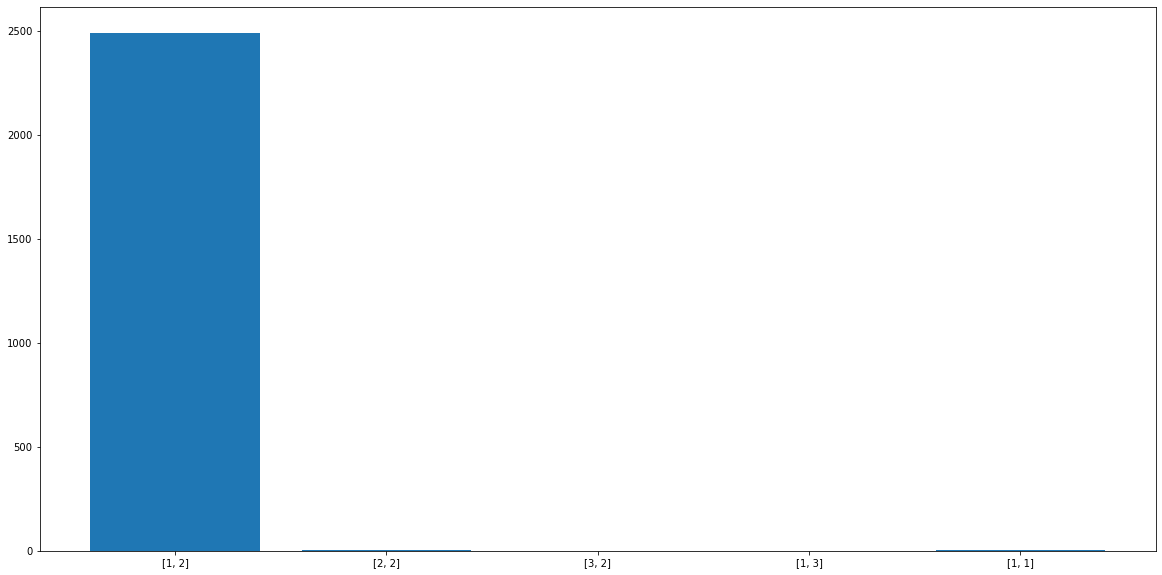

Processing Epoch 130
training start
Iteration 0, d real/fake loss 0.6557769179344177/0.5888734459877014 and g loss is 0.8134849071502686, NDiv loss 0.2053905576467514
Iteration 1, d real/fake loss 0.6552298069000244/0.5866711735725403 and g loss is 0.8158202171325684, NDiv loss 0.19131024181842804
Iteration 2, d real/fake loss 0.6546741127967834/0.5843525528907776 and g loss is 0.8150509595870972, NDiv loss 0.21739909052848816
Iteration 3, d real/fake loss 0.6541100740432739/0.5840386152267456 and g loss is 0.8177646398544312, NDiv loss 0.25048893690109253
Iteration 4, d real/fake loss 0.6535382866859436/0.5820038318634033 and g loss is 0.8191272616386414, NDiv loss 0.2585600018501282


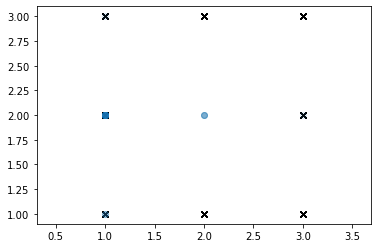

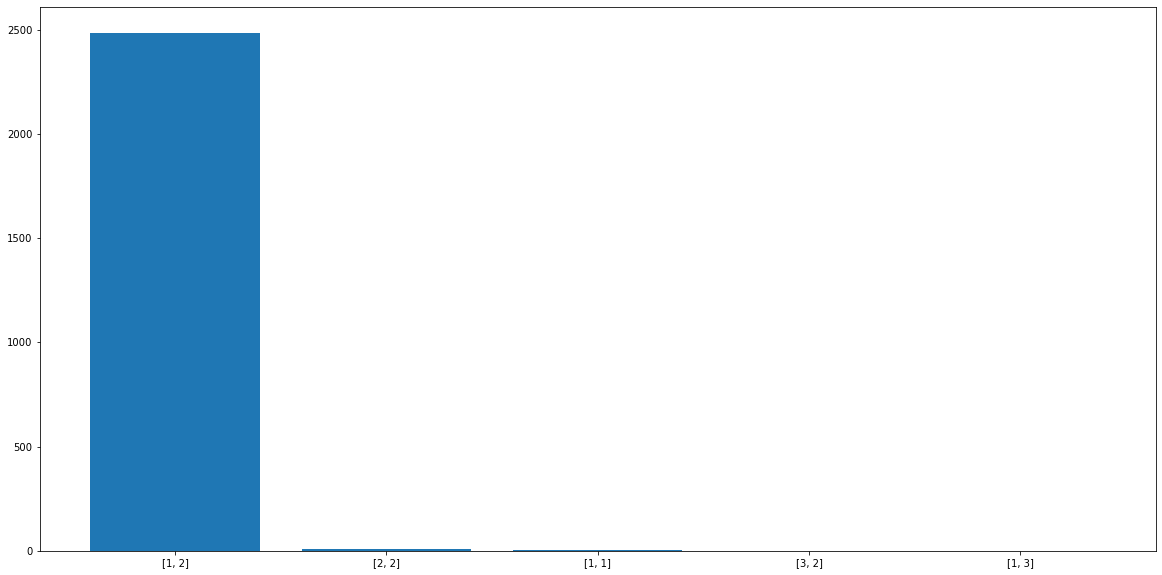

Processing Epoch 131
training start
Iteration 0, d real/fake loss 0.6721481084823608/0.5814017653465271 and g loss is 0.8211545944213867, NDiv loss 0.21284855902194977
Iteration 1, d real/fake loss 0.6715125441551208/0.5800446271896362 and g loss is 0.821872889995575, NDiv loss 0.23190830647945404
Iteration 2, d real/fake loss 0.6708645820617676/0.5799106359481812 and g loss is 0.8222264051437378, NDiv loss 0.26863381266593933
Iteration 3, d real/fake loss 0.6702057123184204/0.577190637588501 and g loss is 0.8233805894851685, NDiv loss 0.2519330680370331
Iteration 4, d real/fake loss 0.6695363521575928/0.5760464668273926 and g loss is 0.8265661001205444, NDiv loss 0.24346749484539032


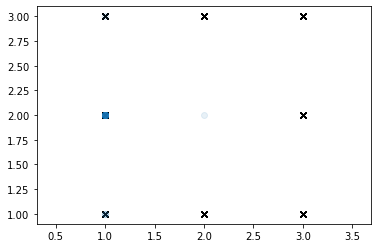

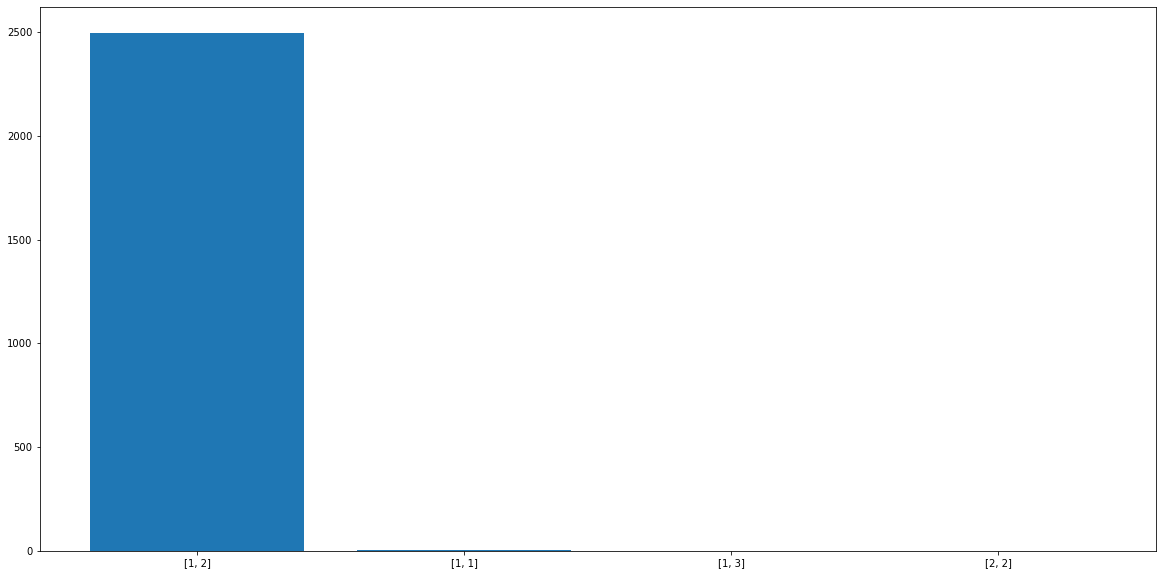

Processing Epoch 132
training start
Iteration 0, d real/fake loss 0.6566635966300964/0.5748628973960876 and g loss is 0.828228235244751, NDiv loss 0.27575451135635376
Iteration 1, d real/fake loss 0.6560677289962769/0.5750619173049927 and g loss is 0.8289085626602173, NDiv loss 0.22515542805194855
Iteration 2, d real/fake loss 0.6554739475250244/0.5737648606300354 and g loss is 0.8307338953018188, NDiv loss 0.2219197303056717
Iteration 3, d real/fake loss 0.6548805832862854/0.5737541913986206 and g loss is 0.8317662477493286, NDiv loss 0.25213372707366943
Iteration 4, d real/fake loss 0.6542878150939941/0.5709438323974609 and g loss is 0.8338706493377686, NDiv loss 0.23092369735240936


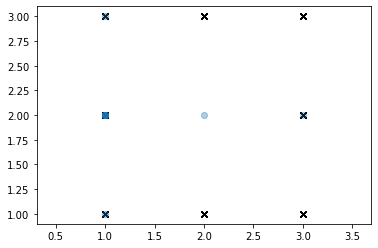

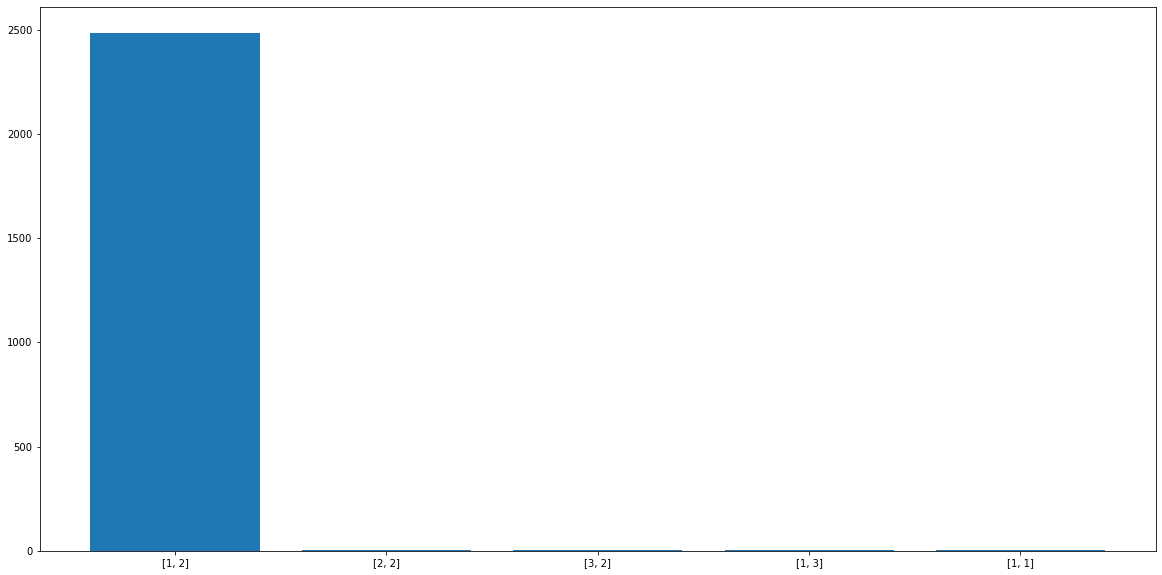

Processing Epoch 133
training start
Iteration 0, d real/fake loss 0.6560040712356567/0.5692138671875 and g loss is 0.8358298540115356, NDiv loss 0.2679384648799896
Iteration 1, d real/fake loss 0.65540611743927/0.5689467787742615 and g loss is 0.837117612361908, NDiv loss 0.20788796246051788
Iteration 2, d real/fake loss 0.6548088788986206/0.567437469959259 and g loss is 0.8394627571105957, NDiv loss 0.19933339953422546
Iteration 3, d real/fake loss 0.6542119979858398/0.5658700466156006 and g loss is 0.8388280272483826, NDiv loss 0.25154849886894226
Iteration 4, d real/fake loss 0.6536146998405457/0.5648903846740723 and g loss is 0.8417145609855652, NDiv loss 0.2708374857902527


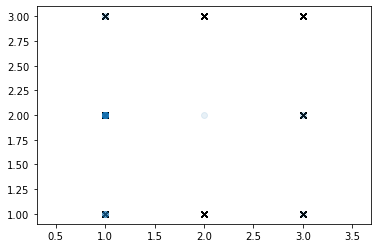

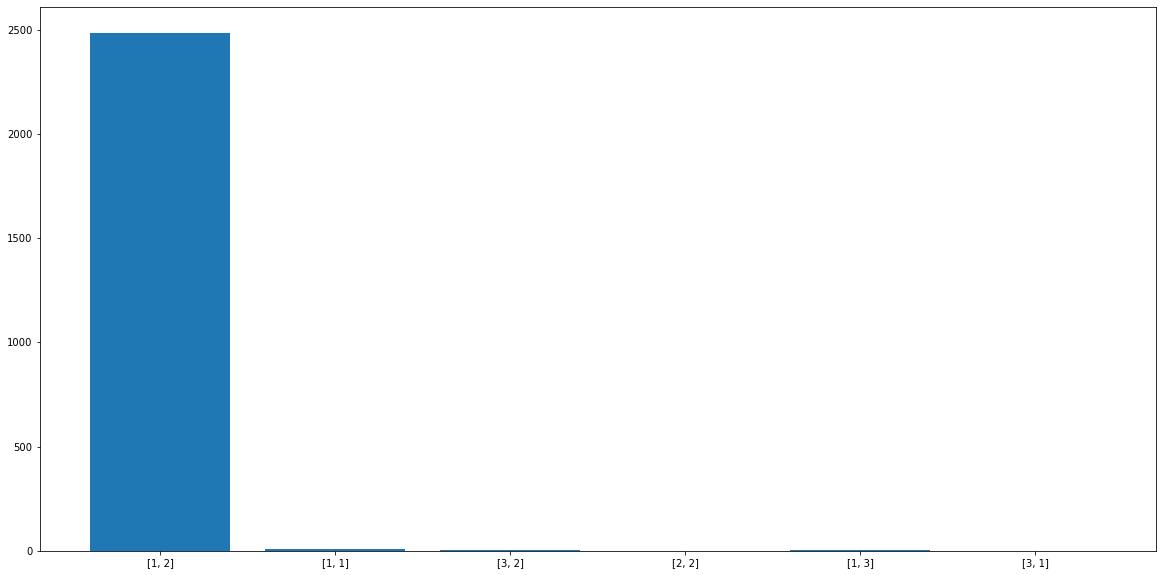

Processing Epoch 134
training start
Iteration 0, d real/fake loss 0.6647520065307617/0.5643486976623535 and g loss is 0.8420252799987793, NDiv loss 0.2621631920337677
Iteration 1, d real/fake loss 0.6643548011779785/0.5627979040145874 and g loss is 0.8440579175949097, NDiv loss 0.2515469193458557
Iteration 2, d real/fake loss 0.6639518737792969/0.5612468719482422 and g loss is 0.8462337255477905, NDiv loss 0.22440677881240845
Iteration 3, d real/fake loss 0.6635431051254272/0.5610405206680298 and g loss is 0.8464850187301636, NDiv loss 0.2861981689929962
Iteration 4, d real/fake loss 0.6631290912628174/0.5609244704246521 and g loss is 0.8483818769454956, NDiv loss 0.2778785526752472


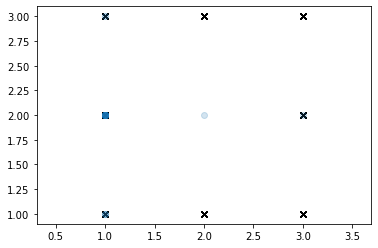

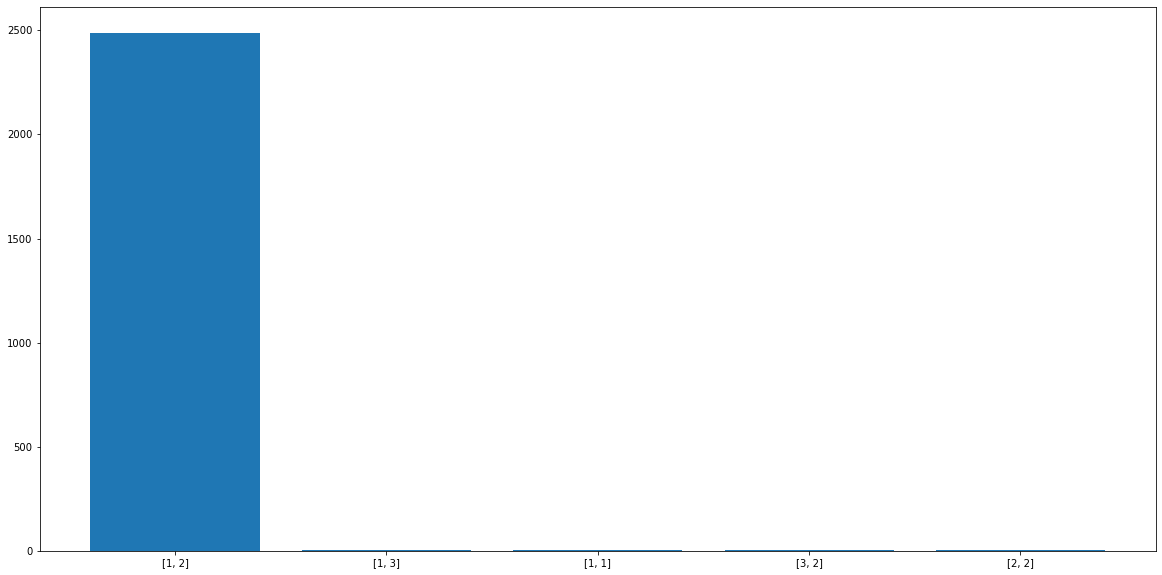

Processing Epoch 135
training start
Iteration 0, d real/fake loss 0.6360043287277222/0.5597657561302185 and g loss is 0.8495422601699829, NDiv loss 0.2438216209411621
Iteration 1, d real/fake loss 0.6353161334991455/0.5577383637428284 and g loss is 0.8504830598831177, NDiv loss 0.25381410121917725
Iteration 2, d real/fake loss 0.6346273422241211/0.5564027428627014 and g loss is 0.8530412912368774, NDiv loss 0.2748812735080719
Iteration 3, d real/fake loss 0.6339372992515564/0.5557039976119995 and g loss is 0.8541001081466675, NDiv loss 0.26457351446151733
Iteration 4, d real/fake loss 0.6332470178604126/0.5547224283218384 and g loss is 0.8553484678268433, NDiv loss 0.20185403525829315


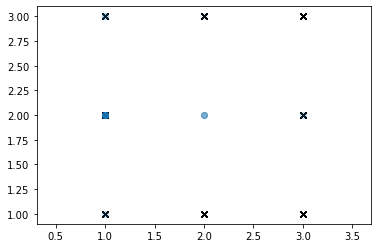

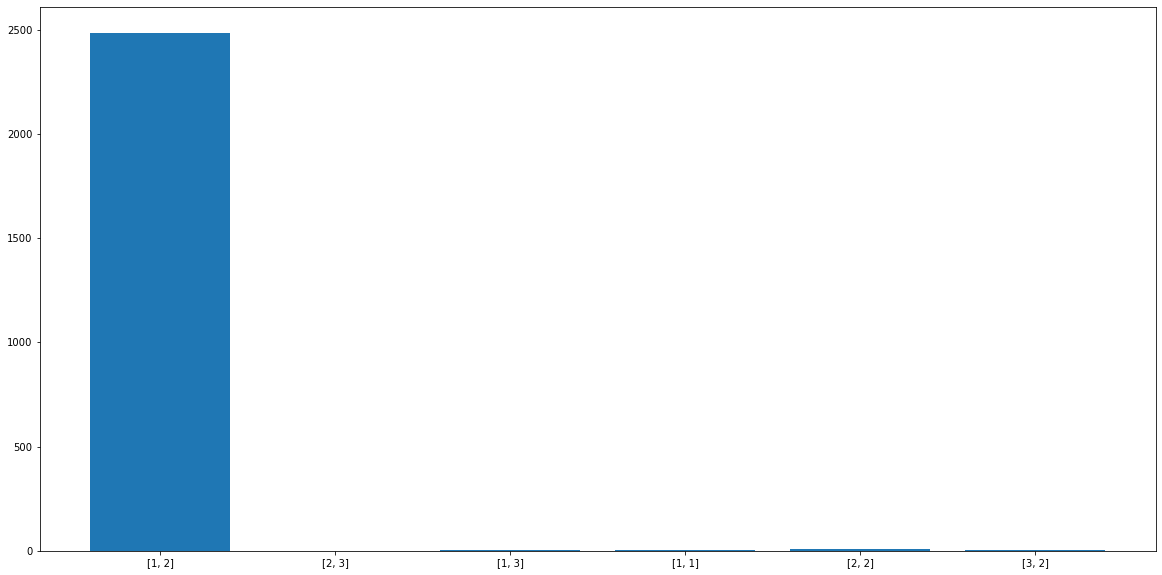

Processing Epoch 136
training start
Iteration 0, d real/fake loss 0.6641262769699097/0.5535153150558472 and g loss is 0.8567135334014893, NDiv loss 0.22296839952468872
Iteration 1, d real/fake loss 0.6635915637016296/0.553276777267456 and g loss is 0.8577914237976074, NDiv loss 0.198383167386055
Iteration 2, d real/fake loss 0.6630424857139587/0.5516742467880249 and g loss is 0.8605179786682129, NDiv loss 0.22559493780136108
Iteration 3, d real/fake loss 0.6624816656112671/0.5513471961021423 and g loss is 0.8591005802154541, NDiv loss 0.1969130039215088
Iteration 4, d real/fake loss 0.6619098782539368/0.5500873327255249 and g loss is 0.8593448400497437, NDiv loss 0.24414889514446259


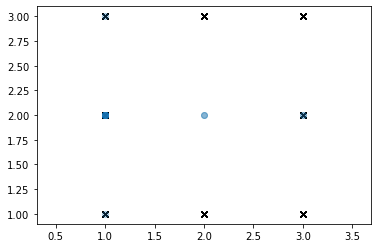

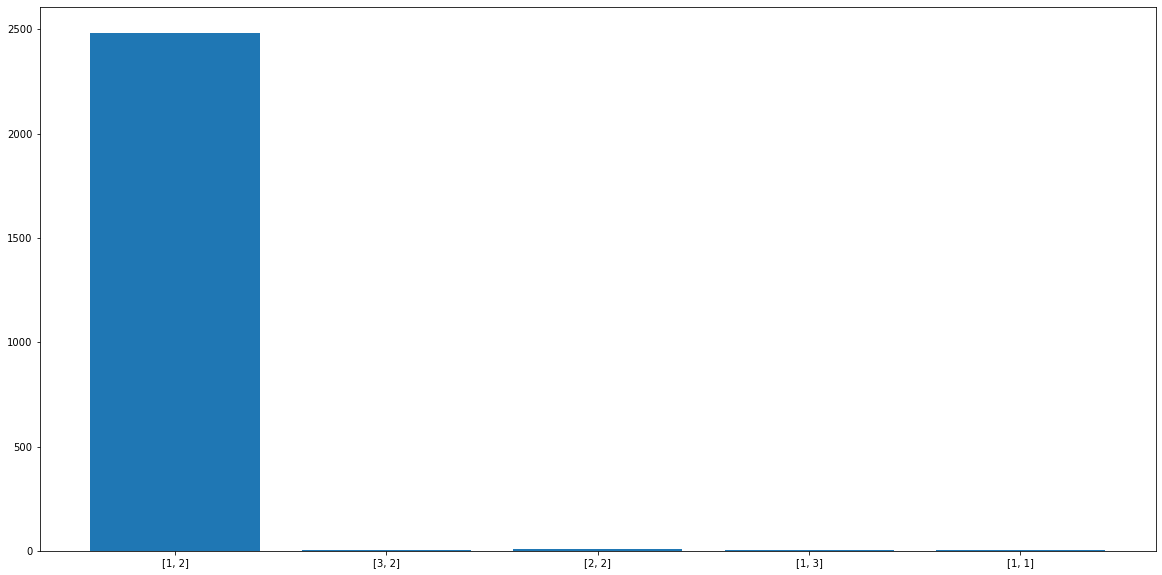

Processing Epoch 137
training start
Iteration 0, d real/fake loss 0.6394219994544983/0.5485274791717529 and g loss is 0.8637114763259888, NDiv loss 0.23089735209941864
Iteration 1, d real/fake loss 0.6388436555862427/0.5476216673851013 and g loss is 0.8629269003868103, NDiv loss 0.2667423486709595
Iteration 2, d real/fake loss 0.6382728815078735/0.5466518998146057 and g loss is 0.8651267290115356, NDiv loss 0.20394478738307953
Iteration 3, d real/fake loss 0.6377081871032715/0.5465942025184631 and g loss is 0.8638285398483276, NDiv loss 0.19752934575080872
Iteration 4, d real/fake loss 0.6371496915817261/0.545377254486084 and g loss is 0.8686608076095581, NDiv loss 0.24514983594417572


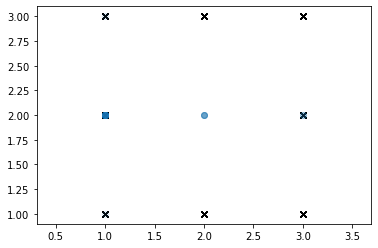

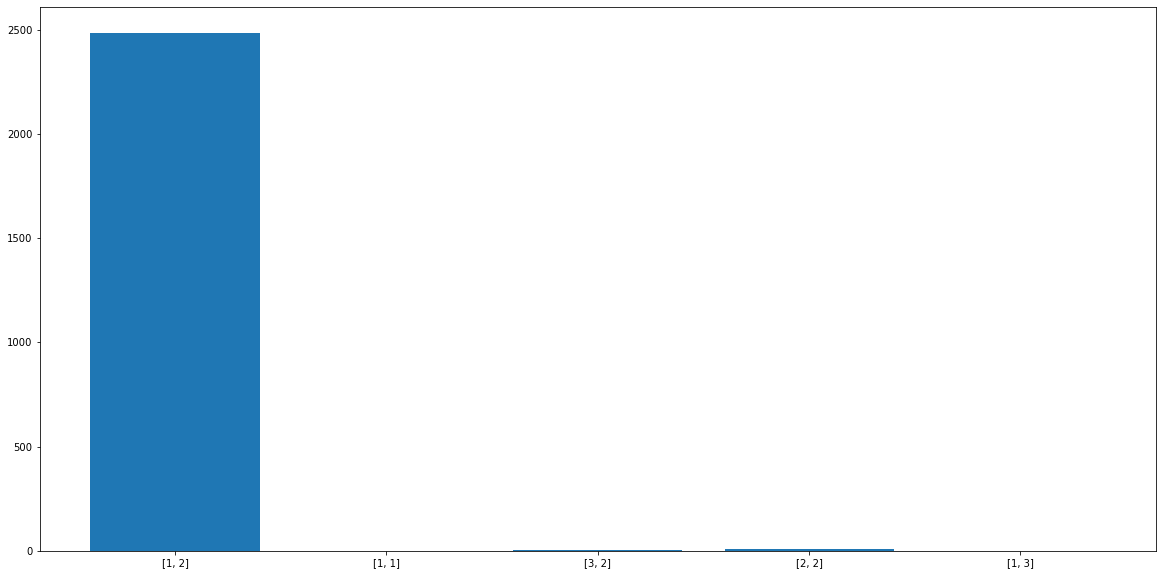

Processing Epoch 138
training start
Iteration 0, d real/fake loss 0.6322801113128662/0.5439239740371704 and g loss is 0.86979079246521, NDiv loss 0.20817406475543976
Iteration 1, d real/fake loss 0.631766676902771/0.5430846214294434 and g loss is 0.8714759349822998, NDiv loss 0.21408048272132874
Iteration 2, d real/fake loss 0.6312601566314697/0.5414962768554688 and g loss is 0.8727661371231079, NDiv loss 0.22367718815803528
Iteration 3, d real/fake loss 0.6307587027549744/0.5413360595703125 and g loss is 0.8733391761779785, NDiv loss 0.24707548320293427
Iteration 4, d real/fake loss 0.6302624344825745/0.5411649346351624 and g loss is 0.8737091422080994, NDiv loss 0.20110851526260376


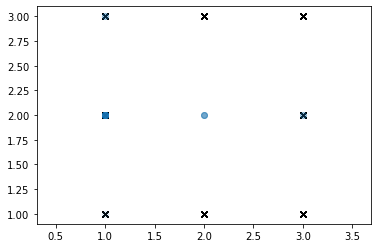

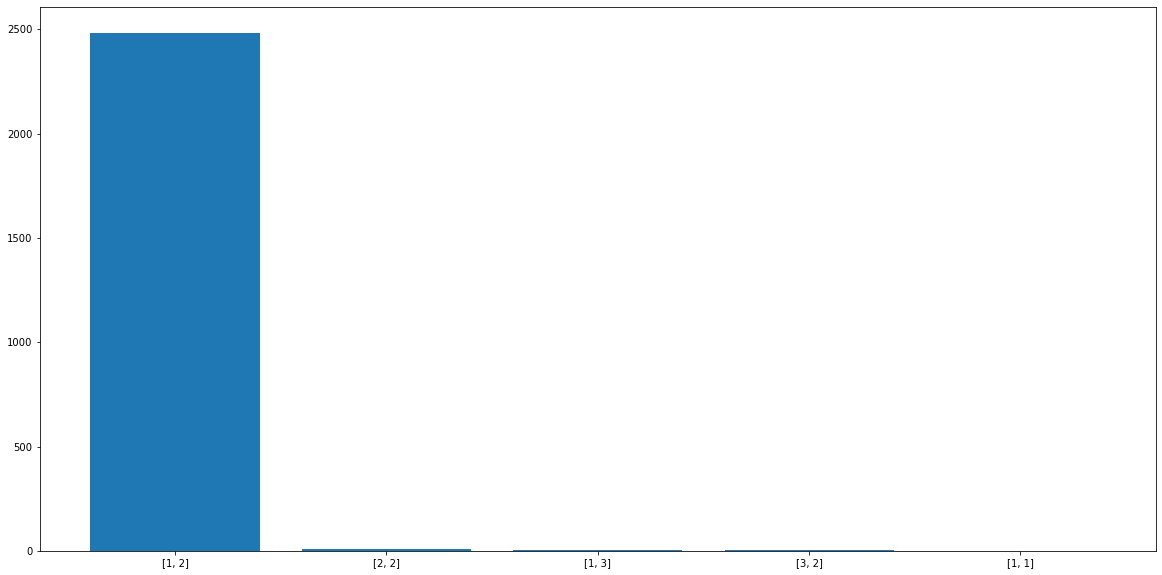

Processing Epoch 139
training start
Iteration 0, d real/fake loss 0.6677039265632629/0.5406950116157532 and g loss is 0.8747920989990234, NDiv loss 0.2673187851905823
Iteration 1, d real/fake loss 0.667242705821991/0.5380754470825195 and g loss is 0.8755767345428467, NDiv loss 0.19965264201164246
Iteration 2, d real/fake loss 0.6667501926422119/0.5382654666900635 and g loss is 0.8794978857040405, NDiv loss 0.2113059163093567
Iteration 3, d real/fake loss 0.6662302613258362/0.5382773876190186 and g loss is 0.8798179626464844, NDiv loss 0.2719476819038391
Iteration 4, d real/fake loss 0.6656863689422607/0.5358061194419861 and g loss is 0.88044673204422, NDiv loss 0.2022152990102768


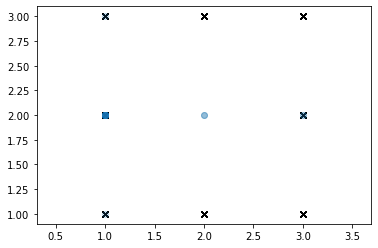

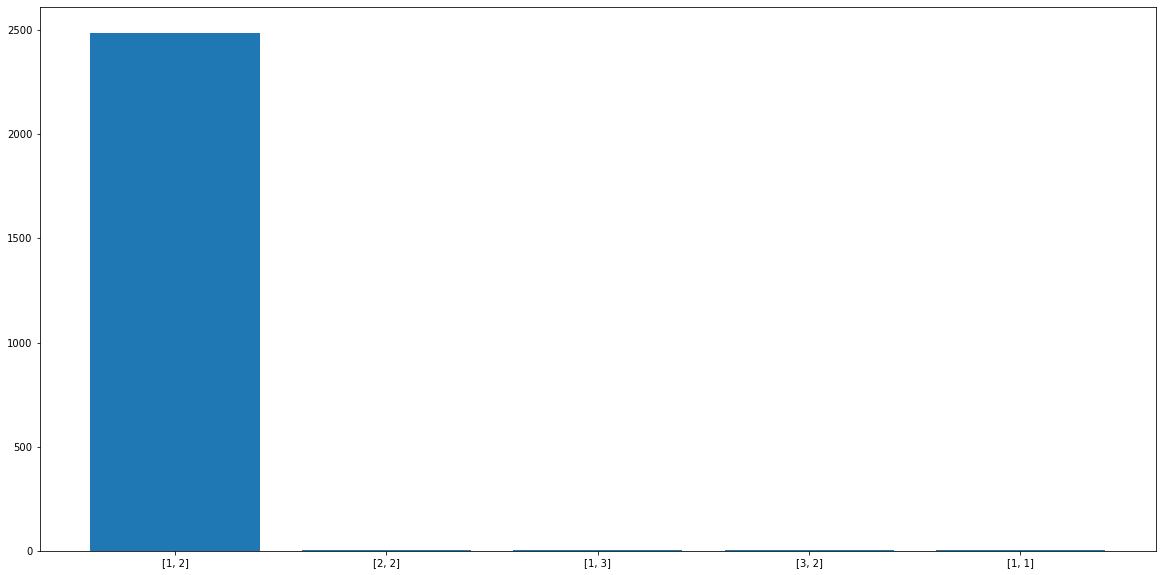

Processing Epoch 140
training start
Iteration 0, d real/fake loss 0.6421377658843994/0.537449836730957 and g loss is 0.8820574283599854, NDiv loss 0.2295280545949936
Iteration 1, d real/fake loss 0.6415592432022095/0.5348600149154663 and g loss is 0.8832848072052002, NDiv loss 0.18159763514995575
Iteration 2, d real/fake loss 0.6409786939620972/0.5330698490142822 and g loss is 0.8839952349662781, NDiv loss 0.23610417544841766
Iteration 3, d real/fake loss 0.6403954029083252/0.5337982773780823 and g loss is 0.8851756453514099, NDiv loss 0.2671387493610382
Iteration 4, d real/fake loss 0.6398106813430786/0.5334041714668274 and g loss is 0.887473464012146, NDiv loss 0.2208404541015625


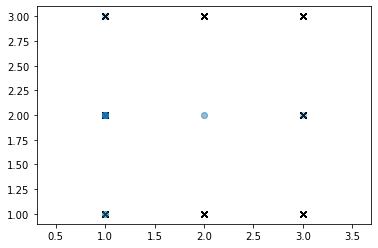

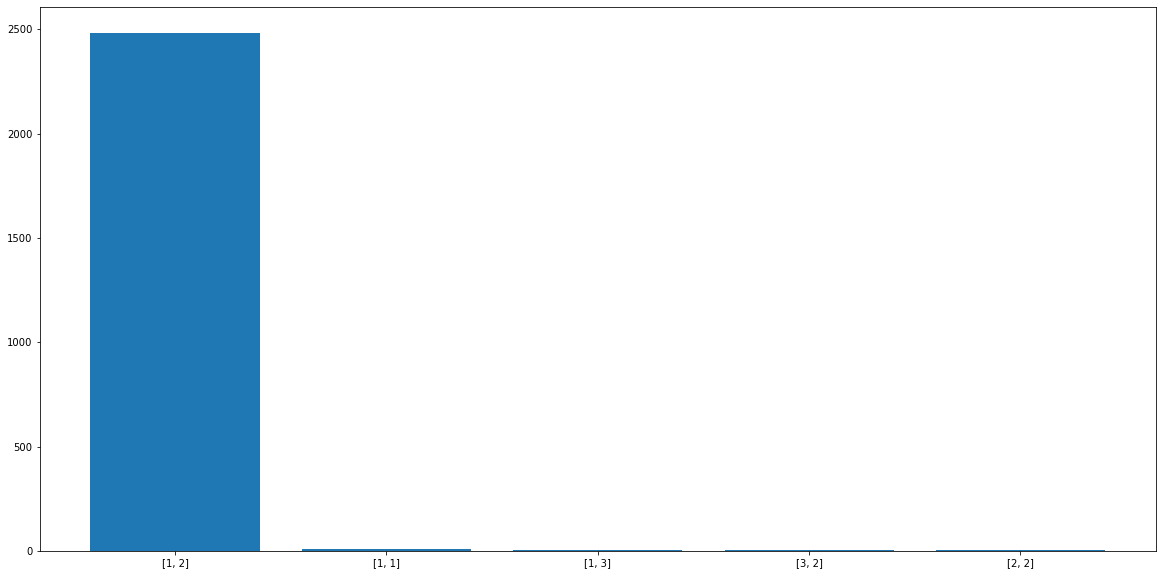

Processing Epoch 141
training start
Iteration 0, d real/fake loss 0.6569966077804565/0.5310293436050415 and g loss is 0.888606071472168, NDiv loss 0.18220648169517517
Iteration 1, d real/fake loss 0.6564801931381226/0.5316327810287476 and g loss is 0.8893877267837524, NDiv loss 0.23309053480625153
Iteration 2, d real/fake loss 0.6559536457061768/0.5297659039497375 and g loss is 0.8906924724578857, NDiv loss 0.26583772897720337
Iteration 3, d real/fake loss 0.655417799949646/0.5290334224700928 and g loss is 0.8916001915931702, NDiv loss 0.2437487542629242
Iteration 4, d real/fake loss 0.6548738479614258/0.5266793966293335 and g loss is 0.8927479982376099, NDiv loss 0.2292465716600418


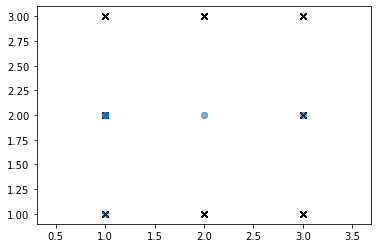

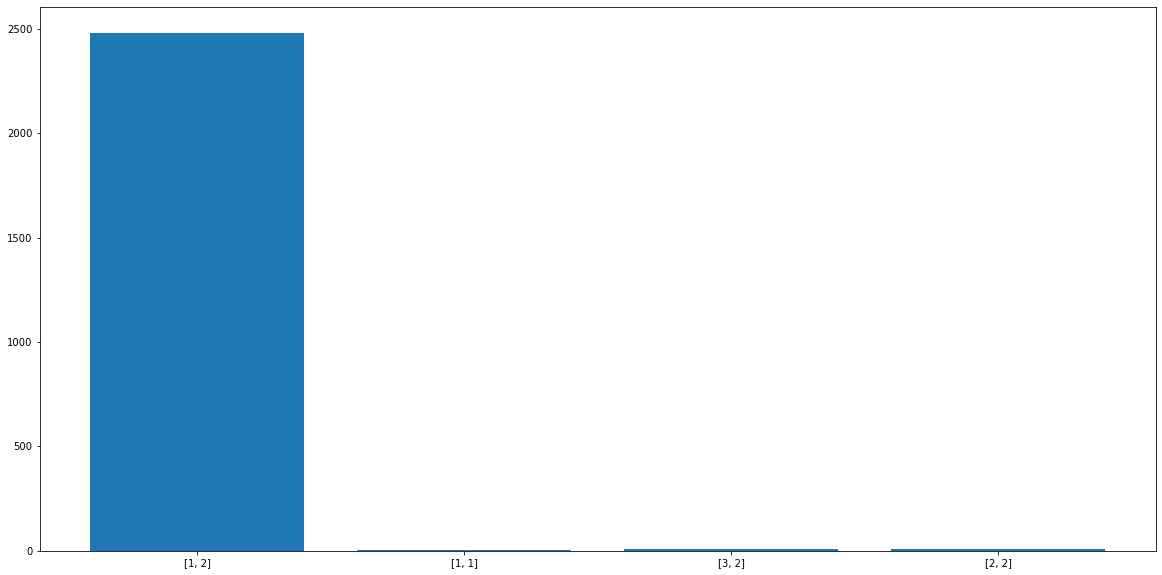

Processing Epoch 142
training start
Iteration 0, d real/fake loss 0.673989474773407/0.5264797210693359 and g loss is 0.8924935460090637, NDiv loss 0.24112632870674133
Iteration 1, d real/fake loss 0.6734359264373779/0.5265226364135742 and g loss is 0.8961299657821655, NDiv loss 0.17284373939037323
Iteration 2, d real/fake loss 0.6728600859642029/0.525391161441803 and g loss is 0.893596887588501, NDiv loss 0.19252462685108185
Iteration 3, d real/fake loss 0.6722657084465027/0.5243330001831055 and g loss is 0.8967955708503723, NDiv loss 0.20547057688236237
Iteration 4, d real/fake loss 0.6716534495353699/0.5256741642951965 and g loss is 0.8967252969741821, NDiv loss 0.1990462690591812


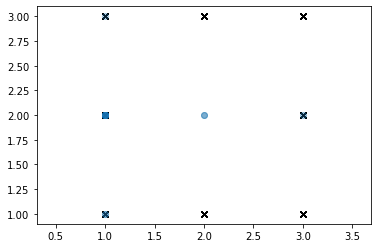

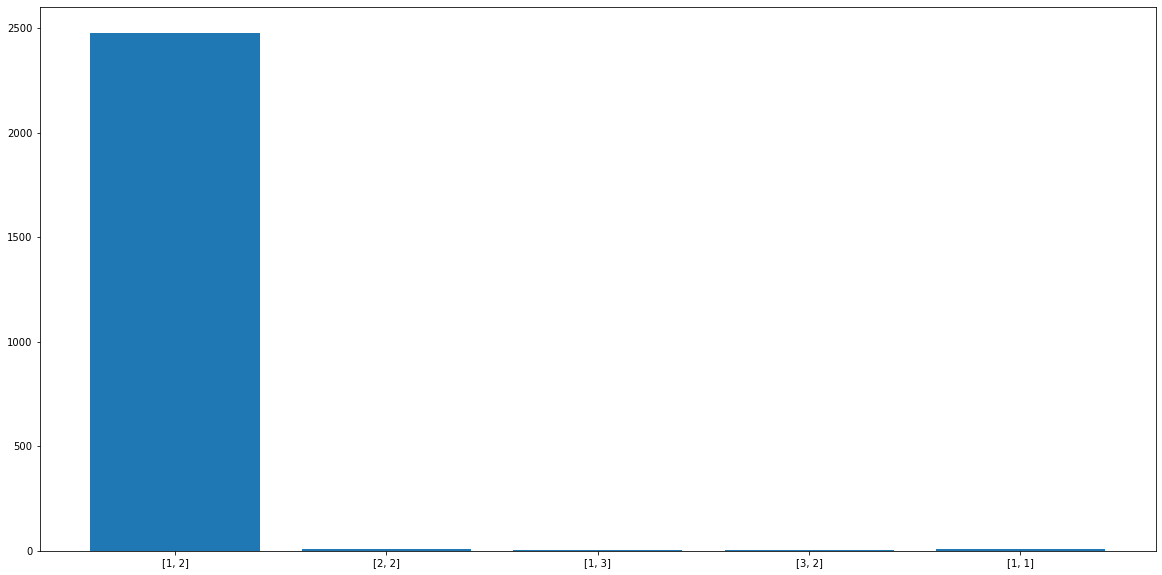

Processing Epoch 143
training start
Iteration 0, d real/fake loss 0.6400762796401978/0.5260463953018188 and g loss is 0.8944375514984131, NDiv loss 0.26087599992752075
Iteration 1, d real/fake loss 0.6393926739692688/0.5227132439613342 and g loss is 0.8983814716339111, NDiv loss 0.17448194324970245
Iteration 2, d real/fake loss 0.638710618019104/0.5240228772163391 and g loss is 0.8996129035949707, NDiv loss 0.24663223326206207
Iteration 3, d real/fake loss 0.6380301713943481/0.5273377895355225 and g loss is 0.9017114043235779, NDiv loss 0.24468837678432465
Iteration 4, d real/fake loss 0.6373549103736877/0.5220280289649963 and g loss is 0.9024133682250977, NDiv loss 0.21601982414722443


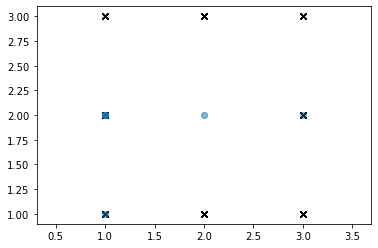

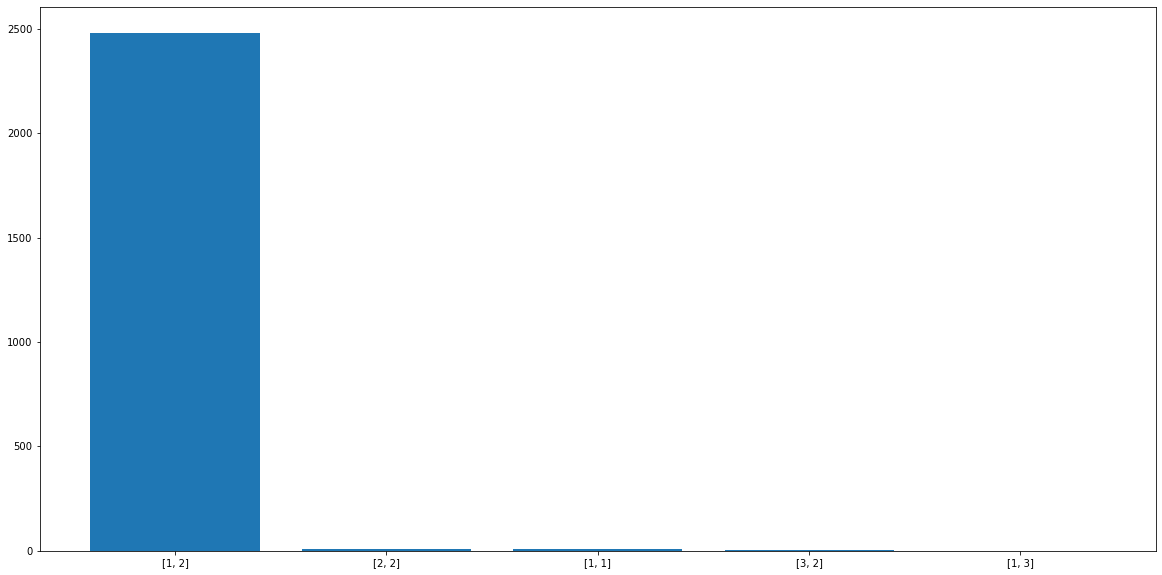

Processing Epoch 144
training start
Iteration 0, d real/fake loss 0.646605372428894/0.5211816430091858 and g loss is 0.9017031192779541, NDiv loss 0.2133367657661438
Iteration 1, d real/fake loss 0.6459863781929016/0.5214787721633911 and g loss is 0.9008117318153381, NDiv loss 0.1984502226114273
Iteration 2, d real/fake loss 0.6453682780265808/0.5189940929412842 and g loss is 0.9007931351661682, NDiv loss 0.2848946750164032
Iteration 3, d real/fake loss 0.6447504162788391/0.5197227001190186 and g loss is 0.903804361820221, NDiv loss 0.23943087458610535
Iteration 4, d real/fake loss 0.6441333889961243/0.518591582775116 and g loss is 0.90347820520401, NDiv loss 0.2215389609336853


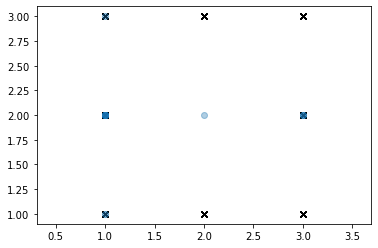

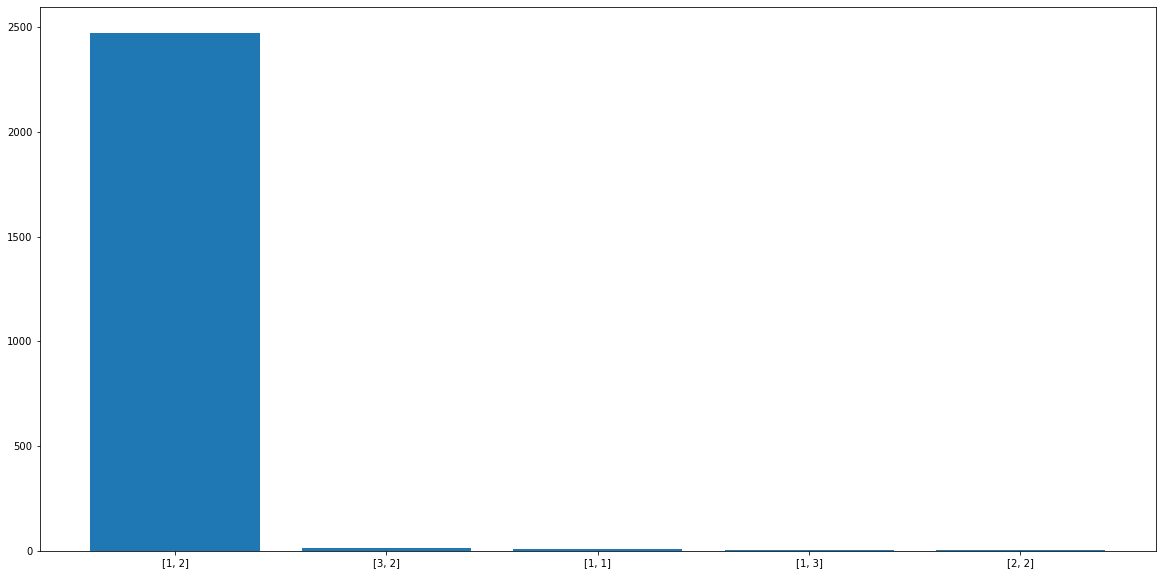

Processing Epoch 145
training start
Iteration 0, d real/fake loss 0.6069939136505127/0.5201511383056641 and g loss is 0.9045653343200684, NDiv loss 0.2039749175310135
Iteration 1, d real/fake loss 0.6062968373298645/0.5191607475280762 and g loss is 0.90659499168396, NDiv loss 0.23205135762691498
Iteration 2, d real/fake loss 0.6056159138679504/0.5192598104476929 and g loss is 0.9071848392486572, NDiv loss 0.25737226009368896
Iteration 3, d real/fake loss 0.6049503087997437/0.5175139904022217 and g loss is 0.9092816710472107, NDiv loss 0.22926582396030426
Iteration 4, d real/fake loss 0.6042978763580322/0.5204498171806335 and g loss is 0.9100979566574097, NDiv loss 0.21194450557231903


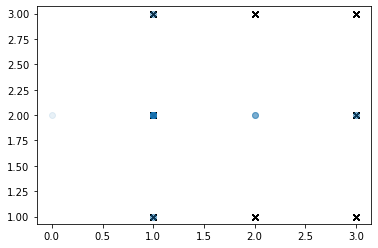

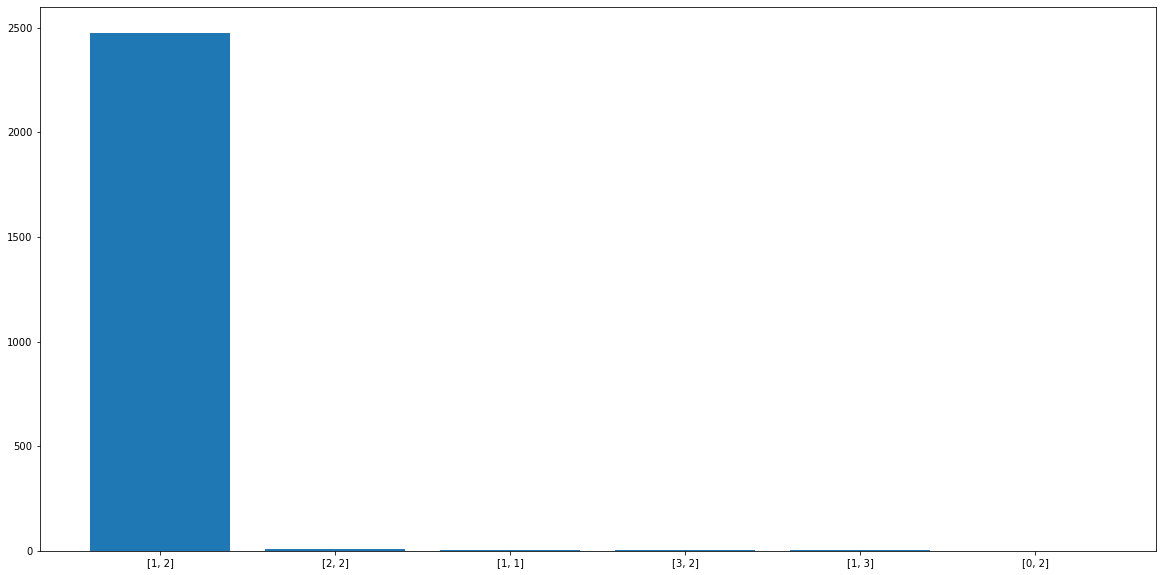

Processing Epoch 146
training start
Iteration 0, d real/fake loss 0.6355096101760864/0.514450192451477 and g loss is 0.9090386629104614, NDiv loss 0.2050645649433136
Iteration 1, d real/fake loss 0.6350131034851074/0.5171566009521484 and g loss is 0.9128236770629883, NDiv loss 0.21501679718494415
Iteration 2, d real/fake loss 0.6345169544219971/0.513685941696167 and g loss is 0.9114518761634827, NDiv loss 0.19264867901802063
Iteration 3, d real/fake loss 0.6340187788009644/0.5172168016433716 and g loss is 0.9122018814086914, NDiv loss 0.2514449656009674
Iteration 4, d real/fake loss 0.6335213780403137/0.5164353847503662 and g loss is 0.9142889976501465, NDiv loss 0.23793010413646698


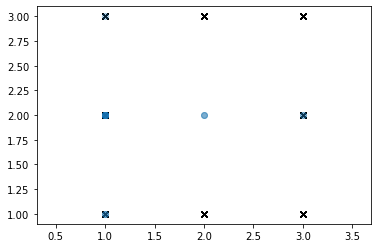

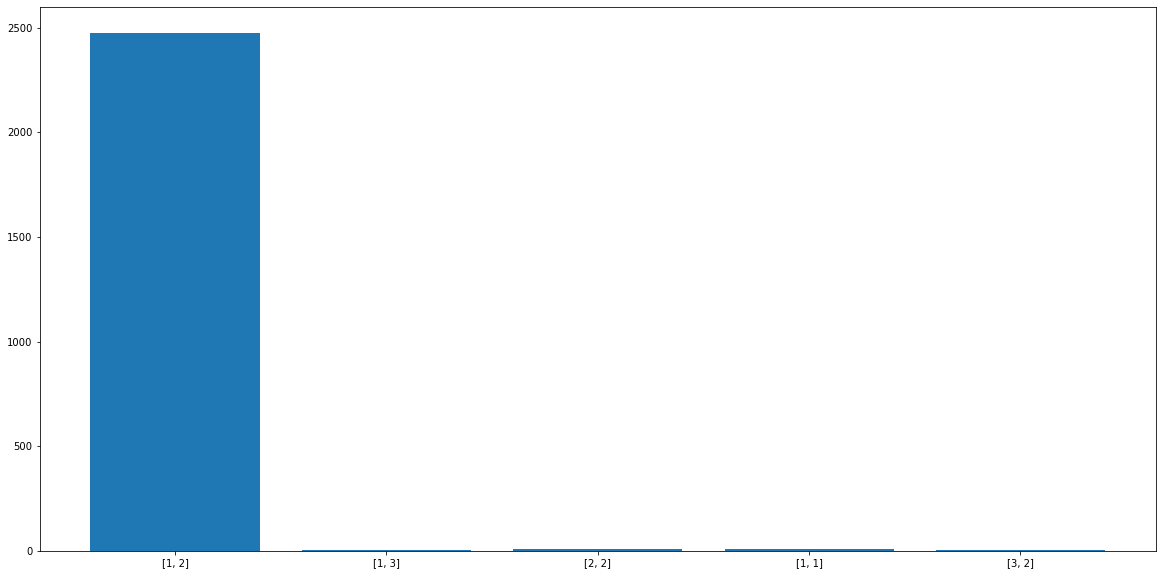

Processing Epoch 147
training start
Iteration 0, d real/fake loss 0.6332853436470032/0.5122097730636597 and g loss is 0.9144644141197205, NDiv loss 0.21733874082565308
Iteration 1, d real/fake loss 0.6328006982803345/0.5111243724822998 and g loss is 0.9172255396842957, NDiv loss 0.19869625568389893
Iteration 2, d real/fake loss 0.6323129534721375/0.5143532752990723 and g loss is 0.9142162799835205, NDiv loss 0.22464695572853088
Iteration 3, d real/fake loss 0.631824254989624/0.5128715634346008 and g loss is 0.9163522720336914, NDiv loss 0.23277024924755096
Iteration 4, d real/fake loss 0.6313357353210449/0.5107991695404053 and g loss is 0.917290985584259, NDiv loss 0.19056436419487


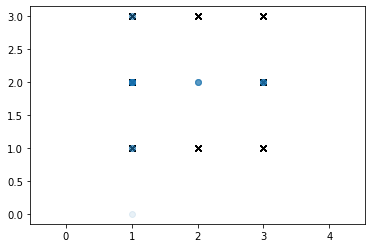

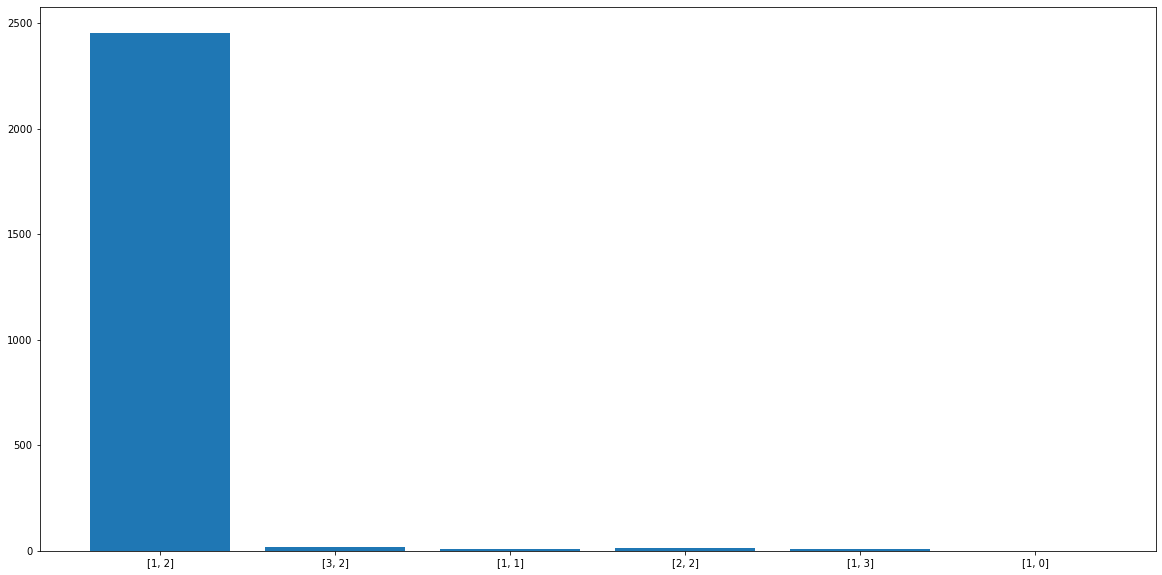

Processing Epoch 148
training start
Iteration 0, d real/fake loss 0.6107426881790161/0.5100646018981934 and g loss is 0.9185160994529724, NDiv loss 0.26155799627304077
Iteration 1, d real/fake loss 0.6101757884025574/0.5098952651023865 and g loss is 0.920516848564148, NDiv loss 0.1546339988708496
Iteration 2, d real/fake loss 0.6096160411834717/0.5116769075393677 and g loss is 0.9209622740745544, NDiv loss 0.17844340205192566
Iteration 3, d real/fake loss 0.6090641021728516/0.50795978307724 and g loss is 0.923021137714386, NDiv loss 0.23159223794937134
Iteration 4, d real/fake loss 0.6085175275802612/0.5090681314468384 and g loss is 0.9216080904006958, NDiv loss 0.21310609579086304


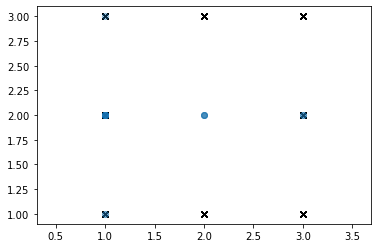

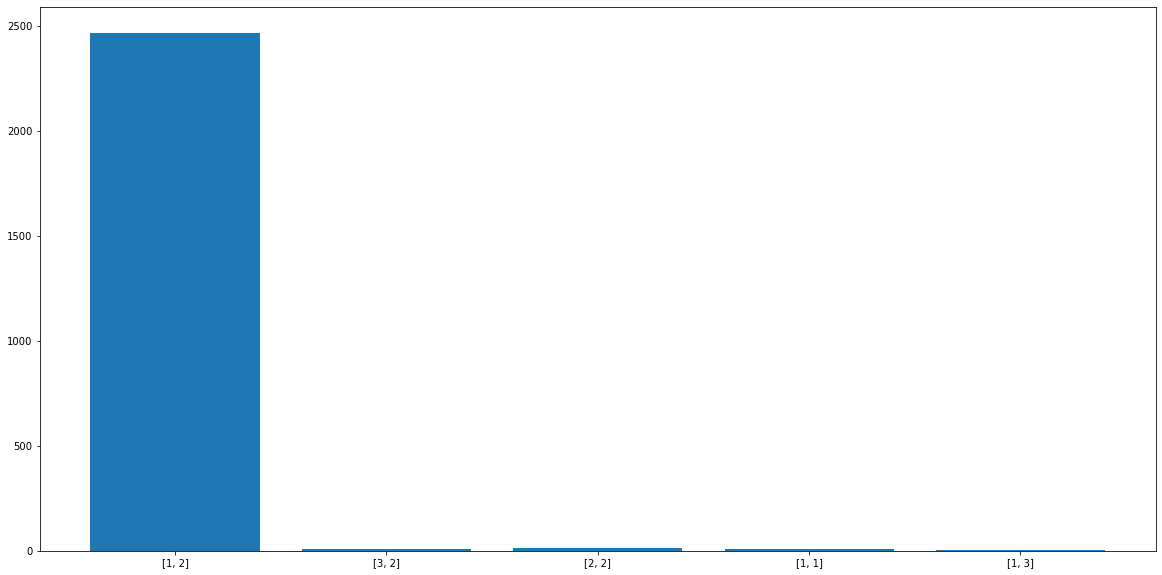

Processing Epoch 149
training start
Iteration 0, d real/fake loss 0.5972529053688049/0.5078704357147217 and g loss is 0.9216139912605286, NDiv loss 0.20143717527389526
Iteration 1, d real/fake loss 0.5966929197311401/0.509502649307251 and g loss is 0.9228733777999878, NDiv loss 0.2123102992773056
Iteration 2, d real/fake loss 0.5961440205574036/0.5092743039131165 and g loss is 0.9275839924812317, NDiv loss 0.21240463852882385
Iteration 3, d real/fake loss 0.5956053733825684/0.5046631097793579 and g loss is 0.9265016317367554, NDiv loss 0.21939615905284882
Iteration 4, d real/fake loss 0.5950735807418823/0.5018656849861145 and g loss is 0.9246394038200378, NDiv loss 0.2023932933807373


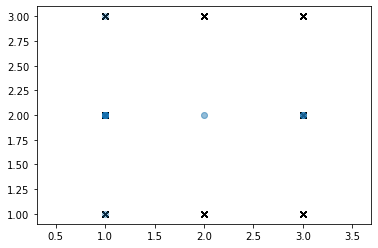

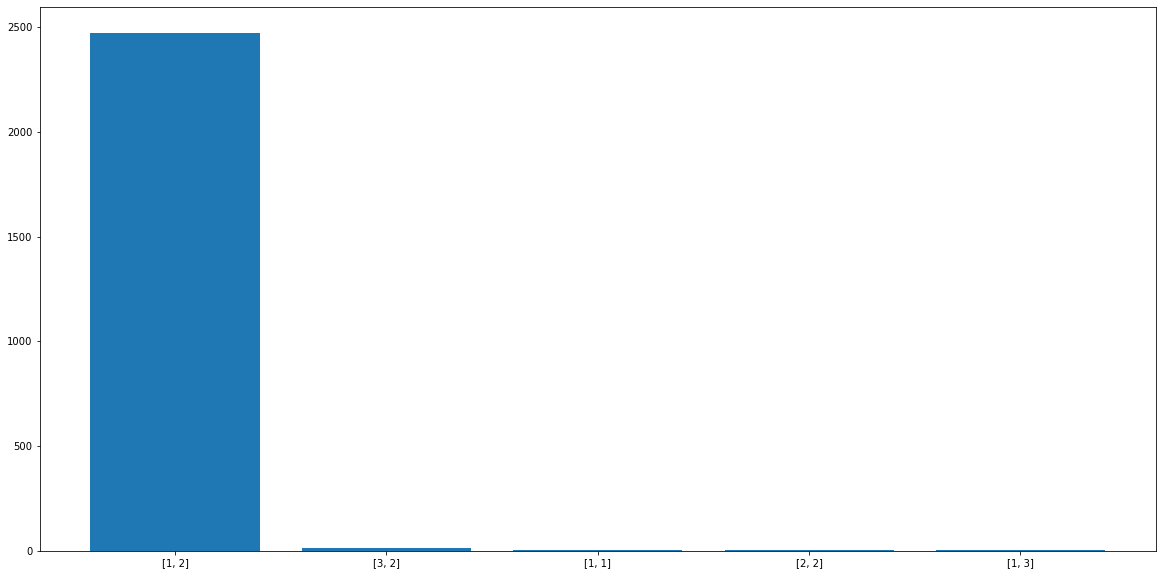

Processing Epoch 150
training start
Iteration 0, d real/fake loss 0.6250388622283936/0.5017147064208984 and g loss is 0.9281363487243652, NDiv loss 0.2033301144838333
Iteration 1, d real/fake loss 0.6245866417884827/0.5039017200469971 and g loss is 0.9301246404647827, NDiv loss 0.20084787905216217
Iteration 2, d real/fake loss 0.6241251230239868/0.5025028586387634 and g loss is 0.9210371375083923, NDiv loss 0.2334059625864029
Iteration 3, d real/fake loss 0.6236546635627747/0.5068730711936951 and g loss is 0.9278018474578857, NDiv loss 0.21220438182353973
Iteration 4, d real/fake loss 0.62317955493927/0.5017156600952148 and g loss is 0.9324684739112854, NDiv loss 0.21238471567630768


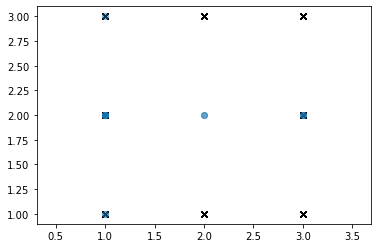

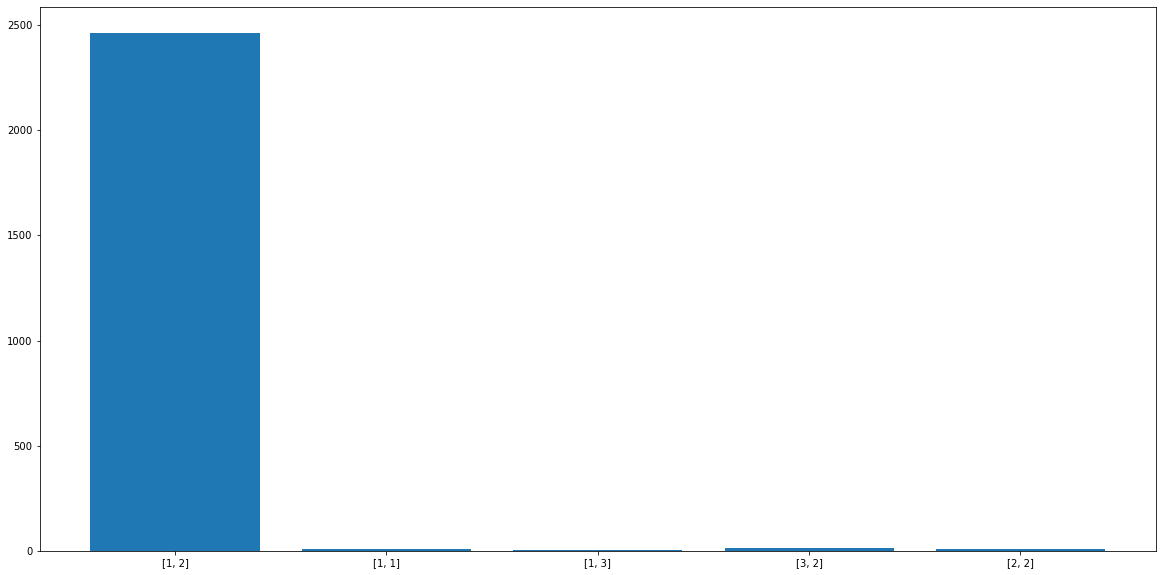

Processing Epoch 151
training start
Iteration 0, d real/fake loss 0.6163086295127869/0.5010456442832947 and g loss is 0.9291335344314575, NDiv loss 0.17499397695064545
Iteration 1, d real/fake loss 0.6157865524291992/0.5044897794723511 and g loss is 0.9331231117248535, NDiv loss 0.21488484740257263
Iteration 2, d real/fake loss 0.6152573823928833/0.50477135181427 and g loss is 0.9303569197654724, NDiv loss 0.20071041584014893
Iteration 3, d real/fake loss 0.614721417427063/0.49940818548202515 and g loss is 0.9335067272186279, NDiv loss 0.20786018669605255
Iteration 4, d real/fake loss 0.6141796112060547/0.4998418688774109 and g loss is 0.9266446828842163, NDiv loss 0.1876080334186554


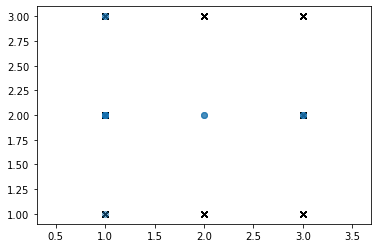

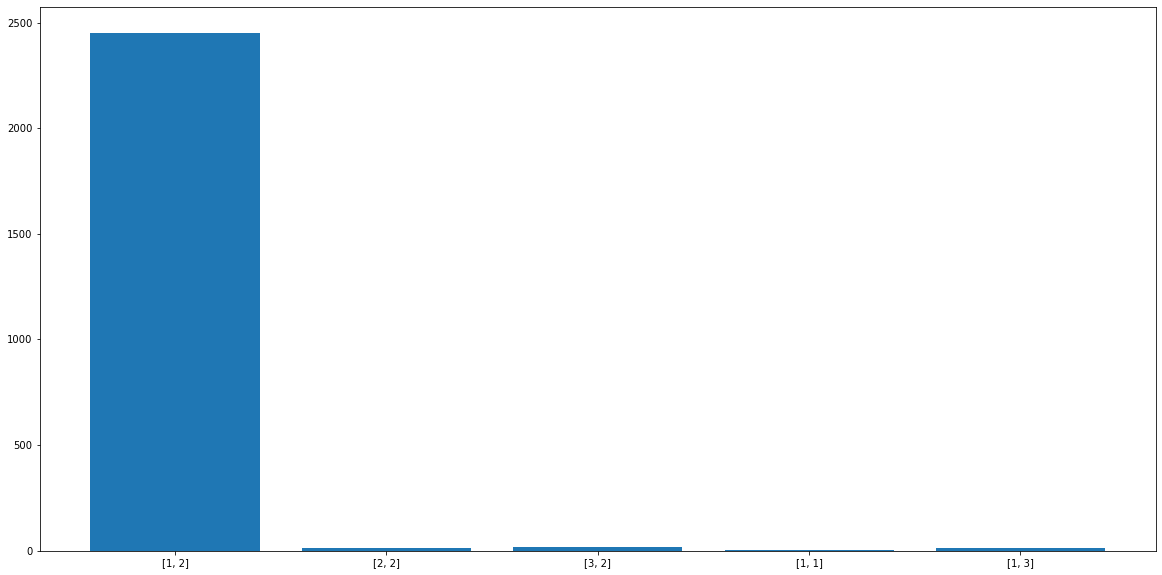

Processing Epoch 152
training start
Iteration 0, d real/fake loss 0.6114990711212158/0.4994637370109558 and g loss is 0.931926429271698, NDiv loss 0.21526362001895905
Iteration 1, d real/fake loss 0.6109326481819153/0.5040750503540039 and g loss is 0.9257745146751404, NDiv loss 0.20104357600212097
Iteration 2, d real/fake loss 0.6103668808937073/0.4990719258785248 and g loss is 0.9356924295425415, NDiv loss 0.20798742771148682
Iteration 3, d real/fake loss 0.6098002195358276/0.49906423687934875 and g loss is 0.9361793994903564, NDiv loss 0.19742394983768463
Iteration 4, d real/fake loss 0.6092333197593689/0.5015758872032166 and g loss is 0.9312832355499268, NDiv loss 0.17408548295497894


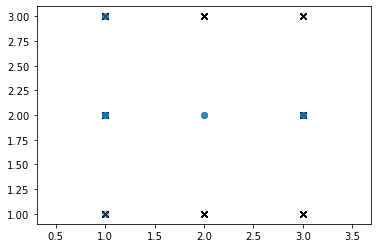

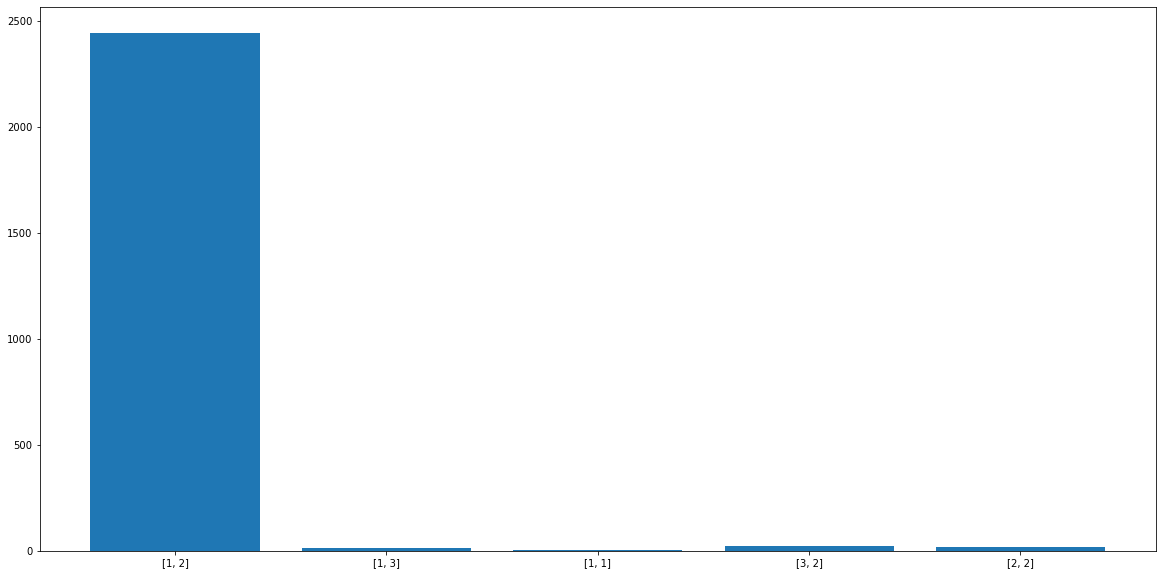

Processing Epoch 153
training start
Iteration 0, d real/fake loss 0.5982418060302734/0.5044164061546326 and g loss is 0.9380730390548706, NDiv loss 0.1956709623336792
Iteration 1, d real/fake loss 0.5976645946502686/0.5015931129455566 and g loss is 0.9396731853485107, NDiv loss 0.20475077629089355
Iteration 2, d real/fake loss 0.5970926284790039/0.5049535632133484 and g loss is 0.9345843195915222, NDiv loss 0.22570237517356873
Iteration 3, d real/fake loss 0.5965276956558228/0.49903467297554016 and g loss is 0.9340031147003174, NDiv loss 0.1518488973379135
Iteration 4, d real/fake loss 0.5959666967391968/0.49508970975875854 and g loss is 0.9389438629150391, NDiv loss 0.17895136773586273


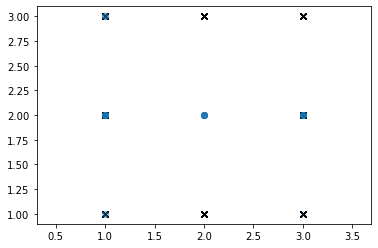

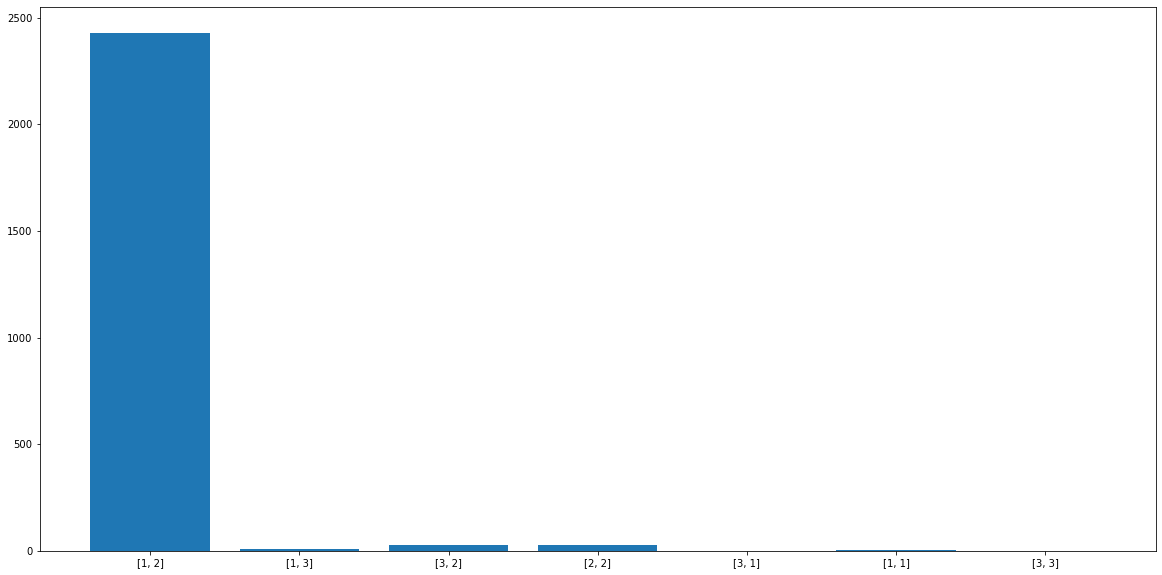

Processing Epoch 154
training start
Iteration 0, d real/fake loss 0.6266554594039917/0.49489444494247437 and g loss is 0.9385504126548767, NDiv loss 0.17507734894752502
Iteration 1, d real/fake loss 0.6261956095695496/0.4977012872695923 and g loss is 0.9315202236175537, NDiv loss 0.17623229324817657
Iteration 2, d real/fake loss 0.6257296204566956/0.500771164894104 and g loss is 0.9326556921005249, NDiv loss 0.17991748452186584
Iteration 3, d real/fake loss 0.6252597570419312/0.501599133014679 and g loss is 0.9248844385147095, NDiv loss 0.19345781207084656
Iteration 4, d real/fake loss 0.6247867345809937/0.5035423040390015 and g loss is 0.9310094714164734, NDiv loss 0.1645115166902542


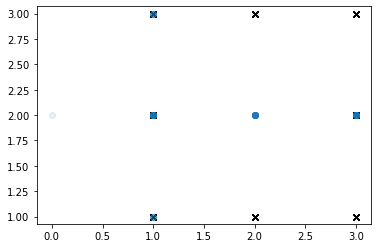

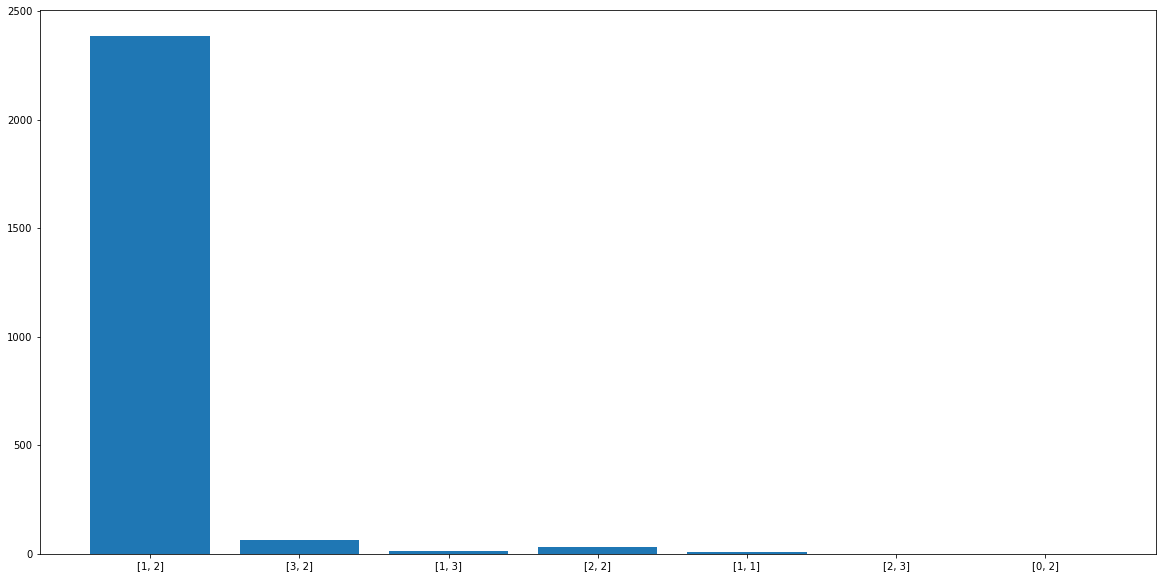

Processing Epoch 155
training start
Iteration 0, d real/fake loss 0.588765025138855/0.5133025646209717 and g loss is 0.9370734691619873, NDiv loss 0.19249913096427917
Iteration 1, d real/fake loss 0.5881844162940979/0.49753236770629883 and g loss is 0.9243184328079224, NDiv loss 0.16801190376281738
Iteration 2, d real/fake loss 0.5876089334487915/0.5003984570503235 and g loss is 0.9291868209838867, NDiv loss 0.14470940828323364
Iteration 3, d real/fake loss 0.5870395302772522/0.5042653679847717 and g loss is 0.923384428024292, NDiv loss 0.16588515043258667
Iteration 4, d real/fake loss 0.5864807367324829/0.5038389563560486 and g loss is 0.928035318851471, NDiv loss 0.16045093536376953


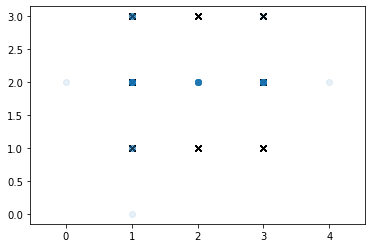

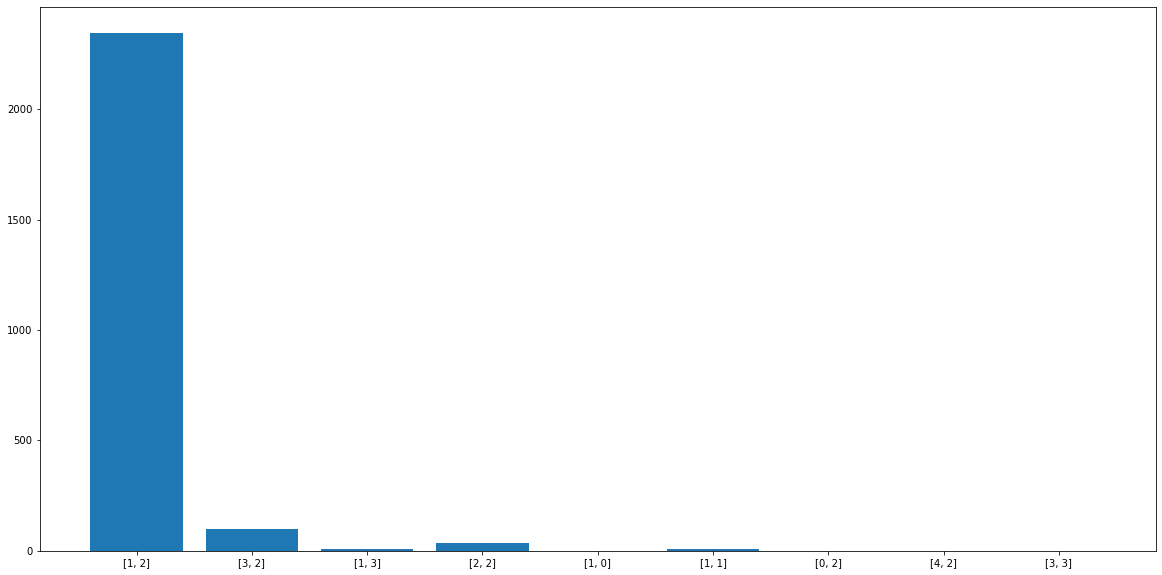

Processing Epoch 156
training start
Iteration 0, d real/fake loss 0.5949646830558777/0.5096849203109741 and g loss is 0.9307394623756409, NDiv loss 0.1667526811361313
Iteration 1, d real/fake loss 0.5944480895996094/0.5073106288909912 and g loss is 0.922228217124939, NDiv loss 0.16141070425510406
Iteration 2, d real/fake loss 0.593936562538147/0.5152691006660461 and g loss is 0.9095234870910645, NDiv loss 0.16105204820632935
Iteration 3, d real/fake loss 0.5934326648712158/0.5143858194351196 and g loss is 0.9268747568130493, NDiv loss 0.14431864023208618
Iteration 4, d real/fake loss 0.5929348468780518/0.5260442495346069 and g loss is 0.9136515259742737, NDiv loss 0.13990697264671326


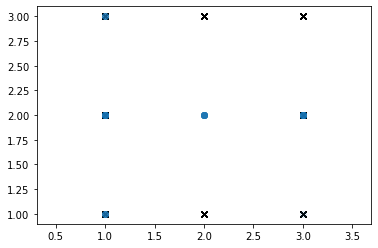

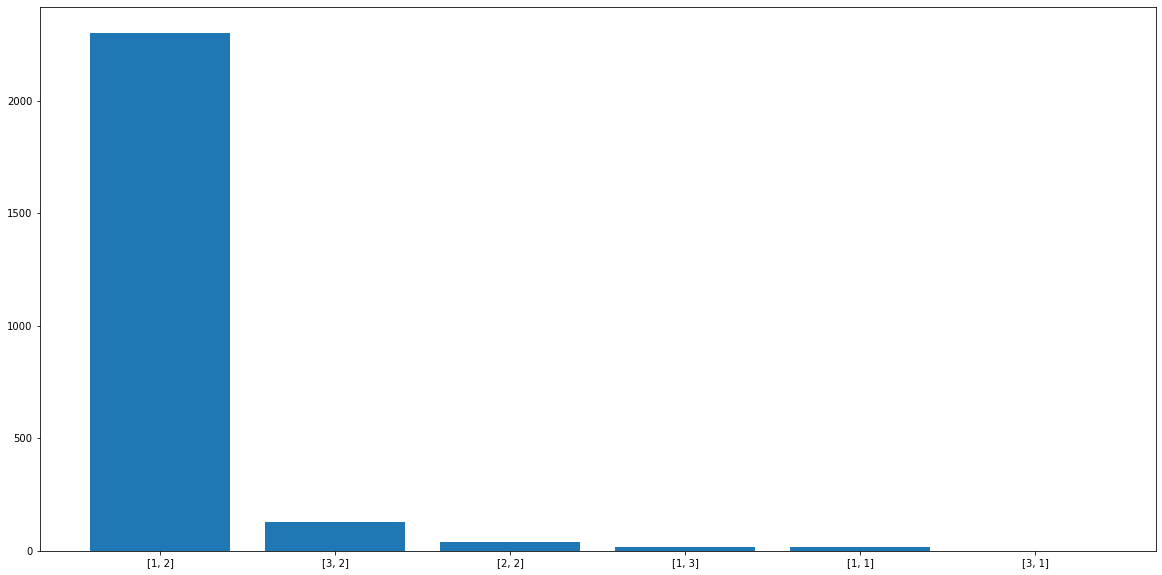

Processing Epoch 157
training start
Iteration 0, d real/fake loss 0.5970675945281982/0.515949547290802 and g loss is 0.9168721437454224, NDiv loss 0.13093945384025574
Iteration 1, d real/fake loss 0.5967124700546265/0.5291182994842529 and g loss is 0.9132910966873169, NDiv loss 0.14637738466262817
Iteration 2, d real/fake loss 0.5963705778121948/0.510802686214447 and g loss is 0.920778214931488, NDiv loss 0.13012444972991943
Iteration 3, d real/fake loss 0.5960303544998169/0.5262233018875122 and g loss is 0.9084023833274841, NDiv loss 0.12891140580177307
Iteration 4, d real/fake loss 0.5957003235816956/0.5349596738815308 and g loss is 0.9031628370285034, NDiv loss 0.12679465115070343


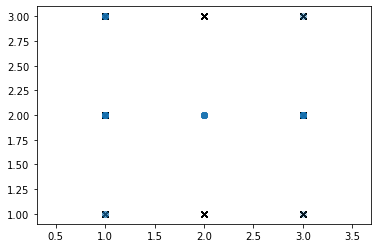

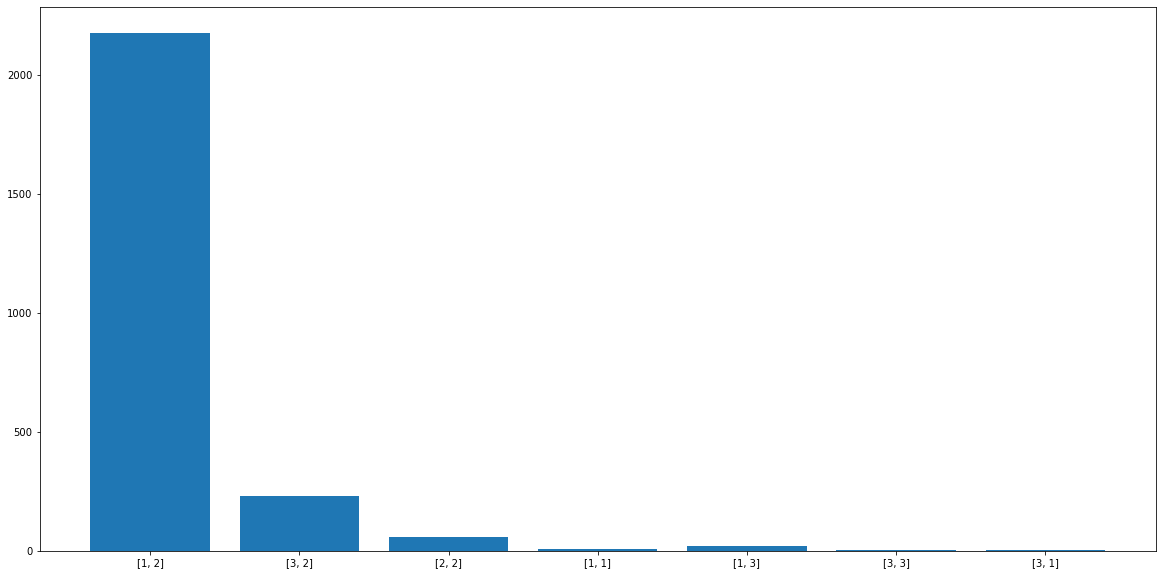

Processing Epoch 158
training start
Iteration 0, d real/fake loss 0.5838757753372192/0.5455745458602905 and g loss is 0.8949888348579407, NDiv loss 0.12181802839040756
Iteration 1, d real/fake loss 0.583493709564209/0.5434672832489014 and g loss is 0.887748122215271, NDiv loss 0.13142840564250946
Iteration 2, d real/fake loss 0.5831314921379089/0.5320253372192383 and g loss is 0.8651631474494934, NDiv loss 0.1366289258003235
Iteration 3, d real/fake loss 0.5827822089195251/0.5622416138648987 and g loss is 0.8993366360664368, NDiv loss 0.12281514704227448
Iteration 4, d real/fake loss 0.5824587345123291/0.5596526861190796 and g loss is 0.8470476865768433, NDiv loss 0.11689191311597824


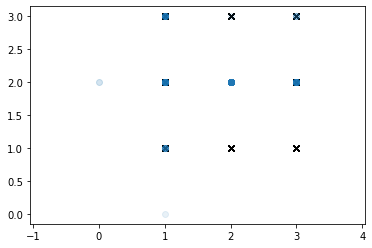

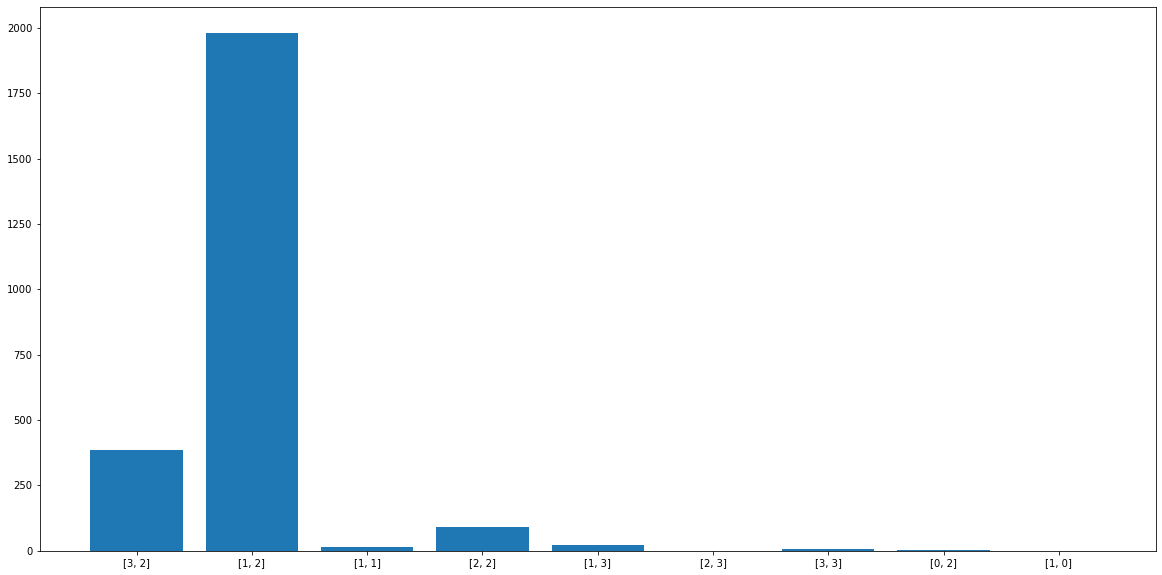

Processing Epoch 159
training start
Iteration 0, d real/fake loss 0.6025128364562988/0.5669144988059998 and g loss is 0.8600353002548218, NDiv loss 0.11397916823625565
Iteration 1, d real/fake loss 0.6022921800613403/0.5677326321601868 and g loss is 0.8690409660339355, NDiv loss 0.11833508312702179
Iteration 2, d real/fake loss 0.6020793914794922/0.5710872411727905 and g loss is 0.8496125936508179, NDiv loss 0.11087681353092194
Iteration 3, d real/fake loss 0.6018755435943604/0.5738271474838257 and g loss is 0.8540886640548706, NDiv loss 0.10429555177688599
Iteration 4, d real/fake loss 0.6016809940338135/0.5783249139785767 and g loss is 0.8315248489379883, NDiv loss 0.10527776181697845


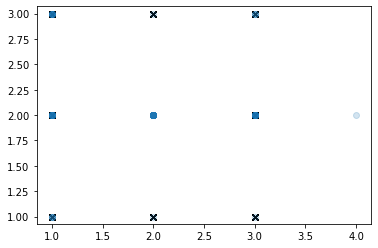

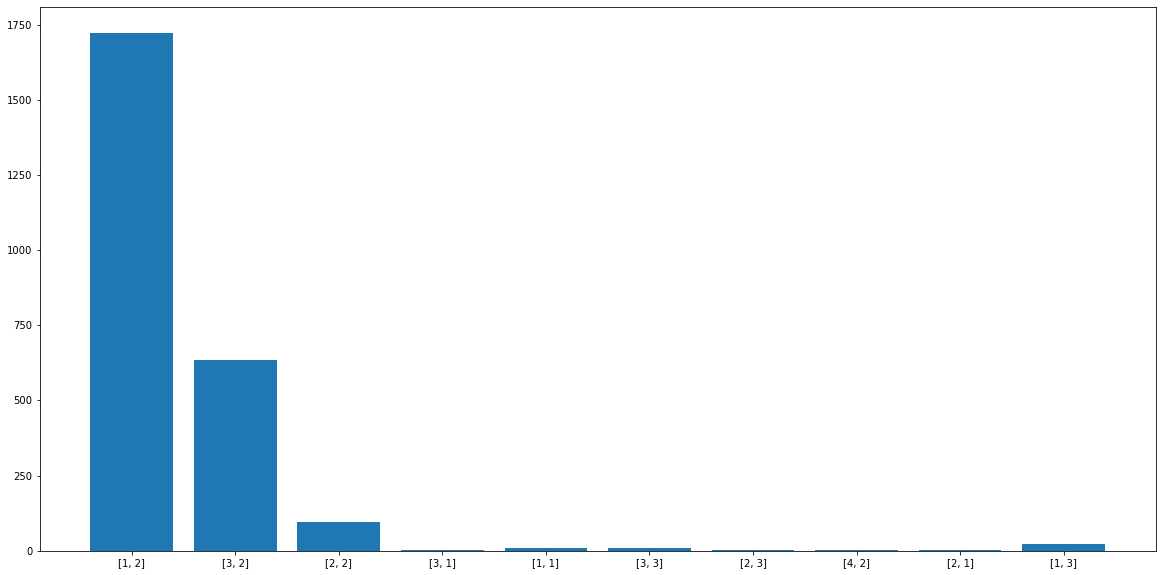

Processing Epoch 160
training start
Iteration 0, d real/fake loss 0.5822182893753052/0.5988906621932983 and g loss is 0.7962533831596375, NDiv loss 0.1047673374414444
Iteration 1, d real/fake loss 0.5819592475891113/0.6033310890197754 and g loss is 0.8111711740493774, NDiv loss 0.09882957488298416
Iteration 2, d real/fake loss 0.5817281007766724/0.5879462361335754 and g loss is 0.8157646656036377, NDiv loss 0.11773031204938889
Iteration 3, d real/fake loss 0.581515908241272/0.6237530708312988 and g loss is 0.796648383140564, NDiv loss 0.0965401753783226
Iteration 4, d real/fake loss 0.5813373327255249/0.6192788481712341 and g loss is 0.7818261384963989, NDiv loss 0.10327842086553574


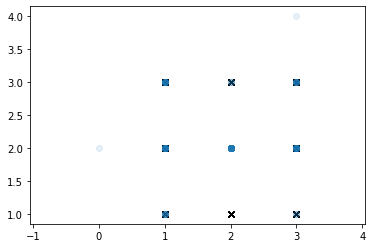

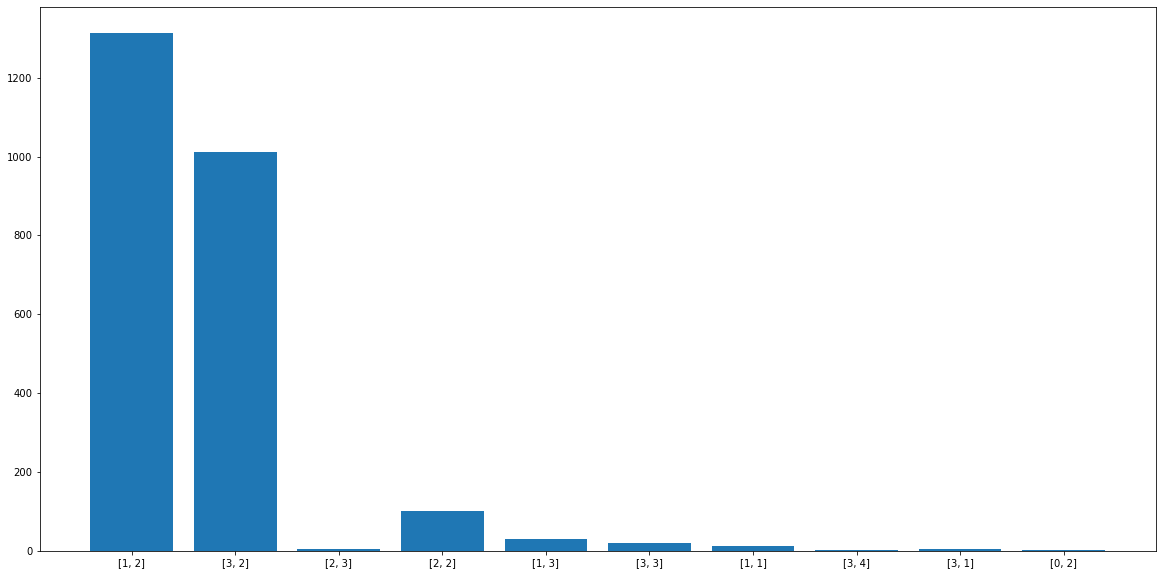

Processing Epoch 161
training start
Iteration 0, d real/fake loss 0.5532381534576416/0.6312345862388611 and g loss is 0.772808849811554, NDiv loss 0.09997807443141937
Iteration 1, d real/fake loss 0.5531225800514221/0.6478941440582275 and g loss is 0.7732722759246826, NDiv loss 0.0984814241528511
Iteration 2, d real/fake loss 0.5530545711517334/0.6640028953552246 and g loss is 0.7689647078514099, NDiv loss 0.0938526839017868
Iteration 3, d real/fake loss 0.5530353784561157/0.6541107296943665 and g loss is 0.7706165909767151, NDiv loss 0.09355457872152328
Iteration 4, d real/fake loss 0.5530553460121155/0.6590331792831421 and g loss is 0.7512640953063965, NDiv loss 0.09546911716461182


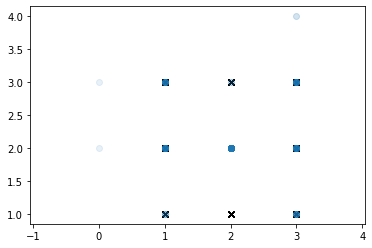

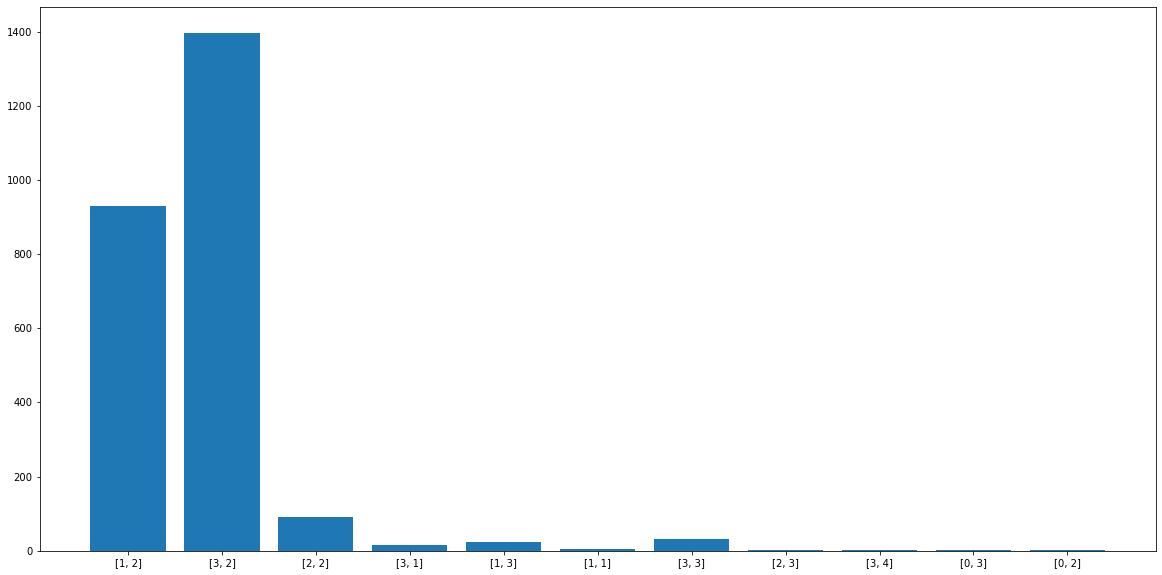

Processing Epoch 162
training start
Iteration 0, d real/fake loss 0.5756224393844604/0.668007493019104 and g loss is 0.7048766613006592, NDiv loss 0.09253422915935516
Iteration 1, d real/fake loss 0.5758646130561829/0.692385196685791 and g loss is 0.724043607711792, NDiv loss 0.09945480525493622
Iteration 2, d real/fake loss 0.5761423110961914/0.6999131441116333 and g loss is 0.7202388644218445, NDiv loss 0.1055687665939331
Iteration 3, d real/fake loss 0.5764557123184204/0.7052847743034363 and g loss is 0.6974935531616211, NDiv loss 0.09907110035419464
Iteration 4, d real/fake loss 0.5768035054206848/0.6888807415962219 and g loss is 0.7016093730926514, NDiv loss 0.09390054643154144


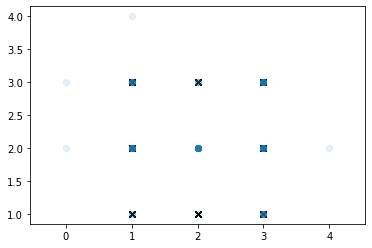

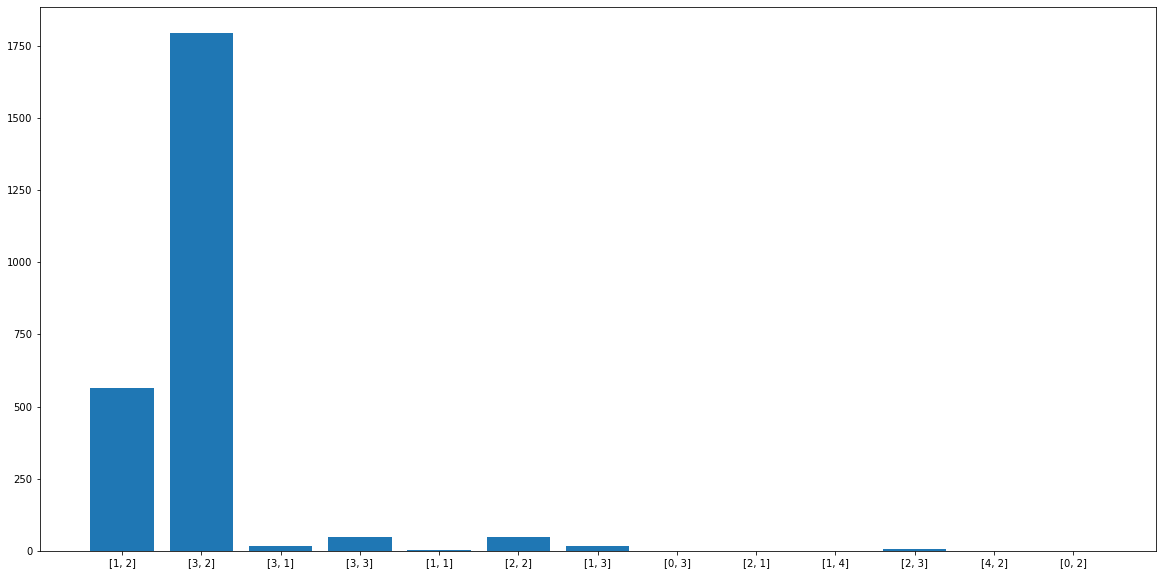

Processing Epoch 163
training start
Iteration 0, d real/fake loss 0.5796477198600769/0.7354739904403687 and g loss is 0.6975483894348145, NDiv loss 0.10447309911251068
Iteration 1, d real/fake loss 0.5799620151519775/0.7383078932762146 and g loss is 0.6745411157608032, NDiv loss 0.09120576828718185
Iteration 2, d real/fake loss 0.5803128480911255/0.732539176940918 and g loss is 0.6796494126319885, NDiv loss 0.11024613678455353
Iteration 3, d real/fake loss 0.5806940793991089/0.755906879901886 and g loss is 0.6673845648765564, NDiv loss 0.10094422847032547
Iteration 4, d real/fake loss 0.581110954284668/0.7541846036911011 and g loss is 0.6531358957290649, NDiv loss 0.11826018989086151


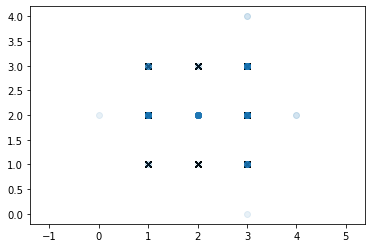

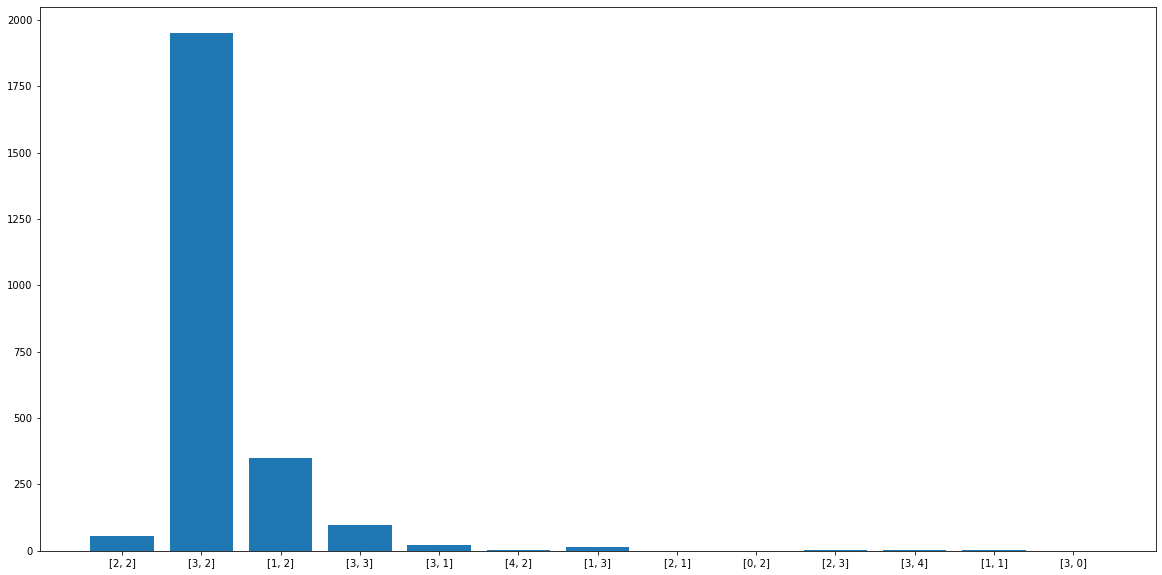

Processing Epoch 164
training start
Iteration 0, d real/fake loss 0.5806214809417725/0.7781904935836792 and g loss is 0.6560876965522766, NDiv loss 0.106269471347332
Iteration 1, d real/fake loss 0.58095782995224/0.7720376253128052 and g loss is 0.6383473873138428, NDiv loss 0.10599011182785034
Iteration 2, d real/fake loss 0.5813137292861938/0.7606101036071777 and g loss is 0.6653450727462769, NDiv loss 0.11311395466327667
Iteration 3, d real/fake loss 0.5816838145256042/0.7758153676986694 and g loss is 0.6537127494812012, NDiv loss 0.10772811621427536
Iteration 4, d real/fake loss 0.5820724964141846/0.7762932777404785 and g loss is 0.6203289031982422, NDiv loss 0.11420644819736481


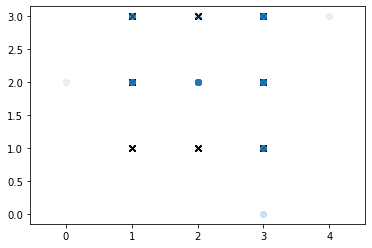

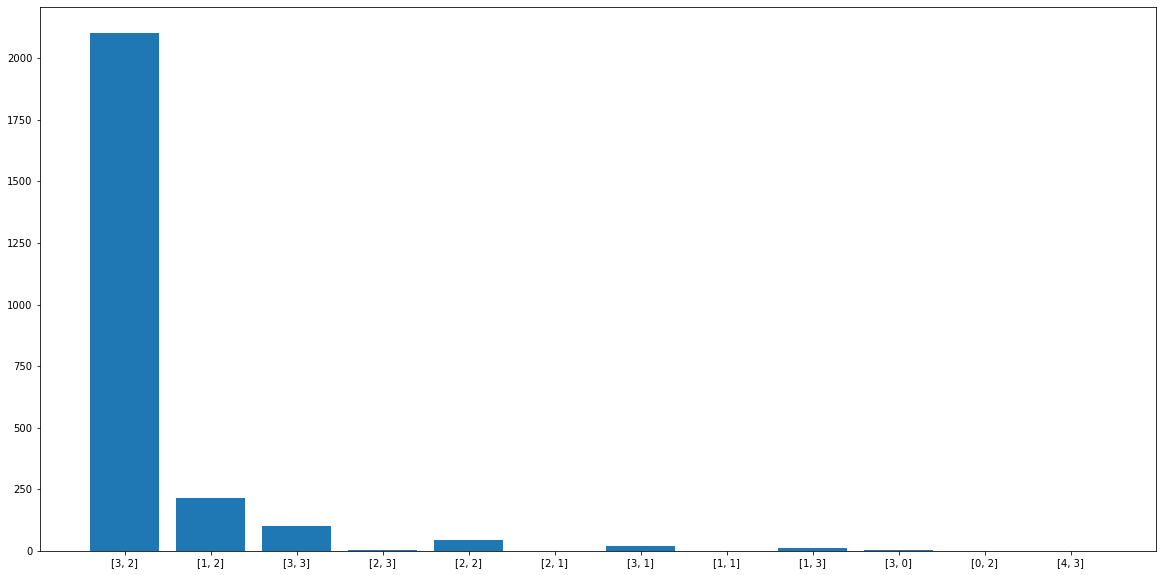

Processing Epoch 165
training start
Iteration 0, d real/fake loss 0.5940937995910645/0.7866783738136292 and g loss is 0.6311333775520325, NDiv loss 0.11638928204774857
Iteration 1, d real/fake loss 0.5947544574737549/0.7833894491195679 and g loss is 0.6369975209236145, NDiv loss 0.11775650829076767
Iteration 2, d real/fake loss 0.5954328775405884/0.7832008600234985 and g loss is 0.6183777451515198, NDiv loss 0.10930067300796509
Iteration 3, d real/fake loss 0.5961241722106934/0.7946469783782959 and g loss is 0.6178559064865112, NDiv loss 0.11748269945383072
Iteration 4, d real/fake loss 0.5968316197395325/0.8013990521430969 and g loss is 0.6241500377655029, NDiv loss 0.11870898306369781


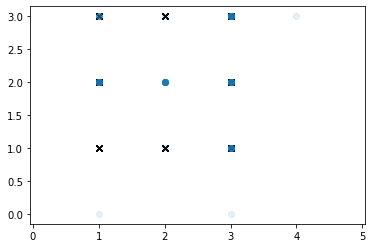

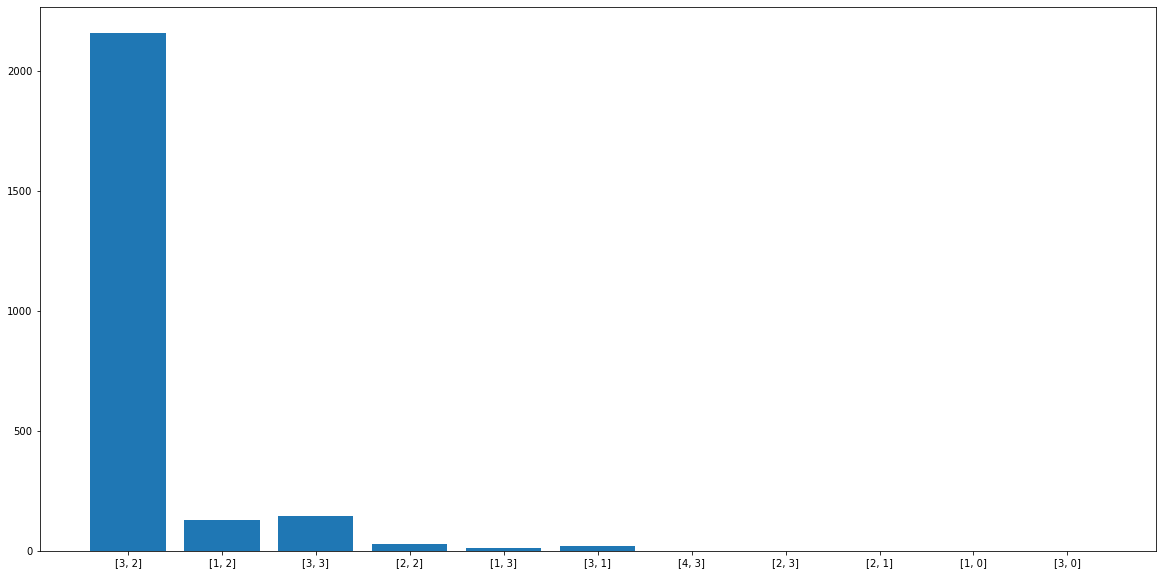

Processing Epoch 166
training start
Iteration 0, d real/fake loss 0.6189864873886108/0.7984208464622498 and g loss is 0.6071100234985352, NDiv loss 0.10741287469863892
Iteration 1, d real/fake loss 0.6195307374000549/0.7953512668609619 and g loss is 0.6014672517776489, NDiv loss 0.11530690640211105
Iteration 2, d real/fake loss 0.6200717687606812/0.8071713447570801 and g loss is 0.607511579990387, NDiv loss 0.11491581052541733
Iteration 3, d real/fake loss 0.6206128597259521/0.7938216924667358 and g loss is 0.6064186096191406, NDiv loss 0.1182449609041214
Iteration 4, d real/fake loss 0.6211487054824829/0.8015825748443604 and g loss is 0.6094474792480469, NDiv loss 0.11142846196889877


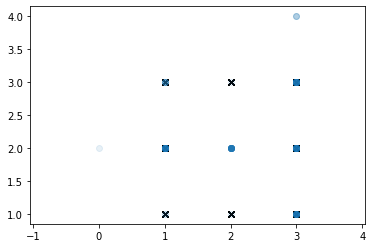

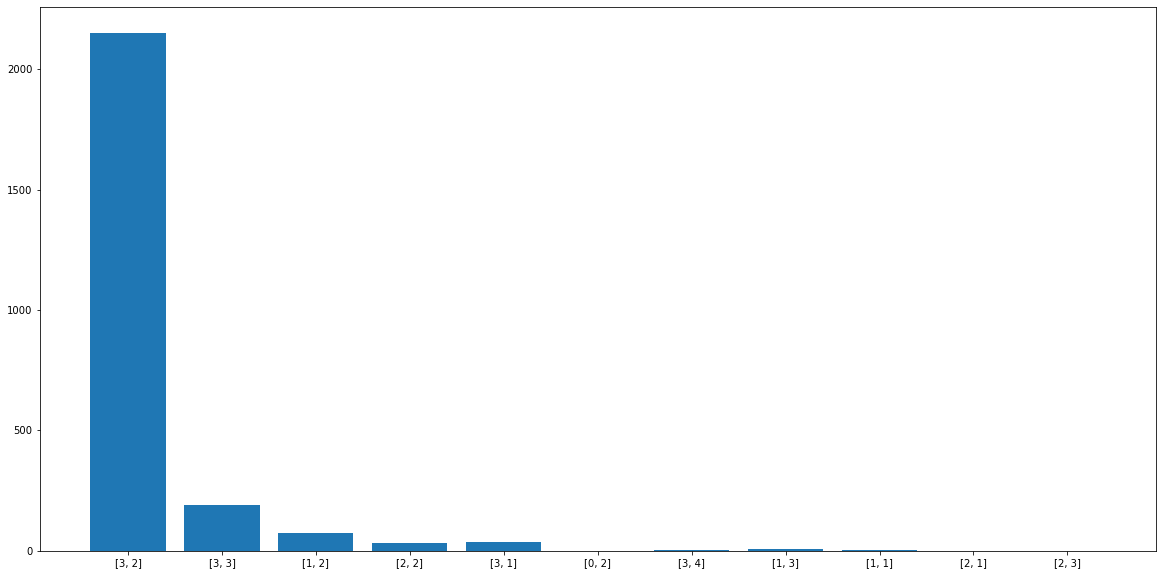

Processing Epoch 167
training start
Iteration 0, d real/fake loss 0.6316754817962646/0.7983345985412598 and g loss is 0.6046634912490845, NDiv loss 0.12131407856941223
Iteration 1, d real/fake loss 0.6322715282440186/0.8003531694412231 and g loss is 0.6098157167434692, NDiv loss 0.12837903201580048
Iteration 2, d real/fake loss 0.6328465938568115/0.807324230670929 and g loss is 0.6092302799224854, NDiv loss 0.11295133829116821
Iteration 3, d real/fake loss 0.6334031820297241/0.8072815537452698 and g loss is 0.5916013717651367, NDiv loss 0.11655977368354797
Iteration 4, d real/fake loss 0.6339428424835205/0.8112460374832153 and g loss is 0.5921806693077087, NDiv loss 0.12729696929454803


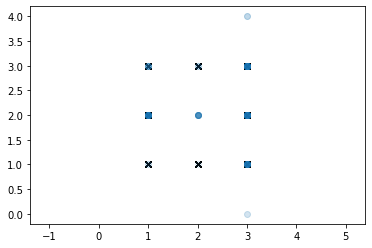

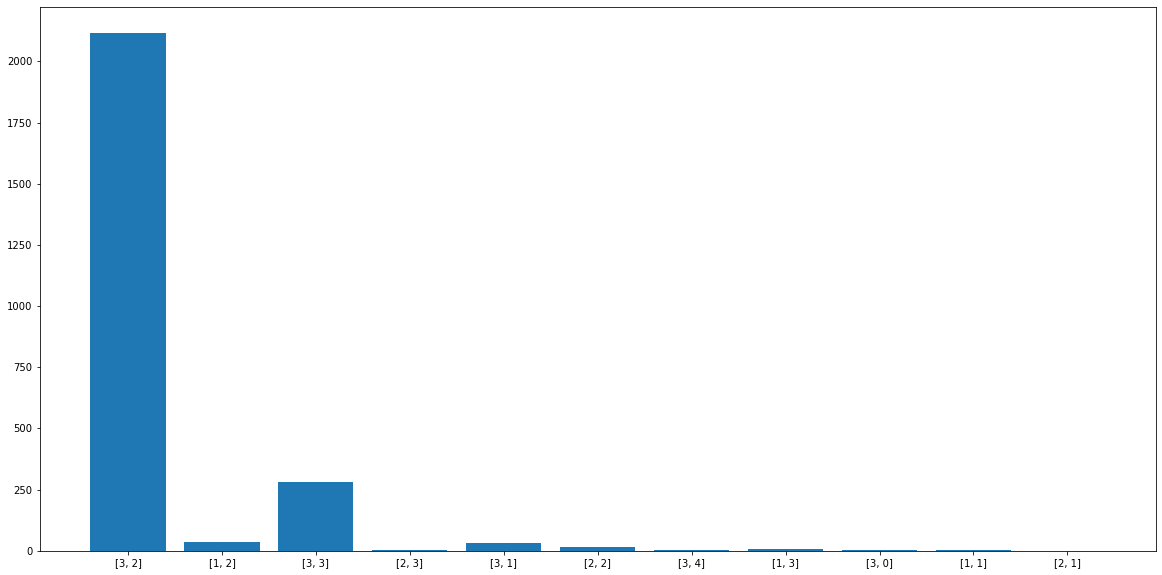

Processing Epoch 168
training start
Iteration 0, d real/fake loss 0.6081274151802063/0.8004143834114075 and g loss is 0.6051164865493774, NDiv loss 0.1362239271402359
Iteration 1, d real/fake loss 0.6086951494216919/0.8060325384140015 and g loss is 0.5938354730606079, NDiv loss 0.1319292038679123
Iteration 2, d real/fake loss 0.6092726588249207/0.8112373352050781 and g loss is 0.5986372828483582, NDiv loss 0.1202724277973175
Iteration 3, d real/fake loss 0.609859049320221/0.8135102987289429 and g loss is 0.6027514934539795, NDiv loss 0.1127108782529831
Iteration 4, d real/fake loss 0.6104543209075928/0.8121753931045532 and g loss is 0.5859194993972778, NDiv loss 0.1258322149515152


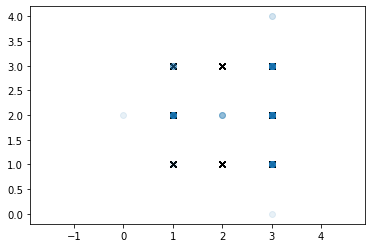

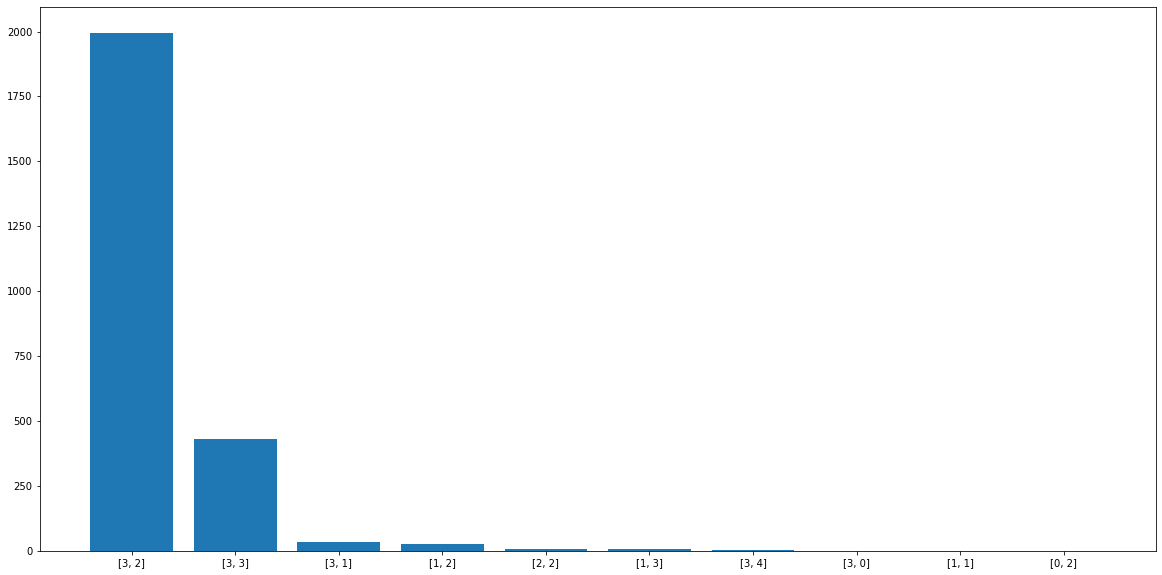

Processing Epoch 169
training start
Iteration 0, d real/fake loss 0.6004211902618408/0.8065122365951538 and g loss is 0.5909289121627808, NDiv loss 0.126225084066391
Iteration 1, d real/fake loss 0.6010661125183105/0.8020154237747192 and g loss is 0.5947186350822449, NDiv loss 0.12844204902648926
Iteration 2, d real/fake loss 0.601714551448822/0.8220260739326477 and g loss is 0.5916935801506042, NDiv loss 0.12123886495828629
Iteration 3, d real/fake loss 0.6023707389831543/0.8209292888641357 and g loss is 0.5939957499504089, NDiv loss 0.13339287042617798
Iteration 4, d real/fake loss 0.6030348539352417/0.8203822374343872 and g loss is 0.5791003704071045, NDiv loss 0.11772678792476654


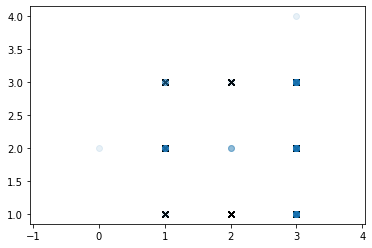

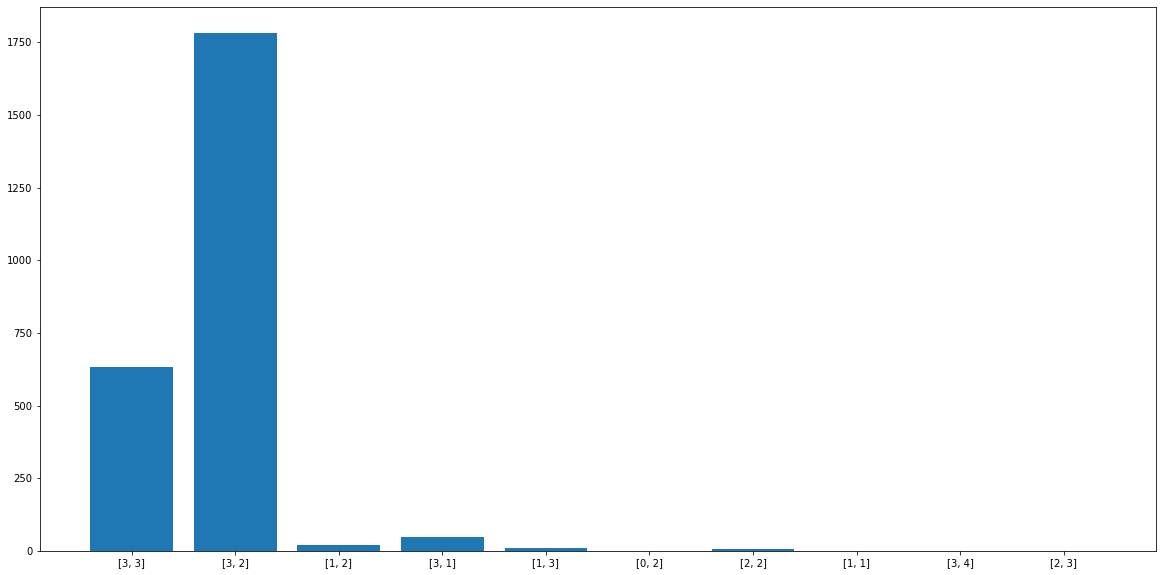

Processing Epoch 170
training start
Iteration 0, d real/fake loss 0.6226279139518738/0.8286341428756714 and g loss is 0.5867824554443359, NDiv loss 0.13185471296310425
Iteration 1, d real/fake loss 0.623324990272522/0.8172800540924072 and g loss is 0.5796211957931519, NDiv loss 0.11582660675048828
Iteration 2, d real/fake loss 0.6240196228027344/0.8242972493171692 and g loss is 0.5791948437690735, NDiv loss 0.11408227682113647
Iteration 3, d real/fake loss 0.6247113347053528/0.8437248468399048 and g loss is 0.5710893273353577, NDiv loss 0.11885731667280197
Iteration 4, d real/fake loss 0.625408411026001/0.832973837852478 and g loss is 0.5843603610992432, NDiv loss 0.11332531273365021


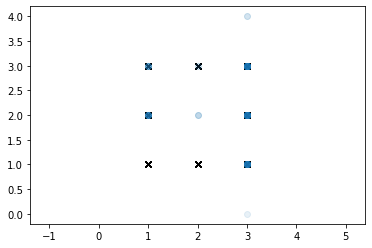

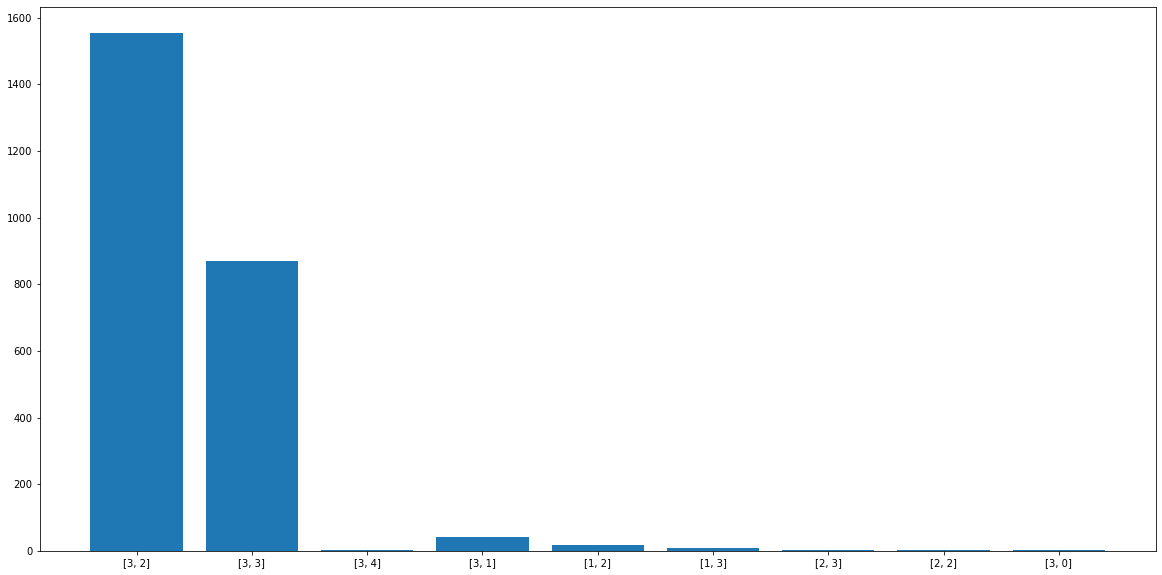

Processing Epoch 171
training start
Iteration 0, d real/fake loss 0.5974300503730774/0.8362789154052734 and g loss is 0.5698117017745972, NDiv loss 0.1062169075012207
Iteration 1, d real/fake loss 0.598116397857666/0.8383896350860596 and g loss is 0.5700194835662842, NDiv loss 0.1183588057756424
Iteration 2, d real/fake loss 0.5988126993179321/0.8496395349502563 and g loss is 0.5729743242263794, NDiv loss 0.11406095325946808
Iteration 3, d real/fake loss 0.5995190143585205/0.8487287163734436 and g loss is 0.5705878734588623, NDiv loss 0.12110945582389832
Iteration 4, d real/fake loss 0.6002346873283386/0.841230034828186 and g loss is 0.573388934135437, NDiv loss 0.11319087445735931


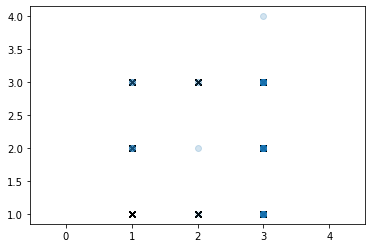

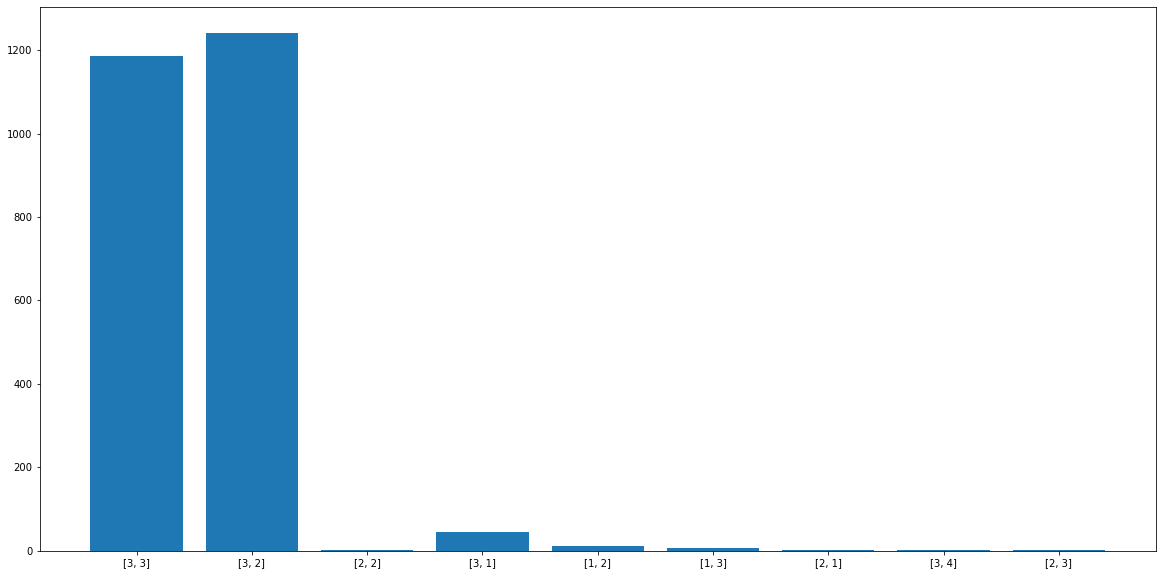

Processing Epoch 172
training start
Iteration 0, d real/fake loss 0.6268880367279053/0.8438757658004761 and g loss is 0.5713258981704712, NDiv loss 0.1258557140827179
Iteration 1, d real/fake loss 0.6276748180389404/0.8544496297836304 and g loss is 0.5591131448745728, NDiv loss 0.11739370226860046
Iteration 2, d real/fake loss 0.628456711769104/0.867786169052124 and g loss is 0.563546895980835, NDiv loss 0.11373626440763474
Iteration 3, d real/fake loss 0.6292368769645691/0.8810114860534668 and g loss is 0.5515477657318115, NDiv loss 0.12041576951742172
Iteration 4, d real/fake loss 0.6300170421600342/0.8681497573852539 and g loss is 0.556001603603363, NDiv loss 0.11829470843076706


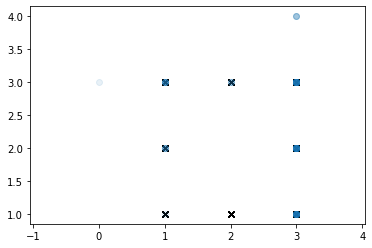

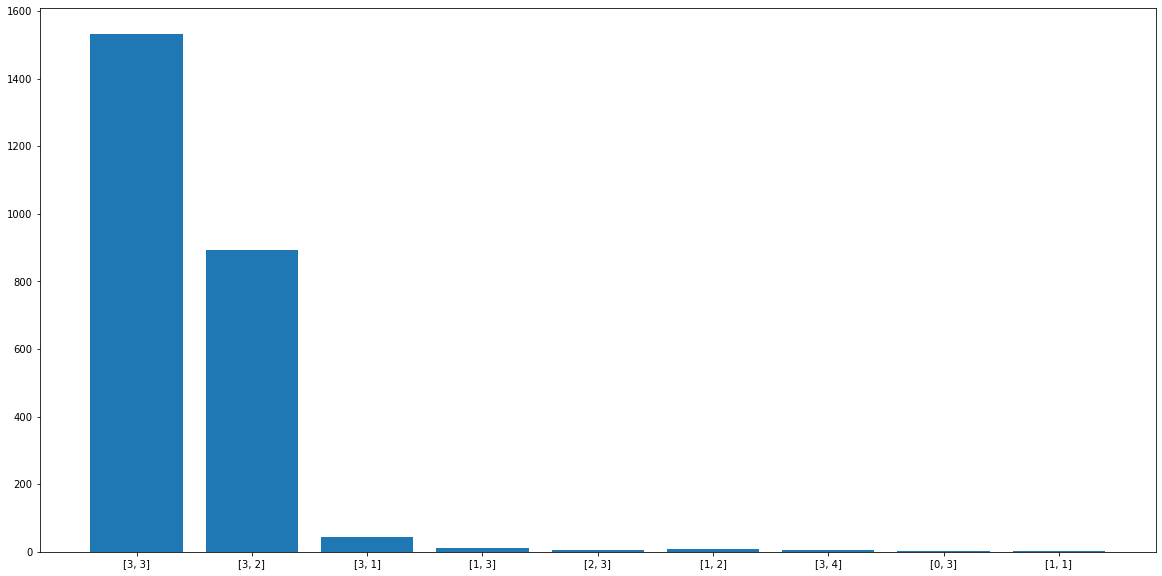

Processing Epoch 173
training start
Iteration 0, d real/fake loss 0.6279011964797974/0.8699886202812195 and g loss is 0.5492003560066223, NDiv loss 0.11104868352413177
Iteration 1, d real/fake loss 0.6284334659576416/0.8692253828048706 and g loss is 0.5469085574150085, NDiv loss 0.12262896448373795
Iteration 2, d real/fake loss 0.6289506554603577/0.8760393857955933 and g loss is 0.5526098608970642, NDiv loss 0.1256735920906067
Iteration 3, d real/fake loss 0.6294534206390381/0.8654186725616455 and g loss is 0.5424853563308716, NDiv loss 0.1286638379096985
Iteration 4, d real/fake loss 0.6299430131912231/0.8878750801086426 and g loss is 0.5400704145431519, NDiv loss 0.1253623366355896


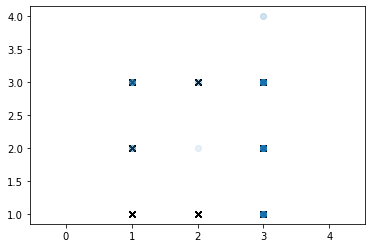

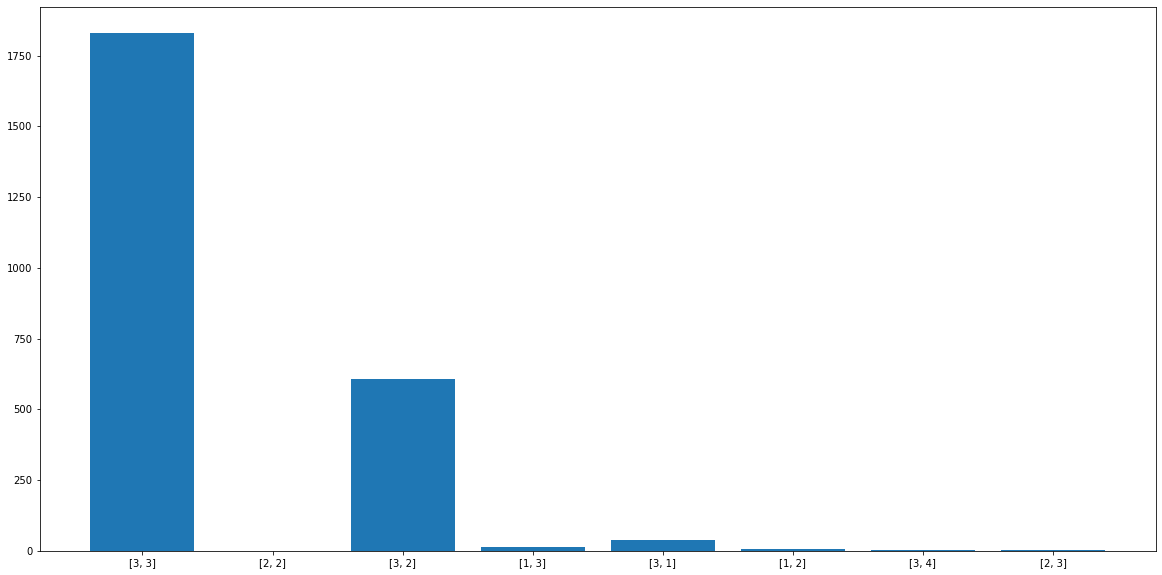

Processing Epoch 174
training start
Iteration 0, d real/fake loss 0.6220026016235352/0.8920574188232422 and g loss is 0.536453366279602, NDiv loss 0.13071389496326447
Iteration 1, d real/fake loss 0.6227959394454956/0.9006304740905762 and g loss is 0.5366296768188477, NDiv loss 0.1281486600637436
Iteration 2, d real/fake loss 0.6235960125923157/0.89305579662323 and g loss is 0.5442091226577759, NDiv loss 0.13743416965007782
Iteration 3, d real/fake loss 0.6244008541107178/0.8981584310531616 and g loss is 0.5337772965431213, NDiv loss 0.1336287558078766
Iteration 4, d real/fake loss 0.6252087354660034/0.8887979984283447 and g loss is 0.53214430809021, NDiv loss 0.14344200491905212


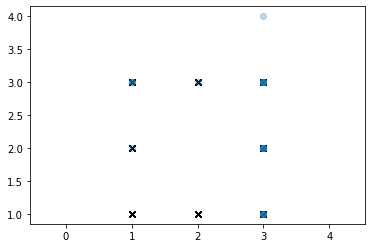

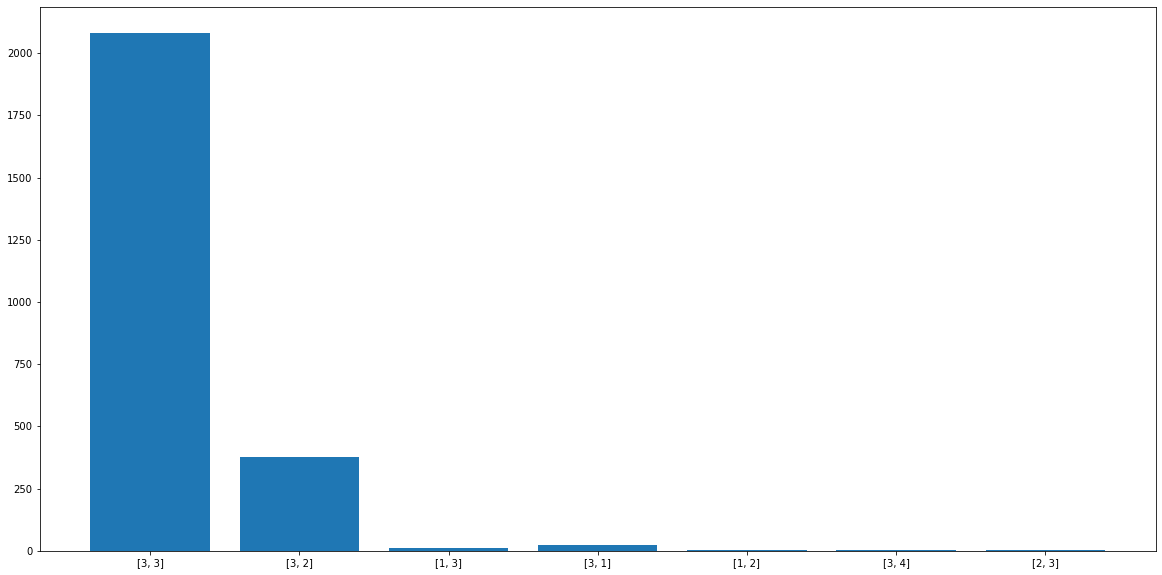

Processing Epoch 175
training start
Iteration 0, d real/fake loss 0.6121253967285156/0.8930401802062988 and g loss is 0.5192301273345947, NDiv loss 0.15061090886592865
Iteration 1, d real/fake loss 0.6128029823303223/0.9139865636825562 and g loss is 0.5275146961212158, NDiv loss 0.1452500969171524
Iteration 2, d real/fake loss 0.6134814023971558/0.8989149332046509 and g loss is 0.5259560346603394, NDiv loss 0.15856067836284637
Iteration 3, d real/fake loss 0.6141569018363953/0.914344310760498 and g loss is 0.5238600969314575, NDiv loss 0.1503380984067917
Iteration 4, d real/fake loss 0.6148320436477661/0.903775691986084 and g loss is 0.5318742990493774, NDiv loss 0.15893472731113434


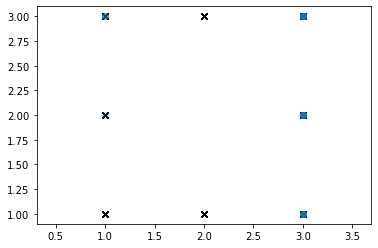

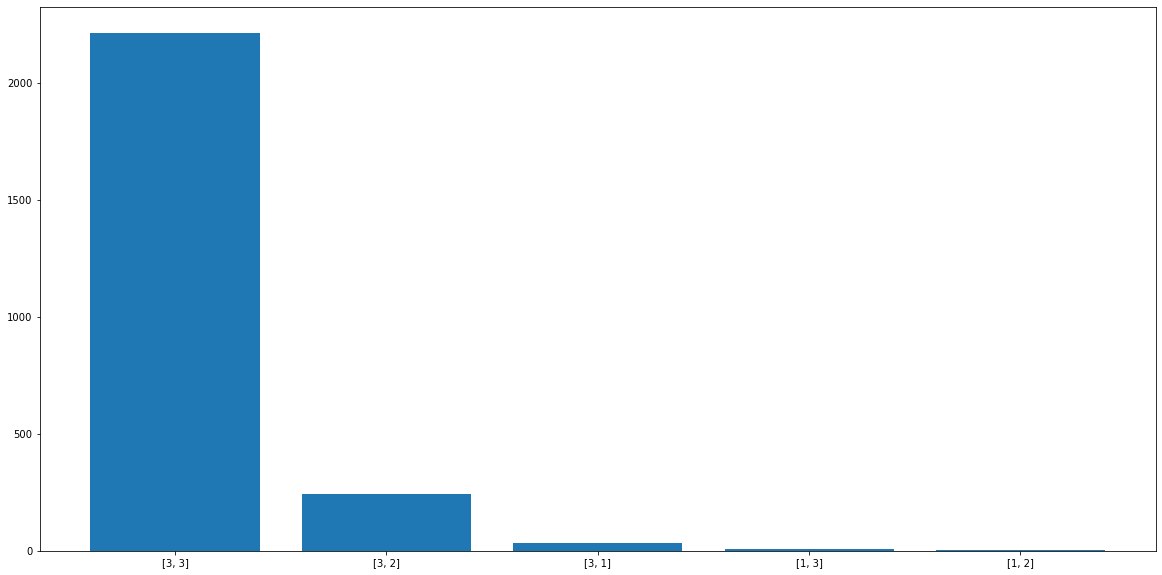

Processing Epoch 176
training start
Iteration 0, d real/fake loss 0.6508926153182983/0.9030617475509644 and g loss is 0.5332475900650024, NDiv loss 0.14890983700752258
Iteration 1, d real/fake loss 0.65175461769104/0.9093121290206909 and g loss is 0.5155802965164185, NDiv loss 0.15181657671928406
Iteration 2, d real/fake loss 0.6526060700416565/0.9085357785224915 and g loss is 0.526567816734314, NDiv loss 0.16320692002773285
Iteration 3, d real/fake loss 0.6534473299980164/0.9034945368766785 and g loss is 0.5209351778030396, NDiv loss 0.1596301645040512
Iteration 4, d real/fake loss 0.6542766690254211/0.9060362577438354 and g loss is 0.5122604370117188, NDiv loss 0.16858433187007904


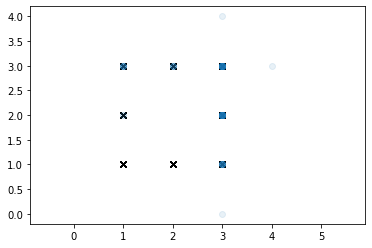

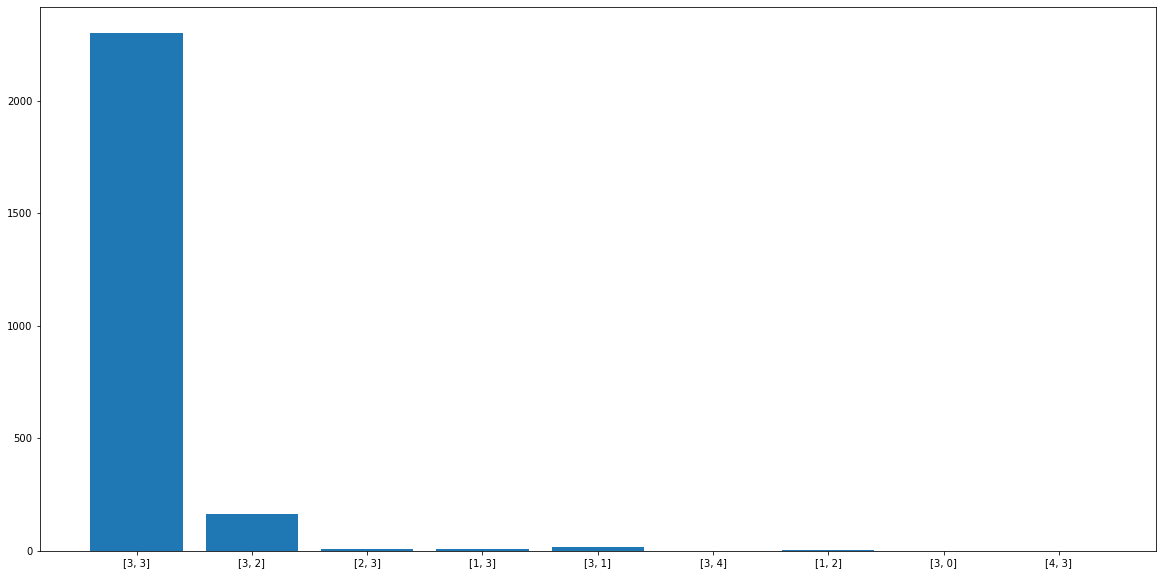

Processing Epoch 177
training start
Iteration 0, d real/fake loss 0.6175782680511475/0.8972333073616028 and g loss is 0.5181725025177002, NDiv loss 0.1436050534248352
Iteration 1, d real/fake loss 0.618263840675354/0.9104878306388855 and g loss is 0.5173454284667969, NDiv loss 0.15920765697956085
Iteration 2, d real/fake loss 0.6189500093460083/0.9106177687644958 and g loss is 0.5181993246078491, NDiv loss 0.16148625314235687
Iteration 3, d real/fake loss 0.619635820388794/0.9054164886474609 and g loss is 0.52029949426651, NDiv loss 0.1965741217136383
Iteration 4, d real/fake loss 0.6203182339668274/0.9009354114532471 and g loss is 0.5218624472618103, NDiv loss 0.16553963720798492


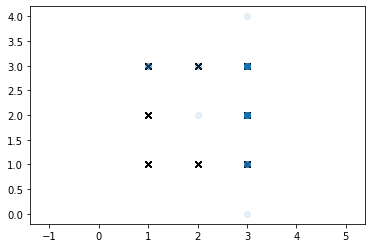

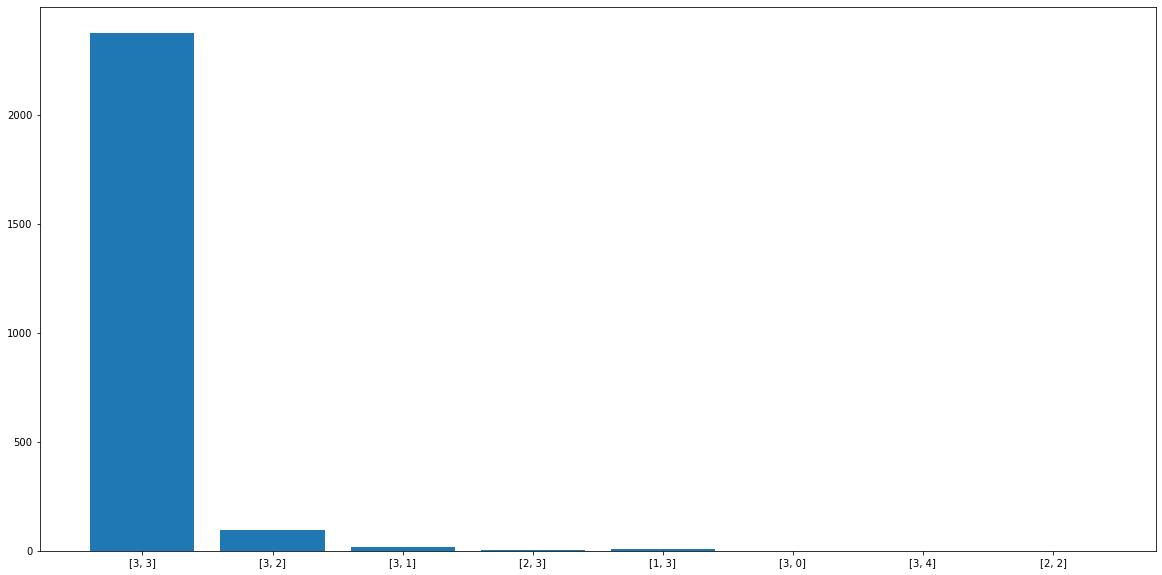

Processing Epoch 178
training start
Iteration 0, d real/fake loss 0.6543890833854675/0.9050043821334839 and g loss is 0.5225613713264465, NDiv loss 0.15891683101654053
Iteration 1, d real/fake loss 0.6550015807151794/0.9043521881103516 and g loss is 0.5265347957611084, NDiv loss 0.17404350638389587
Iteration 2, d real/fake loss 0.6555969715118408/0.8944879770278931 and g loss is 0.5322173833847046, NDiv loss 0.1676410436630249
Iteration 3, d real/fake loss 0.656174898147583/0.8939084410667419 and g loss is 0.5284449458122253, NDiv loss 0.16537991166114807
Iteration 4, d real/fake loss 0.6567355394363403/0.8928037285804749 and g loss is 0.533214807510376, NDiv loss 0.17713762819766998


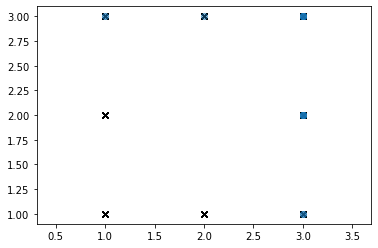

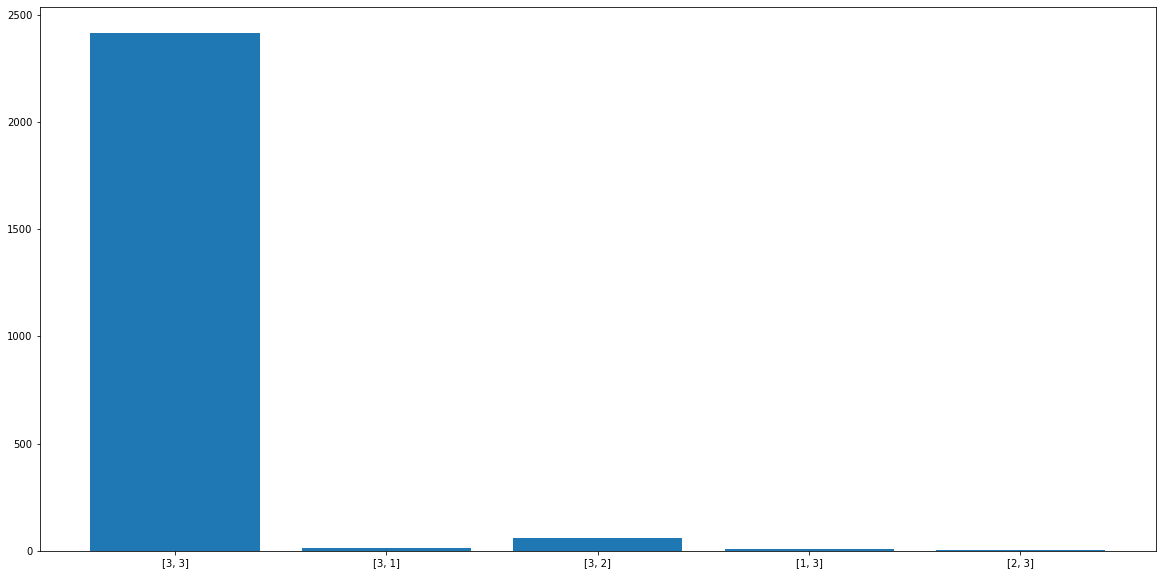

Processing Epoch 179
training start
Iteration 0, d real/fake loss 0.6537110805511475/0.8875793218612671 and g loss is 0.5284570455551147, NDiv loss 0.15287883579730988
Iteration 1, d real/fake loss 0.654262363910675/0.8969467878341675 and g loss is 0.5326608419418335, NDiv loss 0.20246204733848572
Iteration 2, d real/fake loss 0.6547974944114685/0.8927531242370605 and g loss is 0.5335140824317932, NDiv loss 0.21570122241973877
Iteration 3, d real/fake loss 0.655316948890686/0.8907477855682373 and g loss is 0.5333075523376465, NDiv loss 0.18889471888542175
Iteration 4, d real/fake loss 0.6558209657669067/0.8835918307304382 and g loss is 0.533246636390686, NDiv loss 0.16964960098266602


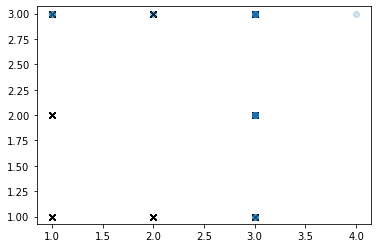

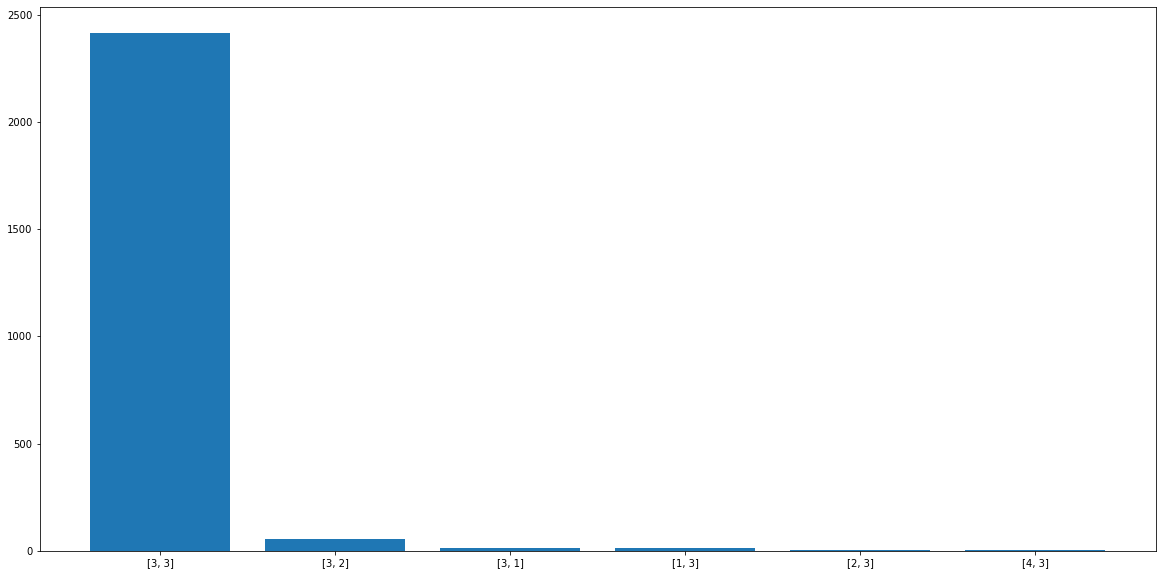

Processing Epoch 180
training start
Iteration 0, d real/fake loss 0.6177833080291748/0.8806072473526001 and g loss is 0.5388296842575073, NDiv loss 0.19523370265960693
Iteration 1, d real/fake loss 0.6182751655578613/0.8810498118400574 and g loss is 0.5410593748092651, NDiv loss 0.16814914345741272
Iteration 2, d real/fake loss 0.6187647581100464/0.876144528388977 and g loss is 0.541419506072998, NDiv loss 0.20218496024608612
Iteration 3, d real/fake loss 0.6192504167556763/0.8704562783241272 and g loss is 0.5414681434631348, NDiv loss 0.20638233423233032
Iteration 4, d real/fake loss 0.6197304129600525/0.8694145679473877 and g loss is 0.5498992204666138, NDiv loss 0.20626279711723328


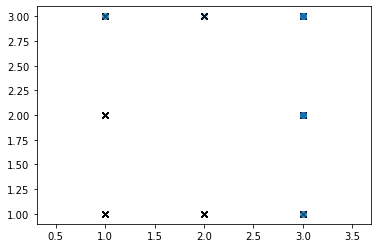

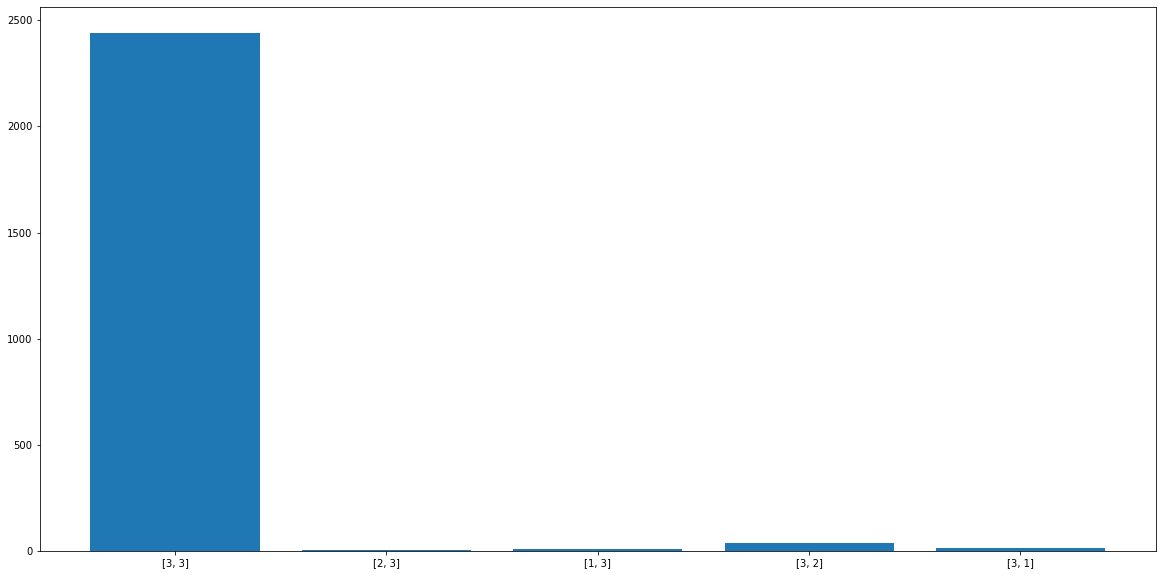

Processing Epoch 181
training start
Iteration 0, d real/fake loss 0.6159455180168152/0.8726479411125183 and g loss is 0.5470774173736572, NDiv loss 0.21177665889263153
Iteration 1, d real/fake loss 0.6164682507514954/0.8656972646713257 and g loss is 0.5523958206176758, NDiv loss 0.18352428078651428
Iteration 2, d real/fake loss 0.6169795989990234/0.8694378733634949 and g loss is 0.5448946952819824, NDiv loss 0.16673263907432556
Iteration 3, d real/fake loss 0.6174801588058472/0.8643505573272705 and g loss is 0.5497723817825317, NDiv loss 0.1808774173259735
Iteration 4, d real/fake loss 0.6179699897766113/0.8601500391960144 and g loss is 0.5521891713142395, NDiv loss 0.21196265518665314


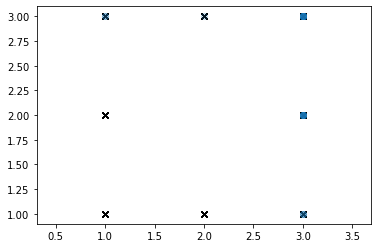

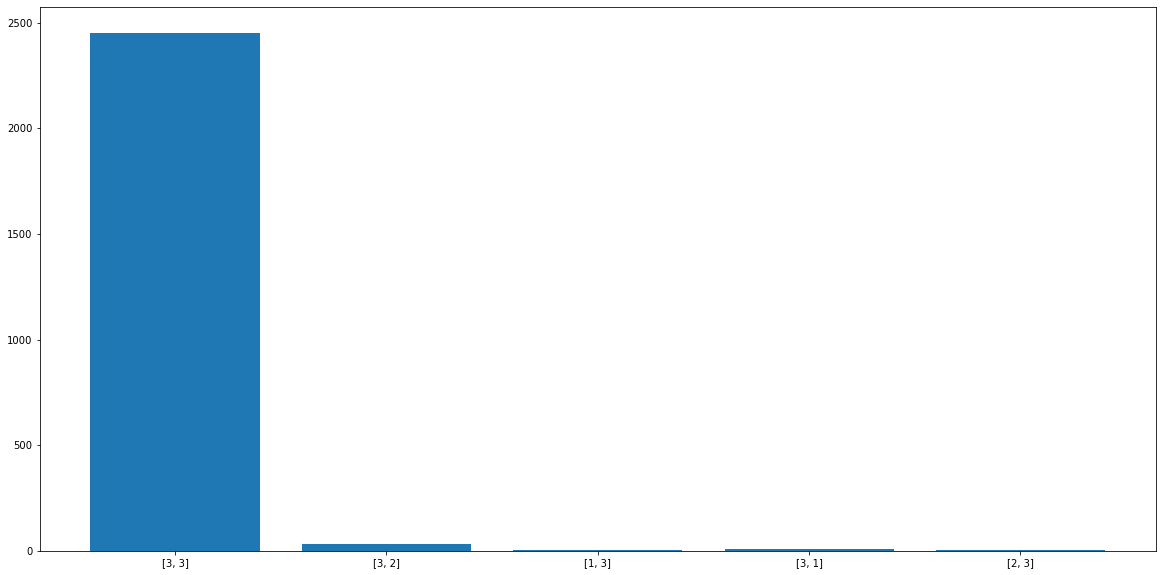

Processing Epoch 182
training start
Iteration 0, d real/fake loss 0.6665817499160767/0.8608658313751221 and g loss is 0.5547589063644409, NDiv loss 0.18239827454090118
Iteration 1, d real/fake loss 0.6670100688934326/0.8531526923179626 and g loss is 0.5555956363677979, NDiv loss 0.2103865146636963
Iteration 2, d real/fake loss 0.6674160957336426/0.8479526042938232 and g loss is 0.5578553676605225, NDiv loss 0.24290846288204193
Iteration 3, d real/fake loss 0.6677991151809692/0.8474017977714539 and g loss is 0.5624168515205383, NDiv loss 0.2275875359773636
Iteration 4, d real/fake loss 0.6681616902351379/0.8404068946838379 and g loss is 0.5632625818252563, NDiv loss 0.24218545854091644


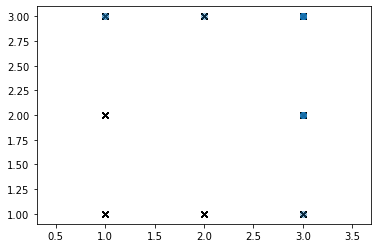

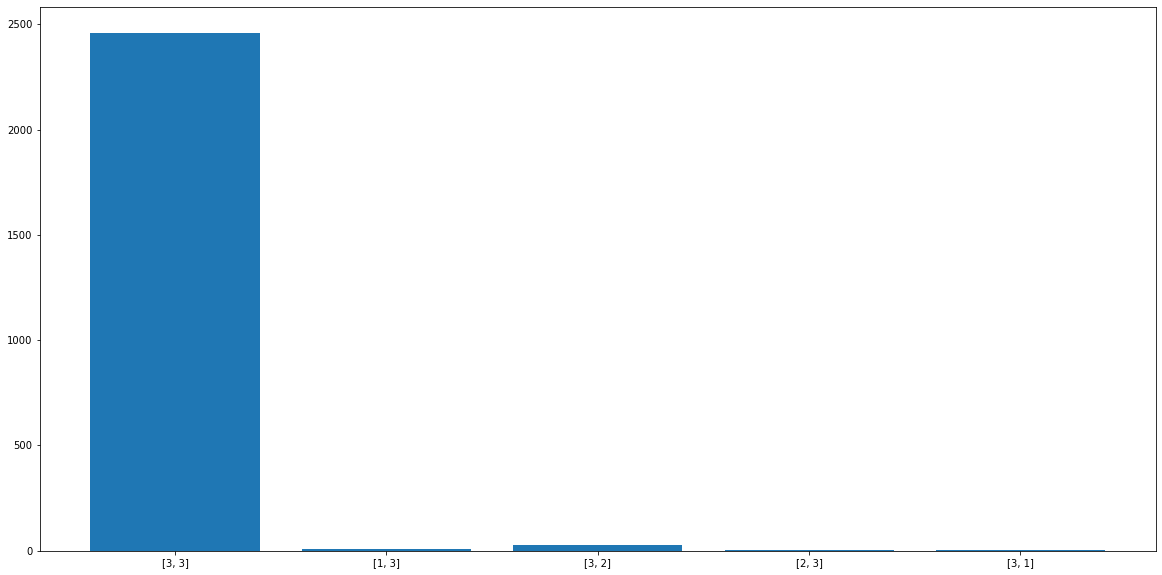

Processing Epoch 183
training start
Iteration 0, d real/fake loss 0.6713041067123413/0.8456408381462097 and g loss is 0.5649210214614868, NDiv loss 0.2176252007484436
Iteration 1, d real/fake loss 0.6715821027755737/0.8379241228103638 and g loss is 0.563650369644165, NDiv loss 0.22678110003471375
Iteration 2, d real/fake loss 0.6718372106552124/0.8423430919647217 and g loss is 0.5719971656799316, NDiv loss 0.21216261386871338
Iteration 3, d real/fake loss 0.6720718741416931/0.8347262144088745 and g loss is 0.5717028975486755, NDiv loss 0.18896746635437012
Iteration 4, d real/fake loss 0.6722873449325562/0.8315454721450806 and g loss is 0.5704777836799622, NDiv loss 0.2431194931268692


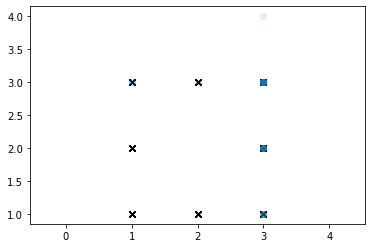

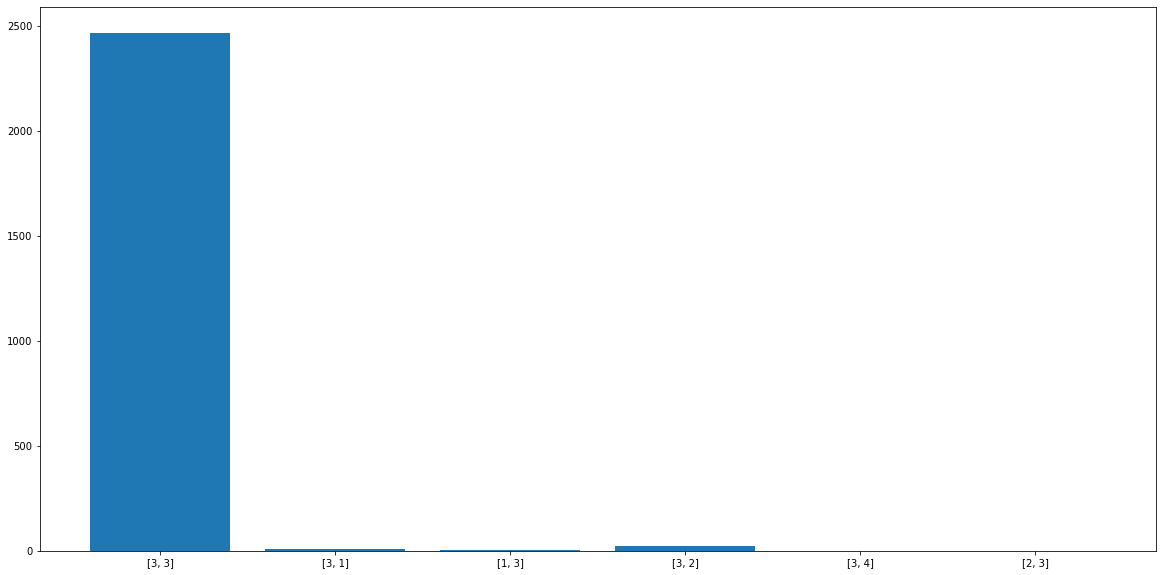

Processing Epoch 184
training start
Iteration 0, d real/fake loss 0.6641134023666382/0.8309555053710938 and g loss is 0.5756104588508606, NDiv loss 0.23425085842609406
Iteration 1, d real/fake loss 0.6643267869949341/0.8275356292724609 and g loss is 0.5786217451095581, NDiv loss 0.20076744258403778
Iteration 2, d real/fake loss 0.6645287871360779/0.8256352543830872 and g loss is 0.5809541940689087, NDiv loss 0.2028057873249054
Iteration 3, d real/fake loss 0.6647191643714905/0.8246213793754578 and g loss is 0.5795267224311829, NDiv loss 0.2117975354194641
Iteration 4, d real/fake loss 0.6648999452590942/0.8172707557678223 and g loss is 0.5841232538223267, NDiv loss 0.2179296463727951


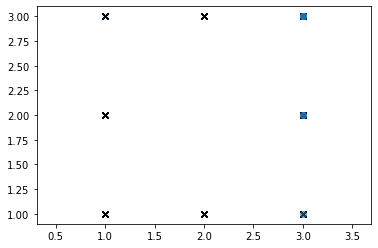

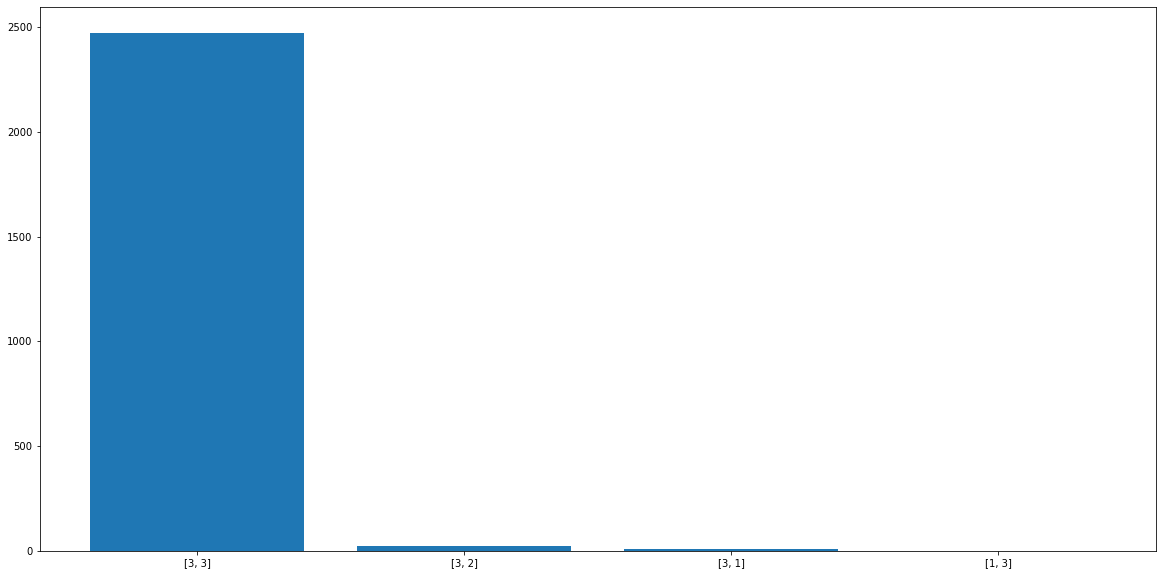

Processing Epoch 185
training start
Iteration 0, d real/fake loss 0.6791239976882935/0.8176833987236023 and g loss is 0.5863500833511353, NDiv loss 0.18983156979084015
Iteration 1, d real/fake loss 0.6794712543487549/0.8127952814102173 and g loss is 0.5863037705421448, NDiv loss 0.25416964292526245
Iteration 2, d real/fake loss 0.6798009872436523/0.8127542734146118 and g loss is 0.5902695655822754, NDiv loss 0.18712030351161957
Iteration 3, d real/fake loss 0.6801161766052246/0.8066776394844055 and g loss is 0.5935498476028442, NDiv loss 0.19124242663383484
Iteration 4, d real/fake loss 0.6804154515266418/0.8054831624031067 and g loss is 0.5915495753288269, NDiv loss 0.21592849493026733


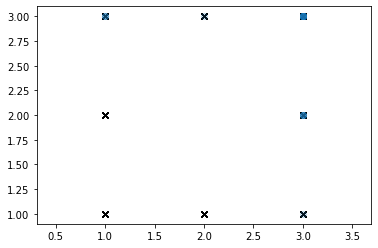

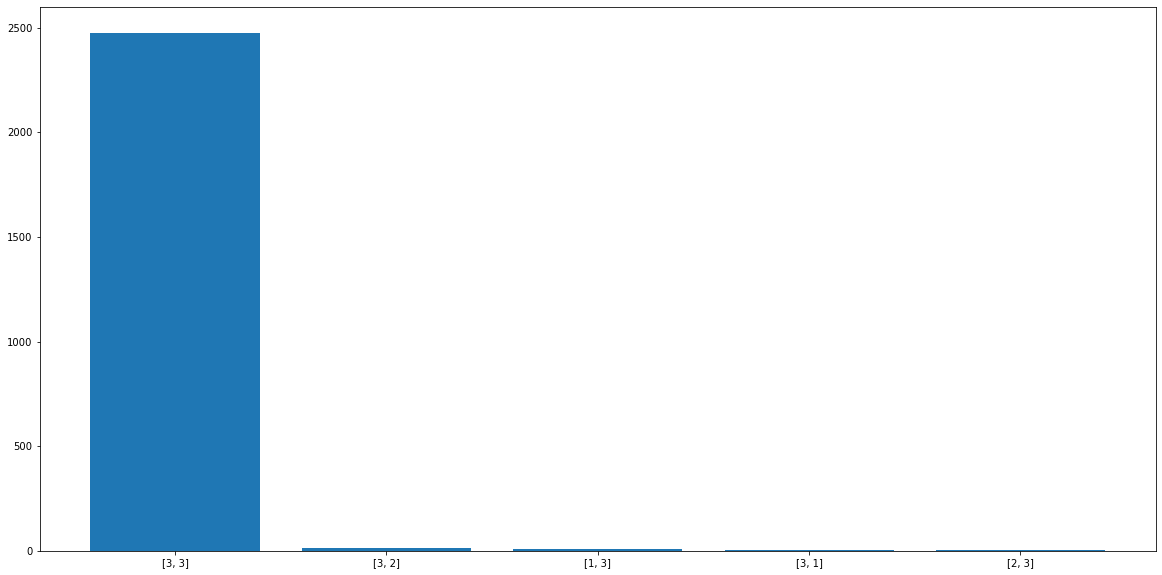

Processing Epoch 186
training start
Iteration 0, d real/fake loss 0.6284691691398621/0.8056483268737793 and g loss is 0.599755048751831, NDiv loss 0.2215973138809204
Iteration 1, d real/fake loss 0.6287749409675598/0.804362952709198 and g loss is 0.5996023416519165, NDiv loss 0.23704960942268372
Iteration 2, d real/fake loss 0.629084587097168/0.799559473991394 and g loss is 0.6012284755706787, NDiv loss 0.2250339537858963
Iteration 3, d real/fake loss 0.6293967366218567/0.7930955290794373 and g loss is 0.604080319404602, NDiv loss 0.25320860743522644
Iteration 4, d real/fake loss 0.6297091245651245/0.7925810813903809 and g loss is 0.6039050817489624, NDiv loss 0.20022541284561157


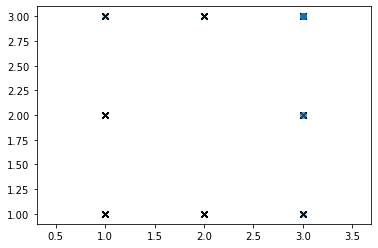

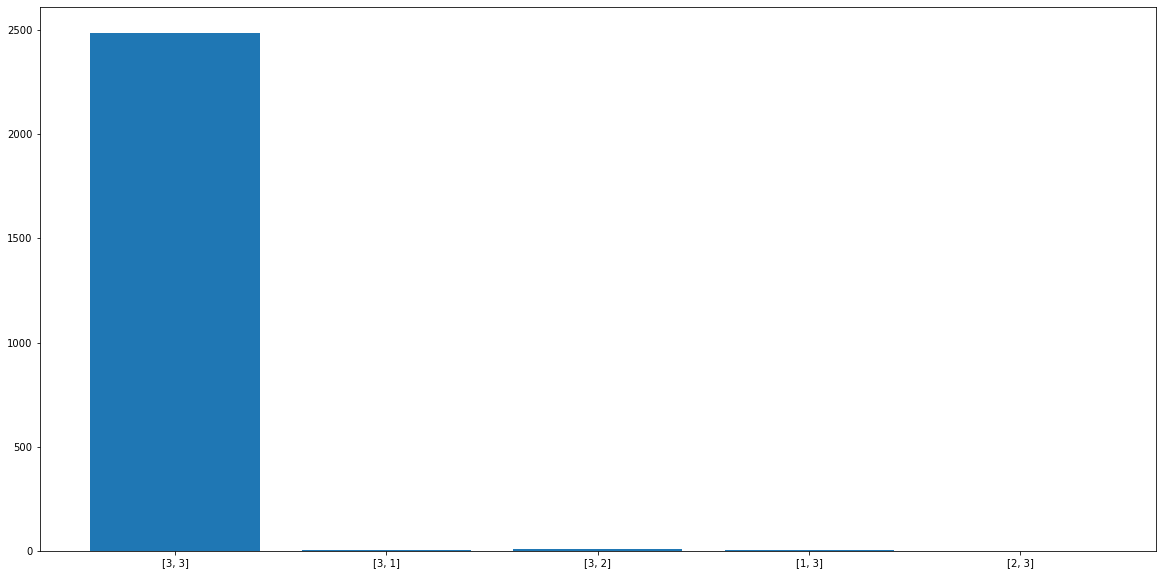

Processing Epoch 187
training start
Iteration 0, d real/fake loss 0.649815559387207/0.7916357517242432 and g loss is 0.6028253436088562, NDiv loss 0.24887388944625854
Iteration 1, d real/fake loss 0.650059700012207/0.7913272380828857 and g loss is 0.6051912903785706, NDiv loss 0.2093934267759323
Iteration 2, d real/fake loss 0.6502951979637146/0.7886315584182739 and g loss is 0.6096304655075073, NDiv loss 0.20978400111198425
Iteration 3, d real/fake loss 0.6505228281021118/0.7835143208503723 and g loss is 0.6118128895759583, NDiv loss 0.23402537405490875
Iteration 4, d real/fake loss 0.6507413387298584/0.7821558117866516 and g loss is 0.6124864220619202, NDiv loss 0.23811154067516327


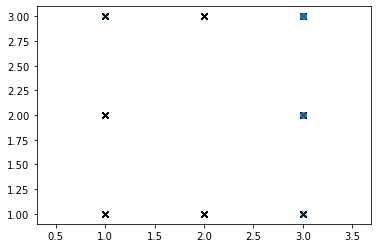

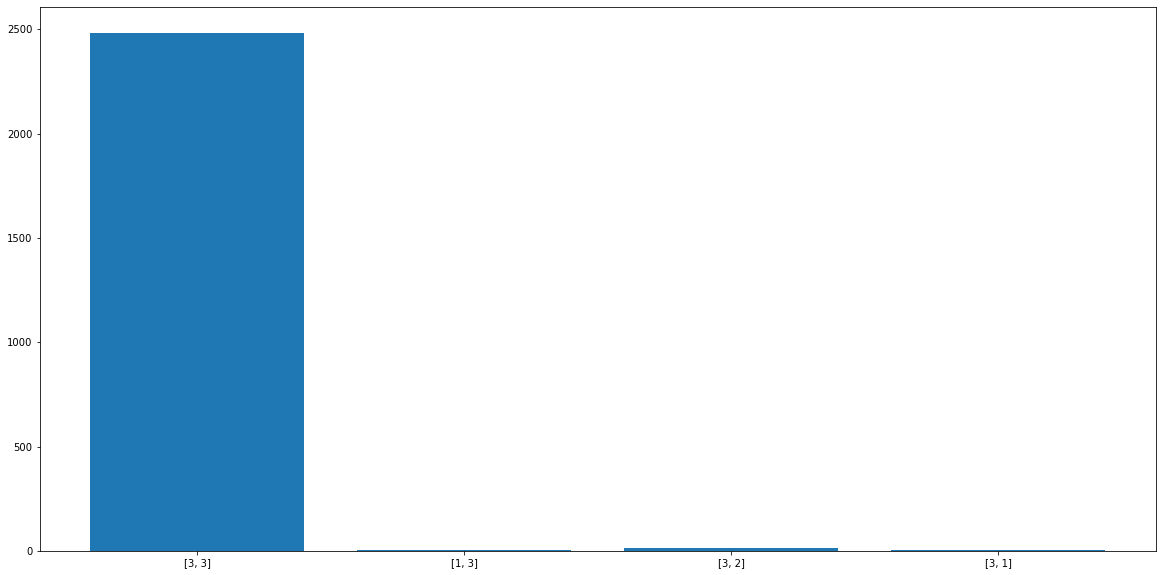

Processing Epoch 188
training start
Iteration 0, d real/fake loss 0.6413632035255432/0.782209575176239 and g loss is 0.6138712167739868, NDiv loss 0.22516010701656342
Iteration 1, d real/fake loss 0.6415643095970154/0.7796694040298462 and g loss is 0.6195144057273865, NDiv loss 0.22089701890945435
Iteration 2, d real/fake loss 0.6417598724365234/0.7780852317810059 and g loss is 0.6184313297271729, NDiv loss 0.2021828442811966
Iteration 3, d real/fake loss 0.6419505476951599/0.7750369310379028 and g loss is 0.621315598487854, NDiv loss 0.22669832408428192
Iteration 4, d real/fake loss 0.6421358585357666/0.773536205291748 and g loss is 0.6228214502334595, NDiv loss 0.23064063489437103


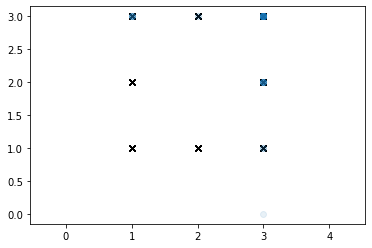

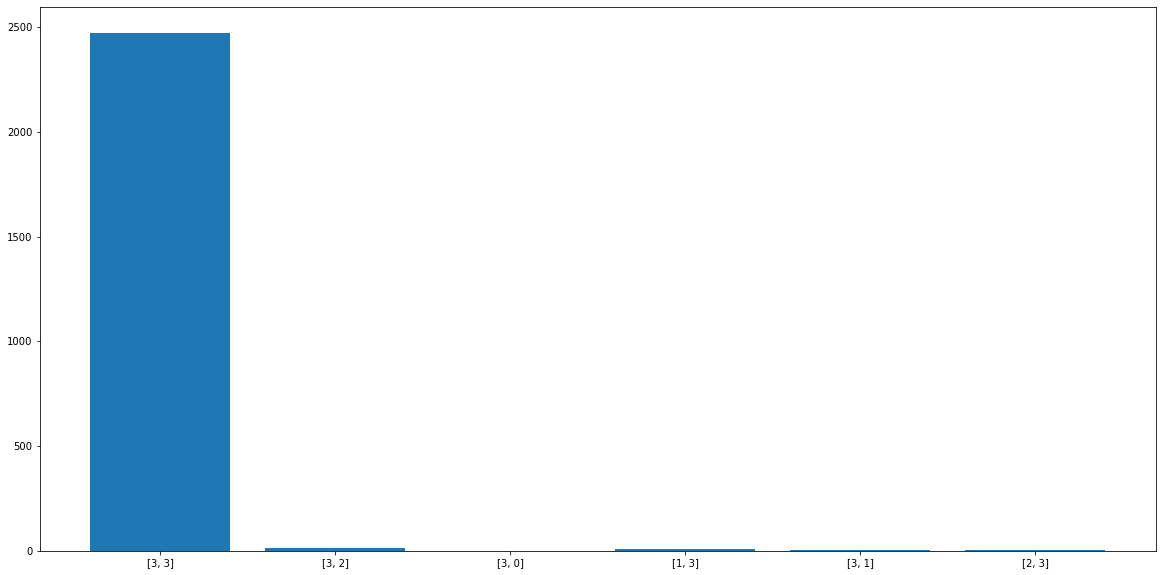

Processing Epoch 189
training start
Iteration 0, d real/fake loss 0.6222443580627441/0.7700823545455933 and g loss is 0.6239545345306396, NDiv loss 0.22403283417224884
Iteration 1, d real/fake loss 0.6223149299621582/0.7688297033309937 and g loss is 0.6261833310127258, NDiv loss 0.23078963160514832
Iteration 2, d real/fake loss 0.6223822236061096/0.7647809982299805 and g loss is 0.6289877891540527, NDiv loss 0.1759425550699234
Iteration 3, d real/fake loss 0.6224452257156372/0.7637913823127747 and g loss is 0.6318329572677612, NDiv loss 0.30028781294822693
Iteration 4, d real/fake loss 0.6225033402442932/0.7542716860771179 and g loss is 0.6341103315353394, NDiv loss 0.21307124197483063


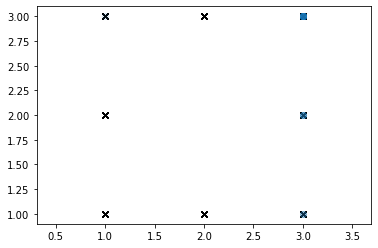

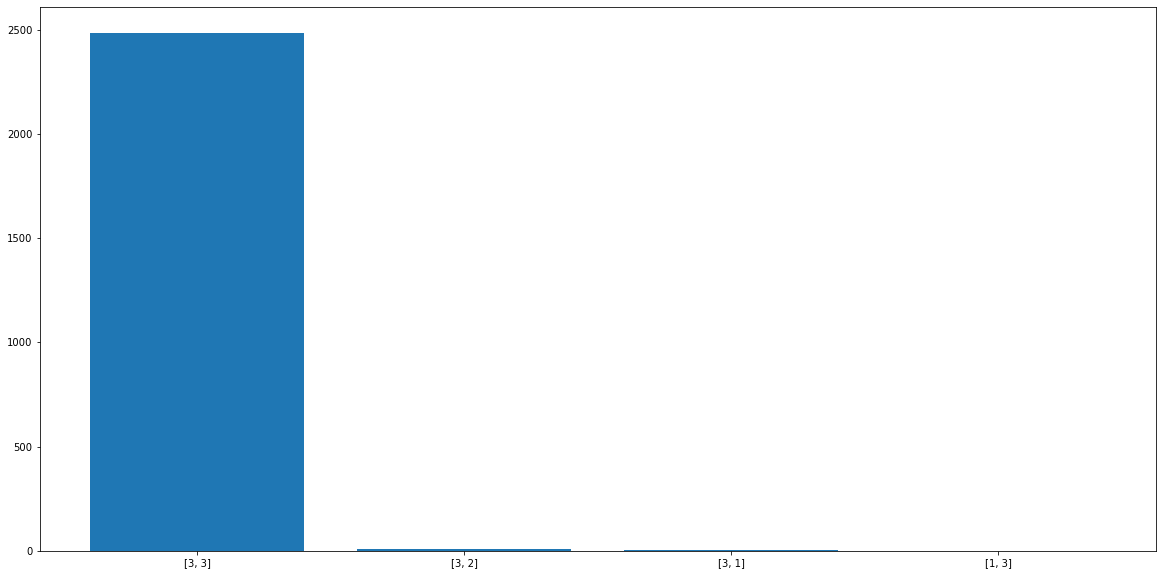

Processing Epoch 190
training start
Iteration 0, d real/fake loss 0.6473426222801208/0.7581037878990173 and g loss is 0.6328772306442261, NDiv loss 0.20532195270061493
Iteration 1, d real/fake loss 0.6474334001541138/0.7553943991661072 and g loss is 0.6368563771247864, NDiv loss 0.26454874873161316
Iteration 2, d real/fake loss 0.6475129127502441/0.7552367448806763 and g loss is 0.6367974281311035, NDiv loss 0.20782425999641418
Iteration 3, d real/fake loss 0.6475822925567627/0.7510067224502563 and g loss is 0.6389314532279968, NDiv loss 0.18244396150112152
Iteration 4, d real/fake loss 0.6476417779922485/0.7508611679077148 and g loss is 0.6408558487892151, NDiv loss 0.19920583069324493


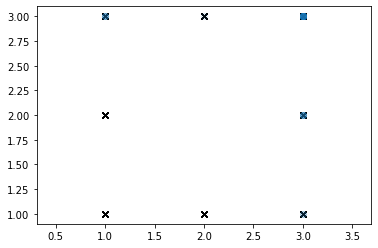

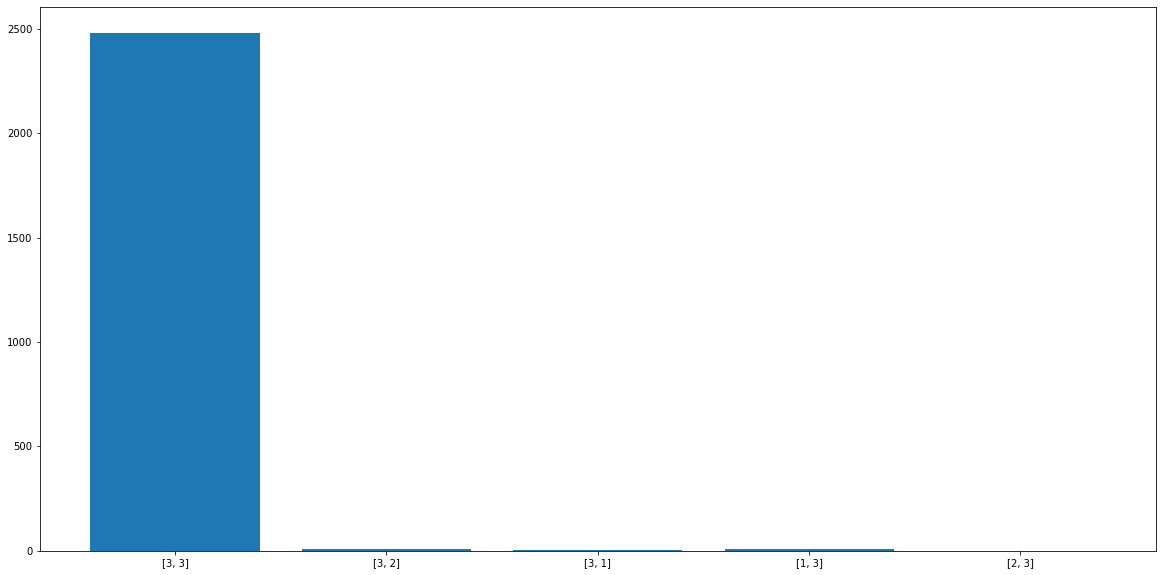

Processing Epoch 191
training start
Iteration 0, d real/fake loss 0.6694578528404236/0.7504474520683289 and g loss is 0.6422816514968872, NDiv loss 0.25312313437461853
Iteration 1, d real/fake loss 0.6693896055221558/0.7453537583351135 and g loss is 0.644780695438385, NDiv loss 0.2003113478422165
Iteration 2, d real/fake loss 0.6693000197410583/0.743628740310669 and g loss is 0.6470493674278259, NDiv loss 0.22999423742294312
Iteration 3, d real/fake loss 0.6691910028457642/0.7421863079071045 and g loss is 0.6490768194198608, NDiv loss 0.2295638620853424
Iteration 4, d real/fake loss 0.6690639853477478/0.7392354011535645 and g loss is 0.6501369476318359, NDiv loss 0.2021651417016983


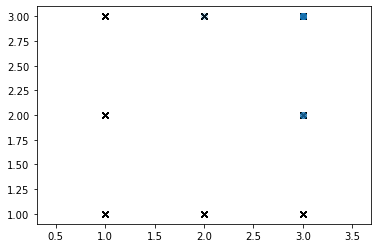

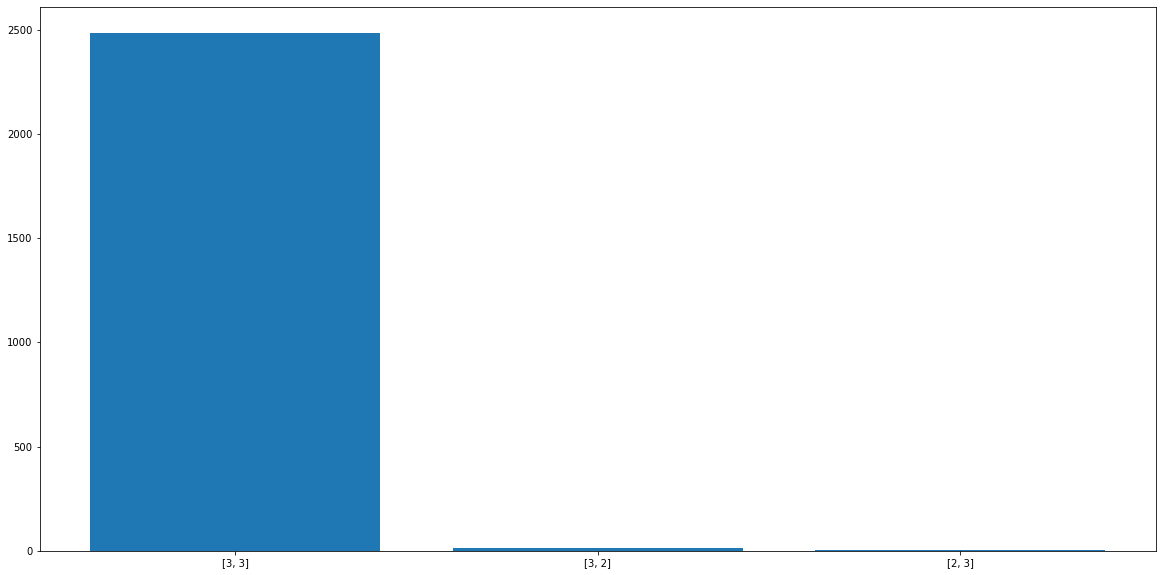

Processing Epoch 192
training start
Iteration 0, d real/fake loss 0.6844546794891357/0.7372245788574219 and g loss is 0.6509210467338562, NDiv loss 0.21594005823135376
Iteration 1, d real/fake loss 0.6843864917755127/0.7346746921539307 and g loss is 0.6553213596343994, NDiv loss 0.2760125994682312
Iteration 2, d real/fake loss 0.6843001842498779/0.7343670725822449 and g loss is 0.6554292440414429, NDiv loss 0.229771688580513
Iteration 3, d real/fake loss 0.684197187423706/0.7300995588302612 and g loss is 0.6567546725273132, NDiv loss 0.20984089374542236
Iteration 4, d real/fake loss 0.6840726733207703/0.7311190366744995 and g loss is 0.6595104932785034, NDiv loss 0.24571841955184937


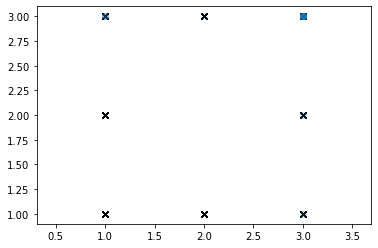

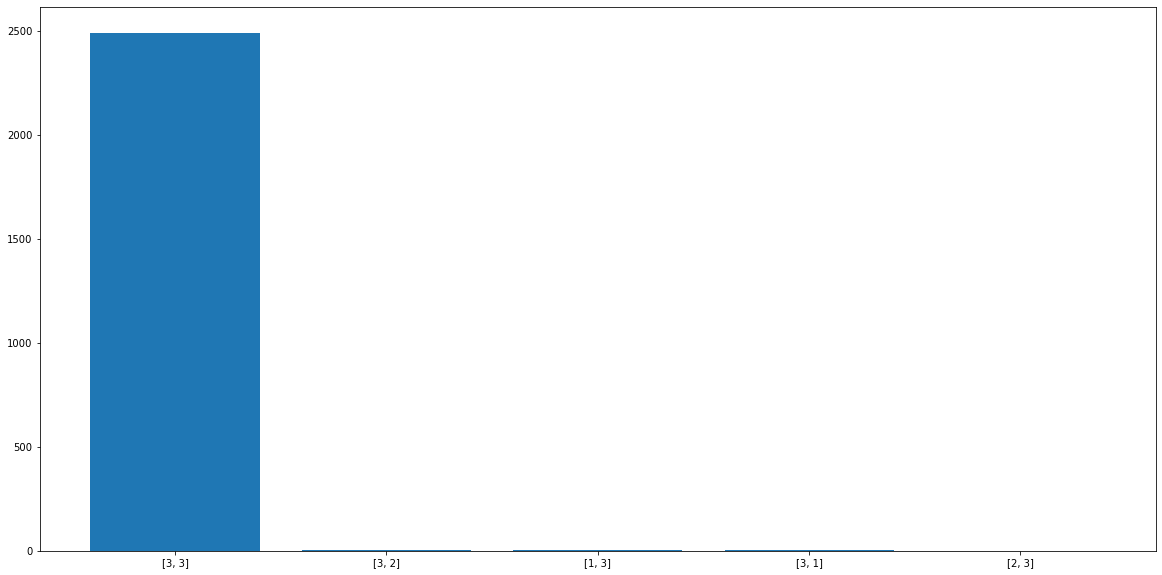

Processing Epoch 193
training start
Iteration 0, d real/fake loss 0.6577943563461304/0.7281875014305115 and g loss is 0.6604806184768677, NDiv loss 0.24804933369159698
Iteration 1, d real/fake loss 0.6575607061386108/0.7263129949569702 and g loss is 0.6624836921691895, NDiv loss 0.1832217425107956
Iteration 2, d real/fake loss 0.6573217511177063/0.7251772880554199 and g loss is 0.6662241220474243, NDiv loss 0.2647668719291687
Iteration 3, d real/fake loss 0.6570783853530884/0.7223411798477173 and g loss is 0.665746808052063, NDiv loss 0.2376176118850708
Iteration 4, d real/fake loss 0.6568296551704407/0.7205215096473694 and g loss is 0.6674627065658569, NDiv loss 0.1865730583667755


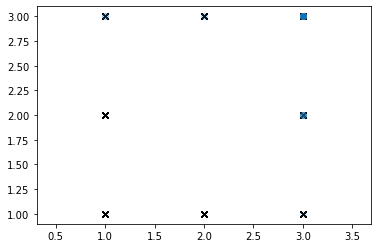

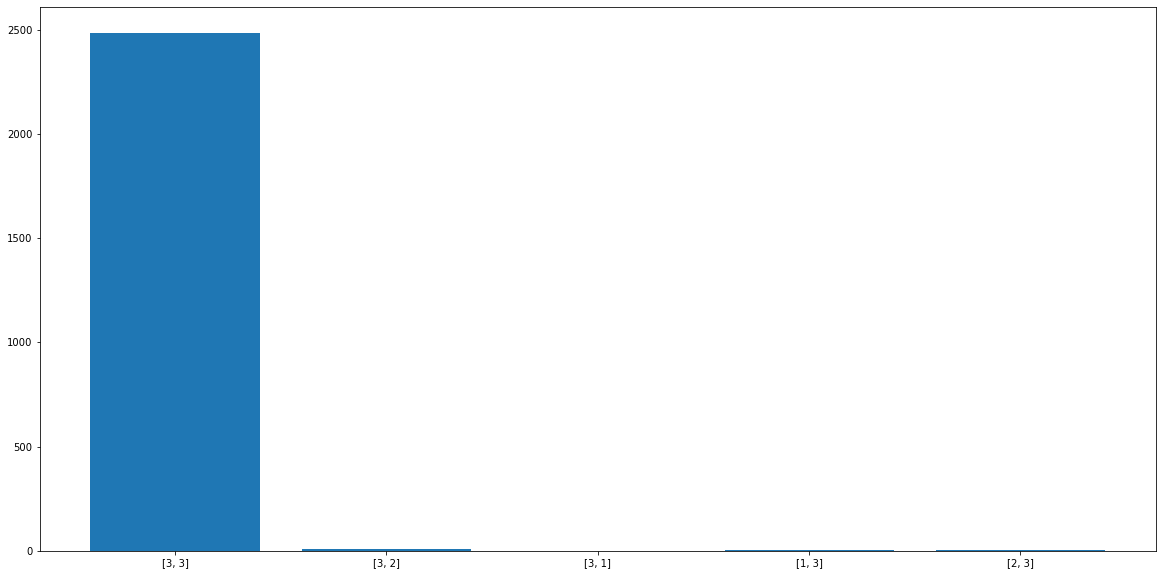

Processing Epoch 194
training start
Iteration 0, d real/fake loss 0.672583818435669/0.7192108631134033 and g loss is 0.6691449284553528, NDiv loss 0.2106781154870987
Iteration 1, d real/fake loss 0.6723531484603882/0.7171721458435059 and g loss is 0.6733342409133911, NDiv loss 0.2667560279369354
Iteration 2, d real/fake loss 0.6721132397651672/0.7154206037521362 and g loss is 0.6732959747314453, NDiv loss 0.2607741951942444
Iteration 3, d real/fake loss 0.6718653440475464/0.7124555706977844 and g loss is 0.6751077175140381, NDiv loss 0.26958173513412476
Iteration 4, d real/fake loss 0.6716099977493286/0.7125861644744873 and g loss is 0.677209198474884, NDiv loss 0.2650248408317566


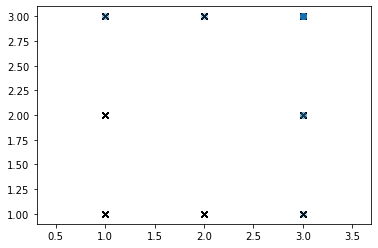

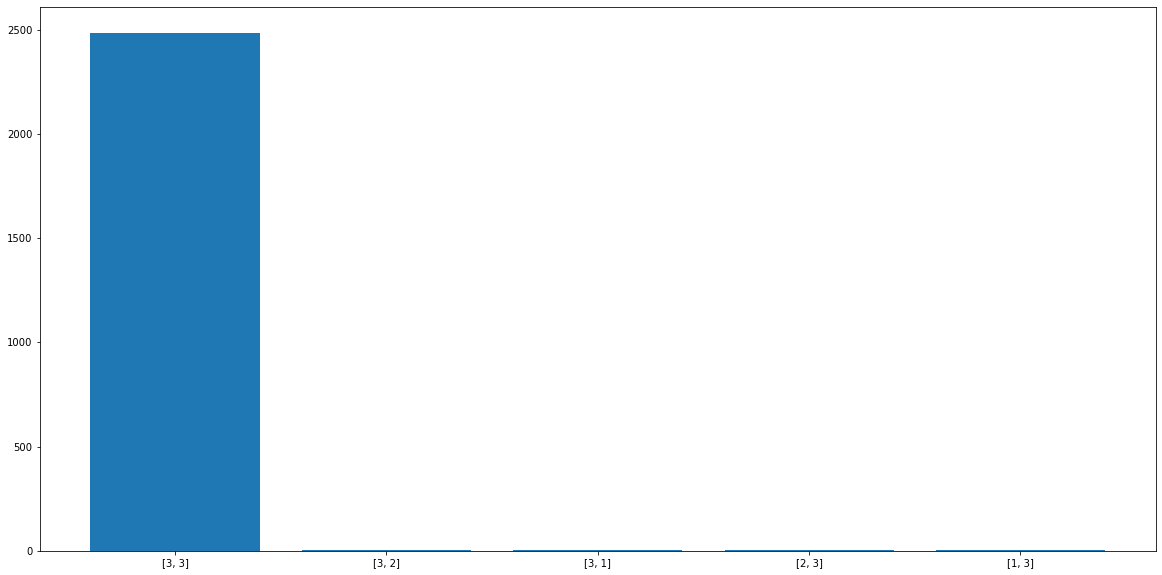

Processing Epoch 195
training start
Iteration 0, d real/fake loss 0.6525110006332397/0.7087607383728027 and g loss is 0.6773391962051392, NDiv loss 0.2522503137588501
Iteration 1, d real/fake loss 0.6522935032844543/0.7060315608978271 and g loss is 0.6802003383636475, NDiv loss 0.2250448316335678
Iteration 2, d real/fake loss 0.6520746946334839/0.704757571220398 and g loss is 0.6819667220115662, NDiv loss 0.26212945580482483
Iteration 3, d real/fake loss 0.6518545150756836/0.7046786546707153 and g loss is 0.6825392246246338, NDiv loss 0.1896115243434906
Iteration 4, d real/fake loss 0.6516323089599609/0.7032212018966675 and g loss is 0.6858206987380981, NDiv loss 0.17391431331634521


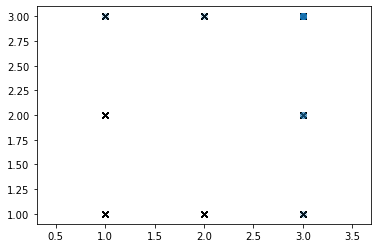

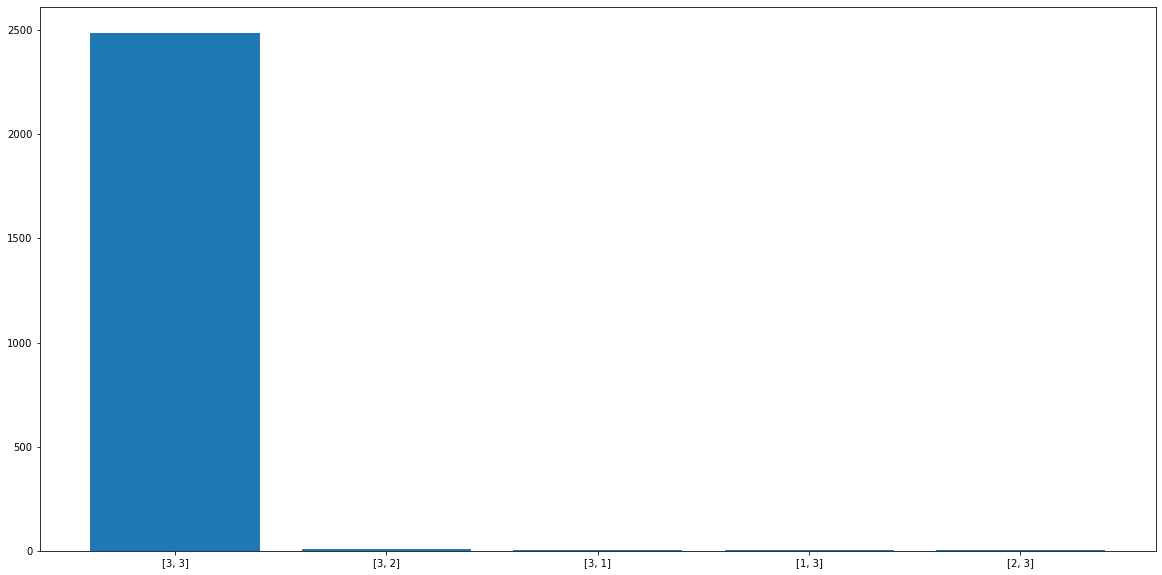

Processing Epoch 196
training start
Iteration 0, d real/fake loss 0.6566445231437683/0.7008552551269531 and g loss is 0.6849408149719238, NDiv loss 0.26205113530158997
Iteration 1, d real/fake loss 0.6565486788749695/0.7000076770782471 and g loss is 0.6896015405654907, NDiv loss 0.25025659799575806
Iteration 2, d real/fake loss 0.6564507484436035/0.6993576288223267 and g loss is 0.6899415850639343, NDiv loss 0.2500266432762146
Iteration 3, d real/fake loss 0.6563513278961182/0.6966192722320557 and g loss is 0.692711591720581, NDiv loss 0.25927457213401794
Iteration 4, d real/fake loss 0.6562494039535522/0.6939019560813904 and g loss is 0.692495584487915, NDiv loss 0.1806252896785736


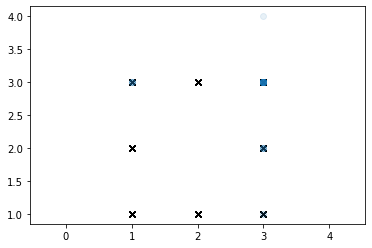

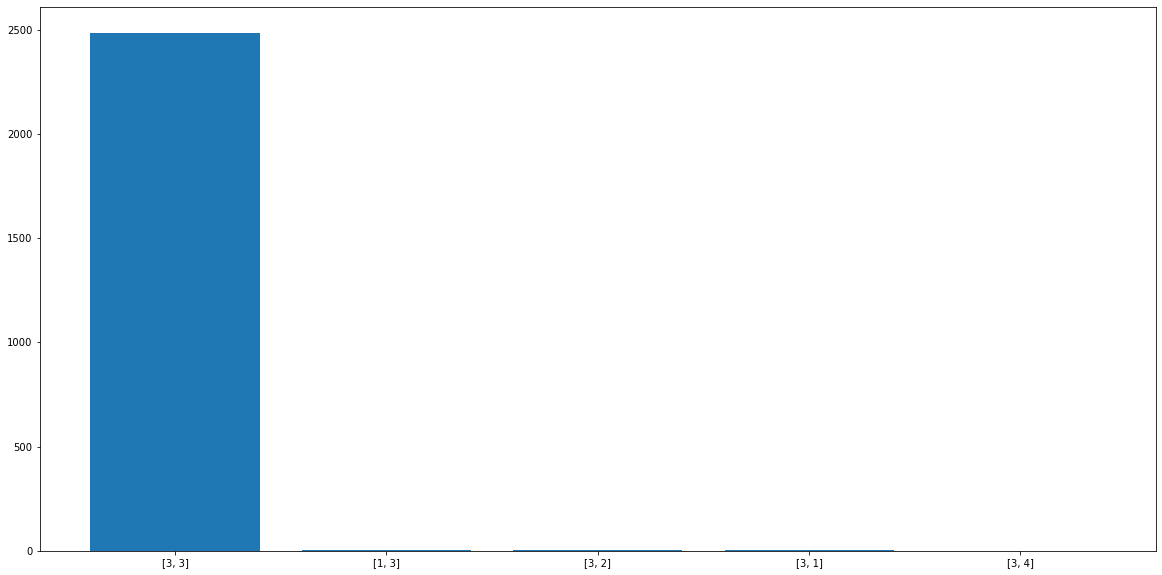

Processing Epoch 197
training start
Iteration 0, d real/fake loss 0.6330804824829102/0.6923180818557739 and g loss is 0.6945054531097412, NDiv loss 0.23537153005599976
Iteration 1, d real/fake loss 0.6329201459884644/0.6909623742103577 and g loss is 0.6971627473831177, NDiv loss 0.23899346590042114
Iteration 2, d real/fake loss 0.6327593326568604/0.6901821494102478 and g loss is 0.6981536149978638, NDiv loss 0.2918863892555237
Iteration 3, d real/fake loss 0.6325972676277161/0.6883217096328735 and g loss is 0.6989573240280151, NDiv loss 0.27650579810142517
Iteration 4, d real/fake loss 0.6324337124824524/0.6873785853385925 and g loss is 0.701374888420105, NDiv loss 0.22187836468219757


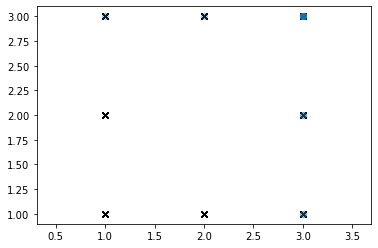

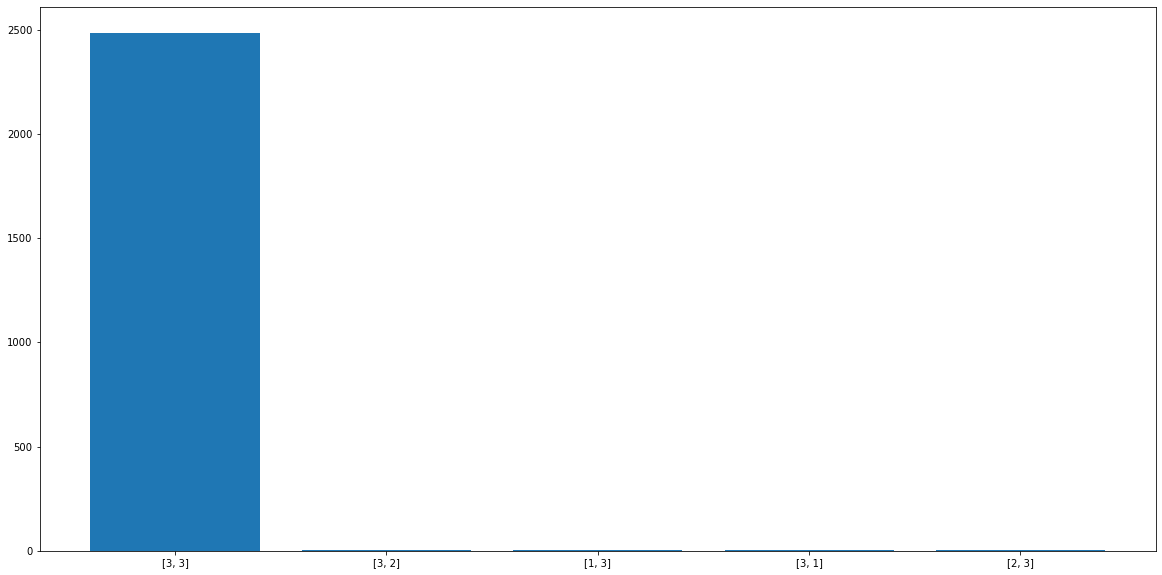

Processing Epoch 198
training start
Iteration 0, d real/fake loss 0.6666585206985474/0.6856648921966553 and g loss is 0.7027390599250793, NDiv loss 0.286268413066864
Iteration 1, d real/fake loss 0.6664718985557556/0.6838312745094299 and g loss is 0.7035938501358032, NDiv loss 0.22981898486614227
Iteration 2, d real/fake loss 0.6662716865539551/0.6821305751800537 and g loss is 0.7050625085830688, NDiv loss 0.2615262269973755
Iteration 3, d real/fake loss 0.6660588979721069/0.6806654334068298 and g loss is 0.7063603401184082, NDiv loss 0.20487825572490692
Iteration 4, d real/fake loss 0.6658346652984619/0.6790539026260376 and g loss is 0.7065866589546204, NDiv loss 0.24816684424877167


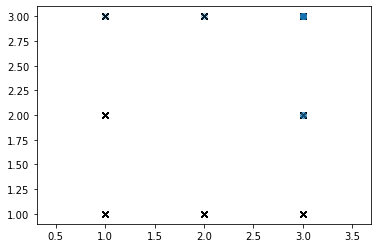

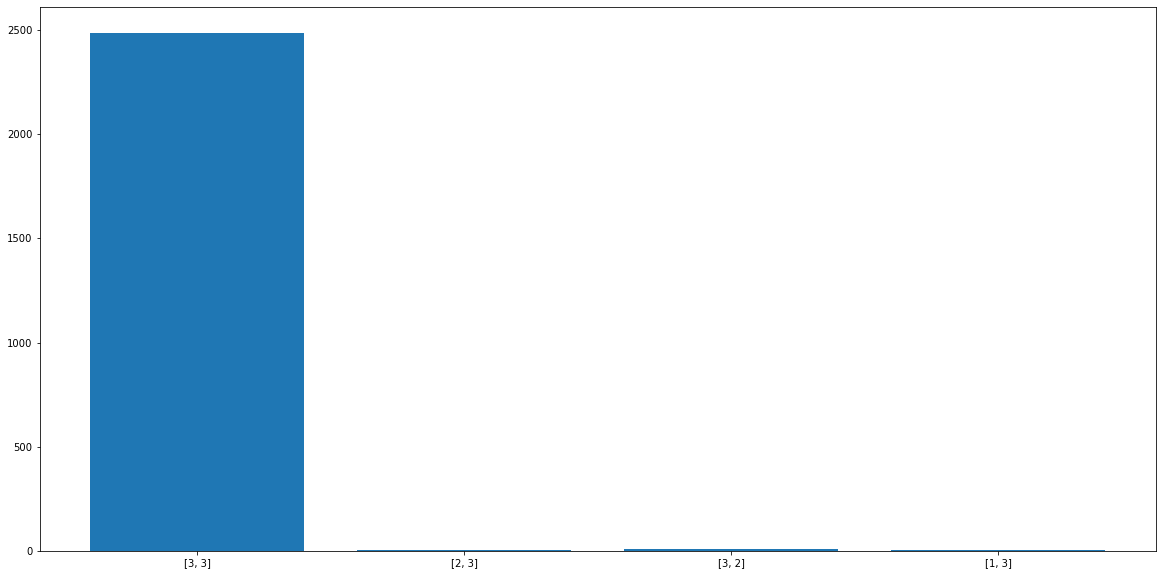

Processing Epoch 199
training start
Iteration 0, d real/fake loss 0.6643497943878174/0.6781357526779175 and g loss is 0.7101995944976807, NDiv loss 0.2557581067085266
Iteration 1, d real/fake loss 0.6640824675559998/0.6754820346832275 and g loss is 0.7109088897705078, NDiv loss 0.28294217586517334
Iteration 2, d real/fake loss 0.663806676864624/0.6747593283653259 and g loss is 0.7127601504325867, NDiv loss 0.23480911552906036
Iteration 3, d real/fake loss 0.6635230779647827/0.6734127998352051 and g loss is 0.7153639793395996, NDiv loss 0.18461738526821136
Iteration 4, d real/fake loss 0.6632325053215027/0.6708971261978149 and g loss is 0.7152466773986816, NDiv loss 0.2183186411857605


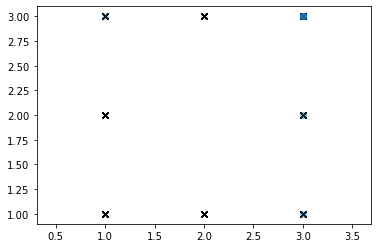

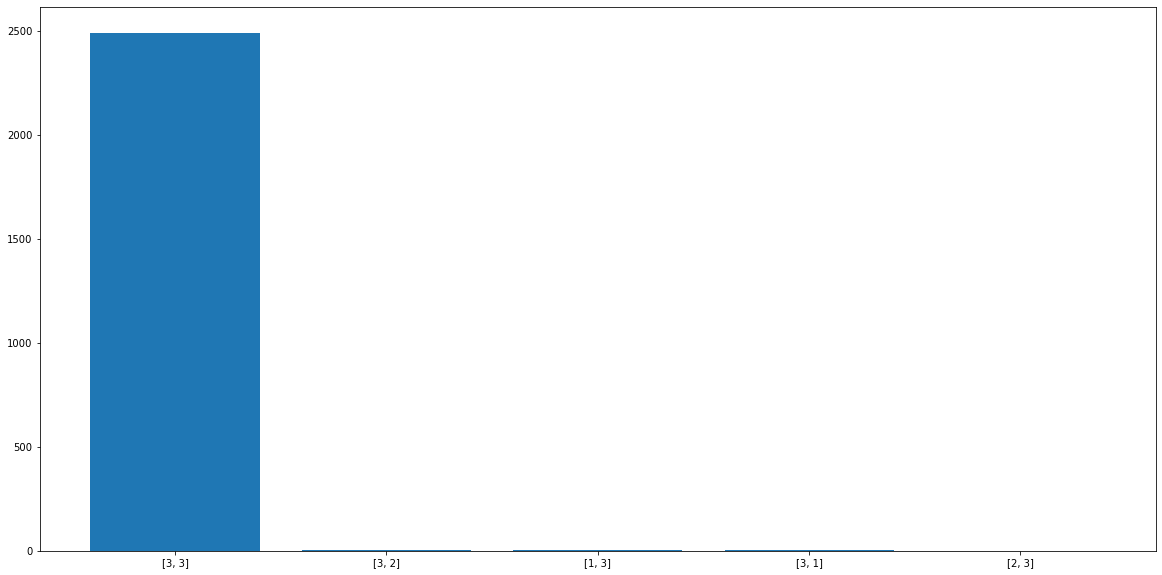

Processing Epoch 200
training start
Iteration 0, d real/fake loss 0.6510264873504639/0.6711157560348511 and g loss is 0.717596173286438, NDiv loss 0.2413322627544403
Iteration 1, d real/fake loss 0.6507452726364136/0.6695576906204224 and g loss is 0.7167637348175049, NDiv loss 0.23941285908222198
Iteration 2, d real/fake loss 0.6504600644111633/0.6694079637527466 and g loss is 0.7198851108551025, NDiv loss 0.254170686006546
Iteration 3, d real/fake loss 0.6501720547676086/0.6665862202644348 and g loss is 0.7225562334060669, NDiv loss 0.27687910199165344
Iteration 4, d real/fake loss 0.6498802900314331/0.6648011803627014 and g loss is 0.7234439849853516, NDiv loss 0.22237689793109894


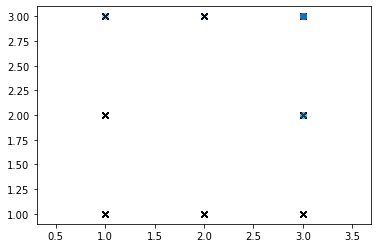

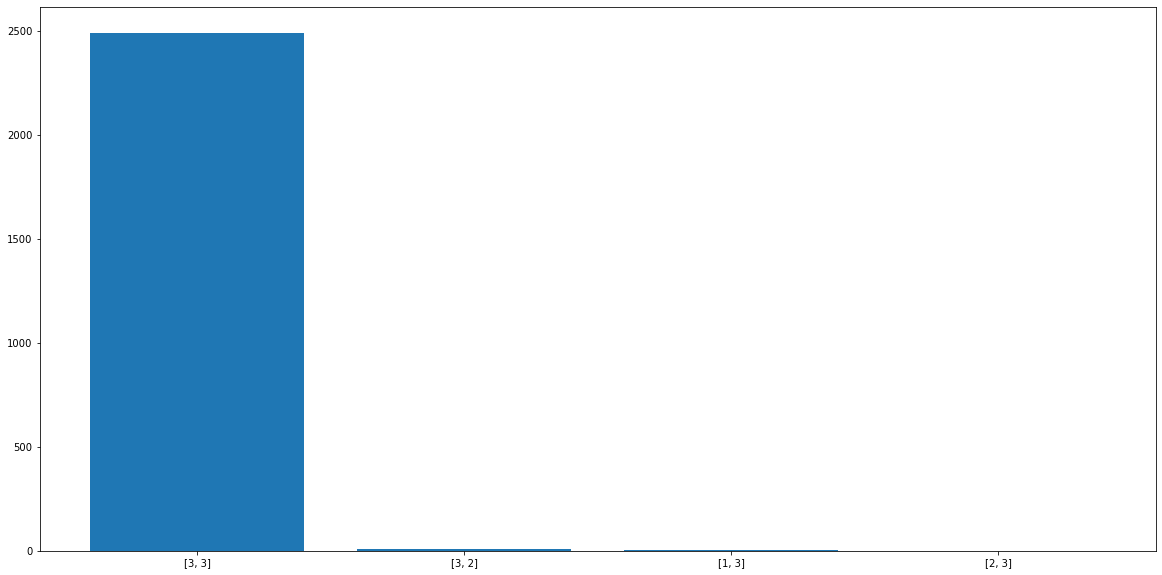

Processing Epoch 201
training start
Iteration 0, d real/fake loss 0.6445149183273315/0.6632812023162842 and g loss is 0.7249754667282104, NDiv loss 0.281252384185791
Iteration 1, d real/fake loss 0.6442482471466064/0.6635355949401855 and g loss is 0.7267473936080933, NDiv loss 0.1990375518798828
Iteration 2, d real/fake loss 0.6439792513847351/0.6594715118408203 and g loss is 0.7277682423591614, NDiv loss 0.28036296367645264
Iteration 3, d real/fake loss 0.6437079906463623/0.6583308577537537 and g loss is 0.7294934988021851, NDiv loss 0.27951982617378235
Iteration 4, d real/fake loss 0.6434345245361328/0.6575009226799011 and g loss is 0.72923743724823, NDiv loss 0.20420287549495697


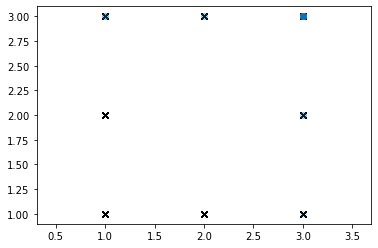

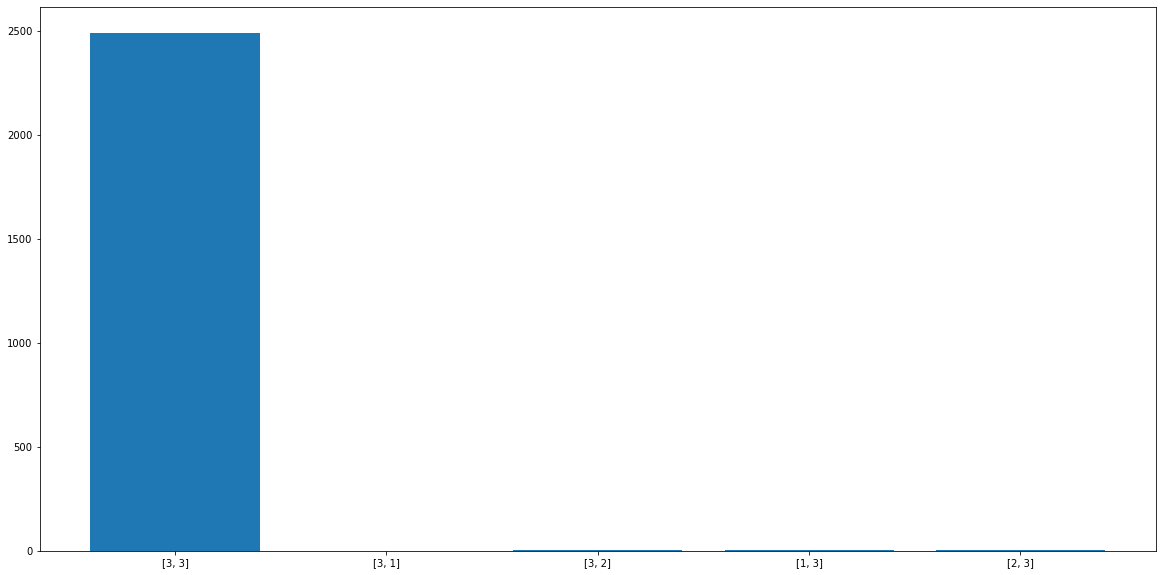

Processing Epoch 202
training start
Iteration 0, d real/fake loss 0.6693400144577026/0.6555821895599365 and g loss is 0.732388436794281, NDiv loss 0.2176581621170044
Iteration 1, d real/fake loss 0.6692482829093933/0.6559945344924927 and g loss is 0.7350437641143799, NDiv loss 0.22697176039218903
Iteration 2, d real/fake loss 0.6691428422927856/0.6540122032165527 and g loss is 0.7340835332870483, NDiv loss 0.21726477146148682
Iteration 3, d real/fake loss 0.6690245270729065/0.6530661582946777 and g loss is 0.735730767250061, NDiv loss 0.2538021206855774
Iteration 4, d real/fake loss 0.6688941717147827/0.6514846086502075 and g loss is 0.7380300760269165, NDiv loss 0.2149013876914978


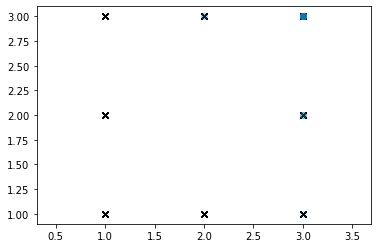

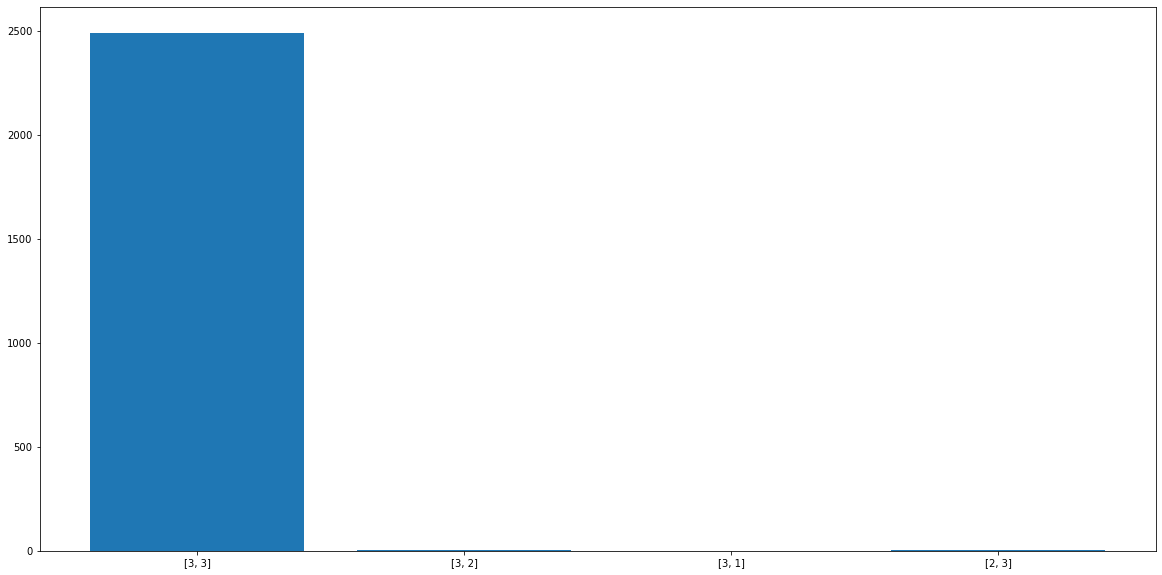

Processing Epoch 203
training start
Iteration 0, d real/fake loss 0.6391748785972595/0.6506655812263489 and g loss is 0.7384986877441406, NDiv loss 0.24938027560710907
Iteration 1, d real/fake loss 0.6387948393821716/0.6498497724533081 and g loss is 0.7407757043838501, NDiv loss 0.28479933738708496
Iteration 2, d real/fake loss 0.63841712474823/0.647912859916687 and g loss is 0.7419837713241577, NDiv loss 0.2002490758895874
Iteration 3, d real/fake loss 0.6380406022071838/0.6472746729850769 and g loss is 0.743246853351593, NDiv loss 0.2672179043292999
Iteration 4, d real/fake loss 0.6376646757125854/0.6458643674850464 and g loss is 0.7456585168838501, NDiv loss 0.2405276596546173


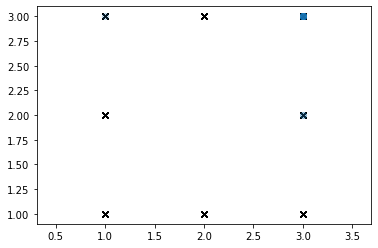

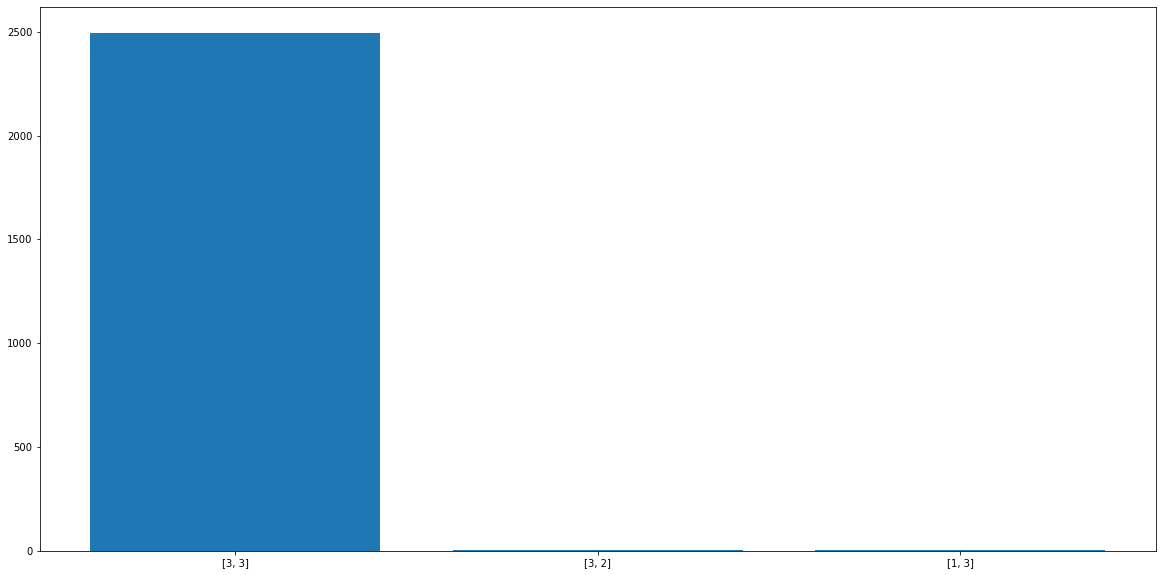

Processing Epoch 204
training start
Iteration 0, d real/fake loss 0.6194998621940613/0.6446583271026611 and g loss is 0.7467615604400635, NDiv loss 0.23367007076740265
Iteration 1, d real/fake loss 0.6192271709442139/0.644973874092102 and g loss is 0.7469922304153442, NDiv loss 0.20115210115909576
Iteration 2, d real/fake loss 0.6189626455307007/0.6431370973587036 and g loss is 0.7494373321533203, NDiv loss 0.2620956599712372
Iteration 3, d real/fake loss 0.6187044382095337/0.6410492658615112 and g loss is 0.7494103908538818, NDiv loss 0.21063515543937683
Iteration 4, d real/fake loss 0.6184514760971069/0.6394994258880615 and g loss is 0.7521655559539795, NDiv loss 0.21796554327011108


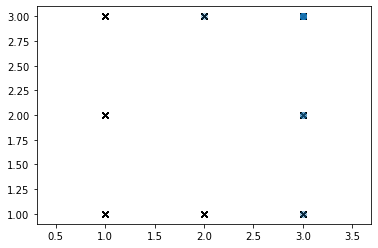

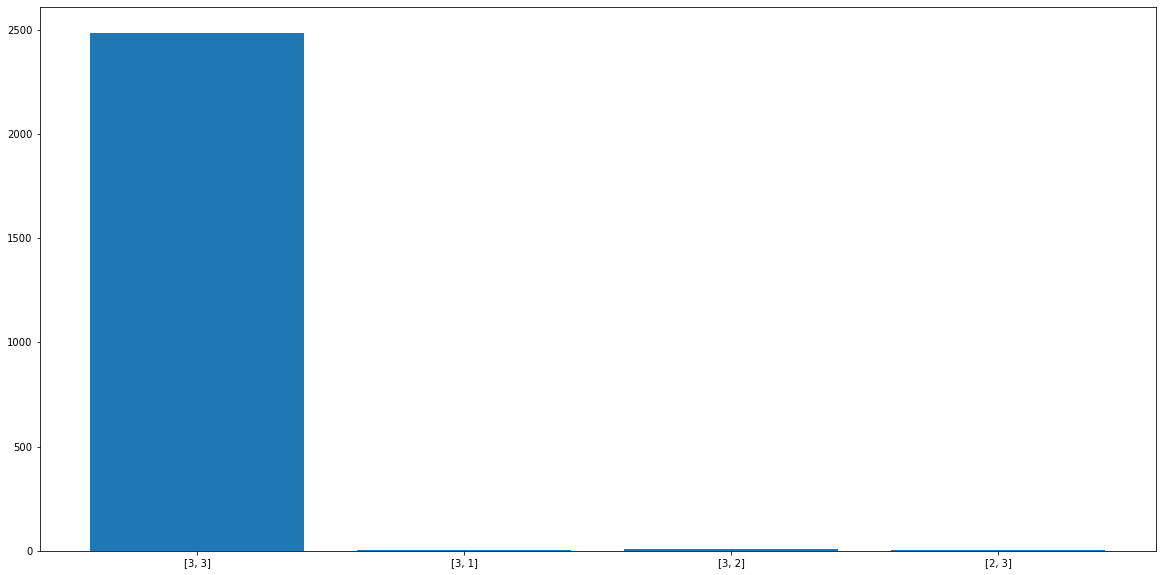

Processing Epoch 205
training start
Iteration 0, d real/fake loss 0.664049506187439/0.637537956237793 and g loss is 0.752606987953186, NDiv loss 0.3045364022254944
Iteration 1, d real/fake loss 0.6637820601463318/0.6379895806312561 and g loss is 0.7531453371047974, NDiv loss 0.2603834867477417
Iteration 2, d real/fake loss 0.6634976863861084/0.6355041861534119 and g loss is 0.7548538446426392, NDiv loss 0.2747497260570526
Iteration 3, d real/fake loss 0.6631976962089539/0.6342117190361023 and g loss is 0.7557767629623413, NDiv loss 0.23006205260753632
Iteration 4, d real/fake loss 0.6628822684288025/0.634175181388855 and g loss is 0.7583857774734497, NDiv loss 0.24039173126220703


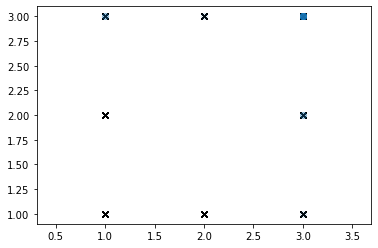

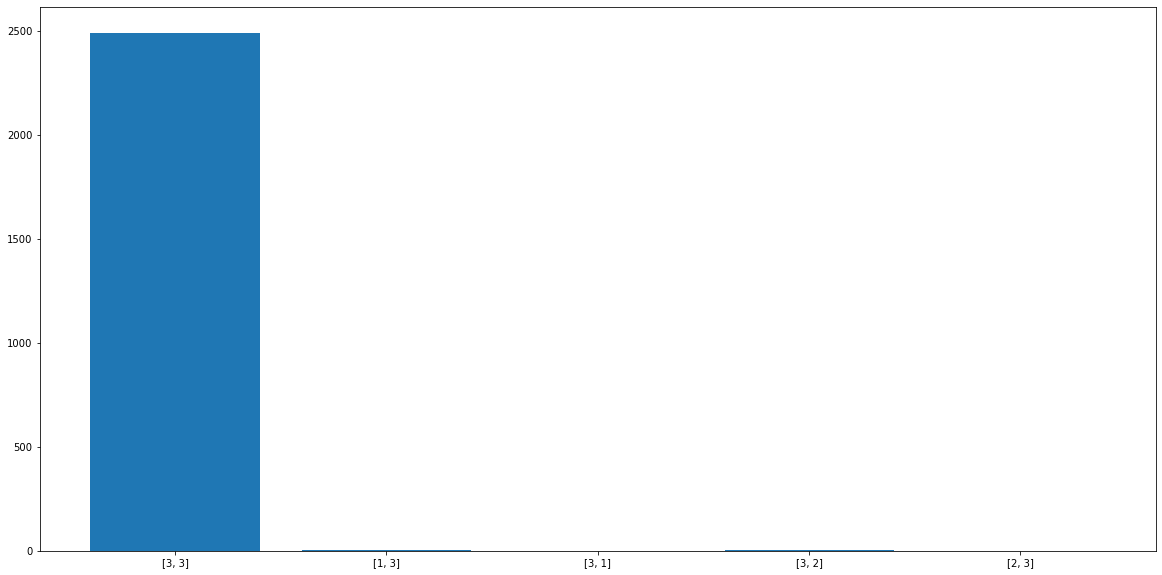

Processing Epoch 206
training start
Iteration 0, d real/fake loss 0.6446809768676758/0.632614016532898 and g loss is 0.7593418955802917, NDiv loss 0.17730790376663208
Iteration 1, d real/fake loss 0.6443393230438232/0.6310224533081055 and g loss is 0.7604273557662964, NDiv loss 0.20650823414325714
Iteration 2, d real/fake loss 0.6439950466156006/0.6296915411949158 and g loss is 0.7614696025848389, NDiv loss 0.15843459963798523
Iteration 3, d real/fake loss 0.643648087978363/0.6288180351257324 and g loss is 0.7629461288452148, NDiv loss 0.2012849748134613
Iteration 4, d real/fake loss 0.6432983875274658/0.6283257603645325 and g loss is 0.7653295397758484, NDiv loss 0.24383880198001862


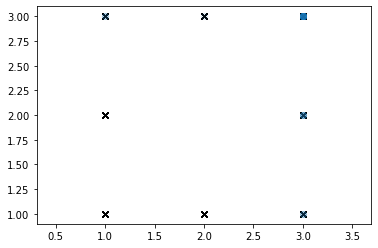

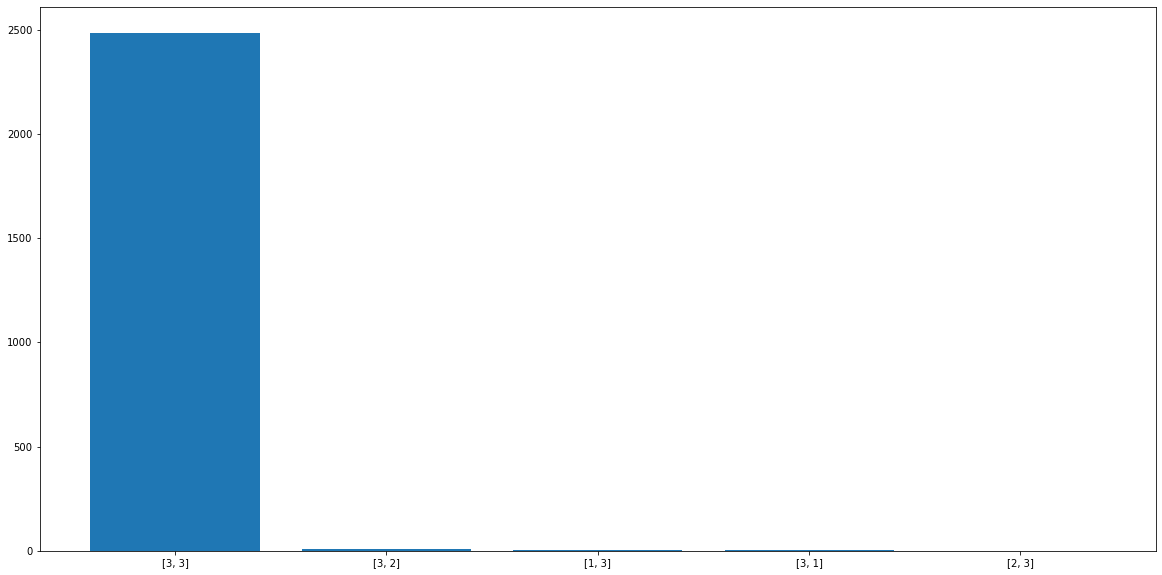

Processing Epoch 207
training start
Iteration 0, d real/fake loss 0.604998767375946/0.6289860010147095 and g loss is 0.7671614289283752, NDiv loss 0.16061733663082123
Iteration 1, d real/fake loss 0.6046671867370605/0.6248923540115356 and g loss is 0.7669308185577393, NDiv loss 0.30577442049980164
Iteration 2, d real/fake loss 0.6043428778648376/0.6236305832862854 and g loss is 0.7693052291870117, NDiv loss 0.22662924230098724
Iteration 3, d real/fake loss 0.6040250062942505/0.6229811906814575 and g loss is 0.7698579430580139, NDiv loss 0.29345032572746277
Iteration 4, d real/fake loss 0.6037132740020752/0.6221013069152832 and g loss is 0.7722451686859131, NDiv loss 0.22198054194450378


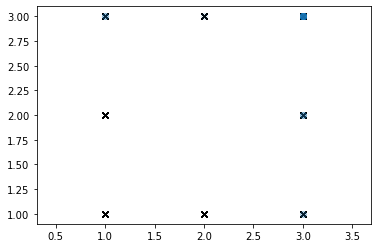

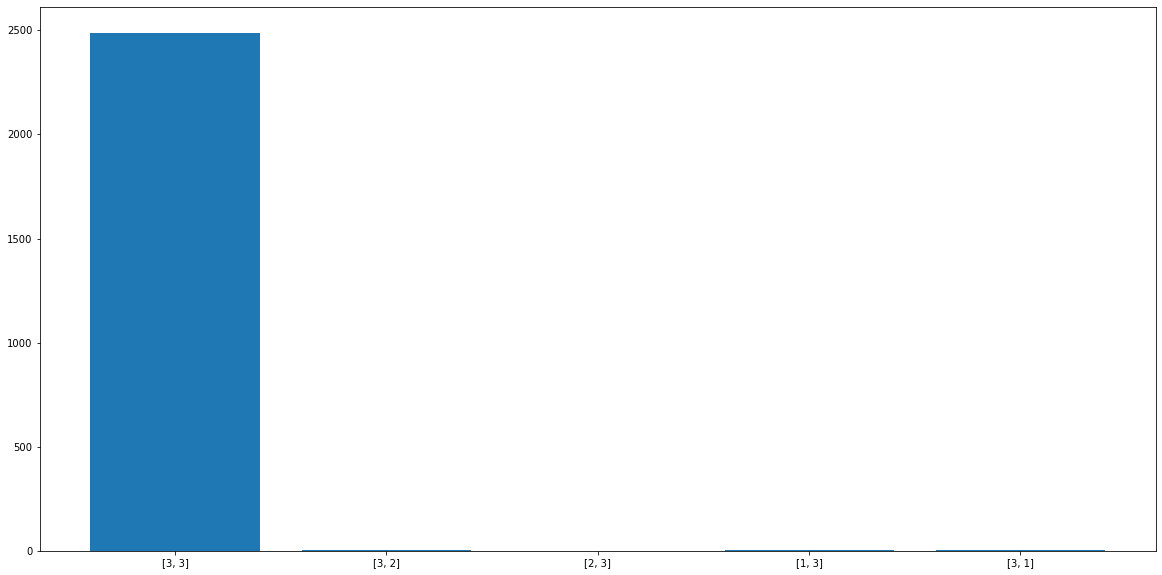

Processing Epoch 208
training start
Iteration 0, d real/fake loss 0.6463339924812317/0.6204192638397217 and g loss is 0.772965669631958, NDiv loss 0.23846282064914703
Iteration 1, d real/fake loss 0.6461654901504517/0.6205564141273499 and g loss is 0.7738261818885803, NDiv loss 0.23989002406597137
Iteration 2, d real/fake loss 0.6459873914718628/0.6181179881095886 and g loss is 0.7734739780426025, NDiv loss 0.28342896699905396
Iteration 3, d real/fake loss 0.6458002328872681/0.6164419651031494 and g loss is 0.777484655380249, NDiv loss 0.279043048620224
Iteration 4, d real/fake loss 0.6456037759780884/0.6168433427810669 and g loss is 0.7787765860557556, NDiv loss 0.2222260981798172


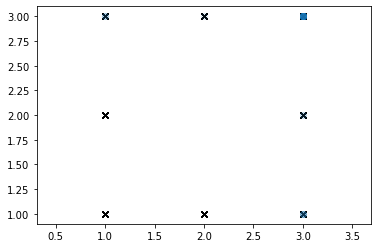

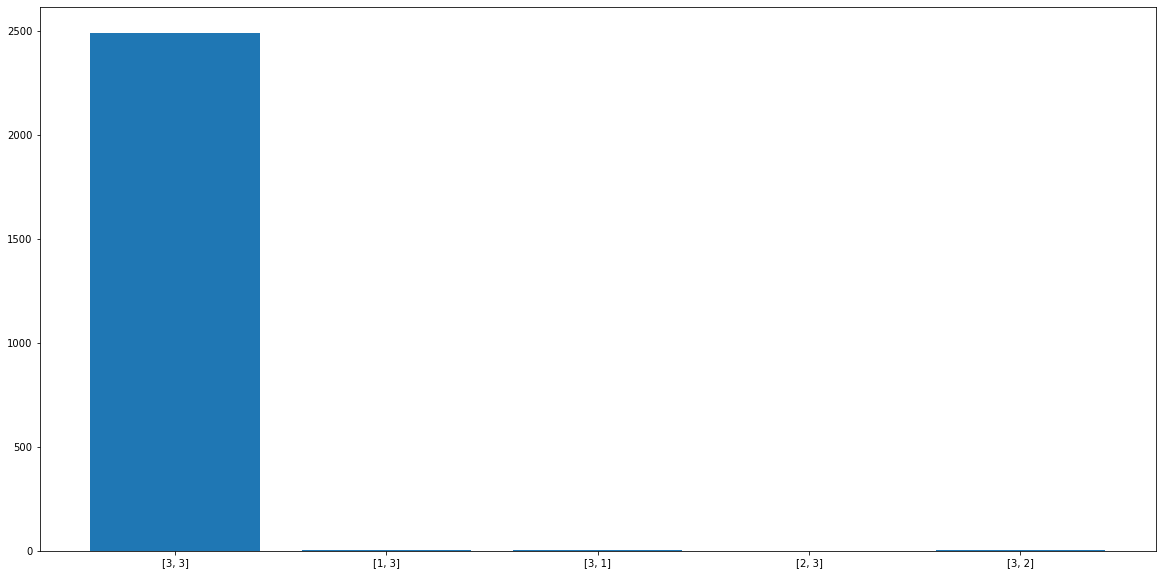

Processing Epoch 209
training start
Iteration 0, d real/fake loss 0.6234550476074219/0.6151984930038452 and g loss is 0.7796013355255127, NDiv loss 0.20552563667297363
Iteration 1, d real/fake loss 0.6230939030647278/0.6147783398628235 and g loss is 0.7799493074417114, NDiv loss 0.24878597259521484
Iteration 2, d real/fake loss 0.6227314472198486/0.6120264530181885 and g loss is 0.7827059626579285, NDiv loss 0.268454372882843
Iteration 3, d real/fake loss 0.6223672032356262/0.6137871742248535 and g loss is 0.7809957265853882, NDiv loss 0.2238560914993286
Iteration 4, d real/fake loss 0.6220024824142456/0.6101856231689453 and g loss is 0.783862829208374, NDiv loss 0.22044450044631958


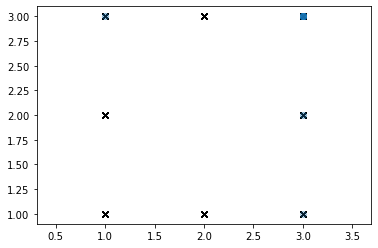

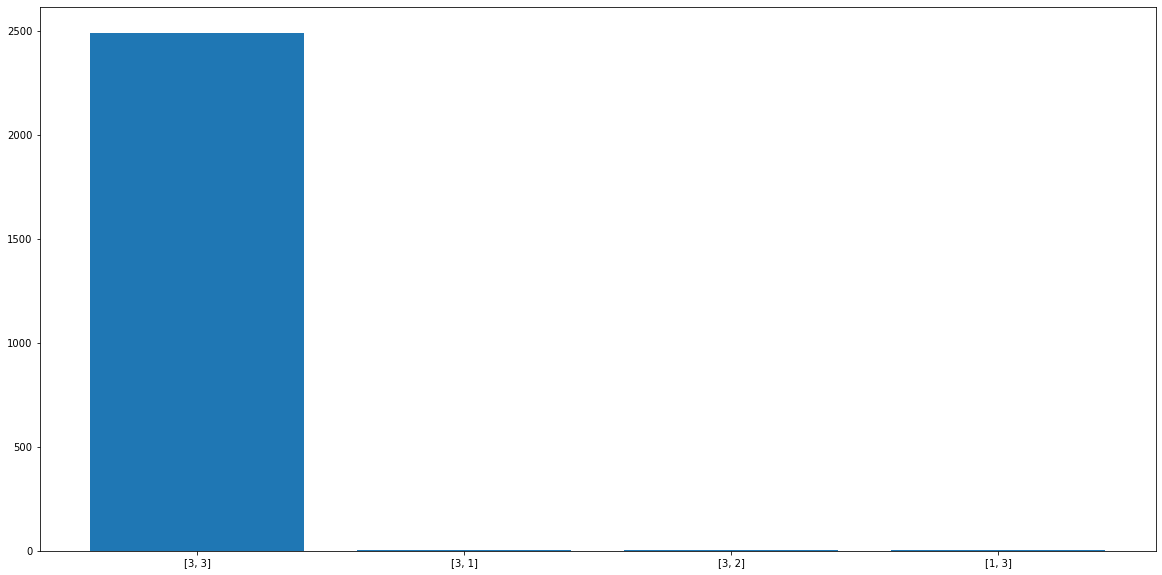

Processing Epoch 210
training start
Iteration 0, d real/fake loss 0.6242492198944092/0.6094916462898254 and g loss is 0.7865782380104065, NDiv loss 0.23999768495559692
Iteration 1, d real/fake loss 0.6238692998886108/0.6089420914649963 and g loss is 0.7875165343284607, NDiv loss 0.20619407296180725
Iteration 2, d real/fake loss 0.6234865188598633/0.6064293384552002 and g loss is 0.7891666293144226, NDiv loss 0.25368085503578186
Iteration 3, d real/fake loss 0.6230999231338501/0.6065151691436768 and g loss is 0.7900397777557373, NDiv loss 0.26379260420799255
Iteration 4, d real/fake loss 0.6227110624313354/0.604782223701477 and g loss is 0.7907242178916931, NDiv loss 0.32366296648979187


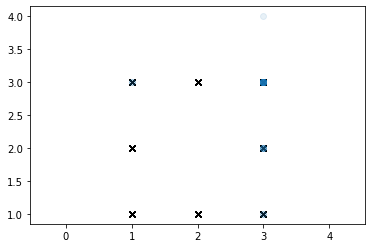

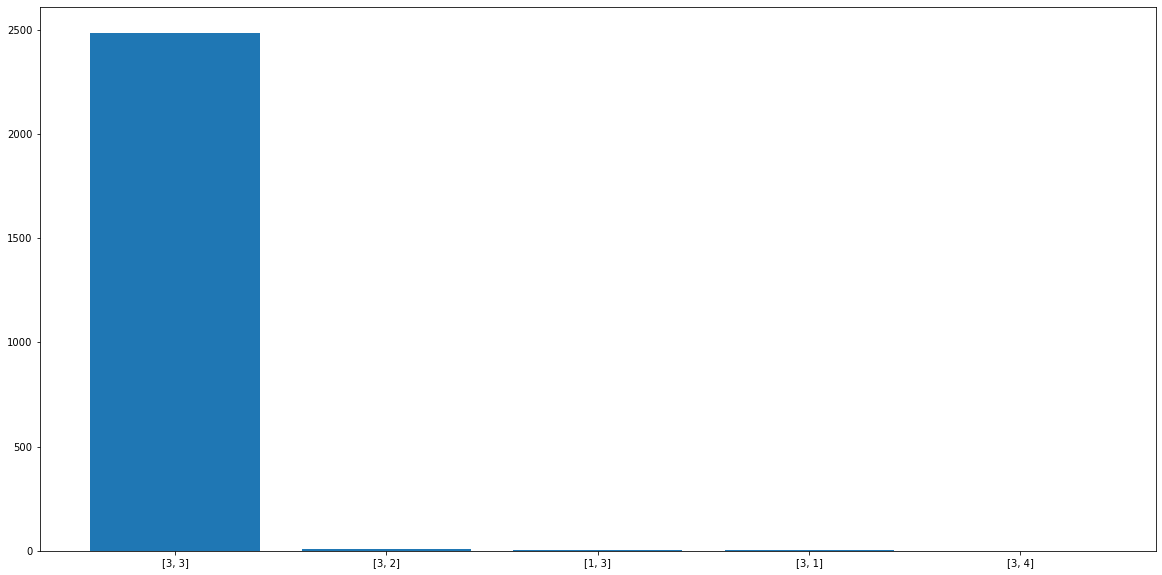

Processing Epoch 211
training start
Iteration 0, d real/fake loss 0.6294748783111572/0.6038554310798645 and g loss is 0.7914000153541565, NDiv loss 0.2897162139415741
Iteration 1, d real/fake loss 0.6290404200553894/0.6030876636505127 and g loss is 0.7938321828842163, NDiv loss 0.20191234350204468
Iteration 2, d real/fake loss 0.6285997629165649/0.6017462015151978 and g loss is 0.7956464886665344, NDiv loss 0.23316174745559692
Iteration 3, d real/fake loss 0.6281535029411316/0.6007121801376343 and g loss is 0.795102596282959, NDiv loss 0.2430427074432373
Iteration 4, d real/fake loss 0.6277018189430237/0.6014446020126343 and g loss is 0.7969956994056702, NDiv loss 0.22416850924491882


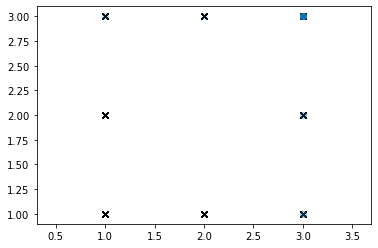

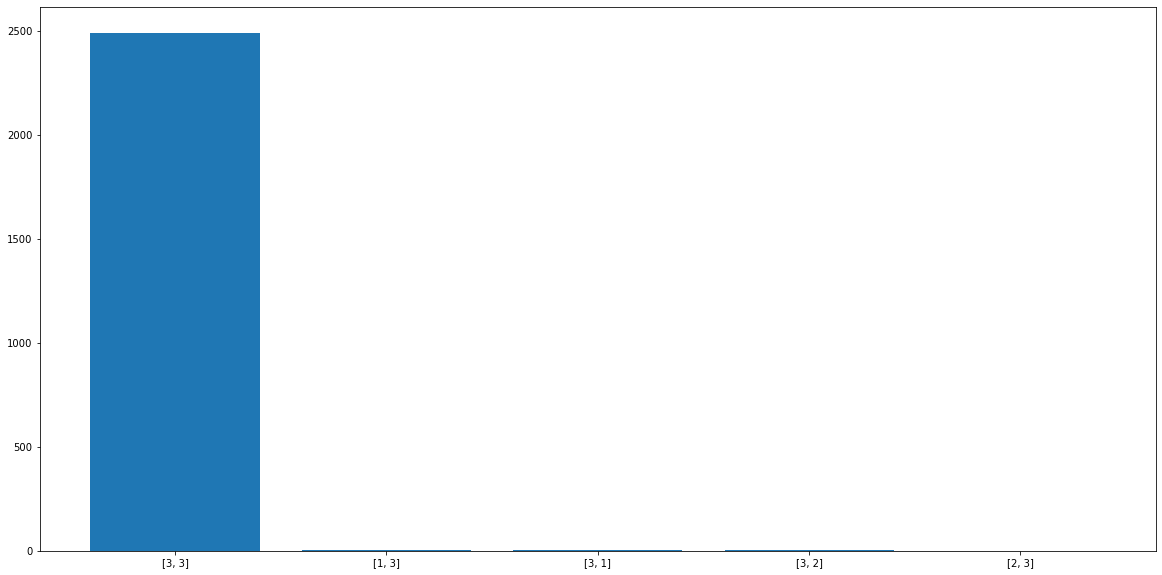

Processing Epoch 212
training start
Iteration 0, d real/fake loss 0.645052433013916/0.5986239910125732 and g loss is 0.799031674861908, NDiv loss 0.21424372494220734
Iteration 1, d real/fake loss 0.6447242498397827/0.5983753800392151 and g loss is 0.8006154894828796, NDiv loss 0.2417849898338318
Iteration 2, d real/fake loss 0.6443848609924316/0.59834885597229 and g loss is 0.802037239074707, NDiv loss 0.22063109278678894
Iteration 3, d real/fake loss 0.6440357565879822/0.5959610939025879 and g loss is 0.8036049604415894, NDiv loss 0.20480304956436157
Iteration 4, d real/fake loss 0.6436774730682373/0.5944200754165649 and g loss is 0.8042958378791809, NDiv loss 0.2047116905450821


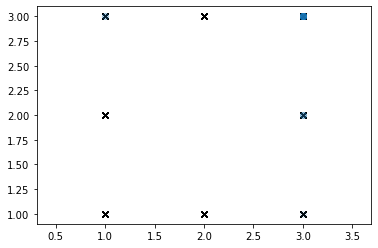

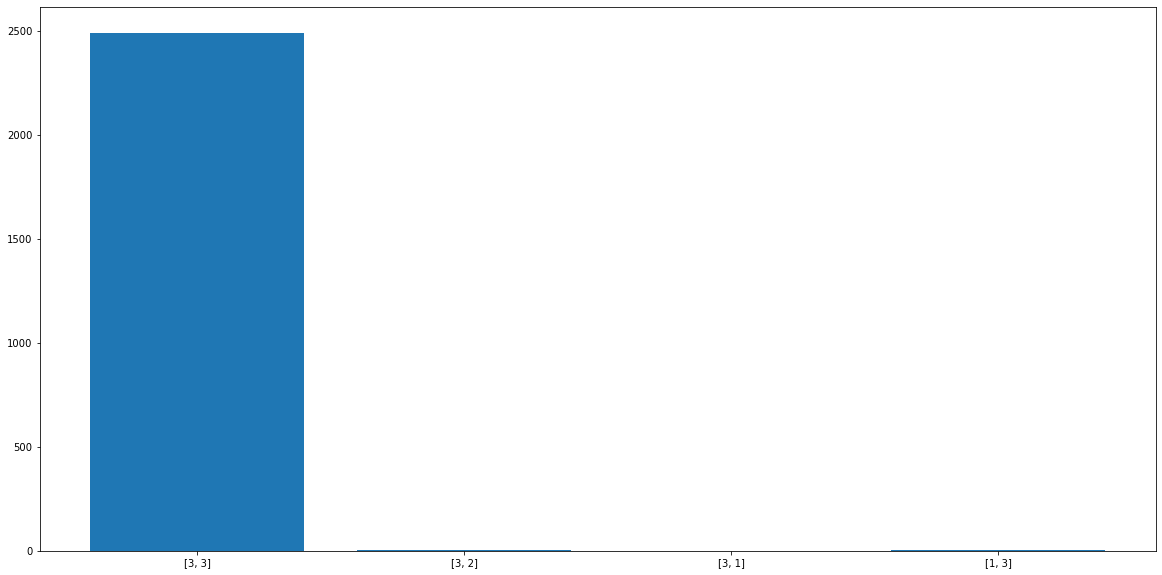

Processing Epoch 213
training start
Iteration 0, d real/fake loss 0.6000657081604004/0.5979424118995667 and g loss is 0.8047840595245361, NDiv loss 0.32003217935562134
Iteration 1, d real/fake loss 0.5996911525726318/0.5926529169082642 and g loss is 0.8067843317985535, NDiv loss 0.2244357466697693
Iteration 2, d real/fake loss 0.5993251800537109/0.592186689376831 and g loss is 0.8069667220115662, NDiv loss 0.24290785193443298
Iteration 3, d real/fake loss 0.5989664793014526/0.5902413129806519 and g loss is 0.808692216873169, NDiv loss 0.22122842073440552
Iteration 4, d real/fake loss 0.5986142754554749/0.5904632806777954 and g loss is 0.8101051449775696, NDiv loss 0.17501585185527802


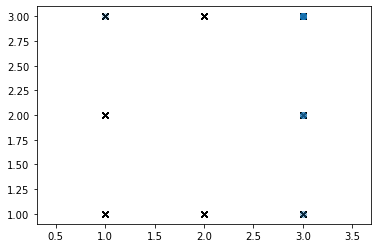

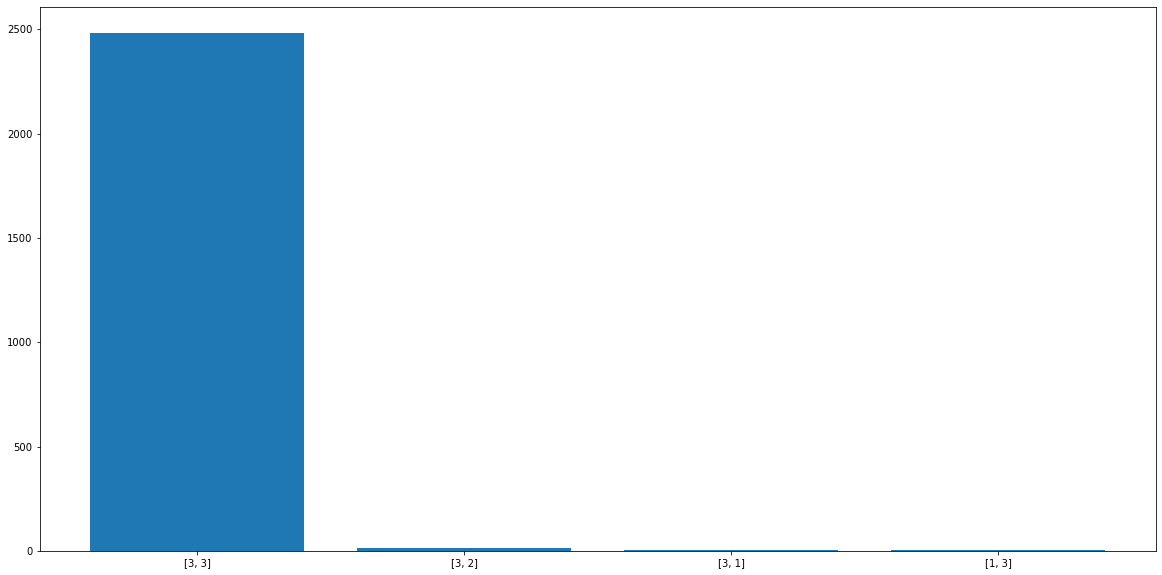

Processing Epoch 214
training start
Iteration 0, d real/fake loss 0.6187933683395386/0.5884805917739868 and g loss is 0.8109418153762817, NDiv loss 0.22985975444316864
Iteration 1, d real/fake loss 0.6184046268463135/0.5882444381713867 and g loss is 0.812567949295044, NDiv loss 0.1753692775964737
Iteration 2, d real/fake loss 0.6180139183998108/0.5870181918144226 and g loss is 0.8141100406646729, NDiv loss 0.24057969450950623
Iteration 3, d real/fake loss 0.6176212430000305/0.5863635540008545 and g loss is 0.8125945329666138, NDiv loss 0.2540106177330017
Iteration 4, d real/fake loss 0.6172267198562622/0.5841711163520813 and g loss is 0.8171991109848022, NDiv loss 0.1737573742866516


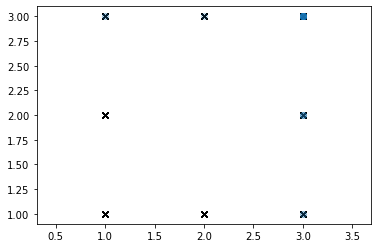

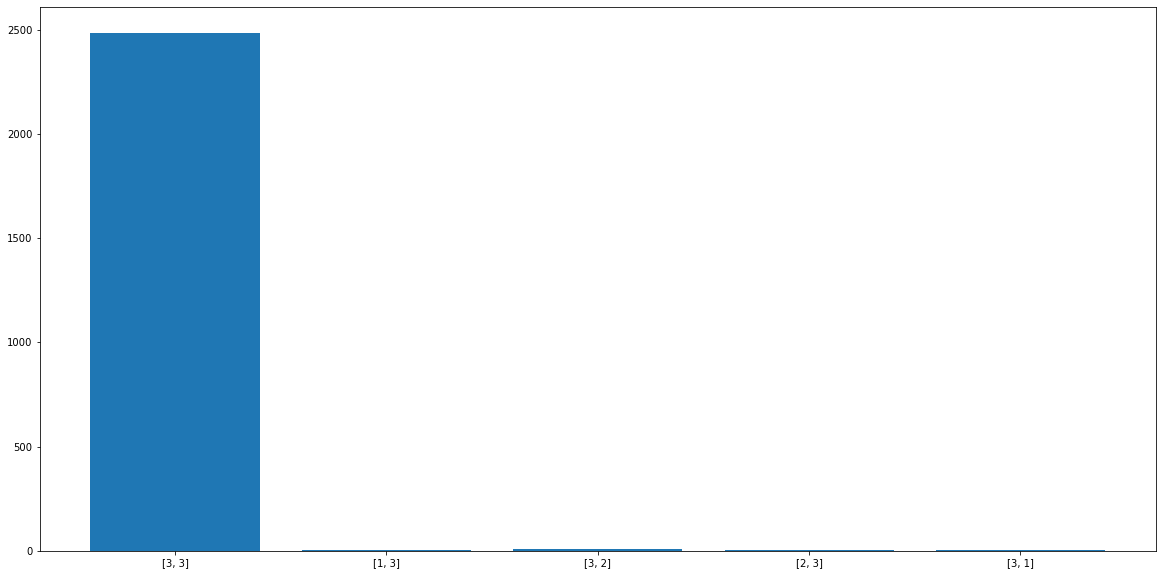

Processing Epoch 215
training start
Iteration 0, d real/fake loss 0.6025483012199402/0.585525393486023 and g loss is 0.8178115487098694, NDiv loss 0.2726353108882904
Iteration 1, d real/fake loss 0.6021754145622253/0.5847011804580688 and g loss is 0.8189103007316589, NDiv loss 0.22894561290740967
Iteration 2, d real/fake loss 0.601805567741394/0.5823030471801758 and g loss is 0.819940447807312, NDiv loss 0.22862482070922852
Iteration 3, d real/fake loss 0.601438045501709/0.5813604593276978 and g loss is 0.8225951194763184, NDiv loss 0.243845134973526
Iteration 4, d real/fake loss 0.6010729074478149/0.578676700592041 and g loss is 0.8231118321418762, NDiv loss 0.22484858334064484


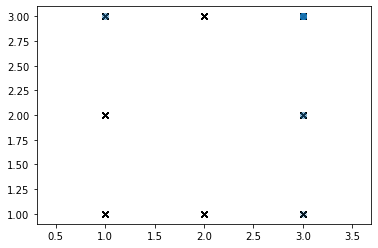

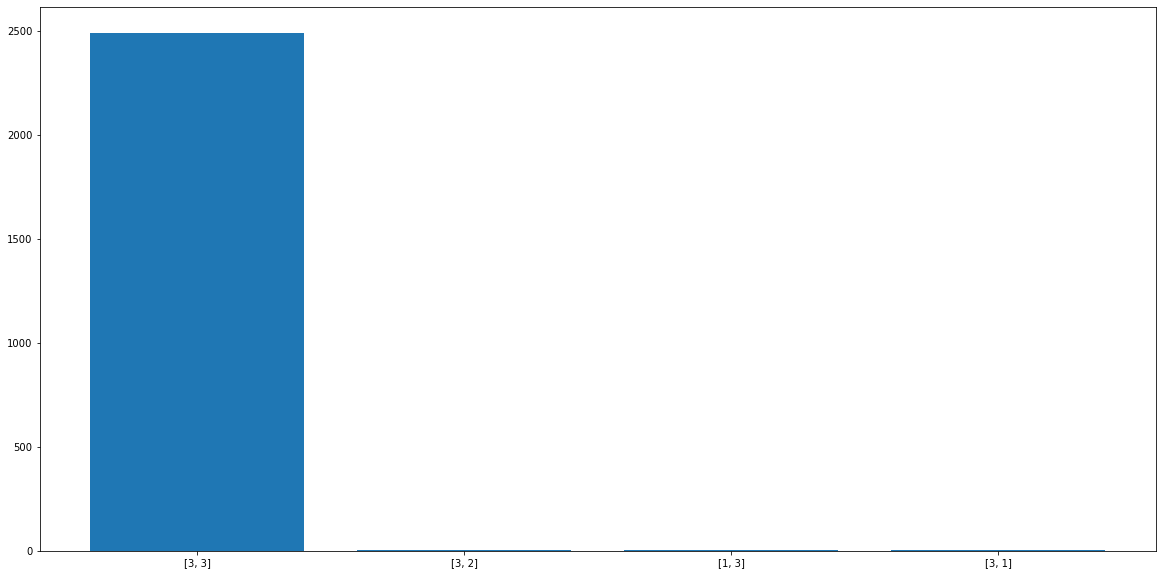

Processing Epoch 216
training start
Iteration 0, d real/fake loss 0.6368985176086426/0.5812207460403442 and g loss is 0.8230000138282776, NDiv loss 0.30930274724960327
Iteration 1, d real/fake loss 0.6365817785263062/0.5774286985397339 and g loss is 0.8235993385314941, NDiv loss 0.2513678967952728
Iteration 2, d real/fake loss 0.6362539529800415/0.5764049887657166 and g loss is 0.8255224227905273, NDiv loss 0.20328198373317719
Iteration 3, d real/fake loss 0.635915994644165/0.5806466341018677 and g loss is 0.8259674906730652, NDiv loss 0.19778327643871307
Iteration 4, d real/fake loss 0.6355707049369812/0.5761749744415283 and g loss is 0.8279894590377808, NDiv loss 0.2044021636247635


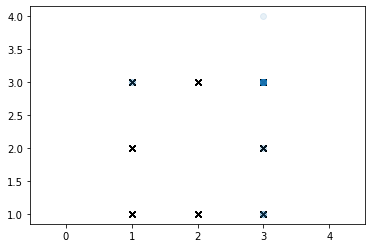

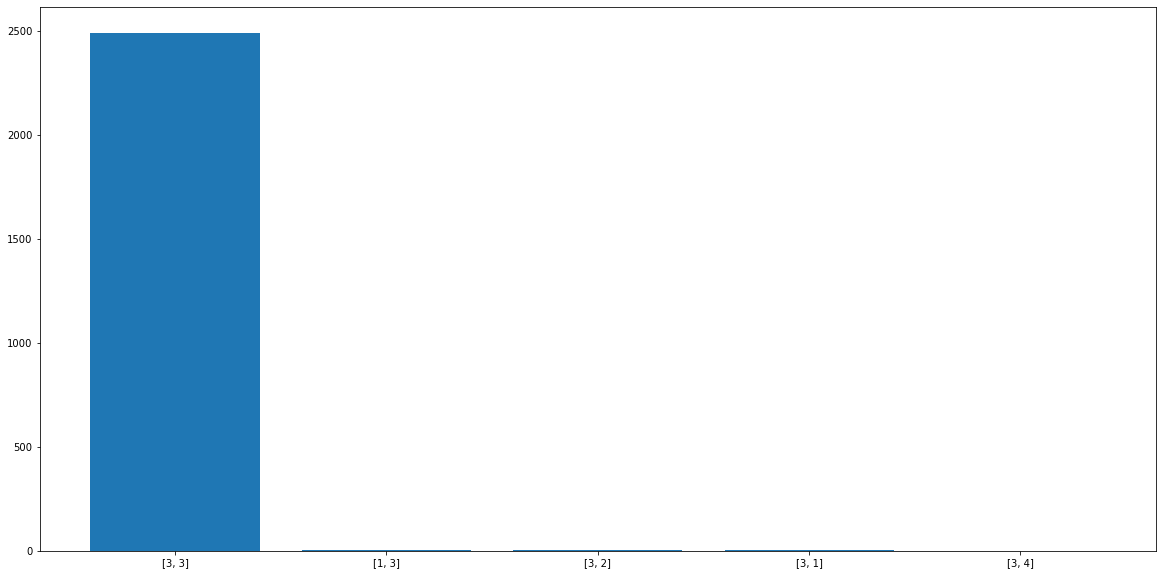

Processing Epoch 217
training start
Iteration 0, d real/fake loss 0.6408377885818481/0.5733596086502075 and g loss is 0.8298643827438354, NDiv loss 0.29902416467666626
Iteration 1, d real/fake loss 0.6403420567512512/0.575198233127594 and g loss is 0.8301690220832825, NDiv loss 0.2760077714920044
Iteration 2, d real/fake loss 0.639830470085144/0.5719648599624634 and g loss is 0.831212043762207, NDiv loss 0.222157821059227
Iteration 3, d real/fake loss 0.6393024921417236/0.5751171112060547 and g loss is 0.8331345319747925, NDiv loss 0.21448823809623718
Iteration 4, d real/fake loss 0.6387616395950317/0.5711092352867126 and g loss is 0.8326467275619507, NDiv loss 0.25295019149780273


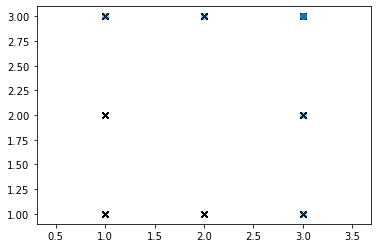

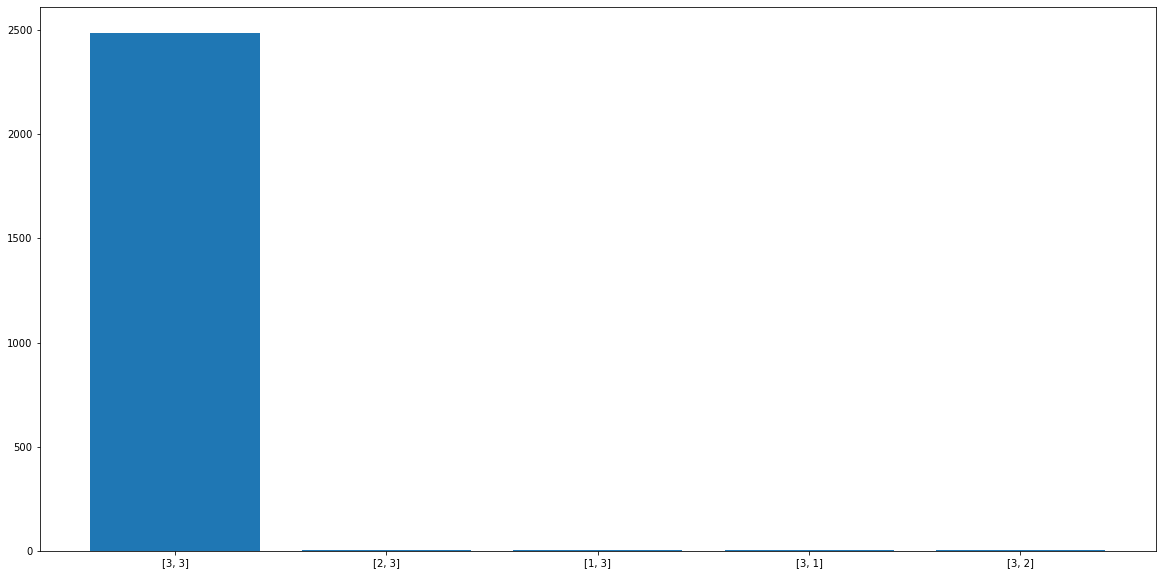

Processing Epoch 218
training start
Iteration 0, d real/fake loss 0.6207369565963745/0.5684511661529541 and g loss is 0.8338233232498169, NDiv loss 0.2648581266403198
Iteration 1, d real/fake loss 0.6201879978179932/0.5680017471313477 and g loss is 0.8372736573219299, NDiv loss 0.274176687002182
Iteration 2, d real/fake loss 0.6196337342262268/0.5688774585723877 and g loss is 0.835854172706604, NDiv loss 0.25577253103256226
Iteration 3, d real/fake loss 0.6190757751464844/0.5673917531967163 and g loss is 0.839958667755127, NDiv loss 0.2818506956100464
Iteration 4, d real/fake loss 0.6185140013694763/0.5649852156639099 and g loss is 0.8399600982666016, NDiv loss 0.2460475116968155


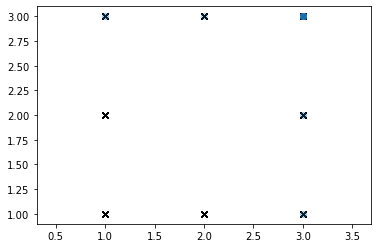

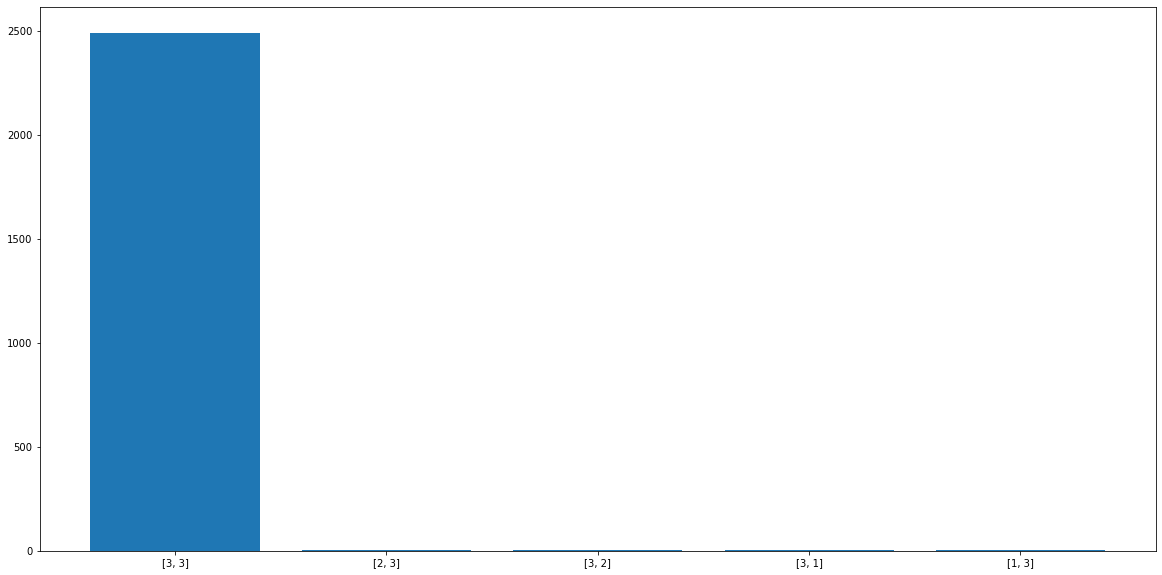

Processing Epoch 219
training start
Iteration 0, d real/fake loss 0.6158754825592041/0.5649933815002441 and g loss is 0.8394619822502136, NDiv loss 0.2229001671075821
Iteration 1, d real/fake loss 0.6153723001480103/0.564071774482727 and g loss is 0.8417956829071045, NDiv loss 0.2504827082157135
Iteration 2, d real/fake loss 0.6148681044578552/0.5639751553535461 and g loss is 0.8433960676193237, NDiv loss 0.26166826486587524
Iteration 3, d real/fake loss 0.6143639087677002/0.5666555166244507 and g loss is 0.8421083092689514, NDiv loss 0.2518962025642395
Iteration 4, d real/fake loss 0.6138620376586914/0.5624527335166931 and g loss is 0.8419849276542664, NDiv loss 0.2716987729072571


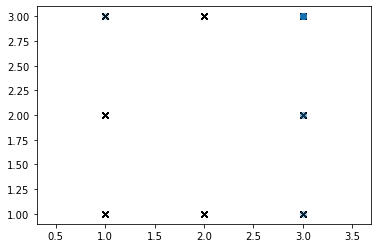

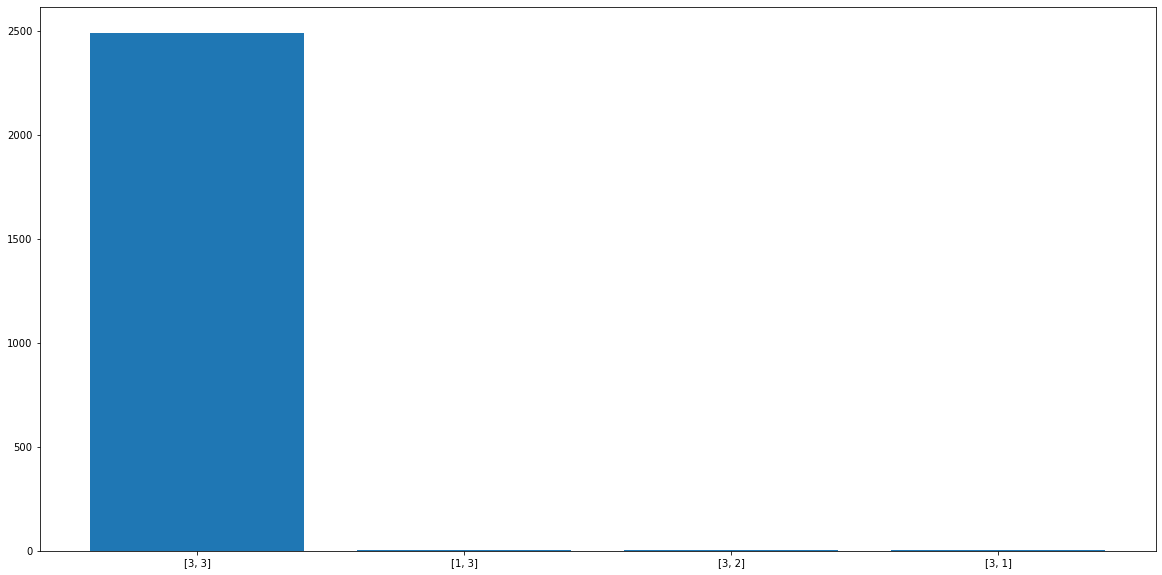

Processing Epoch 220
training start
Iteration 0, d real/fake loss 0.6182945966720581/0.5632443428039551 and g loss is 0.845507025718689, NDiv loss 0.2482788860797882
Iteration 1, d real/fake loss 0.6176252365112305/0.5596152544021606 and g loss is 0.846640944480896, NDiv loss 0.2532447576522827
Iteration 2, d real/fake loss 0.6169498562812805/0.5593597292900085 and g loss is 0.849979817867279, NDiv loss 0.27621138095855713
Iteration 3, d real/fake loss 0.6162697076797485/0.5580573081970215 and g loss is 0.8508421182632446, NDiv loss 0.19899122416973114
Iteration 4, d real/fake loss 0.6155849695205688/0.5563721060752869 and g loss is 0.8518558740615845, NDiv loss 0.3083818256855011


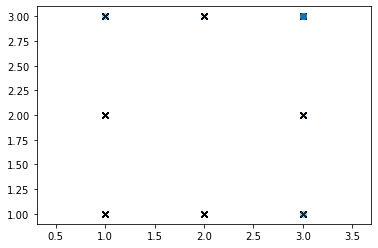

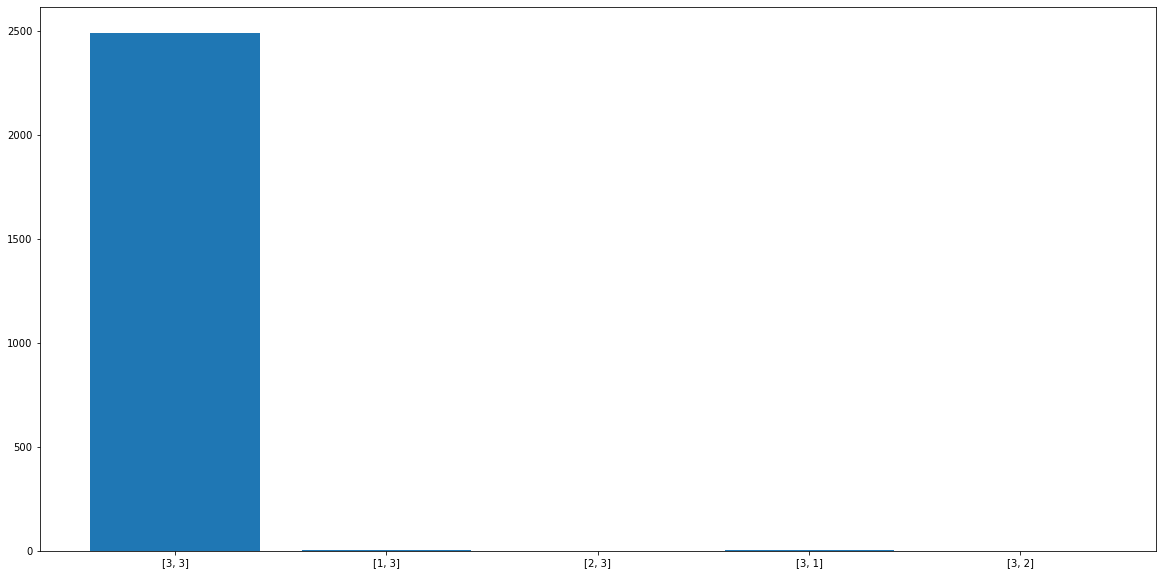

Processing Epoch 221
training start
Iteration 0, d real/fake loss 0.6001181602478027/0.5576622486114502 and g loss is 0.8530440926551819, NDiv loss 0.22058334946632385
Iteration 1, d real/fake loss 0.5995293855667114/0.5573043823242188 and g loss is 0.851909339427948, NDiv loss 0.24700553715229034
Iteration 2, d real/fake loss 0.598942220211029/0.5550334453582764 and g loss is 0.8557695150375366, NDiv loss 0.2766905725002289
Iteration 3, d real/fake loss 0.5983555912971497/0.55368971824646 and g loss is 0.8516178131103516, NDiv loss 0.23862993717193604
Iteration 4, d real/fake loss 0.5977687835693359/0.5520539283752441 and g loss is 0.857310950756073, NDiv loss 0.27465978264808655


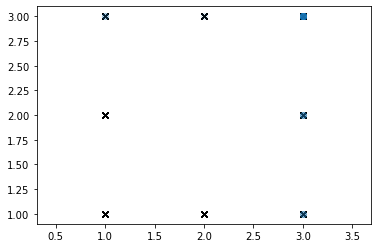

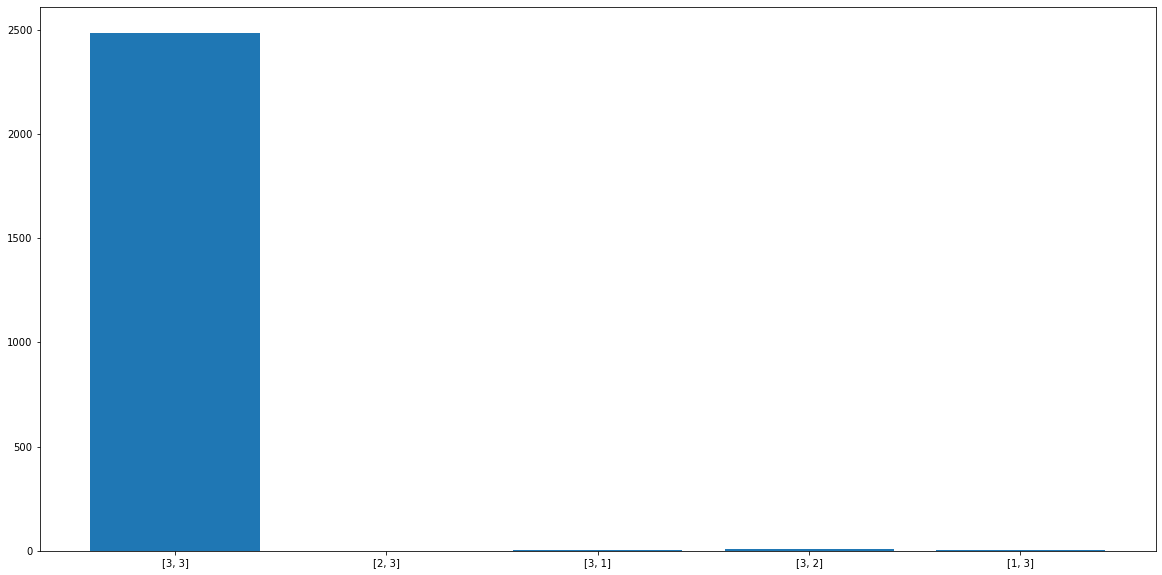

Processing Epoch 222
training start
Iteration 0, d real/fake loss 0.6290637850761414/0.5528637170791626 and g loss is 0.8574303388595581, NDiv loss 0.2032369077205658
Iteration 1, d real/fake loss 0.6285976767539978/0.5507372617721558 and g loss is 0.8582285642623901, NDiv loss 0.20289747416973114
Iteration 2, d real/fake loss 0.6281265616416931/0.5501055121421814 and g loss is 0.859630823135376, NDiv loss 0.27862465381622314
Iteration 3, d real/fake loss 0.6276509165763855/0.5499550700187683 and g loss is 0.8600104451179504, NDiv loss 0.260826051235199
Iteration 4, d real/fake loss 0.6271716356277466/0.5504854917526245 and g loss is 0.8625453114509583, NDiv loss 0.19302615523338318


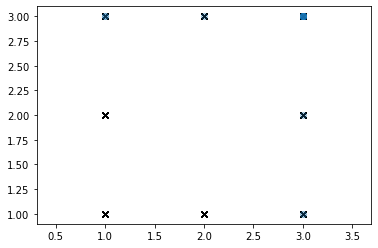

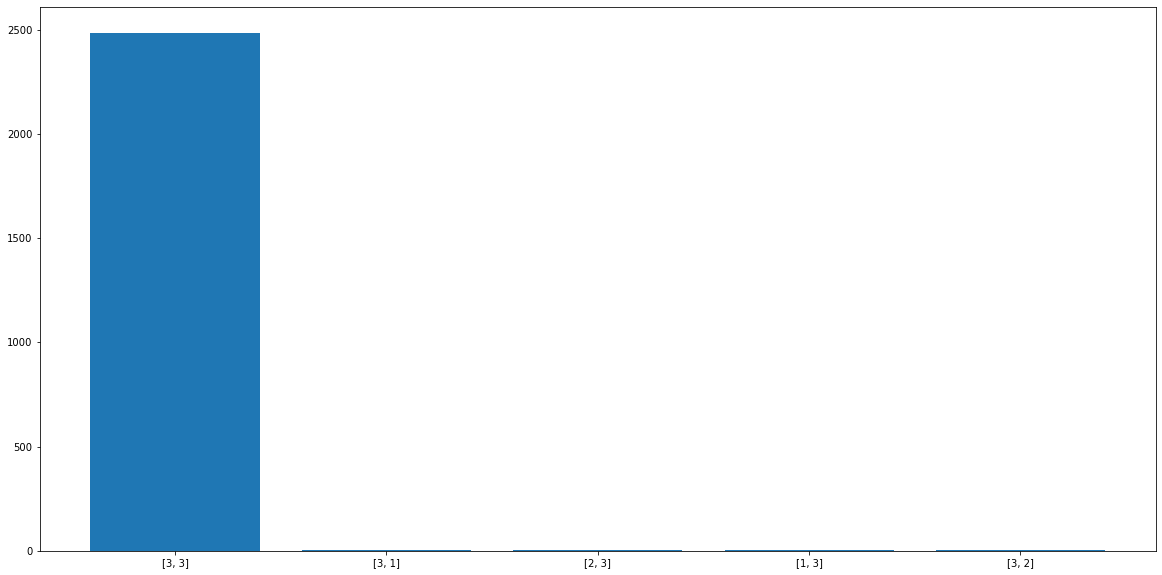

Processing Epoch 223
training start
Iteration 0, d real/fake loss 0.6435288190841675/0.5495023727416992 and g loss is 0.8642080426216125, NDiv loss 0.22303983569145203
Iteration 1, d real/fake loss 0.643061101436615/0.5480408668518066 and g loss is 0.8659716844558716, NDiv loss 0.20826023817062378
Iteration 2, d real/fake loss 0.6425778865814209/0.5452953577041626 and g loss is 0.864547610282898, NDiv loss 0.23789235949516296
Iteration 3, d real/fake loss 0.6420802474021912/0.5450772643089294 and g loss is 0.8654301762580872, NDiv loss 0.23938268423080444
Iteration 4, d real/fake loss 0.641569972038269/0.5491291284561157 and g loss is 0.8667422533035278, NDiv loss 0.21852262318134308


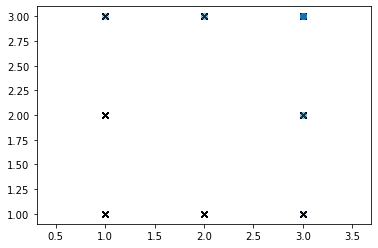

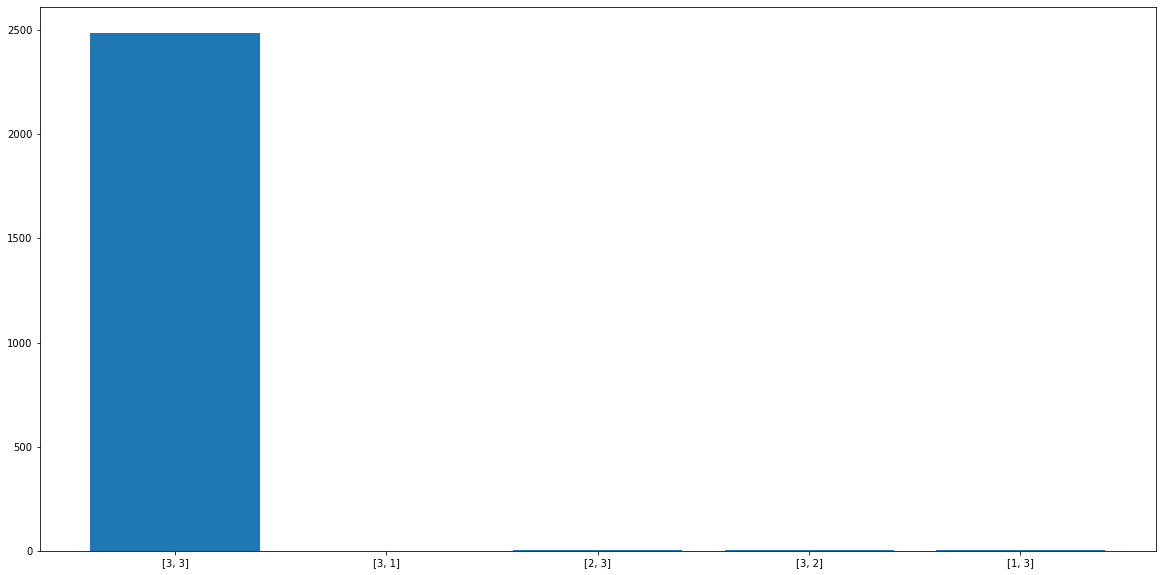

Processing Epoch 224
training start
Iteration 0, d real/fake loss 0.5769615173339844/0.5444427728652954 and g loss is 0.8696180582046509, NDiv loss 0.2610909342765808
Iteration 1, d real/fake loss 0.5764174461364746/0.5498374700546265 and g loss is 0.8693603277206421, NDiv loss 0.1842624694108963
Iteration 2, d real/fake loss 0.5758925676345825/0.5440539717674255 and g loss is 0.870143473148346, NDiv loss 0.2227737158536911
Iteration 3, d real/fake loss 0.5753816366195679/0.5444238185882568 and g loss is 0.8736101984977722, NDiv loss 0.26136747002601624
Iteration 4, d real/fake loss 0.5748840570449829/0.5422635078430176 and g loss is 0.8713365793228149, NDiv loss 0.26561036705970764


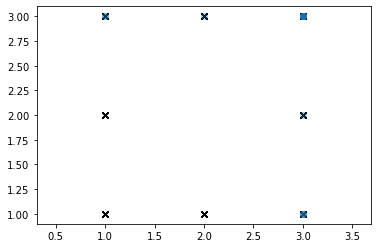

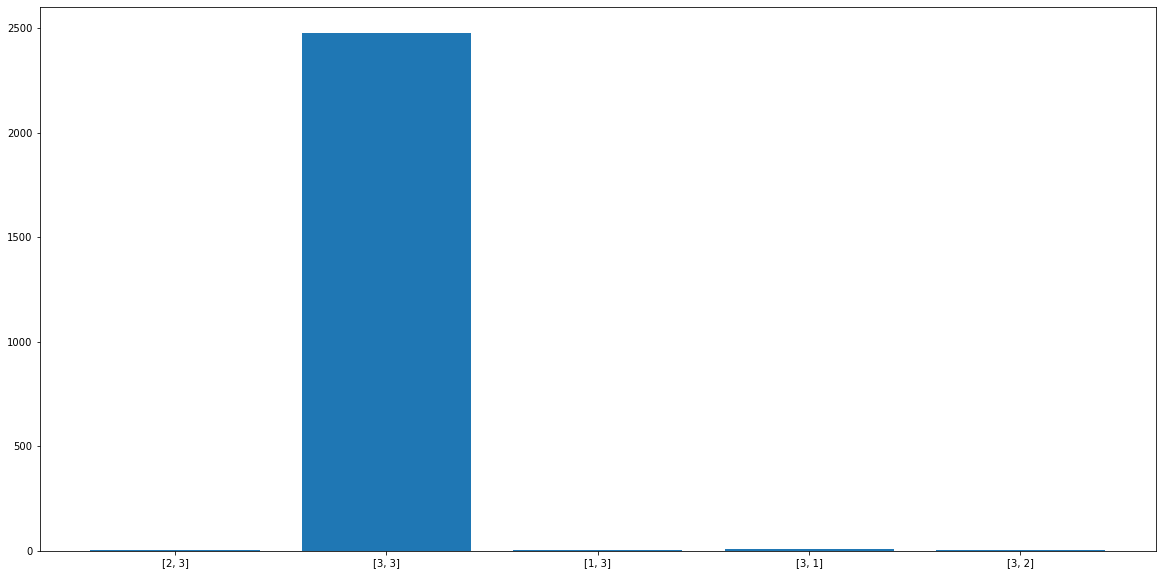

Processing Epoch 225
training start
Iteration 0, d real/fake loss 0.5723906755447388/0.539946973323822 and g loss is 0.8751029968261719, NDiv loss 0.24944552779197693
Iteration 1, d real/fake loss 0.5719730854034424/0.5440225005149841 and g loss is 0.8747142553329468, NDiv loss 0.2782413065433502
Iteration 2, d real/fake loss 0.5715658664703369/0.5430540442466736 and g loss is 0.8750979900360107, NDiv loss 0.20006904006004333
Iteration 3, d real/fake loss 0.5711675882339478/0.5407043695449829 and g loss is 0.8781551718711853, NDiv loss 0.22527433931827545
Iteration 4, d real/fake loss 0.570776641368866/0.5431463122367859 and g loss is 0.8750200867652893, NDiv loss 0.17540760338306427


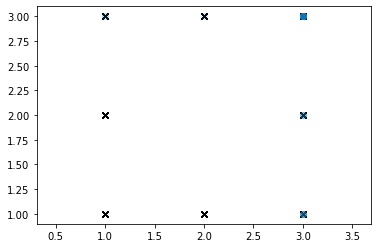

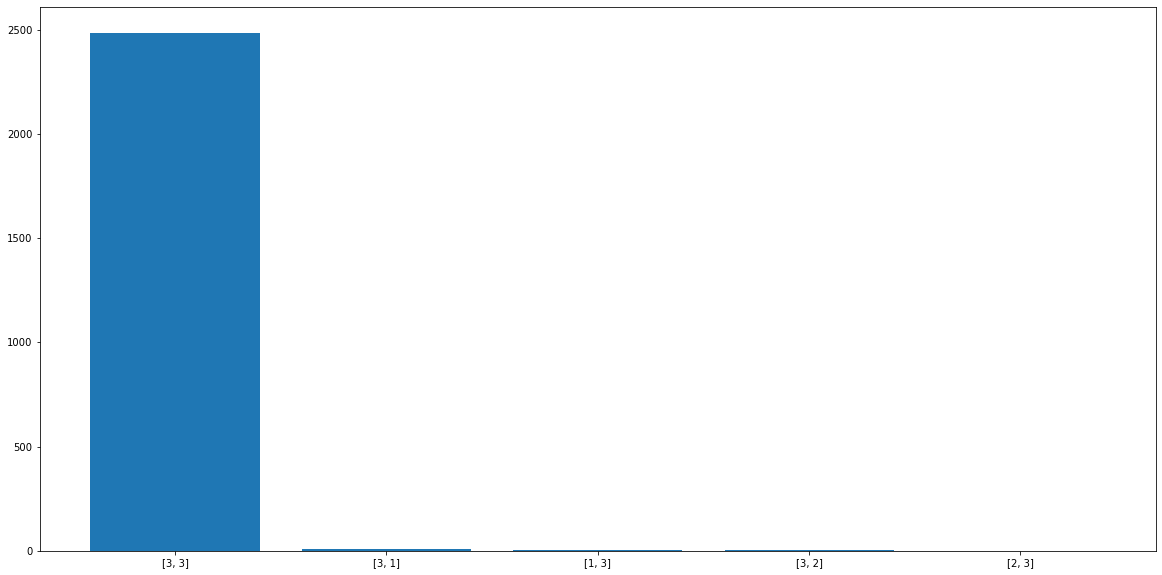

Processing Epoch 226
training start
Iteration 0, d real/fake loss 0.5794469118118286/0.5394952297210693 and g loss is 0.8798936605453491, NDiv loss 0.25672653317451477
Iteration 1, d real/fake loss 0.5790168046951294/0.5358619093894958 and g loss is 0.8805937170982361, NDiv loss 0.20667923986911774
Iteration 2, d real/fake loss 0.5785884261131287/0.5390229821205139 and g loss is 0.8831890821456909, NDiv loss 0.22112293541431427
Iteration 3, d real/fake loss 0.5781632661819458/0.5365688800811768 and g loss is 0.8836336135864258, NDiv loss 0.2864323556423187
Iteration 4, d real/fake loss 0.577740490436554/0.5339000821113586 and g loss is 0.8798074126243591, NDiv loss 0.22542952001094818


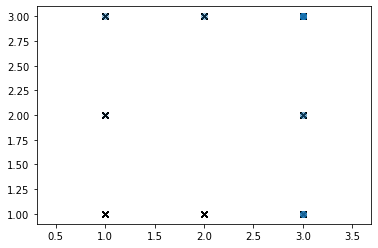

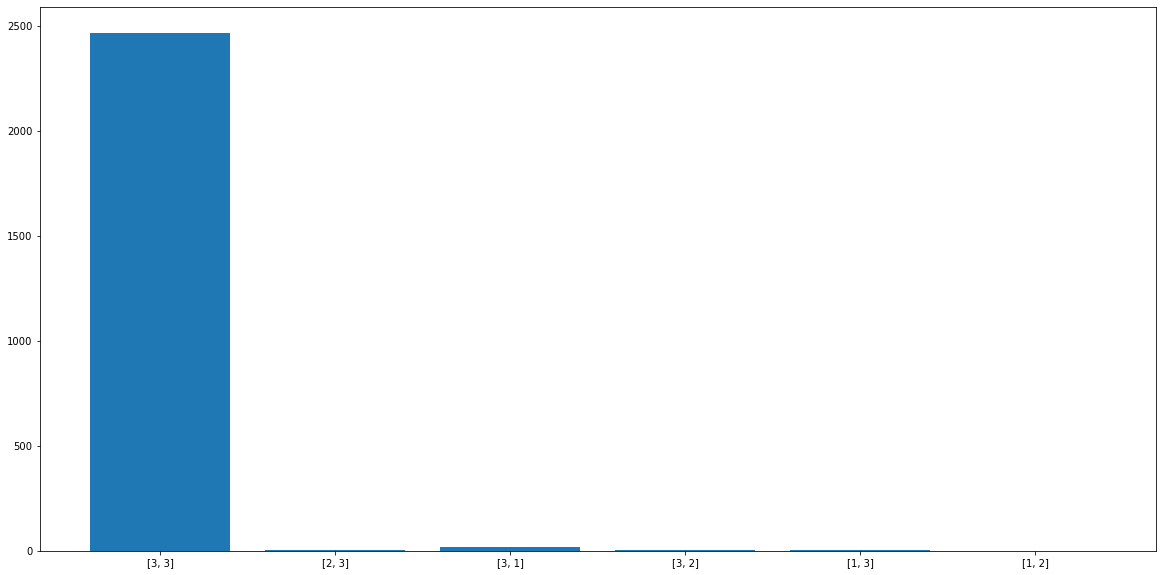

Processing Epoch 227
training start
Iteration 0, d real/fake loss 0.5979692935943604/0.5331681966781616 and g loss is 0.8840989470481873, NDiv loss 0.19277150928974152
Iteration 1, d real/fake loss 0.5976161956787109/0.5310680866241455 and g loss is 0.8876569271087646, NDiv loss 0.297699898481369
Iteration 2, d real/fake loss 0.597256064414978/0.5331941246986389 and g loss is 0.8848001956939697, NDiv loss 0.28201737999916077
Iteration 3, d real/fake loss 0.5968916416168213/0.5334246158599854 and g loss is 0.8877783417701721, NDiv loss 0.24011962115764618
Iteration 4, d real/fake loss 0.5965244770050049/0.5343184471130371 and g loss is 0.8878729343414307, NDiv loss 0.24420928955078125


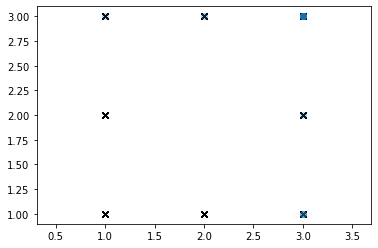

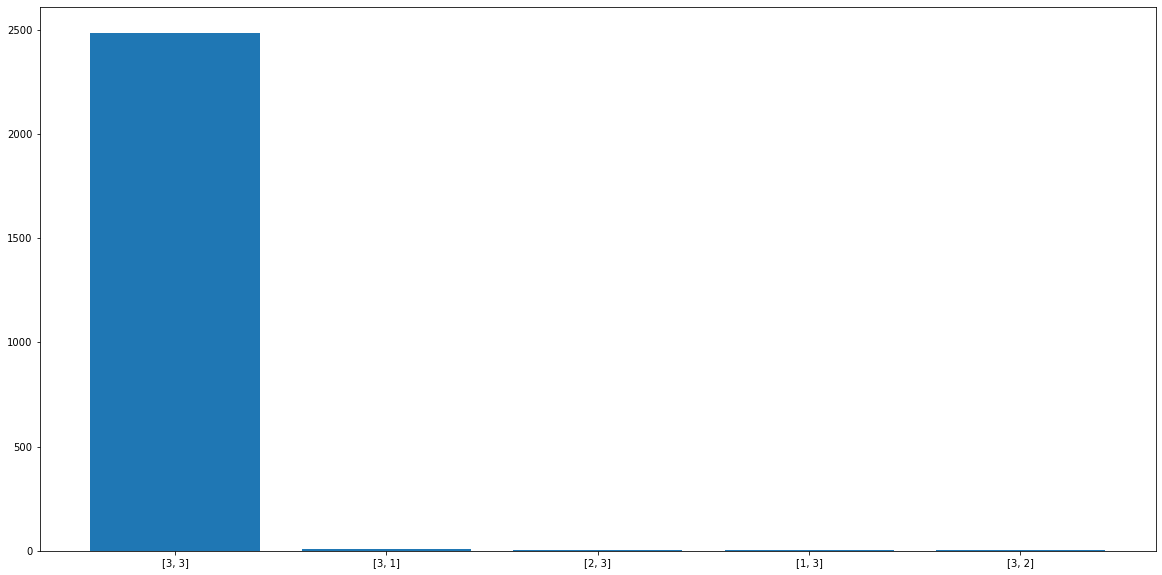

Processing Epoch 228
training start
Iteration 0, d real/fake loss 0.58452969789505/0.5291204452514648 and g loss is 0.8881476521492004, NDiv loss 0.28279995918273926
Iteration 1, d real/fake loss 0.5840545296669006/0.529361367225647 and g loss is 0.890487551689148, NDiv loss 0.2681722939014435
Iteration 2, d real/fake loss 0.5835758447647095/0.5275226831436157 and g loss is 0.8913205862045288, NDiv loss 0.19745078682899475
Iteration 3, d real/fake loss 0.5830929279327393/0.5267277359962463 and g loss is 0.8924537897109985, NDiv loss 0.21970929205417633
Iteration 4, d real/fake loss 0.5826072096824646/0.5268570184707642 and g loss is 0.8969895243644714, NDiv loss 0.25002411007881165


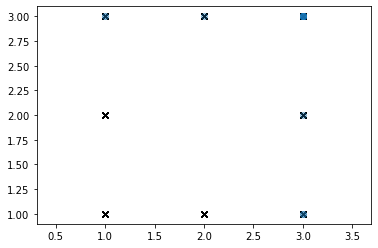

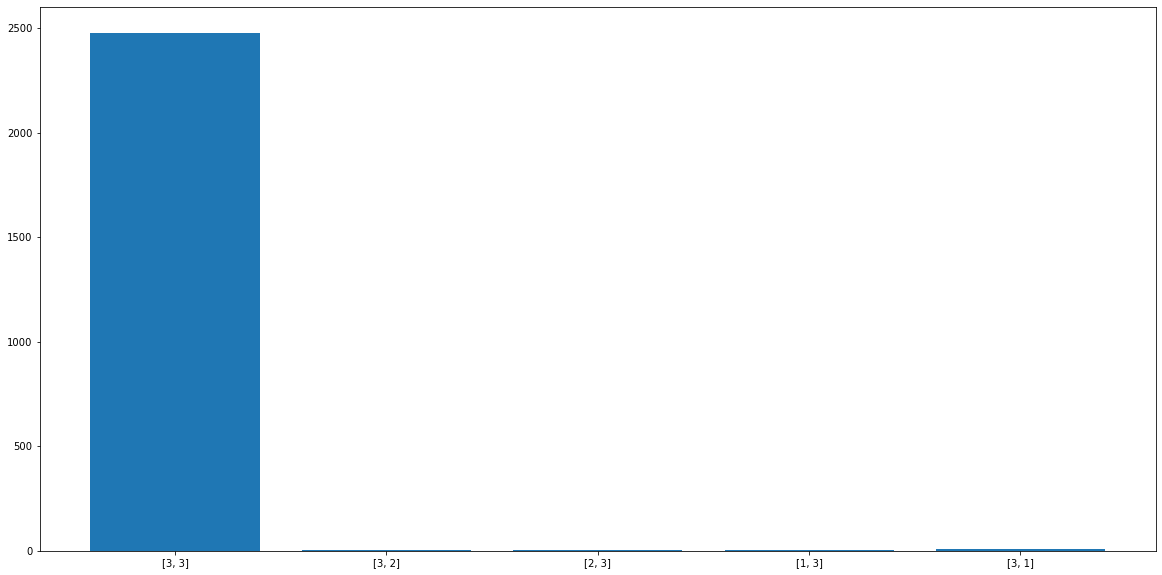

Processing Epoch 229
training start
Iteration 0, d real/fake loss 0.6415705680847168/0.5284762382507324 and g loss is 0.8932344913482666, NDiv loss 0.17654742300510406
Iteration 1, d real/fake loss 0.6411937475204468/0.5267722010612488 and g loss is 0.8925361633300781, NDiv loss 0.22029820084571838
Iteration 2, d real/fake loss 0.6407936215400696/0.5296776294708252 and g loss is 0.898093581199646, NDiv loss 0.19408126175403595
Iteration 3, d real/fake loss 0.6403740644454956/0.5255714058876038 and g loss is 0.8934727907180786, NDiv loss 0.2299601435661316
Iteration 4, d real/fake loss 0.6399363279342651/0.5251749753952026 and g loss is 0.8986716270446777, NDiv loss 0.2555438280105591


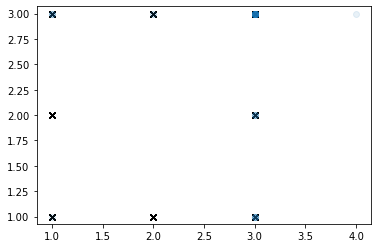

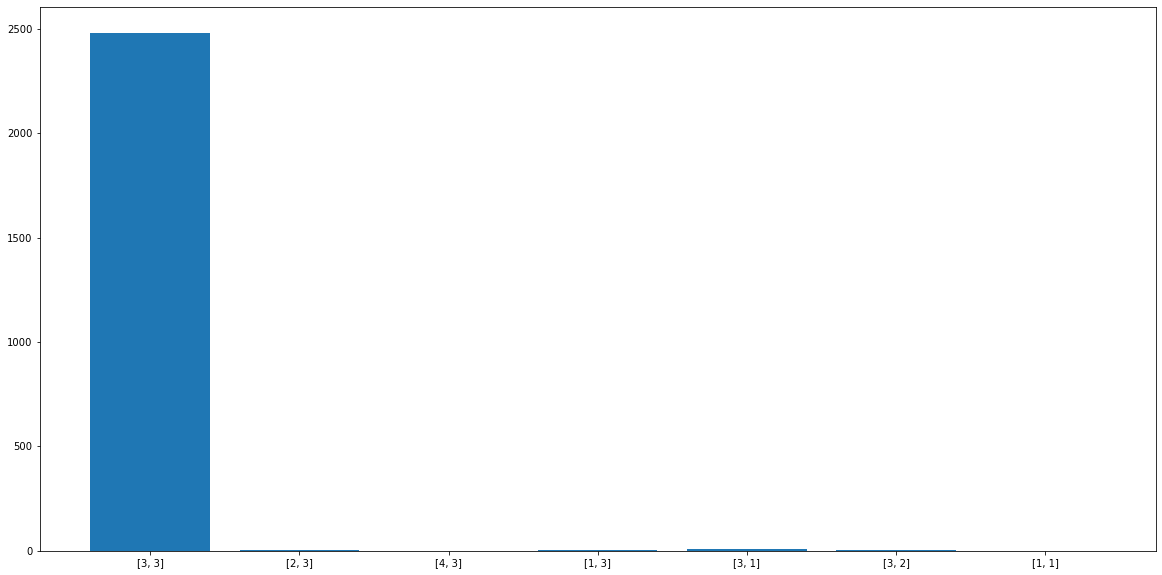

Processing Epoch 230
training start
Iteration 0, d real/fake loss 0.610912561416626/0.5243077874183655 and g loss is 0.8984342813491821, NDiv loss 0.23427803814411163
Iteration 1, d real/fake loss 0.6104713082313538/0.5235727429389954 and g loss is 0.8912276029586792, NDiv loss 0.17919479310512543
Iteration 2, d real/fake loss 0.610024094581604/0.5218566060066223 and g loss is 0.9003103971481323, NDiv loss 0.23615655303001404
Iteration 3, d real/fake loss 0.6095695495605469/0.5216129422187805 and g loss is 0.9015323519706726, NDiv loss 0.20405566692352295
Iteration 4, d real/fake loss 0.6091091632843018/0.5250257253646851 and g loss is 0.9029176235198975, NDiv loss 0.1948079615831375


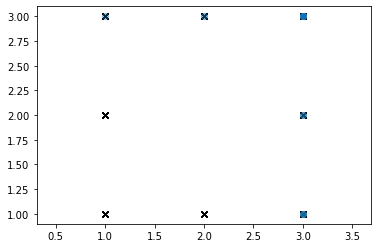

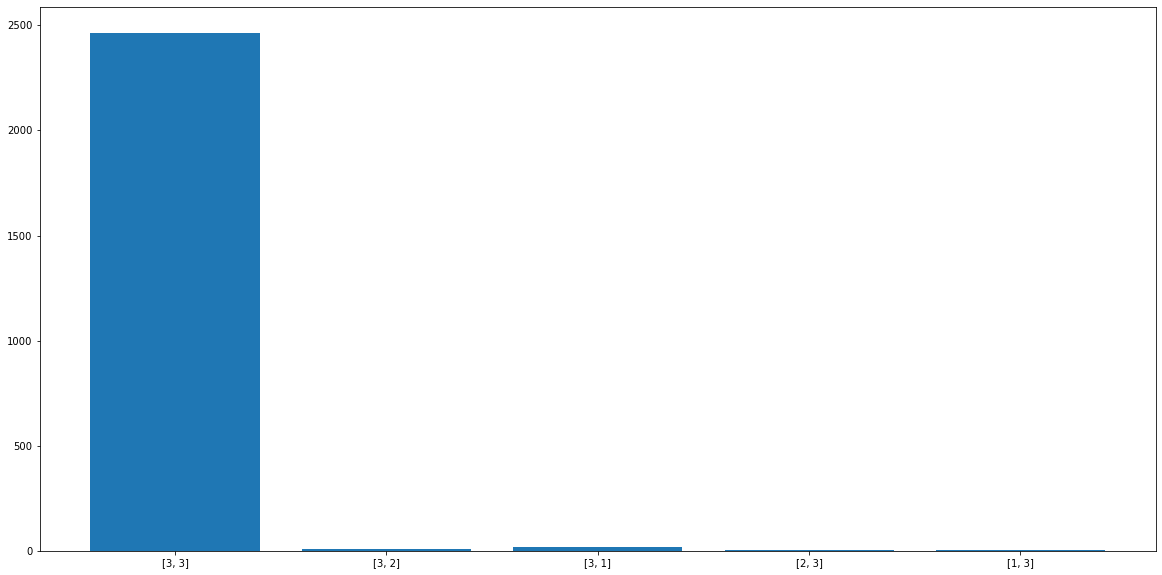

Processing Epoch 231
training start
Iteration 0, d real/fake loss 0.5872771739959717/0.5270098447799683 and g loss is 0.8976451754570007, NDiv loss 0.19942305982112885
Iteration 1, d real/fake loss 0.5867437124252319/0.5209712982177734 and g loss is 0.9020864963531494, NDiv loss 0.22199170291423798
Iteration 2, d real/fake loss 0.5862144827842712/0.5186114311218262 and g loss is 0.8986728191375732, NDiv loss 0.2481411248445511
Iteration 3, d real/fake loss 0.5856888294219971/0.5223982334136963 and g loss is 0.8975253701210022, NDiv loss 0.20777736604213715
Iteration 4, d real/fake loss 0.5851693153381348/0.526297390460968 and g loss is 0.9027675986289978, NDiv loss 0.22752603888511658


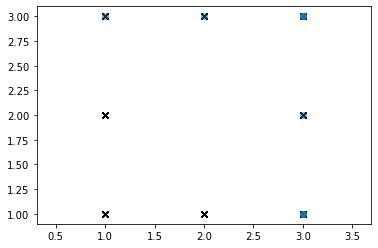

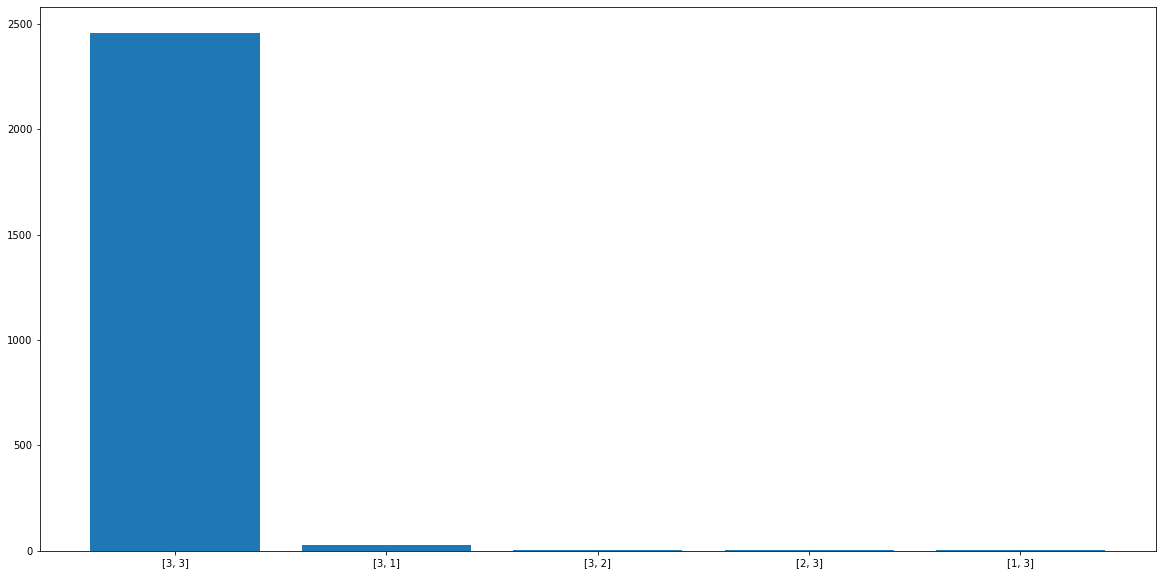

Processing Epoch 232
training start
Iteration 0, d real/fake loss 0.5777510404586792/0.5192712545394897 and g loss is 0.9010463953018188, NDiv loss 0.17417725920677185
Iteration 1, d real/fake loss 0.5772929191589355/0.5249033570289612 and g loss is 0.9087212085723877, NDiv loss 0.20659631490707397
Iteration 2, d real/fake loss 0.5768404006958008/0.5209323167800903 and g loss is 0.89696204662323, NDiv loss 0.24902695417404175
Iteration 3, d real/fake loss 0.5763909220695496/0.5244206190109253 and g loss is 0.9100087881088257, NDiv loss 0.19092264771461487
Iteration 4, d real/fake loss 0.5759478807449341/0.5169823169708252 and g loss is 0.9031982421875, NDiv loss 0.21676523983478546


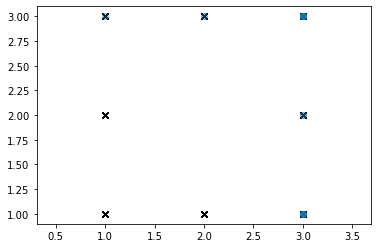

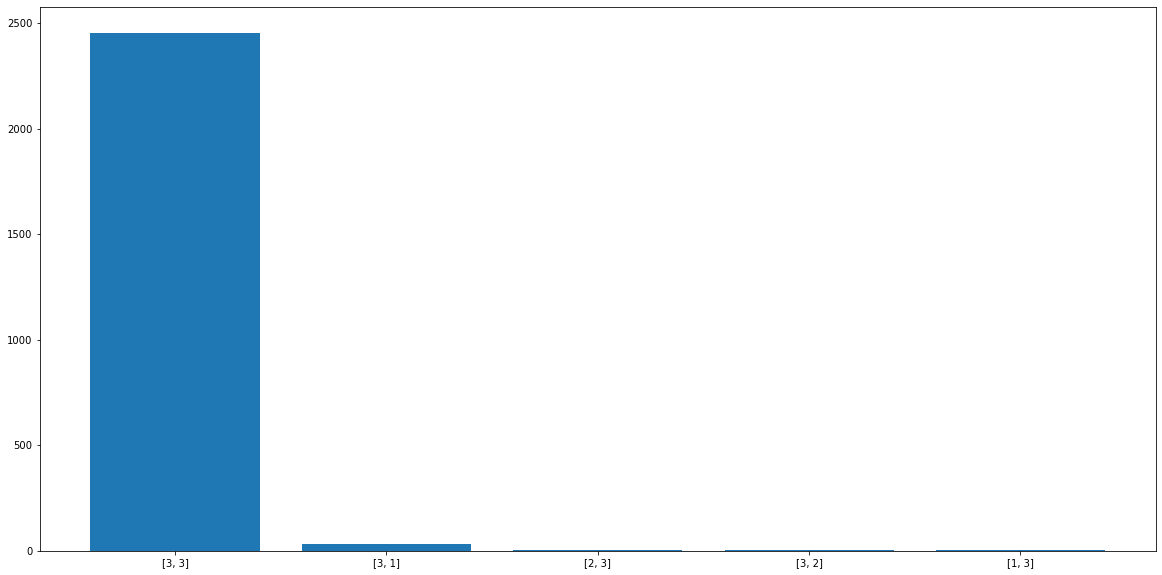

Processing Epoch 233
training start
Iteration 0, d real/fake loss 0.5703946948051453/0.5175430774688721 and g loss is 0.9064110517501831, NDiv loss 0.20207755267620087
Iteration 1, d real/fake loss 0.5700304508209229/0.5156724452972412 and g loss is 0.8938977718353271, NDiv loss 0.22966459393501282
Iteration 2, d real/fake loss 0.5696707963943481/0.5188256502151489 and g loss is 0.9020582437515259, NDiv loss 0.23214472830295563
Iteration 3, d real/fake loss 0.5693179368972778/0.5199095606803894 and g loss is 0.9022728204727173, NDiv loss 0.21870176494121552
Iteration 4, d real/fake loss 0.5689722299575806/0.5195977687835693 and g loss is 0.9018514156341553, NDiv loss 0.21359358727931976


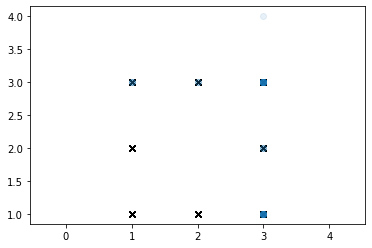

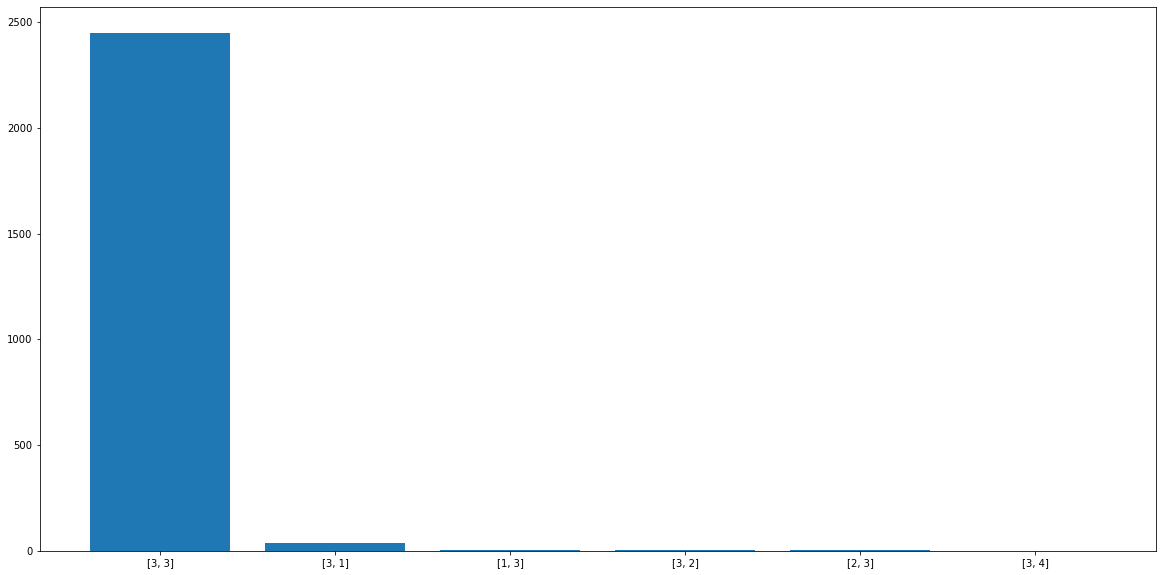

Processing Epoch 234
training start
Iteration 0, d real/fake loss 0.5843334197998047/0.531403124332428 and g loss is 0.9015381336212158, NDiv loss 0.18681305646896362
Iteration 1, d real/fake loss 0.5840083956718445/0.5227834582328796 and g loss is 0.9032862782478333, NDiv loss 0.17109647393226624
Iteration 2, d real/fake loss 0.5836894512176514/0.5197458863258362 and g loss is 0.9049248695373535, NDiv loss 0.18595829606056213
Iteration 3, d real/fake loss 0.5833740234375/0.5272246599197388 and g loss is 0.9049179553985596, NDiv loss 0.20758460462093353
Iteration 4, d real/fake loss 0.5830658078193665/0.5157105922698975 and g loss is 0.8998488187789917, NDiv loss 0.19023442268371582


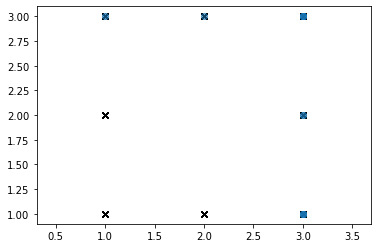

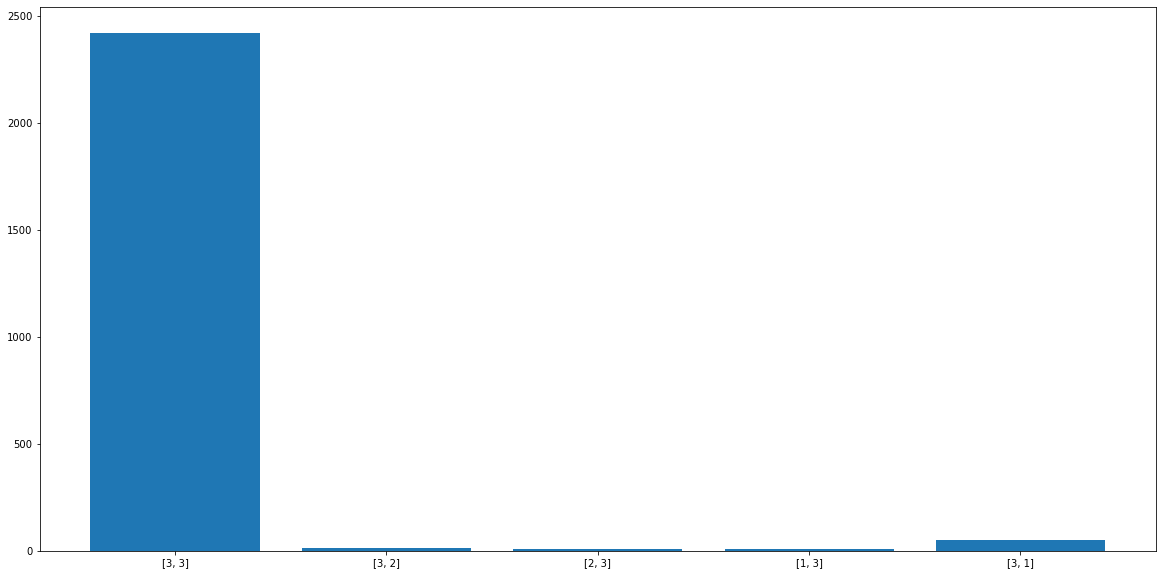

Processing Epoch 235
training start
Iteration 0, d real/fake loss 0.5845297574996948/0.5213345289230347 and g loss is 0.8948588371276855, NDiv loss 0.18175673484802246
Iteration 1, d real/fake loss 0.5841890573501587/0.5194430947303772 and g loss is 0.9070249199867249, NDiv loss 0.21817585825920105
Iteration 2, d real/fake loss 0.5838445425033569/0.5292960405349731 and g loss is 0.8993241190910339, NDiv loss 0.1921963095664978
Iteration 3, d real/fake loss 0.583503782749176/0.5276815295219421 and g loss is 0.9022950530052185, NDiv loss 0.18997418880462646
Iteration 4, d real/fake loss 0.5831641554832458/0.5279591679573059 and g loss is 0.9032472372055054, NDiv loss 0.15547984838485718


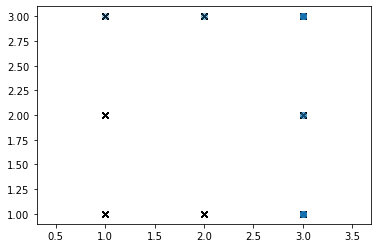

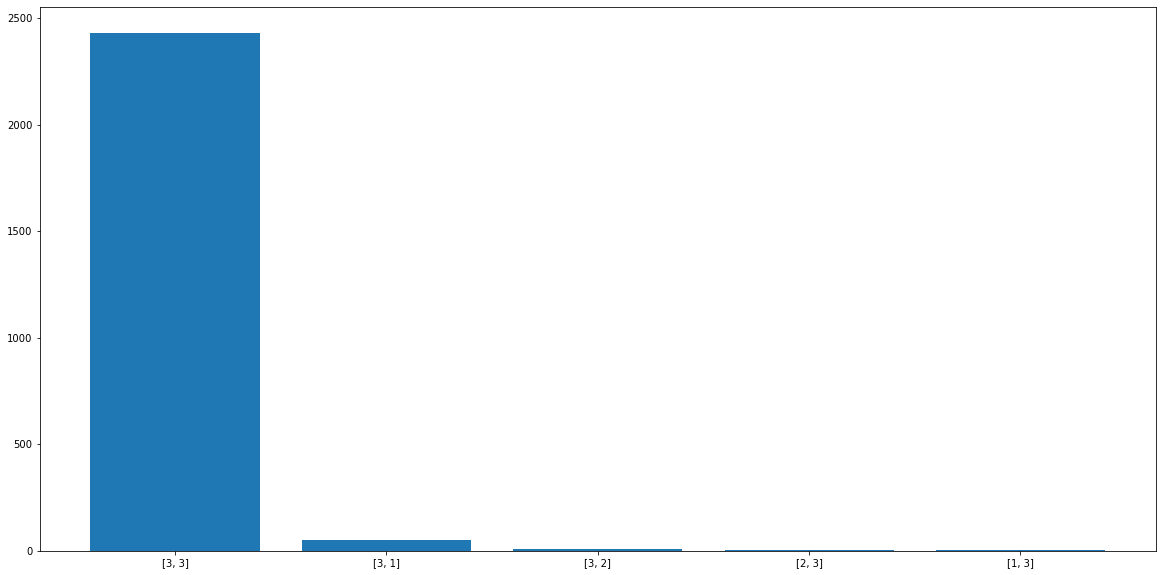

Processing Epoch 236
training start
Iteration 0, d real/fake loss 0.6030993461608887/0.535567045211792 and g loss is 0.8901868462562561, NDiv loss 0.2093965709209442
Iteration 1, d real/fake loss 0.60276859998703/0.5353176593780518 and g loss is 0.9040453433990479, NDiv loss 0.2024722546339035
Iteration 2, d real/fake loss 0.6024389266967773/0.548053503036499 and g loss is 0.9000685214996338, NDiv loss 0.15518540143966675
Iteration 3, d real/fake loss 0.6021169424057007/0.5351160764694214 and g loss is 0.9007311463356018, NDiv loss 0.1857878565788269
Iteration 4, d real/fake loss 0.6017963886260986/0.5243917107582092 and g loss is 0.8858457207679749, NDiv loss 0.1955786943435669


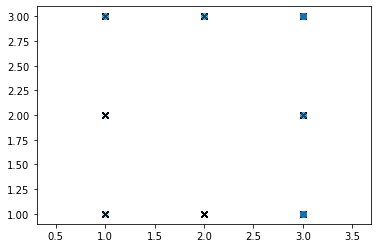

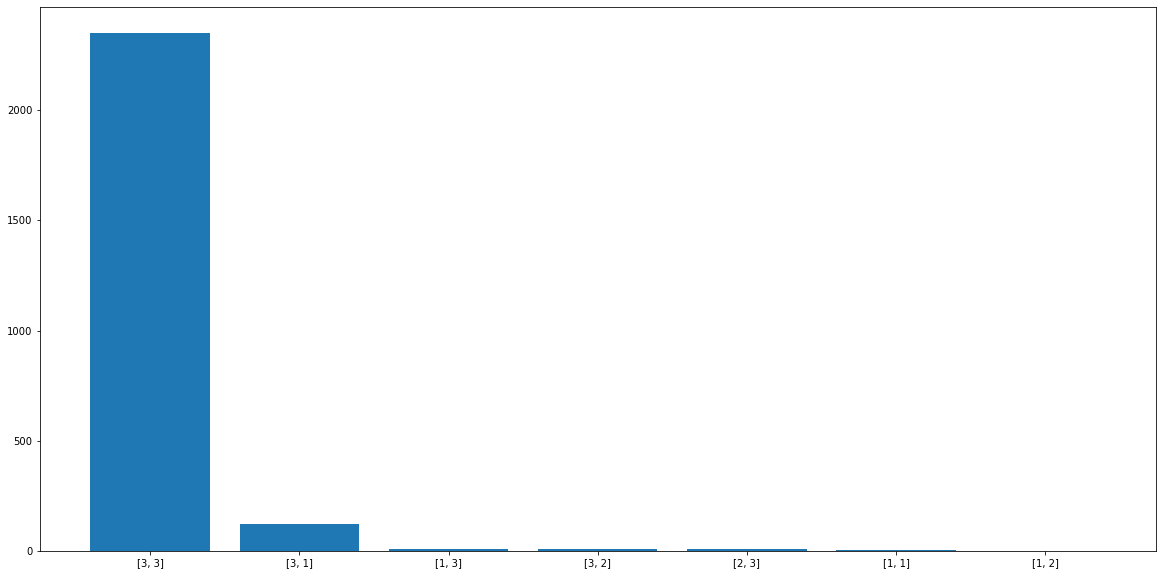

Processing Epoch 237
training start
Iteration 0, d real/fake loss 0.5521377921104431/0.5347384810447693 and g loss is 0.8856278657913208, NDiv loss 0.17898142337799072
Iteration 1, d real/fake loss 0.5517946481704712/0.5324207544326782 and g loss is 0.9056239724159241, NDiv loss 0.16204513609409332
Iteration 2, d real/fake loss 0.5514694452285767/0.544743001461029 and g loss is 0.8882634043693542, NDiv loss 0.15500983595848083
Iteration 3, d real/fake loss 0.5511661767959595/0.5469317436218262 and g loss is 0.8839151263237, NDiv loss 0.17021529376506805
Iteration 4, d real/fake loss 0.5508857369422913/0.5447184443473816 and g loss is 0.8843381404876709, NDiv loss 0.1809358298778534


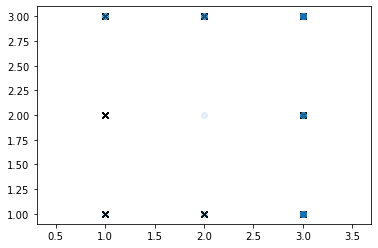

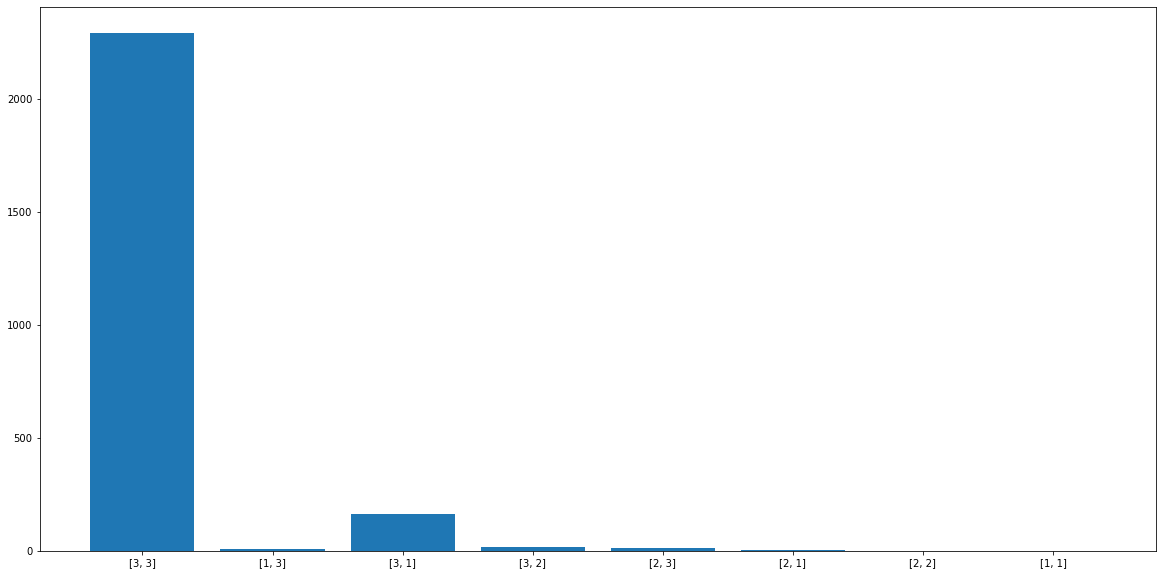

Processing Epoch 238
training start
Iteration 0, d real/fake loss 0.5708686709403992/0.5493354797363281 and g loss is 0.877984344959259, NDiv loss 0.15914440155029297
Iteration 1, d real/fake loss 0.5706390142440796/0.5355981588363647 and g loss is 0.8643827438354492, NDiv loss 0.1712990254163742
Iteration 2, d real/fake loss 0.5704126954078674/0.5467828512191772 and g loss is 0.8551221489906311, NDiv loss 0.14368966221809387
Iteration 3, d real/fake loss 0.5701963901519775/0.5605305433273315 and g loss is 0.8621695041656494, NDiv loss 0.1613582819700241
Iteration 4, d real/fake loss 0.5699964761734009/0.5844905376434326 and g loss is 0.853710412979126, NDiv loss 0.12518100440502167


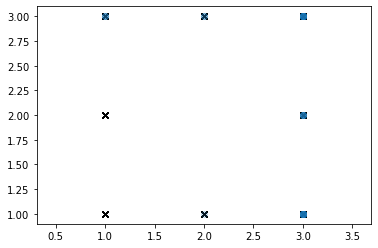

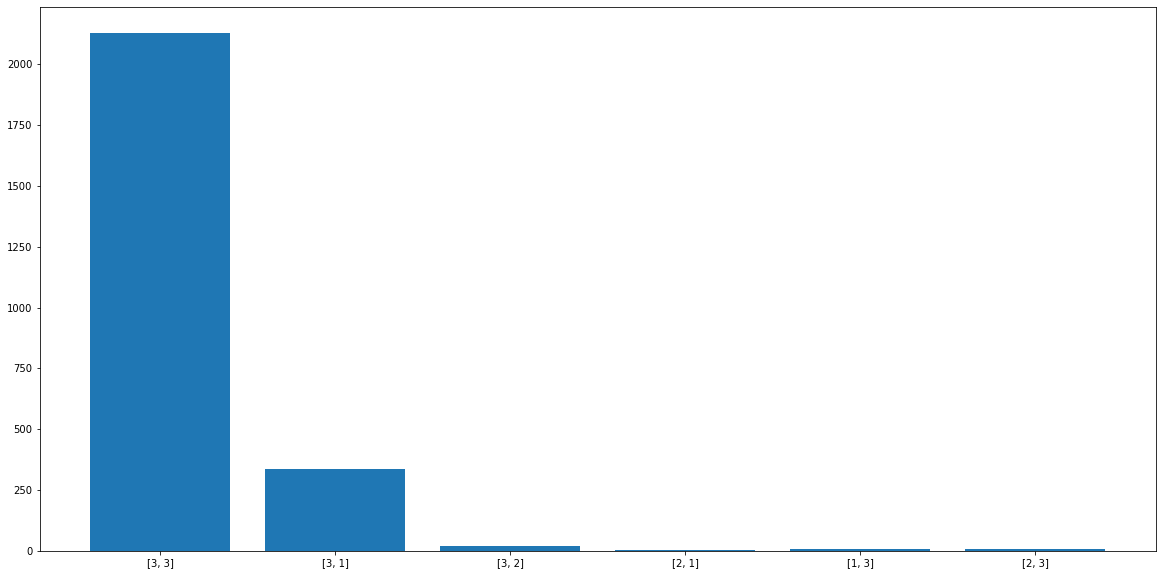

Processing Epoch 239
training start
Iteration 0, d real/fake loss 0.5886684060096741/0.5682661533355713 and g loss is 0.8548597097396851, NDiv loss 0.14242766797542572
Iteration 1, d real/fake loss 0.5885781049728394/0.5828397870063782 and g loss is 0.8170560002326965, NDiv loss 0.15217885375022888
Iteration 2, d real/fake loss 0.5885015726089478/0.5872820615768433 and g loss is 0.8223167061805725, NDiv loss 0.13799439370632172
Iteration 3, d real/fake loss 0.58843994140625/0.5949506759643555 and g loss is 0.8242526054382324, NDiv loss 0.13471932709217072
Iteration 4, d real/fake loss 0.5883985161781311/0.5914103984832764 and g loss is 0.8216557502746582, NDiv loss 0.13157236576080322


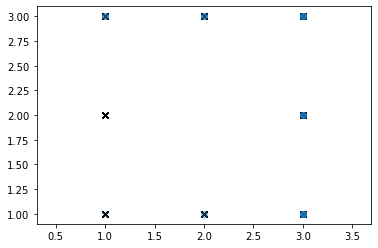

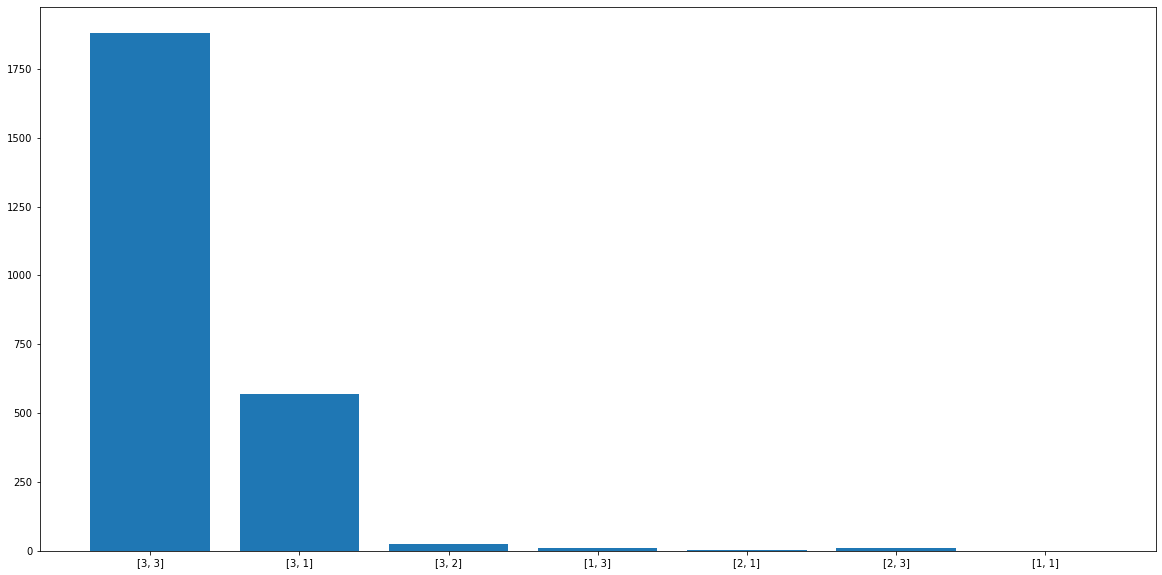

Processing Epoch 240
training start
Iteration 0, d real/fake loss 0.5442154407501221/0.62067049741745 and g loss is 0.8094447255134583, NDiv loss 0.12408924847841263
Iteration 1, d real/fake loss 0.5440717935562134/0.5984475612640381 and g loss is 0.7918069362640381, NDiv loss 0.1308426856994629
Iteration 2, d real/fake loss 0.5439543724060059/0.654678225517273 and g loss is 0.7669528722763062, NDiv loss 0.12419970333576202
Iteration 3, d real/fake loss 0.5438896417617798/0.6395065784454346 and g loss is 0.7504301071166992, NDiv loss 0.1275729089975357
Iteration 4, d real/fake loss 0.5438637733459473/0.6481253504753113 and g loss is 0.7533544898033142, NDiv loss 0.11771968752145767


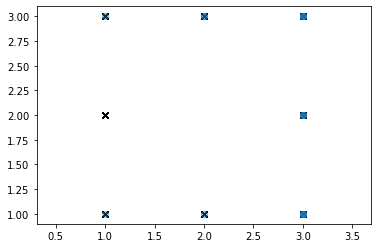

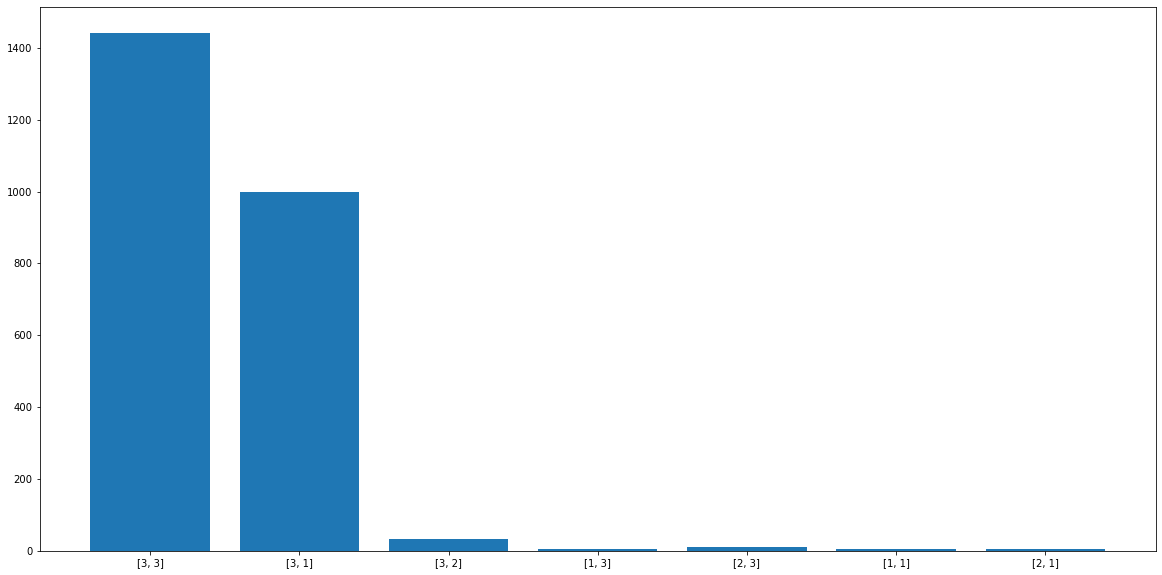

Processing Epoch 241
training start
Iteration 0, d real/fake loss 0.6007998585700989/0.6552021503448486 and g loss is 0.7256909608840942, NDiv loss 0.11310161650180817
Iteration 1, d real/fake loss 0.6010260581970215/0.6651197671890259 and g loss is 0.7206711769104004, NDiv loss 0.11982966959476471
Iteration 2, d real/fake loss 0.601273775100708/0.710398256778717 and g loss is 0.7072874307632446, NDiv loss 0.12168808281421661
Iteration 3, d real/fake loss 0.6015658378601074/0.6906945109367371 and g loss is 0.7029541730880737, NDiv loss 0.12307963520288467
Iteration 4, d real/fake loss 0.6018878817558289/0.717984676361084 and g loss is 0.6729857921600342, NDiv loss 0.11145635694265366


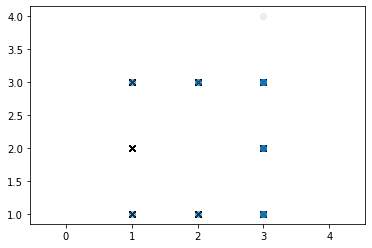

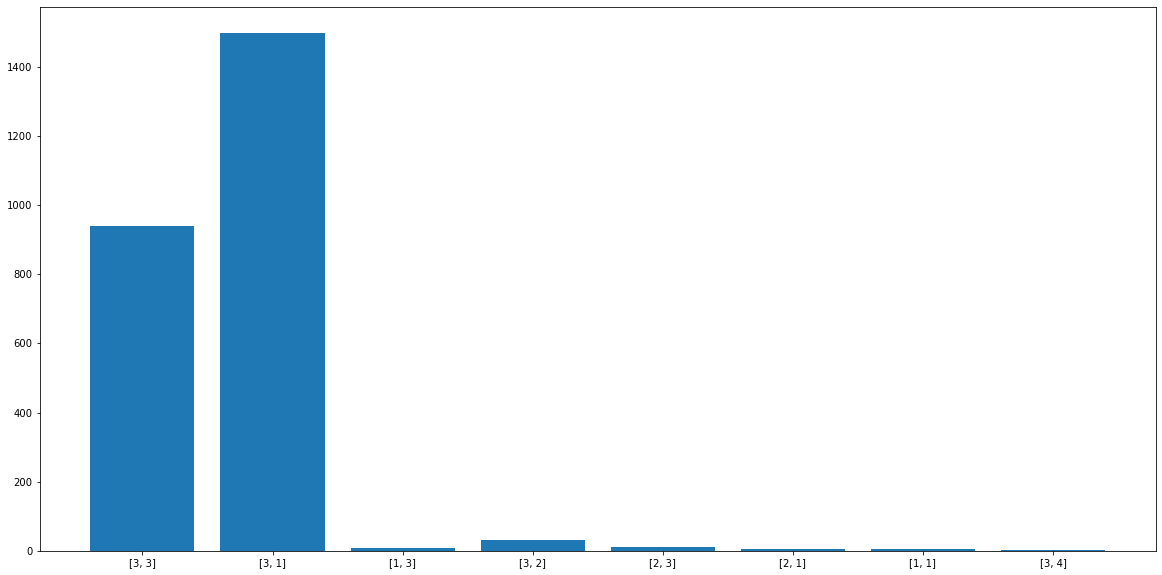

Processing Epoch 242
training start
Iteration 0, d real/fake loss 0.5685403347015381/0.7385768294334412 and g loss is 0.6793472766876221, NDiv loss 0.11662370711565018
Iteration 1, d real/fake loss 0.5688681602478027/0.7876767516136169 and g loss is 0.6706207990646362, NDiv loss 0.11829176545143127
Iteration 2, d real/fake loss 0.5692636966705322/0.7788625955581665 and g loss is 0.6514663696289062, NDiv loss 0.12412410974502563
Iteration 3, d real/fake loss 0.5697153806686401/0.7661329507827759 and g loss is 0.6173537373542786, NDiv loss 0.11070465296506882
Iteration 4, d real/fake loss 0.5702110528945923/0.7741905450820923 and g loss is 0.6313332319259644, NDiv loss 0.12378235161304474


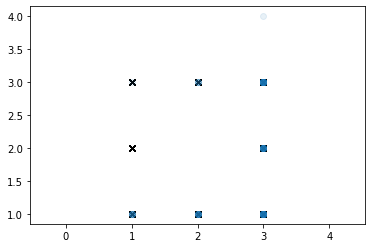

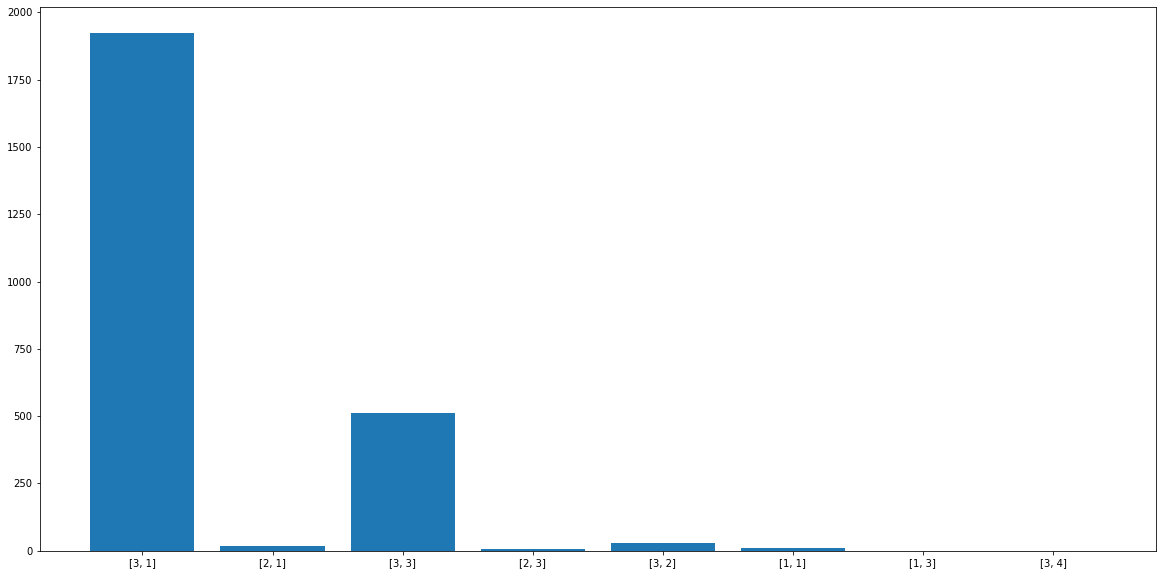

Processing Epoch 243
training start
Iteration 0, d real/fake loss 0.6107481122016907/0.8030858039855957 and g loss is 0.6125427484512329, NDiv loss 0.1370520442724228
Iteration 1, d real/fake loss 0.6113114356994629/0.8150286674499512 and g loss is 0.5678026080131531, NDiv loss 0.14134342968463898
Iteration 2, d real/fake loss 0.6119062900543213/0.8188036680221558 and g loss is 0.5730509757995605, NDiv loss 0.1339724361896515
Iteration 3, d real/fake loss 0.6125305891036987/0.8377307653427124 and g loss is 0.5836684703826904, NDiv loss 0.11828930675983429
Iteration 4, d real/fake loss 0.6131886839866638/0.8690682649612427 and g loss is 0.5795769691467285, NDiv loss 0.13508182764053345


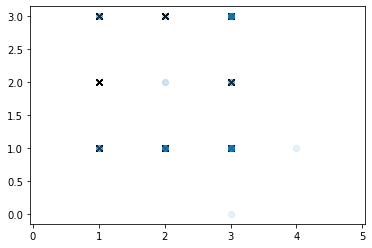

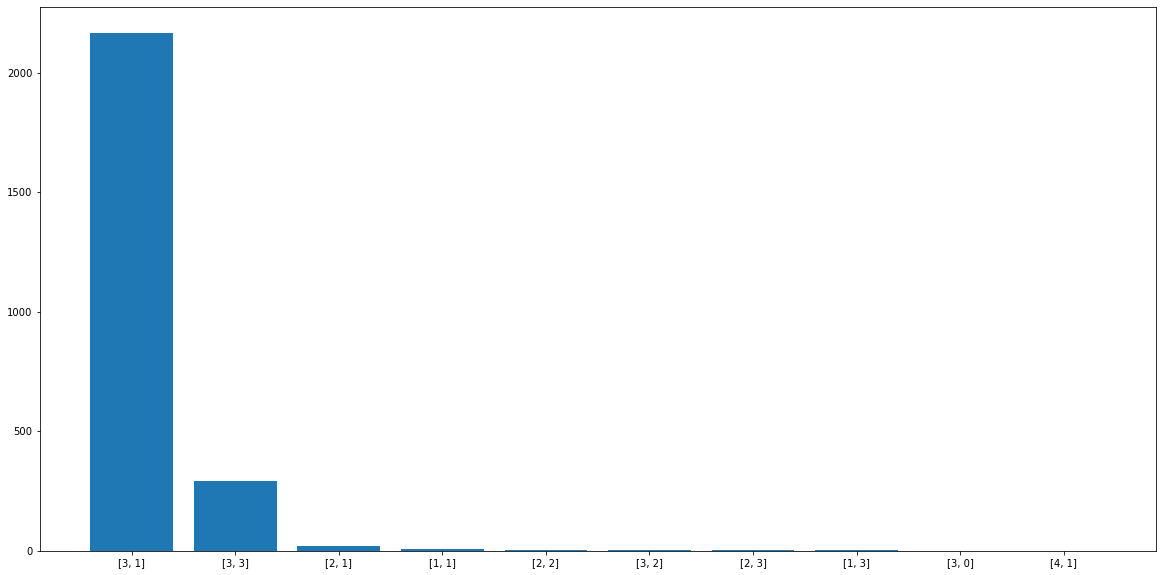

Processing Epoch 244
training start
Iteration 0, d real/fake loss 0.5440970659255981/0.8744170665740967 and g loss is 0.5494087934494019, NDiv loss 0.15212787687778473
Iteration 1, d real/fake loss 0.544861912727356/0.8773027658462524 and g loss is 0.5497866868972778, NDiv loss 0.14552395045757294
Iteration 2, d real/fake loss 0.5456847548484802/0.875896692276001 and g loss is 0.5352776050567627, NDiv loss 0.16025537252426147
Iteration 3, d real/fake loss 0.5465593338012695/0.8829625844955444 and g loss is 0.5378036499023438, NDiv loss 0.13485118746757507
Iteration 4, d real/fake loss 0.5474817156791687/0.8901940584182739 and g loss is 0.5330645442008972, NDiv loss 0.15615908801555634


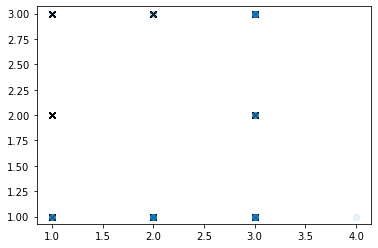

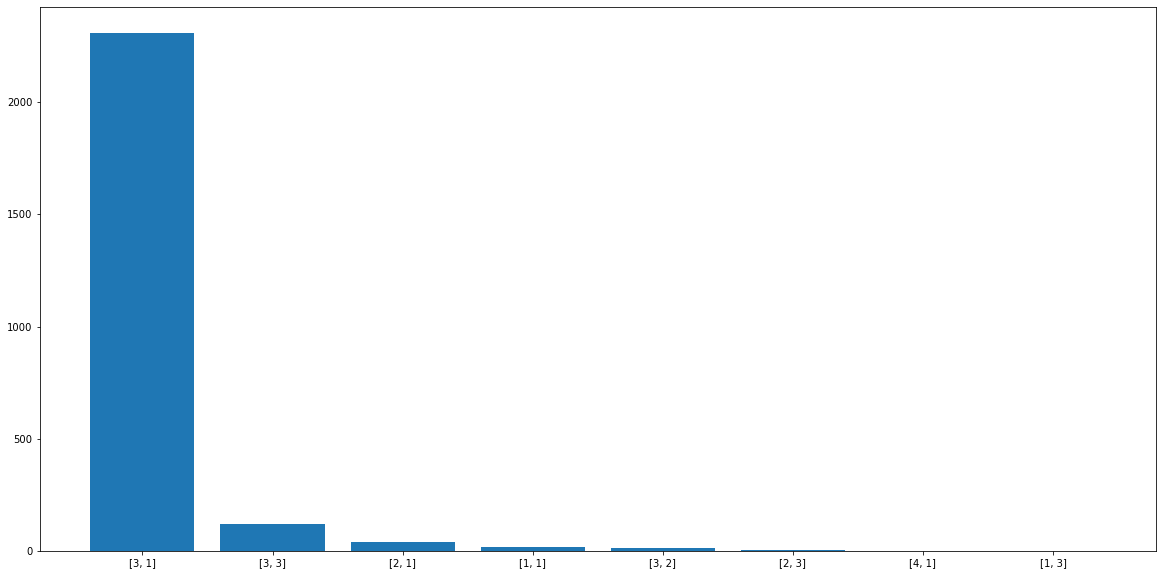

Processing Epoch 245
training start
Iteration 0, d real/fake loss 0.5963807106018066/0.8815332651138306 and g loss is 0.547971248626709, NDiv loss 0.1500535011291504
Iteration 1, d real/fake loss 0.5975590944290161/0.8825492262840271 and g loss is 0.5545375943183899, NDiv loss 0.1414189636707306
Iteration 2, d real/fake loss 0.5987558960914612/0.8969565033912659 and g loss is 0.5210205316543579, NDiv loss 0.16704417765140533
Iteration 3, d real/fake loss 0.5999715924263/0.9000269174575806 and g loss is 0.5299014449119568, NDiv loss 0.14474044740200043
Iteration 4, d real/fake loss 0.6012064218521118/0.9104628562927246 and g loss is 0.5390375852584839, NDiv loss 0.16474995017051697


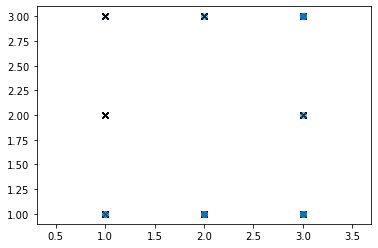

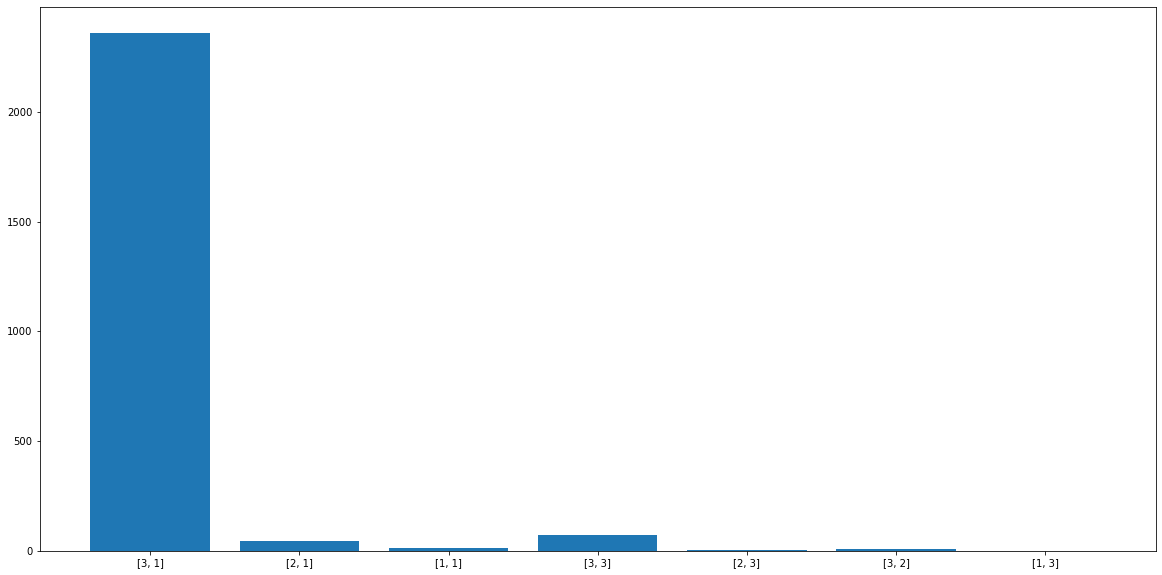

Processing Epoch 246
training start
Iteration 0, d real/fake loss 0.6174905300140381/0.9065796136856079 and g loss is 0.5359396934509277, NDiv loss 0.17993506789207458
Iteration 1, d real/fake loss 0.6187747716903687/0.8914037942886353 and g loss is 0.5315552949905396, NDiv loss 0.1572704017162323
Iteration 2, d real/fake loss 0.6200616955757141/0.8925601243972778 and g loss is 0.5284978747367859, NDiv loss 0.1519005298614502
Iteration 3, d real/fake loss 0.6213492751121521/0.9012518525123596 and g loss is 0.5200818777084351, NDiv loss 0.16364462673664093
Iteration 4, d real/fake loss 0.6226403713226318/0.9067070484161377 and g loss is 0.5374546051025391, NDiv loss 0.18879875540733337


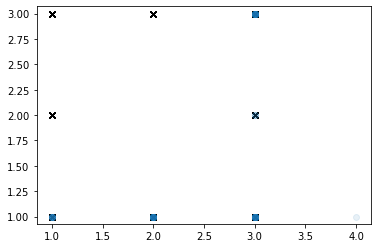

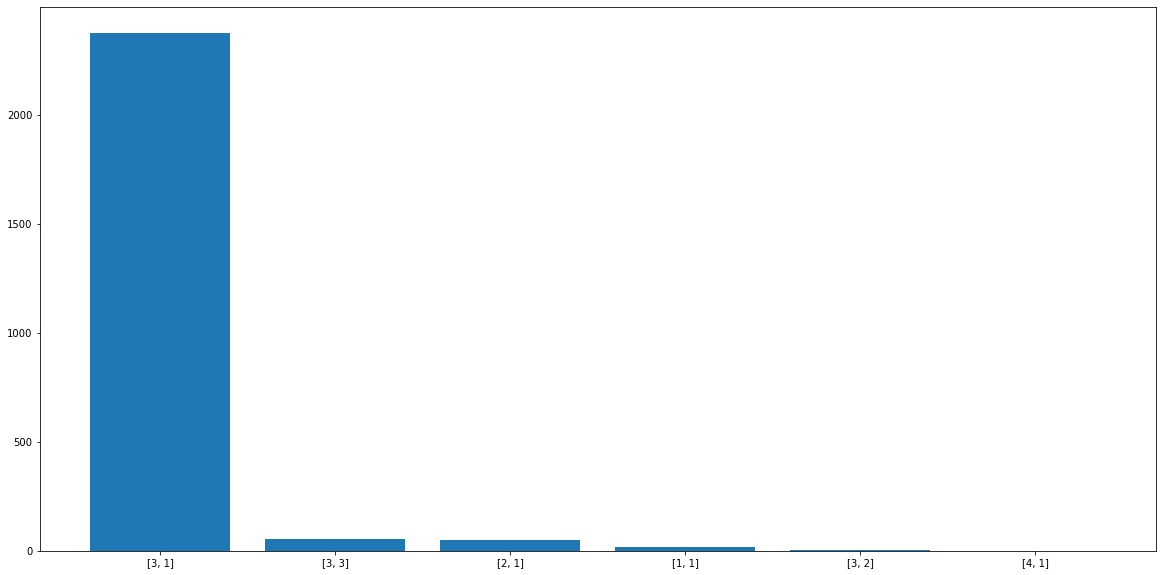

Processing Epoch 247
training start
Iteration 0, d real/fake loss 0.606411337852478/0.9123635292053223 and g loss is 0.5370677709579468, NDiv loss 0.1433909386396408
Iteration 1, d real/fake loss 0.6075611114501953/0.8942238688468933 and g loss is 0.5231789946556091, NDiv loss 0.15895378589630127
Iteration 2, d real/fake loss 0.6087110042572021/0.9091995358467102 and g loss is 0.5349358320236206, NDiv loss 0.17874546349048615
Iteration 3, d real/fake loss 0.6098654270172119/0.8984629511833191 and g loss is 0.5330144166946411, NDiv loss 0.1625843644142151
Iteration 4, d real/fake loss 0.6110203266143799/0.8930552005767822 and g loss is 0.5394126176834106, NDiv loss 0.17031759023666382


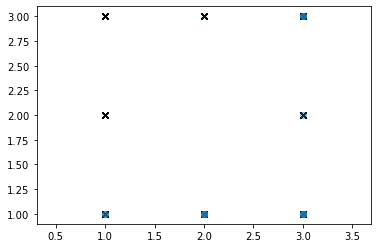

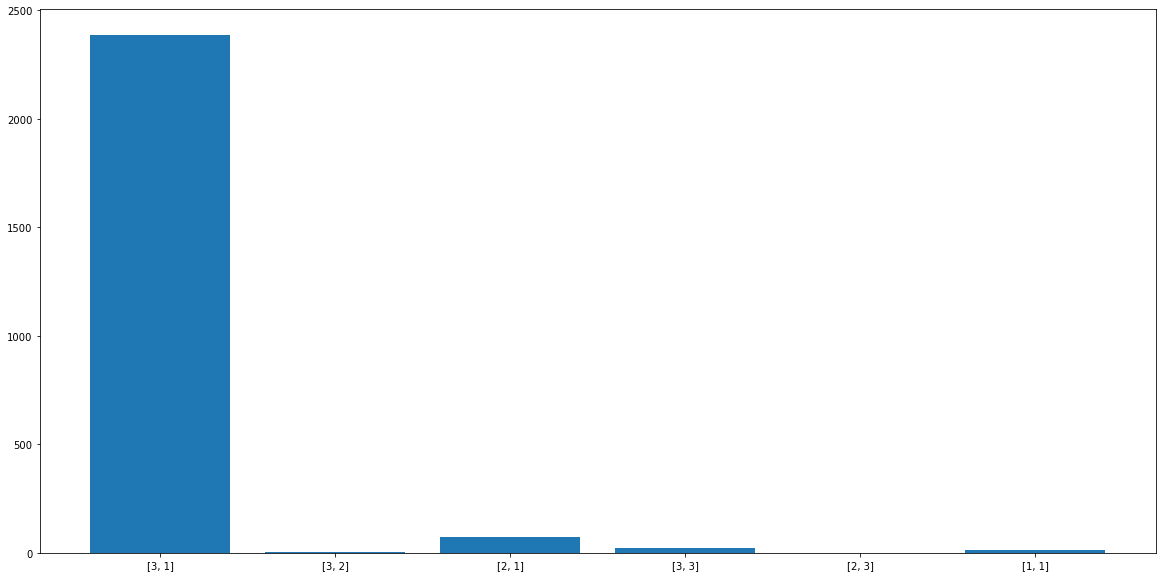

Processing Epoch 248
training start
Iteration 0, d real/fake loss 0.614357590675354/0.8903625011444092 and g loss is 0.5410417914390564, NDiv loss 0.17243711650371552
Iteration 1, d real/fake loss 0.6155816316604614/0.8911834359169006 and g loss is 0.5365285873413086, NDiv loss 0.16557198762893677
Iteration 2, d real/fake loss 0.6168012022972107/0.8856969475746155 and g loss is 0.532202422618866, NDiv loss 0.16741859912872314
Iteration 3, d real/fake loss 0.6180148124694824/0.8905375003814697 and g loss is 0.5347781777381897, NDiv loss 0.16456541419029236
Iteration 4, d real/fake loss 0.6192224025726318/0.8834869265556335 and g loss is 0.5374982357025146, NDiv loss 0.18223819136619568


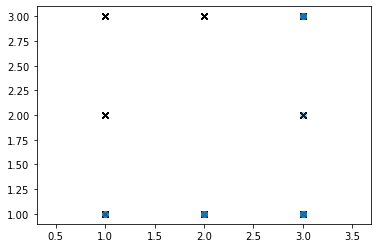

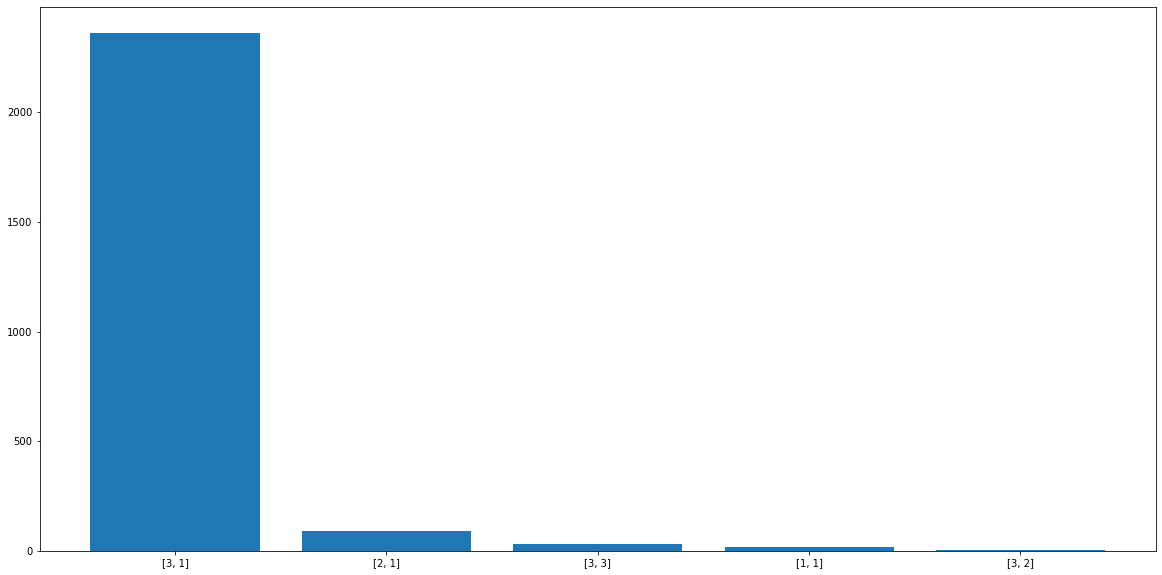

Processing Epoch 249
training start
Iteration 0, d real/fake loss 0.5854520201683044/0.8761225938796997 and g loss is 0.5293700098991394, NDiv loss 0.15296177566051483
Iteration 1, d real/fake loss 0.5866401195526123/0.8817863464355469 and g loss is 0.5436691045761108, NDiv loss 0.19291338324546814
Iteration 2, d real/fake loss 0.5878304243087769/0.8670089244842529 and g loss is 0.5416147708892822, NDiv loss 0.1803939789533615
Iteration 3, d real/fake loss 0.589016854763031/0.8755800724029541 and g loss is 0.5538442730903625, NDiv loss 0.15433023869991302
Iteration 4, d real/fake loss 0.590202271938324/0.868279218673706 and g loss is 0.5505717396736145, NDiv loss 0.17374740540981293


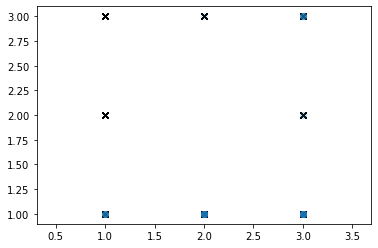

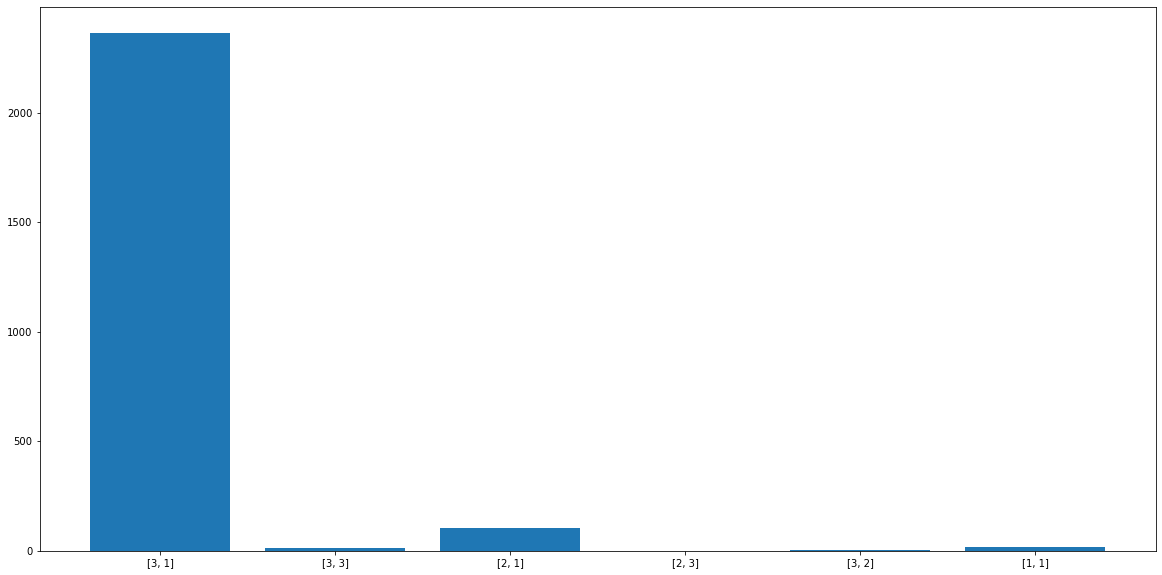

In [6]:
### Start training
for ep in range(250):
    print("Processing Epoch {}".format(ep))
    real_data = gen_real_data_onehot(dl, 128).float().cuda()
    input_data = gen_input_data(128).float().cuda()

    real_data = real_data.view(128, -1)    
    net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float().cuda()
    real_data = gen_real_data_onehot(dl, 1000).float().cuda()

#     d_fake, _ = net.g(input_data, temperature=100)
    d_fake, _ = net.g(input_data)
#     d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 1 == 0:
        plot_outputdata(real_data.data.cpu().numpy(), dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.data.cpu().numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.data.cpu().numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data]

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

Processing Epoch 0
Processing Epoch 1
Processing Epoch 2
Processing Epoch 3
Processing Epoch 4
Processing Epoch 5
Processing Epoch 6
Processing Epoch 7
Processing Epoch 8
Processing Epoch 9


TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

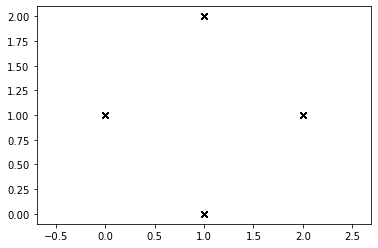

In [18]:
### Start training
for ep in range(500):
    print("Processing Epoch {}".format(ep))
#     real_data = gen_real_data_onehot(dl, 1024).float()
#     input_data = gen_input_data(1024).float()

#     real_data = real_data.view(1024, -1)    
#     net.train(5, real_data, input_data)

    input_data = gen_input_data(2500).float()
    real_data = gen_real_data_onehot(dl, 1000).float()

#     d_fake, _ = net.g(input_data, temperature=0.001)
#         d_fake = net.g.checkLogits(input_data)
#     print(d_fake[:10])
#     raise

    d_fake = d_fake.view(d_fake.shape[0], 2, -1)    
    d_fake = torch.argmax(d_fake, -1)
    real_data = torch.argmax(real_data, -1)

#   print("Real data shape is {}".format(real_data.shape))
#   print("Fake data shape is {}".format(d_fake.shape))
    if (ep + 1) % 10 == 0:
        plot_outputdata(real_data, dim1=0, dim2=1, marker='kx', alpha=0.1)
        plot_outputdata(d_fake.numpy(), dim1=0, dim2=1, marker='o', alpha=0.1)

        data = d_fake.numpy().tolist()

        # convert each entry to str, for later Counting
        data_list = [str(x) for x in data] 

        # plot bar chart
        index = range(len(Counter(data_list).keys()))
        plt.figure(figsize=(20,10))
        plt.bar(index, Counter(data_list).values(), align='center')
        plt.xticks(index, Counter(data_list).keys())
        plt.show()

### Conclusion: Put Regularizer without limits would make all logits closer to 0, thus uniform noisy ~ U(0, 1)
### from gumbel reparameterization would do play a BBBBBBbig factor.
### Clearly value range (0, 0.001) would be influced greatly from U(0, 1);